# Imports and preinstallation

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.measure import compare_ssim as ssim
import skimage
import tarfile
import sklearn.utils
import sklearn as skl
import IPython.display as ipd
import requests
import sys
import zipfile
import pandas as pd
import ast
import librosa
import librosa.display
from PIL import Image
import numpy as np
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from time import time
import IPython
import xgboost as xgb
import scipy as sc
from keras import models, layers, optimizers, utils
import tensorflow
import csv
import google.colab as gc
import seaborn as sns
import itertools


def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

#IPython.get_ipython().events.unregister('pre_run_cell', configure_plotly_browser_state)
init_notebook_mode(connected=True)

np.random.seed(42)
tensorflow.set_random_seed(42)


Using TensorFlow backend.


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install libs

In [0]:
!pip install clint

In [0]:
!pip install utils

Fix for 'title' has invalid value inside 'layout'

In [0]:
!pip install plotly --upgrade

# Extracting features from mp3

ex. in fma dataset  
https://github.com/mdeff/fma/blob/rc1/features.py

In [0]:
with zipfile.ZipFile('drive/My Drive/Colab Notebooks/dataset/train.zip', 'r') as zip_ref:
    zip_ref.extractall('train/')

In [0]:
with zipfile.ZipFile('drive/My Drive/Colab Notebooks/dataset/test.zip', 'r') as zip_ref:
    zip_ref.extractall('test/')

In [0]:
train_tracks_data = pd.read_csv('train/train.csv')
train_tracks_data.head(10)

In [0]:
test_tracks_data = pd.read_csv('test2/test.csv')
test_tracks_data.head(10)

In [0]:
train_tracks_data.loc[train_tracks_data['ID'] == 11]['Class'].values[0]

## chroma_stft

In music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.  

![Chroma_feature](https://upload.wikimedia.org/wikipedia/commons/2/25/ChromaFeatureCmajorScaleScoreAudioColor.png)


## rmse

The energy of a signal corresponds to the total magntiude of the signal. For audio signals, that roughly corresponds to how loud the signal is. The energy in a signal is defined as

$ \sum\limits_n \left| x(n) \right|^2 $
 
The root-mean-square energy (RMSE) in a signal is defined as

$ \sqrt{ \frac{1}{N} \sum\limits_n \left| x(n) \right|^2 } $

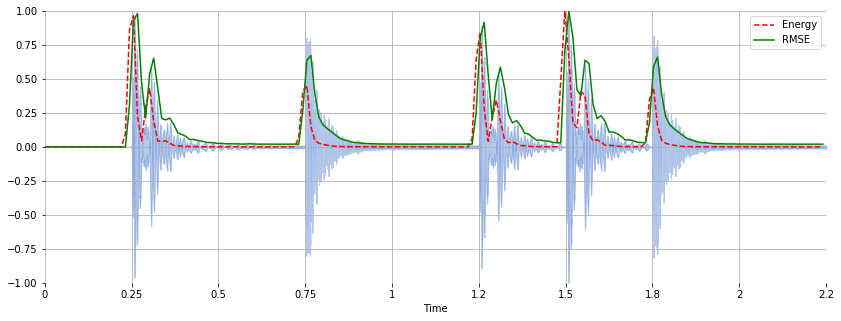

## spectral_centroid

The spectral centroid (Wikipedia) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:

$ f_c = \frac{\sum\limits_k S(k) f(k)}{\sum\limits_k S(k)} $
 
where $ S(k) $ is the spectral magnitude at frequency bin $ k $, $ f(k) $ is the frequency at bin $ k $.

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA0IAAAE8CAYAAADt6QHsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzsnXd4HNX1sN+ZbVppVV2wMS5AMM0QY9NbCOCAaaYkYGog%0Ajp3QewgJLcRf8C8JCaHHFEMI3SSU0DGE3mwwLUACxsbGxkWWtL3MzP3+mK2SbK1Wu1pp97zPY2s1%0Au3Pn6Orq3nvuaZpSSiEIgiAIgiAIglBF6OUWQBAEQRAEQRAEob8RRUgQBEEQBEEQhKpDFCFBEARB%0AEARBEKoOUYQEQRAEQRAEQag6RBESBEEQBEEQBKHqEEVIEARBEARBEISqw1luATaGYZi0tYXLLUZF%0A0txcK31bIqRvS4f0bemQvi0N0q+lQ/q2dEjflg7p29IxbFh9r+8Z0BYhp9NRbhEqFunb0iF9Wzqk%0Ab0uH9G1pkH4tHdK3pUP6tnRI3w4sBrQiJAiCIAiCIAiCUApEERIEQRAEQRAEoeoQRUgQBEEQBEEQ%0AhKpDFCFBEARBEARBEKoOUYQEQRAEQRAEQag6RBESBEEQBEEQBKHqEEVIEARBEARBEISqo0+K0Acf%0AfMDJJ5/c5fqLL77IMcccw3HHHcdDDz0EQDQa5eyzz+aEE05g5syZrF+/vi+PFgRBEARBEARBKJiC%0AFaHbbruNyy67jFgslnM9kUhwzTXXcOedd3LPPffw4IMPsnbtWu6//37Gjx/Pfffdx5FHHsnNN9/c%0AZ+EFQRAEQRAEQRAKwVnojWPGjOGGG27gF7/4Rc71L7/8kjFjxtDY2AjA5MmTWbhwIYsWLeKnP/0p%0AAPvuu68oQoIgDGyUwvGfT3AveA7NNLEaGlD1yX8N9j/LV49qakI1t5RbWkEQBEEQeknBitBBBx3E%0AihUrulwPBoPU19env6+rqyMYDOZcr6urIxAI5PWcYcPqe/6QUBDSt6VD+rZ0lLRvlYIPPoCHH4b5%0A8+G//83vvuOPh3nzwOMpnWz9gIzb0iD9WjpSfRuNGdR4Ct7SCN3Qb+O2tRWeeQYWLQLL2vDnmprg%0A3HOhubl/5CohMicMHIo+a/h8PkKhUPr7UChEfX19zvVQKERDQ0Ne7a1dm5/CJPSOYcPqpW9LhPRt%0A6ShJ3yqF86MP8Dz+KO4nHsX51RL7stdL/PAjiR16OFZTM3rAjxYIoPn9aP4OtGAA3e/H+dGHOO+/%0An/jKb+mYdy/4fMWVr5+QcVsapF9LR3bffrSklR22GFJmiSqHko5bpXB8/BGeBc/hfv5ZnIveRduY%0AApSFce99dNw3H2vc5qWRrR+QOaF0FKJgFl0R2nLLLVm2bBnt7e3U1taycOFCZsyYwcqVK3n55ZfZ%0AcccdeeWVV5g8eXKxHy0IgtAr9NXf0vijaTg/+xQAVVtLdNrRxI44kvj+U6CurudGIhEaZp2K59mn%0AafrRNDrue1hc5QShn1nbHim3CMLGME3czz2D+4Vncb/wHI5VKwFQuo6x867EphxEYs+9UTXeDTZR%0AM/9Bam+5geZDDqDj7vsxdtmtv6QXKpiiKUJPPPEE4XCY4447jl/+8pfMmDEDpRTHHHMMm2yyCccf%0AfzyXXHIJxx9/PC6Xi2uvvbZYjxYEQSgI79xbcH72KbEfHEx0+knE9z8Qamt72YgX/51/p/68M6l5%0A+AGapk2l46FHsUaMLI3QgiB0QSlVbhGEjVD3m8upvfVGAKzmZqLHHEt8ykHE99sf1ZKfJS+0w46Y%0Am2+B79KLaDr6MPw3zSV+xFGlFFuoAjQ1wGcPMR+WBjHNlg7p29JR1L6NRBgycRvQdVrf/xRqavrW%0AnmVRd8Wl1M69BXPMWNofehRriy2LI2s/IOO2NEi/lo7svn3+3eVM2WV0mSWqHIo5bjV/B0N23Aar%0AuRn/X+dhTN4ZHI6C23O9+DwNPz0VPRggeNlviJx9HmhaUWTtD2ROKB2FuMZJQVWBNW3hcosgCP2O%0A59FH0NvaiJ50at+VIABdJ/TbOYQu+TWOr5fRfPhBOD75uO/tCoLQI9bAPtOtajwP3Y8WDhE5dQbG%0Arrv1SQkCSOw/hfYnnsXcdBS+2Vfiu+hcSCSKJK1QbYgiJPDJV1LcVqgylMJ7+19Ruk7k1BnFa1fT%0ACF94CYFr/oi+dg1N06bifPut4rUvCEK3WJYoQgMSpfDOux3ldhM98cdFa9bcfgLtz7xIYofv4r3n%0ALhpP+CGav6No7QvVgyhCgpykCVWHc+E7uD76gPjUw7BGbVb09qMzZuG/5Xa0cIimY6fhevmloj9D%0AEIQMpqxjAxLXqy/j/N9/iR1xFGro0KK2bY0YSftjTxM7aCrul1+i6bAfoK1ZU9RnCJWPKEICsn4I%0A1Yb3jrkARGbMKtkzYscci//u+8CyaDh9Blpra8meJQjVjhKL0IDEe+dtAER+MrM0D/D58N91H5EZ%0As3B+9in1F58nmxqhV4giJGDIAiJUEdrq1XieeBRj621I7LVPSZ8Vn3IwoUuvQF+3Dt9ll5T0WYJQ%0AzbQ0FCHOTygq+orluJ95ksSOEzEm71K6BzkcBP/f74nvsReep/+F5/F/lu5ZQsUhipAgvtVCVeG9%0AZx5aIkHkJ7P6JdNQZNbpJHaaRM0jD+F+/pmSP08QqpGEmV9BTqH/qPnbPDTLIvqTmaWfa3WdwJ9v%0ARHm9+C69SCzwQt6IIiTQXO8ptwiC0D8kEtTcfSdWfQPRH03vn2c6nQT+fBPK5cJ38floAX//PFcQ%0Aqgh9EKVPrgpiMbx/v8uuGXTUD/vlkdYWWxK65DKxwAu9QhQhAVk+hGrB89QTOFZ/S/T4E8Hn67fn%0AmtttT/jcC3Gs/Ia6q6/st+cKQrUQiRnlFkHIwvPEo+jr1hE9/mTwevvtuZGfnUFi0mTbAv/c0/32%0AXGHwIoqQQCxhllsEQegXapJJEqKn/bTfnx0+7yKMbbbFe/cduN54rd+fLwiVTCiSkAyoAwjvnbeh%0ANK245QnyweEgcN3NGQu8pNQWekAUIQFdF5uQUPk4Pv4I91tvEP/+AZhbbtX/ArjdBK67CaXr+M4/%0AC8JSyLjaWLJK3CJLhWkpgmEpqjkQcH70Aa6F7xA/YArWuM37/fnmNtsSvuAXOFatpO43l/f784XB%0AhShCgmSaFKoC752lT5ndE8aknYnMOgPnV0uo+8M1ZZNDKA9LRREqGWINGjjUJFNmR0uVMjsPwudc%0AgLHdBLz33IXrlX+XTQ5h4COKkACyfggVjta2nppHHsIcO474AT8oqyyhX16GOXYc3ltuwPn+orLK%0AIvQvSjbrJUNZSgJeBwBaexs1/3jYnmv3n1I+QVwuAn+5CeVwUH/BORAKlU8WYUAjipCAPxKXQFOh%0Aoqm5/160SITIaTPB4SivMLW1BP58I5plUX/eWRCPl1ceod+wLFGGSoXoQQOD9Fx76k9BL+8W0/ju%0ATkTOPBfH10upu+bqssoiDFxEERKIRA0ShtRgECoU07QDd71eO1vcACCx975ETj4V56efUHv9n8ot%0AjtBPGJYSV+QSYSkl8a7lxrLwzrsNVVND9ISTyi0NAKGLfonxna3w3nYrzrffKrc4wgBEFCEBpfql%0ArqQglAX3gudwfL2U6DHHoppbyi1OmtCVv8UcMZLaP/8Bx2efllscoR9QliWxLCXC5dQlWUKZcf17%0AAY6lXxE96ocDZ66tqSHw55sAqD//TIhGyyyQMNAQRUjAtCw5SRMqFm8yZXbkJ+VLktAdqqGR4B+u%0AQ0skqD/rZ7JAVwEjWmrFNa5EuJ06YXHxLiupuTZaxoQ03WHstjuRGbNwfvE/6mZLHTchF1GEBDZp%0A8UpVbqEicSz5AvdLC4jvvifmhB3KLU4X4gdNJXLCybg+XIzv8kvLLY5QYtqCMUxLFKFSIUpm+dCX%0ALcX9wnMkJu+CsePEcovThdCvr8IYvzW1c2/B/cxT5RZHGECIIiRgGIpoXIqqCpWH55+PABA9+dTy%0ACrIRgr/7A8a22+O9+w48jzxUbnGEEuLzujBM2ayXAqfTQUdIEo+UC+/f5qEpRaSMKbM3Sl0d/rl3%0AoWpqqD/3dPRvVpRbImGAIIqQQEcoTkcwVm4xBKHouJ95CuV0Ev/BweUWZcPU1uK/829YvnrqLzwX%0Ax38/L7dEQolw6DpK6hWUBKeu4RAX76Kytj2S3wctC88/HsZqaCR2+JGlFaoPmNttT/C3c9Db2mj4%0A2U/AEFdKQRQhATuTUVO9u9xiCEJR0b9ZgeuD90nsuQ+qsanc4mwUc8utCFx3I1o4RMOMk6XmRYWi%0AaWCJa1xJ8LgcbNJcW24xKor1/vziFp0L38XxzQriUw+FmpoSS9U3oqecRvSIo3C98xa1f/hducUR%0ABgCiCAkMafCw3i8WIWFwsHxNMOf7DVkzU37gsamHllymYhA/4ijCP/0Zzs8/o/7i85A8y5XJ6vV5%0AnrILvUZihMqD5/F/ABA78ugyS5IHmkbwT9djjhlH7XXX4nr5pXJLJJQZUYQEXA6dOq+r3GIIQl6E%0Ao7kpcr9dH+72c55nngQgfvAhJZepWISu+n8kJk2mZv6D1NxzV7nFEYqMAtoCkh2wFMQNk5WtYkkt%0AJd2mfrcsPI8/itXURHzf7/e/UAWgGhrxz70THA4azpiJtmZNuUUSyogoQoLtsS4HacIgZEMnwFpH%0AO67XXyWx40SsUZv1s1R9wO3Gf9vdWE1N+H79C5wfLi63REIRWdceEUNfiXA6dUIRifkoJp2H6hcr%0AOrp8xvX2mzi+XUXs0CPANXgOVI1JOxO67Dfoa9fQcNYssKSofLXiLPRGy7K46qqr+Pzzz3G73cye%0APZuxY8cC8Omnn/K732V8LxcvXsxNN93EjjvuyEEHHcT48eMBOPDAA/nxj3/cxx9B6Csa4lIgDB4U%0AEI4arGoNYm5g7XIveB7NMGyf9UGGNXoMgZvm0njisTTMOIW2F14Z8DFOQn40+Tw4HBLQXwo0NFnH%0AyoDnsaRb3LRB4BbXicjPz8T12st4XngO743XETnngnKLJJSBghWhF154gXg8zoMPPsjixYuZM2cO%0At9xyCwDbbrst99xzDwBPP/00w4cPZ9999+WNN97gsMMO4/LLLy+O9EJx0DRa/VFGDKkrtySCkBfL%0A1wTQNA3TtNC6yRTlTrrFxQ4efIoQQHzKwYTPvZDav1xL/Tln4L/rXjvSXhjUeNwOhjQM7GDywYqm%0AQVO9p9xiVBemieeJx7CGDCGx977llqb36DqBG/6K8/t7UnfNb0nsvhfGrruVWyqhnynYNW7RokXs%0As88+AEycOJGPP/64y2fC4TA33HADv/71rwH4+OOP+eSTTzjppJM455xzWCN+mQMDhVTkFgYVa9o2%0AEnAej+Ne8ALmmLGY223ff0IVmdAlvya+5954nv4X3puuL7c4QhEIhOOsyTclsdArlFI01kn201LS%0A2eLmeuM19LVriB06DZwFn6uXFTVkCIFb7wClaPjZaWht68stktDPFDxyg8EgPp8v/b3D4cAwDJxZ%0Afwzz58/n4IMPpqWlBYAtttiCCRMmsOeee/L4448ze/Zsrr9+4wv8sGH1hYoo9ECqbxsaPIwf0yJ9%0AXUSkL0tHU2MtwbhJU1MtCcPCoWu5/f3ccxDww4yfMGx4Q/kELQaPPAw77YTv6svxjRoOs2aV9HEy%0AbktDql9NNDSHQ/q5iKT6sr6+hubmOmrqPHyzJsg241rKLNngp6mxNmesrvbHOs21/wLAe+pJeAfz%0AmJ42Fa64AsdVVzH0jBnw9NMlj3eSOWDgULAi5PP5CGXVurAsK0cJAnjiiSdyFJ3dd98dr9cLwJQp%0AU3pUggDWrg0UKqKwEYYNq0/3bSAQpa0txFq35M4oBtl9KxSXYcPqae8IEwjEaPeEMUwLXddy+tt3%0A/0N4gfbvTSEx2H8PjjocDz1G09GHov/sZwSCMaInn1qSR8m4LQ3Z/drgcVLn0qWfi0R361jr+iCr%0A10cYUjd4AvcHIqm5NtW/CcOkrT3zPYbBkPnzYdhwWrfdCQb7mP7ZuTS89Q6eZ54i8pOZBK+9vmTu%0AyDLXlo5CFMyCd76TJk3ilVdeAexkCKkECCkCgQDxeJyRI0emr1122WU8++yzALz55ptsv/3gdVup%0AJBRItXNhcJEcrkrZ7kaZ6wr3s09jNTeT2G2P8shWZMxttqX9kX9hDRlC/YXnUHPv38otktAHcsar%0AUFRCMYN1HVFCnVLsC33nwy9bc753vfoyemsrscOngcNRJqmKiMOB/+bbSezwXbx/vxvvjX8pt0RC%0AP1GwIjRlyhTcbjfTp0/nmmuu4dJLL2XevHksWLAAgK+++opRo0bl3HPhhRdy//33c/LJJ/PAAw+k%0AY4eEMiM6kDDoUMn/FcGslLnOD97HsWol8SkHD1qf9e4wt93OVoZaWvBdcDY1991TbpGEAlAoCegv%0AISvXhWmp9+DzSqxQsWgL2AWr/eFc5dLz+D8BiB15TL/LVDJ8Pvz3PoS56Sh8v70C9xOPllsioR8o%0AeKeg6zpXX311zrUtt9wy/XrHHXfk5ptvznl/9OjR6WxywsBCKUgYFq3+CCNaJHucMPCp97r4fEWI%0A7MIs7qdtn/XBmi1uY5jbbU/7/Cdo+uHh+M4/C6VpxI4/qdxiCb1FDp5KxsiWWlxOB5u0eMstSsXw%0AwZfr2G/iKFAQjScPneJxPE8+jjliJIlddy+vgEXGGjGSjr8/RNPhB9Fw5izaNx2FMXmXcosllBAJ%0AChFQQCRm8tW3HfxnaVu5xRGEHlHAqvVhnLqes6/0PPMUyuMhvt/+5RKtpJgTdqB9/hOopibqzzsT%0AzwP3llskoRcoBYYUbiwZHreOpRRt/li5RakcVOZFm99263S/+m/09nZiRxwJeuVtI80JOxC4bR7E%0A4zSePB3962XlFkkoIZU3goVeo5TC7dQBDUc3NVkEYaChFMTiJmgZg5D+1RKcn/6H+Pe+D1kZLSuN%0AtDLU2Ej9uWfgefC+cosk9IJl30qQdClIzQPfrA3S6o+WV5gKQgGWUiRLrwPgeXTwFlHNl/iBBxH8%0Af79HX7eWxhN/hNbRXm6RhBIhipCQptbtYOwISekoDGw6gnFA2esykF6cn3kKgHgFusV1xtxhRzrm%0AP24rQ+ecLsrQIGLkkNpyi1BxZNe3GdFSRzxhllGayuOLFR2Z+TYWw/30k5ijNqt4l7HojFmEf3YG%0Azs8/o2HGjyEhSTgqEVGEBMAO4rXs9HGCMKAJR42cYZp67X7mSTtu5gdTyyFWv2PsONFWhhoaaTj7%0A59T+6fc58VLCwMTtqoAMWwMYhcLhkK1N0VC5X93/fhHd30HsiKMq0i2uM6Gr/h+xgw/B/cpL+H55%0AocyxFUjlj2Ihb5RSLBW3DWEwoCAaN9MnwVprK66338TYeVfU8OFlFq7/MHacSPvjz2BuNpq6ObOp%0AP+tnEJP4iIGKQvZRpUBB2nNLWdDkk6xxxWDVujCgWLnOrhmpAM+jjwAQm3ZU+QTrT1JptXeciPee%0Au6j98x/KLZFQZEQREmwUdIQShKX+gjDgSSo/gGEqUOB+/hk0y6rIbHE9YW67HW1Pv0hi0mRqHn6A%0Axh9NQ2tt7flGod9RShShkqGS8SyA21U5qfPLTbajiB6N4H7mKcwx4zB2mlxOsfoXnw//3x/EHD2G%0Aujmz8d56Y7klEoqIKEJCmhq3gxHivy4MIlJu656nnwQgPrX6FCEAtckmtP/zKaJHHIX7rTdonro/%0Aji/+V26xhI3w0RJRVotFOkYoaXJzOSTpT3HI1dpHLHwNPRS0rUFadfWxNWIk7fPtlOG+K35FzV13%0AlFskoUiIIiSkTyl1XfzXhYFP2r1Is/85ohHc/16AsdV4zO9sVV7hyonXS2DuPELnX4Rj6Vc0TT0A%0A12uvlFsqoRMdoRiWUqxeHy63KBWDrQeptPXCErNb0VCpTtVgzCvPAFXkFtcJa/Mt6HjkCayhQ6n/%0AxflSvqC/MYySHPCJIlTlpE7SFLZvtUZ1nfIIgxNF5gR4xOI30SKRqsgW1yO6TvjSK/BffwtaOETj%0AsUdSc58UsR5I+LwuTNMibkg9oWKjAMtS4n5YJLJ2BziiYUa9/W+MzbfA2OG75RWsjJhbjaf94cex%0AUrXcHvtHuUWqGrzzbqNlz8k4PvqwqO2KIiQAGT9gJSuIMAjI9oQZ9eZLAEQPOqR8Ag0wYtNPpOPh%0Ax1A+H/XnnUntNVdLcMpAIPk7MC3FJi3ihlwKNE0sQsUktTcY+c4rOGMRYkceXXVucZ0xt59Ax0OP%0Aoup81J/+U9zJ0g1CaXE//ywA1iYjitquKEJVTibbjhKXAmHQoZkmo975N9aw4Xw+Yny5xRlQJPbc%0Am/anF2BsvgV1f/4j3ltvKrdIArYuZFkQCMXLLUpFoZSGUmINKjoKNNNgq0f/DkDsiMototobjImT%0A6LhvPrjdNPz0FFwvLSi3SJVNIoHrnbcwtt6m6JlhRRES0tl2lFKiCAkDHqUyIbxDP15ETcd6Ygcf%0AgpRQ7Iq55VZ0PPKEHeB75a9wP/7PcotU1aTGbSSWoC0gac6LhSxbpWXHO//EsE8WsXyPAzC3277c%0A4gwYjN12p+OeB0HTaDz1BFxvvFZukSoW5/vvoYXDJPbap+htiyJU7WQtIJLaVRgsKGUnSZh049UA%0AxH54nNQC3gDWZqPpuPdhrDofDWfOwvn2W+UWqeoxLDl0KglK1rFiohSMeelJtnnkLvybbc5bF/6u%0A6t3iOpPY53v45/0dDIPGE36Ec+E75RapInG/bif+iYsiJBQbKyvYQuKDhMGBvdP57l//j8avv+Tz%0Aw04gscde5RZqQGPusCP+O/5mL9anHCeptcuIQuHQNUYN85VblApCoWl9j3Nd+q2/eCJVAE1ffspu%0A119BoraON666kYRXxmx3xA88CP/cuyAWpfGkY3F8KfNrsXG9blvbEnuKIiSUCFGBhMHEmDdeYMsn%0AH6R93HhWXHB5ucUZFCT2P5Dgtdejt7XROP0YtDVryi1S1ZFK/W4aCsMQZ85iopKHeYUqQ0opWjui%0AxRdssNLayt6/PQdnLMpbF/8fgTFbpN9a3Sap3zsTP/Rwgn+4Dn39ent+Xbu23CJVDrEYrnffwth2%0Ae9SQIUVvXhQhAVDpIFOxCgkDndq1q9jjxisxPDW8dekfwVtTbpEGDdETTiZ04SU4vl5K48nHQihU%0AbpGqDqXAVAqnQ5bfYqFyXLxVQSd7pqXQxe3LxjDguOPwrf6GD084nZV77J/ztsS3dU/0pB8TuuAX%0AOJbJ/FpMXO8vsktk7LV3SdqXmVjIoVA96LNlbcUVRBC6wzTZ/Q+X4gn6+eBnv8Q/tooLqBZI+Be/%0AInrcCbjef4+Gn/8ETLFM9C9KEtMUmVS9m4ynd+/71jAtpLKTTd3sq2DBAr7ZbT8+nH56pqiq0CPh%0AS35tz6/vLaLh9BkyvxYB1+uvApDYa9+StC+KUJVjW4G05ERX2EmaUopIzCi6bILQmcBlv2H4R++y%0AbI8DWXLosWSqXAh5o2kErr2e+L7fx/Ps0/h+dbFEl/cXyeFqFTjXChtAQV9rgVsWWKb8Ujz/nE/t%0Azdejxm/NWxfPAV22ib0ie3595il8l14k82sfcb3+KkrTSOyxZ0nalxFe9aicV4WcpJmSAUnoB5zv%0AvI3vD78jNHQEb5x1lWQv6gtuN/5592BsNwHvvNvx3vDncktUFWRiWEQPKjpZHRqJ9f4U3lRWQetf%0AJeH4+CPqzzsTy1fPmnn3kqirz1jbkDGbN9nz61134L3hunJLNHiJRnG9+zbmdhNQLcWPDwJRhAQy%0A+8nUAt1bRBESSo3W0W67GSjFmxf/H/H6xnT9Kyg8LqCaUfUNdNz3MObITfHNvgrOPhsSiXKLVdGo%0A9H9ySFws1vujOQqMUrCmLdLrdiyruouxautbaTz1RLRIhMBNczG+s7X9RrJP5Nipd6j6Bjrun4+5%0A6Sh8s6/E88hD5RZpUOJ6byFaLEZ87+Jni0shipCQptBECZalsMS5WigVSuG7+Dwcy79mzRnns2bC%0Azl0+8tnX7WUQbPBjbTqK9kefwth2O7jxRhp/NA1t3bpyi1XRqGSMkGjuxWFNe0rp0dLaZaPP3et2%0ALEtV7WZfX/IljdOPxvH1UkIXXkJ86qFA13TkQxpq8IfjcvCZJ9bITem4bz5WfQP155yejnUR8sf1%0Aml0/qBRps1OIIlTlpIrPpSa7Vn/vs8FYliXZ5oSS4XngXmoe/QeJXXdn9ZkX4qt1dfnM6vWSzrVQ%0ArM23oO3JF+Doo3G/8RrNP/gezg8Xl1usiiTb6l7olLm2o/fWjkrHNgirtHv3+gKymhlmFTrGKUXN%0AvX+jZf+9cS1+n+j0EwlffKn9VvK/7D7Rdfj863aUVXU9VTDmdtvjv+teABp+fAKOT/9TZokGF643%0AXitpfBCIIlT1qOz/FTTW9f4kzbCU2M2F4hKP41z0Lt5bb6T+0ouwGhrx33I7OJ3U1TghK9ZCKAI+%0AH8yfT+jSy9G/WUHTYT/AM//BcktVeWQpQYWeqi9fHSyiQIOfdR0REkbGJUEpCtqoW1Z1Wem01lYa%0ATjuJ+vPPQjmd+G+5ncD1t6STI3QXgtnaESUUEffZ3pLY53sE/nIzur+DpiMOhueeK7dIg4NIBNfC%0AdzB2+C6qqblkj3EWeqNlWVx11VV8/vnnuN1uZs+ezdixY9Pvz549m/fee4+6ujoAbr75ZhKJBBdd%0AdBHRaJThw4dzzTXX4PV6+/5TCH1Dy0z/RgE+bpYl8RlC39BWr8a18B3737tv4/zgfbSYfaqrHA4C%0AN9yKNXoMZBc8TI65te0RdMls1Hc0jfD5F2NsP4H602fScMZMwh99SOjy34Cz4KVCyMFW4PviWmSK%0AH3IO8YSFYdp9kurVhgIO9KrJq8H10gLqzzkdx+pvie+xF4Eb/2rPr9mo3Jip6umd0hD74XH4LYv6%0AC86GqVPxXv07IjNPl6Q/G8G18B20eJzEnqWpH5Si4NXthRdeIB6P8+CDD7J48WLmzJnDLbfckn7/%0Ak08+4fbbb6elpSV9bfbs2Rx22GEcffTRzJ07lwcffJBTTz21Tz+AUDixhJkOMk8tAivX9b4AmGVV%0AoUuBUBTF+t2uAAAgAElEQVRcb71hL8hLv0pfU7qOsf0OGLvsSmLnXUnsvifWZqM32IZdCBFWtYbY%0AZmzpTo2qhfgPptL+7Es0nDKd2ltuwPmfj/HPnYdqbun5ZiEv+pLbI9v6IWRZhTXShcFra3q/tbGU%0AouI9vqJR6n57BbW33YpyuQhe9hsiZ54DDsdGb8tJ8lFyISuX2LHHY26xJc2nnYjvsl/i+PQ/BP/v%0AT+DuveJeDaTrB5UwUQL0wTVu0aJF7LOPLdzEiRP5+OOP0+9ZlsWyZcu44oormD59OvPnz+9yz777%0A7ssbb7zRF9mFPvLN2mCuSwGKYY29t9CZYhESCqTm73fjWPoV8f32J3Tp5bT/41+s+2IF7QteJTjn%0AWmI/PC5HCep6aKs6fRWKgfmdrWh/5kViB03F/fJLNH9/L7xzb0YLBsot2qAmFZPZFwypddOJ4vSH%0AZVW2Vcjx2ac0/+B71N52K8ZW42l/egGRc87fqBLkcXfzniz3fcLYeVd4910SO07Ee+/faDrmcLS1%0Aa8st1oDE/fqrKF0nsXvp4oOgDxahYDCIz+dLf+9wODAMA6fTSTgc5qSTTuK0007DNE1OOeUUJkyY%0AQDAYpL6+HoC6ujoCgZ4X1WHD6gsVUeiB1mCCbbYchs9XQ2NjLaZloTS9130eVxo+f1x+V1lIX+TJ%0AwrehuRn3gudx5+HetrI9SmNjLetDCepqXFhKYZoWLqe9YEu/942c/htWD0/9C2bPxjFnDr7Lfonv%0Aj3Pg5z+3U21vumn5BB1kpPrVV19DjdtBc3MtK9ujBY3X2jq3jPMsfL4aWlp81Nf5aWjwYpgWSu/9%0AOhZIWNRHjPR9Sim0SnJbmnoGfPYpnHkmzt//nuba2o1+/Js1AerrPaDruF0OHA4N01Q4dI3GBq+M%0AwT5Rj+vN1+G003A99BBDD9kfHnsMvvvdcgs2cAiH4b2FMGkSQ7fcrKSPKlgR8vl8hEIZNyrLsnAm%0A/ci9Xi+nnHJKOv5n991357PPPkvfU1NTQygUoqGhocfnrF0rJ5ClYNiwevyBKOvWBQkGY7S7dCyl%0A8Ifive7zda0hAoGI/K6SDBtWL32RB/q3qxiyZAmxHxyMvzVfl0xFR0cYFxAIRlFKYVoKp8NWoqTf%0AC2eD4/b089GOPQXvXbfjveOv6HPmoK69ltjRPyJ8+tmY223f/8IOIrL7NRCIEnM5cGn2OF69xo/e%0Ay822vyMq4zzJsGH1BAJRln/TRjAUo8OlY5oW/nDv17H1rUH8fnsdC0cNVraG+M6oxhJJ3s+YJkM/%0A+ghjp0m0X3kNhEwI9dw/gUCMYDhuK0K6jmFaOBwaXpcmY7APDBtWz9qQCTfcRu0W46mbMxu15174%0Ab5pL/NDDyy3egMD18ks0JRKEd9uLUC/GWiEKesGucZMmTeKVV+z83osXL2b8+PHp95YuXcoJJ5yA%0AaZokEgnee+89tt9+eyZNmsTLL78MwCuvvMLkyZMLfbxQFFSy0nkma1whJu/sQnRKqXTgqiBsDOc7%0AbwGQ2HWPvO8xTFvxSSEuGv2DGjKE8IWX0Prefwhcez3m2HHUPHgfLfvtQeNxR+H694uSwi8fslId%0A1ricvXbFSin+QgalIGaYnS4W0A4Z1zjDrKySEPqK5WjxOObmW+Z9T7Y1TGUHCQnFQ9MIX/ALOu78%0AO6BoPO1E6n51MfqqleWWrOyk44P2Km2iBOiDIjRlyhTcbjfTp0/nmmuu4dJLL2XevHksWLCALbfc%0AksMPP5xjjz2Wk08+mWnTprHVVltx+umn8+STTzJ9+nTef/99TjrppGL+LEIvUUBHKJ5zpZDJ3y4Q%0AaL+OJUy+WukvinxCZeN6+00AErvlrwitXh8mGE5gpcZqdlajCtq4DFhqaoiefCptr71Lxz0PEt9j%0AL9wvLaDp2CNp3m9PPA/cC7He13CpdAzToi0QS9e6QcH6QJRgxOhVO31Ju12pdE7VU2gSbLtv7ddx%0Aw6wovd6x5EsAzC3yV4Q2RkdQ/saLSfywI2j71/OYY8ZRe/tfadllR3wXnI1jyRflFq1suF97BeVw%0AlDw+CPrgGqfrOldffXXOtS23zPyRzZw5k5kzZ+a8P3ToUO64445CHykUGWUlF9XUwU+BK4htEbJv%0AjBsWlpwcCXngeutNlMeDMXGnXt2naVrO5iddFLjYAgobRteJHzSV+EFTcb6/CO+tN+J5/FEazjkd%0A67dXEpkxi8iPZ6CGDCm3pAOCte0RVrdliv4qoLbGhcvRO7c4SxV2WFXJKNUp26mC9mCMhGHaio1S%0AeNx5bHWyJpF4wqSSZpRCFCFF9tZAobKKBcYS4vVRbMwJO7D+9XepefgBvDdeh/fvd1Nz3z3EDj+S%0AyDnnY+xQRfFDwSDOxe9hTNwJ5St9LJoU36hicqqc55RWLbydRMJCyRwp9IAW8OP85COMiZPA48n7%0AvtQmUNdS32e/WUQBhbwxdppM4K/zWP/uh4TPOMdO0TtnNkN22hbfRefh+N9/yy1i2TFMC9PMWINQ%0A4HE50PXeKULFyDpXiWR7Y1tKoaNhWop17RHWtEXyasNSpA/xDFNVVD87vuq9IrR8dYBYwuz5g0Lx%0A8HiInvRj2l5fSMftd2NsvwM1j/2D5gP2oXH60XaChUoamBvA9c5baIZBYs/Sps1OIYpQFaOUYsXa%0ATJVyBYSiCQzTIpYwicbzdNtQGUUqbpioCkq0I5QG58J30Syr12bvVC3JtmC8i0NMFawPAxprs9GE%0ArprN+g8+JTh7DtbwEXj/dicte+1Mw0nH4vzog3KLWFYylkuFlXWtd23YN1gSJ5Qm5dSgaZl1qM5r%0AW4BcTp18z+VUlrUtO+61EijEImRZdsd63M7cwqoV1C8DFoeD+BFH0f7CK7Q/8A/ie+6N+8UXaJo2%0Alaap++N5+IGKdkF2v/EaAPG9RBESSoxSoCyFhmZPbsoO4DUtRXsgmuPKsfF2VNpv3TAtRA8SeiIT%0AH7R7YQ0kx6sYhAYeyldPZNYZrH/7fTru/DuJXXbD89wzNB+wD/Wn/xR92dJyi9jvKAX+cJzOI7b3%0AipDdQmq+XdeRn7WjklGQ9uGKJ1I2HXtNW9sezXs9MrNcw01LVVQslmPJl1gtLaim/AtOp376hloX%0AAFq2o1zldM3ARtNI7H8gHY8+RduTzxM7+BCc779Hw5mzGLLTttT+7mr0b1aUW8qi43r9FZTTSWLX%0AAvcHvUQUoSrGzhiXfG2lwniTp2KaBnkuIVanBUQmSaEnXO+8hdI0Ejvv2qd2Uie4hTt2CiXD4SB+%0A2BG0P/k87Q89SmKH71LzyEO07DmZussuQWtt7R85lEJf/jXE4z1/tqRiZGnuSqE0sHrpR5yKEUqN%0A+2/W5pt2vnKx+8N+vXKdfXiXWtmczvyP5bJjryrKImQYOL5e1quMcZ1RgKZnXstc2/8Yu+yG/28P%0AsP6dDwifdR6YJnXX/ZGWyRNoOO0kXK++XBHmOi0YwLn4fdttPqtWaSkRRaiK6ZyKVSWP1pSCYDhB%0AvpNd1wVk8P8xCiUkkcC16F3Mbbbr1QklbCQznAy5AU1iv/1pf/5l/LfcjjVyU2rn3kLLrt+l9s9/%0AgFAJNvOmieuN16i77BJaJk9gyOQJDN1iU5qm7o/v0ovwPHQ/ji/+l/G1LDHfrg9lhmjyhYbW68fb%0A419LutkpEoYEZGYHTg1rqklfNi0Ll0PP240wW081KygYS/96GZphFJAxLis9giSkGTBYY8cRuuJq%0AWhd/hv8vN2NM2BHPk4/TdMzhNO+zq525cxCPXdfbb6KZJvG99+23ZxacNU4Y/NhJDjqf79gnYS6n%0AnrdCY6qMq4ZlKZT4rwsbwfnRB2iRSOFucUk6D8/hzbmV0tf7o7Q01CAMEHSd2DHHEjtsGt6/3Unt%0An35P3TW/pebO24j8/CyUz4cWDqOFQ+mvhMP2a8PAHDUKc9zmWGPHYY7bAnP0GKjJ+v3GYrhfeQn3%0AU//C8+xT6OvWAWA1NhE75HD0lStwfvgBrkUL8SZvseobMCZOIrHzzkRm/Bw1fHhJfvRo3Eyn4cpO%0AzmmYdjB6LG7icTt6bMdM+jBbyUMsqdkGFpn+rHE7MC2FptlKpspKgNBjO1mHeKZh5R1bNNBxFpAo%0AAUh3asK0cvYHKUVcKDNeL7HjTyI2/USci97Fe8dcPI//k4ZzTif+8AME/vgXrM23KLeUvcb1WrJ+%0A0J6lrx+UQhShKsah505oClAaGJaF2YsFNlthMhUVs4AIpcH1Vu/rB6VQQDiW6PpGNx4wa9oioggN%0ARDweIjNPJzr9RLw3/YXaW2/C95vLet2M0jSskZtijtscVV+P6/XX0IN2BXJz+CZEfjyD2KGHk9hr%0AH3DZcQ5Eozg/+Qjn+4twvf8ezvcX4X7137hf/TeeZ56m/YlnUA2NxfxpbVlVJpuZfcH2Pl7bHqWp%0AvoaPlrSy8zY9K2Ep64ZSYJqVFcdSKCnrWOcpwFIW7cEYjT53nu2odFtmBfVrX2sIhaNGzqmTRlfL%0AUDCSwOd1FSih0Cc0DWPnXQnsvCuhy67Cd8kFeJ57hpb99iB0yWVEfnYGOHo+ZBkouF5/BeVy9Vt8%0AEIgiVNWM3aSe5WuDdgrXLHcNlB3307lQ3YZIeRFYSmFWWEVuofgUUki1O1KjTNtAGEC+41coD6q+%0AgfAvLyd62kxcL74ALheqtg5VW5v1tRbq6lCajuOb5TiWfoVj2VL0pV+lX7vefB1NKcyx4wifchqx%0AQw7H2HkX0Lvx/K6pwZi8C8bkXYgmL2kd7dT99iq8f7uThp+cQsf98zOKUzF/3uRwjMYNFOB06NTV%0AOFFK4cyznpBpKnRdw7IslKZ13ZFWI0kFRkvu0NMlIRTUeV20+WMwKo9mMs1VlILZV0XISsYSZ6/r%0Anbtnxdog24zpnZuzUHysUZvhv+dBPI8+gu9XF+O76td4HnuEwJ9vwtxu+3KL1yOavwPnhx9g7LIb%0A1Nb2fEOREEWoimkLxXE69C6TvqUsFIpINL/02WkfbFV52XaEIqMUrnfexNxsNNZmowu4vbs8cZkN%0AoaUUelIzMk0Zh4MBa5MRxI4/qcfPGcOHY+w0uesb0Sh623qsESM3rBVvBNXYRHDOH9FXr8Lz7NPU%0AX3gOgb/cXFBbG8LjchCKGjiVwuV0ZNI0KzvTWSyeX72WhGmhaZpteTfNfPPZVDRWUvnRsvTe1K/O%0ATqudXydl3MRVf4WO9QuFKkKpZT1uWOk5NZv2YIwmX7IGnEy1AwdNI3bUD4nv+318l11CzSMP0Xzg%0APoTPvZDweRf1qm5fb9C/WoLnicdwfPk/rJGbYo0egzlqM6zRozFHjc51Y84mFkNvW4/W2or7lX+j%0AWRbxvfrPLQ5EEapq/MEYo4f7WLU+kyZb05JuF5ZdVC4fcheQylpEhOLi+PIL9NZWokfvX3Abnd05%0AU/sffyjO2vYImyRjhda0S2rhqqCmBmvkpn1rw+nEf+udNB19KDUP3Iu52WjCv/hVceQjWc8m7daW%0Am5HMsixczvxcV0zTQteTiRIS3W9Qq43M4YjdF9mrVjCSyDtzXOoAb0OudoMVx5IvsYYOQ9U39Oq+%0AnGK/ncasAlavD6cVobXtEbYZKxahgYQaMoTALbcTO+ZH+C4+n7pr/w/Pvx4jfO6FqKYmVI0X5fWm%0Av1Jbi6qpQfnqwZmfauBY8gWexx/F/cRjuHqoE2cNHYY5ejSqqRmtvQ29dT3a+ta0O3M2iX32K+RH%0ALhhRhKqYuJEJglSdawOkqtTlQVoNSrkUiEVI2AB9dYvrUtgvGYCOBpGYkfP+Js39Z1oXKoC6Ojru%0AeYjmQw6k7o9zMEePyctSlS/duQxblsqZh3vCStZ9S90nc23SCqxrXZYrpcDh0JMZUPNoJ6s7U9n5%0ABj3xOPryrzEKKFPQ0uBh+crca6le1jt1zZBGicUcqMQPPIi2V96ibvZVeOfdTsMZMzf6eeVwYI0a%0AjTl2LOaYsVhjxmKOHYc5ZizmmHHoHe14nngUz+OP4vzPx/Y9TiexA6YQP/xIEpN3QV+zGn3FchzL%0Av0b/ZgWOFcvRVyzH+cnHaPE4yuPBGjIUc9zmGC1DsIa0oFqGYLUMwRy3eb8mSgBRhKqaDaUVVQqC%0AUQN/ML/KxXa2HS1doFXWZmFDFCs+KBstK3o3FMne9MhAFHqHGj6cjgceoenQA6m/8BysESNJfP+A%0APrdbV+Oiu+lWqaQFPc9J01L2JtSy7OLVlWO36AMKNmn2sqY9YscFJq05KtlXHXmuYyiV9IhIJk2o%0AgPnD8fUyNMsqOD6oOzRNw7Qs1rZH2XqMfU3W/IGNqm8g+H9/IprMMKdFomiRMFokghaNQCSS/l5f%0Atw7962W4X3154226XMSmHETs8COJH3xITikMc+ttur/JsiAaBa+3qK7HfUUUoSrGNvpo6UUjdQaW%0Acg1wOPIrM5VxKciyCglCN7jeegOroRFzm20Lur/z0EoX/01+MSV1u9BHzO9sRcfdD9D0oyNomHEK%0A7Y8/gzlhhz61ubotknRpy72usFNn+yP5WS1MSyVD4hSGZI0Duh53ZKd6VgqaG/KLiUite5aqnCMU%0Ax5IvgMITJWSjabl710RWZtkBtKcVNoKx0+Tu4yy7IxLBsfxrHF8vRV+2FMeyZTi+XmaXQTj4EFv5%0A6W2GTV3v1yQI+SKKUBVjT/pZLnAqs8i6nTrxzvbvDbYDqfOzVIYZQeiMvvpbHEu/InbgD7rP6JUX%0AGx9dsjEUioGx+x74b5pL409/TOMJP6T96QVYozYruL1YwmDTIT7aAslcddnxKMn5Nh9SLlupmjeS%0AodMmtRFPu8tip30ORRN5F1TNPtAzrUzSFUspvv42wLiRvYuxGQikEiUYBStCneKusrcEncaeUirv%0AxBTCIMDrxRy/Neb4rcstSckpdDciVACZlJiZyUtDwzRUMmFCnousUig0e2Emd35c749u8DahunC+%0A8xbQN7c4V9aGMTXOtPR/sCYr8Ycg9IX4EUcRvOr/4fh2FY0n/BDN31FwW0php8juJuN1JGbkPdem%0Azq0sS9mZ4yQxDZZSxBKZDHoKe0MejhnUuJ1595H9G8hy8U5eTxgWHaF48QXvB9IZ4zYvTBFKK5ip%0A78k6N+2TZIIwcBBFqIpxOvS0O1xbMGa/1sBMps/O93TdyvLJzq7ObZgWy9cESyW+MMhIxQcZfYoP%0AyijtKutfCkvBF9/YG9ZwLL/074KwISKnn0Vkxiycn/6H2j/MKbgdy1LJ+BX7++wxG42btPqjeVl3%0ArGQci5XerMt2VNc01nXYB26r2+yDEF3XqKtxJQ/p8lcyU5+1sqxtlqVy3MAGE44lSwAwN9+i1/dq%0A2VpQzrjVurh4CsJgRhShKiZ74fVkpW+1rNTCnW87maxz2a5xhmlhDNIFRCg+rrffQrndJCZOKk6D%0AKrM6ZztkmMkx5x+kp7jCAELTCF59DVZzM55HHynYBLMhJUeh8Hqc1HtdeR08WcreoFrJem3iCmqv%0AVXU1LjQgFreytMzUmpRfO+kyEJ0sbYlBXCTc8dWXmJuMAJ+v1/dme7nl/PRpN0TF16vt1MerWkNE%0A86yFJQgDDVGEqpjsub3G7Uj7+FrJzAn5Tv6pTyllJTMg2d+bppW3f7ZQ2WjBAM6PPsCYOGnDhdXy%0AaijzsruRpTbwWhAKxuUidugROFZ/m7Zq9haL5Cad7hImqC6b7w2RXbMtOx4GIBipTsVfKfB5XQD4%0AvM7MQVy6uHcv1jHNLihuZlmEzMF6mBeNoq9YXnCihLoaV+YblbIF5RLJsroPUl1REEQRqmZs5Ycu%0AfuuW6rrIbozUKaWZtgjZNybM/OtjCJWNc9FCNMvqe9rsVBzaxj7StycIQhdiRxwFYFuFCiAdIwTE%0AE0ZO/Ekq2Uw+1p1MnZusZDdJ/re88BimwUx2HzT6Mhni0nE+ebs2kKzRBNkFRM1eeEcMJBzLlqIp%0AVdTU2dl0PXQajL0kCKIIVTWGaXV7hN7Zxa0nMr7UVkaJAkxTJkbBxvXWGwAkdtu9741tZFhJziKh%0AFCT23hdr6FA8TzwGZu9dgFwOLb1ZDISN9Jypa1rSdUvLy3qecd9S6QQLqWvReJXGxCXXKk3Tuixn%0Also/k2R6HVNWTtIf01RoavDNLH1NlJCNyvqacpnLKt8mCIMaUYSqmHjC9mNLTWgZ1+pkLYVepGe1%0AC9ElT+FSyRIkmFdI4kpljNtlt+I1mjU20680ewwKQlFxOokdOg193Vpcb7xWWBsKlNJornd3sezY%0Arm69sAiROaxKXUtU6cGTw6nnbGS69G2ebt62Z0NWjGzKNc6yBuU6llaECrQIaVo3B0s5SRO6XheE%0AwYgoQlVMtvUmm3QqbJWf369KZo2zrMwpHCQtQjJBCokErkXvYmyzLaq5pc/N2e4uWbud9EWbVAYp%0AQSgmsWkp97h/9P7eRMZNOHtONS1lW4I0MPNShDIB/SpZ+TO1Sa/axDQb2JXbSmJKmclnIbLXMcPM%0A9DHYStFgjHXtqyKUTff7BFidLFcg5YOEwYwoQlVMzilX9susk0YzjwjedJyRsnJO0ixL5V+LSKhY%0AnB9/iBYOk9i1j/FBJMdaDxtGGXNCKUjssRfm8E3wPPkYGL1zQ3M47EBMrVMRltSBk4aGykOP6Vz0%0AM50ZbZBu1otB3Oi+4+y1iHT/9ISVXMcsy+qUSntwzimOr5KK0LjNC7q/W+Un2Z9ap88Mvt4RhAzO%0AQm6yLIurrrqKzz//HLfbzezZsxk7dmz6/bvuuosnn3wSgO9973ucddZZKKXYd999GTduHAATJ07k%0Awgsv7PtPIBTM0EZvjjKUPgFLu8SpvFKPpoqyplwzrKx2qnVxFjKkMm0ldu+7IpSqbdF5VHU2EHXm%0AixUdfGezxj4/X6hiHA7ih0/De8dcXK++TOL7B+R/byf3rNx5164NlI9FJ8ftCyBpvbfIPxam0hjS%0A4MnOmJ1TaDmViCL/rtEwrNQ6lvk6KBWhJV9ibjoKamv71lA31h6V/q8r4WiC2uyMc4IwwClIEXrh%0AhReIx+M8+OCDLF68mDlz5nDLLbcAsHz5ch5//HEefvhhNE3jhBNO4MADD8Tr9bL99ttz6623FvUH%0AEArH7dSTp5Qa/lCMumQK0tRiknKR64nUCZFpWjkn9kopqXwu4Ho7GR/U14xxnejsapTOdKh1jQnI%0Ax7IpCD0Rm3Y03jvm4nnsH71ShFLKilKg6bnB55DMupmPIpR2+8rEcVoKtCo9dDItRSCcYMSQzLXc%0AvrUnhPwy8qnkOpabbU5Zg7BeUziMY+U3xPfet+AmunN366IAaXQpmr58TZCtxzQX/FxB6G8Kco1b%0AtGgR++yzD2Bbdj7++OP0eyNGjOD222/H4XCg6zqGYeDxePjkk09YvXo1J598MjNnzmRJsuKxUD4S%0AppU+YU8rQZBcsDNuFz2hwPZxT67jmZM0MPPx9xAqF6Vwvf0m5qajsDYb3efmzKyU7N0PTfvqmvZI%0Arrtnn58sCJDYdXfMkZvieeoJiOdft6fzBjKjvNsKjK7Z83GP7XRxYdbSabQtqwrjhJTK+ZlXt4Vz%0AAvqDESNTcykftNShicpZxwZbAhbH0q+A4mSM08keuio3XZyyLUAomWOFwUtBFqFgMIgvq1Kxw+HA%0AMAycTicul4uWlhaUUvz+979nu+22Y/PNN2fdunXMmjWLqVOnsnDhQi6++GIeeaTnmgzDhtUXIqKQ%0ABw31Xhp8Hixdx+nQkjFBiqZGL+GEhe4yaBniSxer2xA+nwfLUjQ01lDX5sGpawwd6mN9OEFtR6wq%0Af4fV+DN3y3//C+vWwvTpDBve0OfmEua31NV5MEwLXdPQgBqPM+3O6XY60DTwR018vpr072F5a5hF%0AX7Ry8B7j+ixDJSPjNg+OOxauu45hH7wNhxyS1y3fGdNij1FdQ9M1GhpqULqOr96DhoaBRkNjXY/9%0A37A6iKXpNDbWEk4olKbT0mKvxXV1blqG+PC4HH3+EQcLpqXwet00NXox0YgkLHz1HpSCxoYahkYN%0A4oZFy5A66mvdG22rrs6uQdTYWEt9Rww9uY6tDcapDcYZOtSXPjgc8LSuBMC743Z4C/yb/s9Xrfjq%0Aa9BdBs6Eic/nwTBM3C4HzpiBy+nA5dSJK/D5ahg6xEdrRxR3jZuOmMnmmzbi0AdJf5UBmWsHDgUp%0AQj6fj1AolP7esiyczkxTsViMX/3qV9TV1XHllVcCMGHCBBwOe4LeeeedWb16ddI3euN/KGvXBgoR%0AUeiBYcPqCQSj6JZFIBzHoWvp+kHrXTod/ggJw2L1aj+Ruo0vIIFAFAWsWxciGIyiaxpr1gRY3xbC%0AH4zy7eoOHHr15OUYNqy+esatUmhr16IHOtCCwax/AbRgENfCd6gBAt/dmWgR+kTXIBCMYlmZuSMR%0Az5z6Oh06um6bJ4PBGF8ubcXp0Pni6zY0ZD7ZGFU1bvuAc8qhNF93HdG7/05gl316/PywYfW0tdvZ%0AtUJRg3A0gWZaROIGetJiHgjFWb8+iM+18fWwoyNMIJygvc2B3x8hEjf5do0fgGAoxurVfryegpb1%0AQUlLSx3hSJyOjgiBYIw6tyO9HrW5dAKBKIalWLMmQDSPdUzTNVrXBwmGYmjAmjUB2tvCBAJRvl3t%0Ax+kYHOuY9/2P8QEdwzcjXuDf9JffdBAJx4nEDOIJE0fS+uZxOYjEDJwOHZdLtw9QTYuFn6zCqWus%0Aag2z7Btwo/B6nETjBpqmVZWC3hMy15aOQhTMgmbMSZMm8dJLL3HIIYewePFixo8fn35PKcUZZ5zB%0AbrvtxqxZs9LXb7zxRpqampg5cyafffYZm2666eA5XalATEuxen2YxuQpWTq+glQmo/wDeFP1F1LZ%0A48D2YVe2hwGWBYNk/RB6gbZuHQ1nzsT90oIeP5vY53tFemhPSeMUKI1gNAHYLnJ1NV2nuaWr/Iwb%0A2XcLlVB9GDvvirnZaNxPPwmxGHg8Pd7jcenEEhYaUFfjSsdfdHZ164l0QhsymcxSWc50XSNumFWl%0ACC1nWCMAACAASURBVAEb9MlK9aemQWIDmeWysZTCgX0gqCXdvyylcjL1DRbSGeP6kDo7tTvTNS2d%0AdCLnjU6sbY8wsqUW1ekj/lAcp0MXRUgYsBQ0Y06ZMoXXX3+d6dOno5Tid7/7HfPmzWPMmDFYlsU7%0A77xDPB7n1VdfBeCCCy5g1qxZXHzxxbz88ss4HA6uueaaov4gQu8xNlCAL6UUaVqeaUOTK4ftsW6v%0AIErZizVqEAaaCj3ifOdtGmb+GMeqlSR22Q1j/NYonw9V50P56u3XPvu1OXoM5vit+0UuWxnPXYq/%0A/MZP59U5mjD7RR6hAtE0YkccRe3N1+N+aQHxg3t2j4sbmZTMGlpWoo/cWJQeyT6sIjlHm3a7Dl3D%0AyGPDX2l0LnbaOYmKpmk9JktJpTFPoZGMDVJkklIMoq51LPkSpWmYY8cV3IaWdD1Gy07SQW48UKcx%0AG4wkusy1G1KcBGGgUJAipOs6V199dc61LbfMnDx89NFH3d43d+7cQh4nlAKlqKtxZrIWAVanWU1D%0AyysTUWrey5ykaekgYKXlV8NBGCQohXfuzdT95nKwLIK/vpLI2edDP7k+Zq+pqY1gJ/EybwKtHVGM%0AZPCz6mFFlrSvQr7EptmKkOfRR/JShL5tDTO82ZucK1VOZs3UWM2v1k3qPjuAX9MyZQp0XcvL8lFJ%0ABCMJ6jyuzF92dhemlEV6siLnph63k/+kDvSS6xiDq5aQY8mXdnKampqC26itcRIOxexv0gp4N1bM%0AtMUIApFE+uPhqLFB62QomqBO5lphgCAOS1WMrzYrU5zKbBNTp42p6xsjtVBAZquZOj1LxYBV2+Jc%0AqWgBP/UzT8V3+aWopmY65j9O5NwL+00JSmErQPZo7V610dIFgSPx/Atfdk4DKwgbwpg4CXPsONzP%0APg2RSI+fT1kXOtVTzaoH1NWy0R3ZliR7k68l69xY6Lq2QSt/pWKYFgmz8xGeTSb7aT7rWJbrW9Za%0AmErComna4MnIFwziWP1tUTLGQac5VqncGljpa2QpofaL6Ebm3hUy1woDCFGEqpTciSvrWvJrKkao%0AJ7/o3NMhki5yyQUkeWIpNVwGP47/fELTD/aj5vF/kthtD9pefI1EH2pU9InOp7fZb5H068zy809/%0ArtOH4wmTVa2ZpC/iwSnkjaYRm3Y0eiiIe8HzPX7c63aQk4Q4OSWmFHbIb/xZOfNtcn41FYap0LX8%0A6uVUMtmpsrNjhHpexzLJV9IxryQP9GBQrWOOr+zSJOYWW/SpnUh0I4dIXfpzA5uJLPzh/NPNC0J/%0AIopQlZIwrA1aarIXjZ7mfivrhEhln6RZFha9iDMSBiyeh+6neer+OL/8gvAZ59D+j39hjRhZVplS%0ALnGOtG+c1mnt7W7M5V6zlCKWFSv0bVtYrJdC3sSmHQWA57F/9PjZ5obOCRUycUEZS3zPz8y2cKQs%0Ao5ZlpRWgapxrOys58eTftLKykkv08Gdt5hRNTQUXgaWsjMI5SPq2GIkSUnTqEfu1sosDQ3ZJoa62%0A+c73rFwX6vIZQRgIVFl6GSFFOJogGEmwSda1VNa31AKiJRMgbAxb+bEnwdTJmR2cmnlPNpeDDMvC%0A+clHuF56EfeLz+N+4zWs+gb8824nfujhZRauq0tcOoy3c9CQlolfy/58ezAGyk4WMkj2NsIAxJiw%0AI8YWW+J5/hkCoRDU1W3ws2ZqrGUXoyTp4qZl5s+eSCtCWQM3u+BntcVjZrsWpnA67P40TItgOEFT%0Ag6fHdSxbUUqtfRq2O5yVXMcGSyIK55LiKEKpqbTb5L6dulNL/5chYVj4Q91bgRKGxXp/lJaGwmOY%0ABKFYiEWoSsnxiSbpopGc3YysE8aeFtZULJDdpu1ekEq7bWW5bvTEV6s60q/XJmtuCP2Hvmolngfu%0Apf7nP2HIhO/QfMA++GZfifuN14jvvidtz788AJSgDSzKmRB0uou0SLvKYI/Rb9fb42t1W5hQMrhX%0AEHqNphE78mi0cBjPC89u9KMrW0O2uyYaCi2jgKvc+bMnrCyFJ+VeZ6d4Ju82BgtaMIDrpQXUXnM1%0AjUccTMtO21H32yvR1qzJfEbrolumaQ1EqUsWA+9szfl06fqcmB9TWVkbeS3dtmXZ/+w1ree+Xfat%0AXRtGKcX7/1ub989aTBxpReg7fWqna3kTLeV4nAe2BSi7D1a1ZtZ1w7LsDHOCMAAQi1CV4vU4aarv%0A5K6RPLE0s608nWa9T5euZ6vRTenCcqaV2XhqWaf1VjJhgpblt94RitFY17XmhmFarG2PsvnIRixL%0A8cEXrRy4c22xflRhQyhFzZ1z8d59J87PPk1fNkeMJDr9ROL77U98n/1Qw4aVUciudLcQa5AxaeZc%0AI20ZAvjfig5WtYYZ2SLjS+g7sSOOpu5Pf8Dz2D+JTTt6g5/LtlzkWjMVCUOlP9MTqf18TqyQlXFP%0AHswGIa21Fdfbb+J683Vcb7+B86MP0cykm5uuo+p81N7wZ7y33UL0xFMIn3EOnm3Hd13HkjTVedJx%0AKZ371rAUHaEYQxq89veGlV6/0s5eWm6yhNQ6tmJNkM2G+7o8zzAtVreFGTuiHsO0aPNH+9olBeFY%0A8iVK1zHHjO1TO6kxpWXXVsp53343J/Yt/dL2BFFdb8j67CAerEJFIYpQFdP5vCftuZHlAdA5+DZh%0A2ubulEk75yQt/VWzFaROVqUPvljHvt8d1UWOeCJjgYobZtUH/PYHmr+D+nPOwPPUEyivl/j+B9qK%0Az34HYG69zYZML2Wnk+dbt6hOq3ZqqdbInMyvag2jaTCk0d5EWZ18bFasDbLZsK6bHUHIxtx2O4zx%0AW+N+4Vm0YADl676quduZ63yRmhsThoWu65CVfXNjZGoOZc7mbde45Pt5tPHJV+vZfvMWABZ9voad%0Axg9DL/Pfe829f8N3wdloKeuYy4UxaWcSe+xFYo89SeyyG8rtoeaBe6m98Tq8d8yl5u47MaafQMPe%0AP4TmCfZ9WW3aWePs15033XbNJUV7MEaTz5O2+mSjYa9jVie3wy9XdnSrCMUTVvp58YSJUSat1LHk%0AS6zRY8Dt7ntjaWu6ynExVtn/55jc/z97bx4uyVXe93/Oqarel7vPcmfTbNJoQzMCCYMkNmMwIbaD%0A/VNssBOy/ILxgiFgHNvYrAbs2BgTR14CJhhig2ScPI4xIZYtBMg2oF0zYkaafebO3P3e3rur6pyT%0AP05Vdfe9fUfSaBAI3fd5Zrpvd9Xp6tOn3ve87/t9v290QM+BrY6KIHL98xH/tQ6RW5fvtKxD457D%0A0l/M2APRoNfI9isvbawzFEsY6lVGVGCNRmJAYqMfDCZoWKq3kzE6gbKwj3Vn6NsmzsFHGHrlS0j/%0Azf/Gf9FNLH7jISqf/UtaP/1zqCv2fdc6QbH02t3ktRXP7TExyH3VCCuOg6NnK31H1FsBWptnDVPU%0AunyHJGKPE+026b+4fc3DRsqZqH4Sm6E08end9qordd5itc0jxxf6XotrgUxScBSxm60gSzh6dnlN%0Ap2i53ul57n/HazjlzDT5X/tlTKlM452/wvL//ALzR8+y/IW/pfGu9+C/4gcwpTJkMrTf+O9Y/Mf7%0Aqf7+H6F27sL7zJ/y2jf/MNf+6s8y9PihCGpox7VzNBjifeJcFT9UHDm9HEELzWq1F/XA62bh4mCd%0AHkilvVRrI6MxOpFT9EzbMVGrIufnLglRQsIZsQIy2KtsV9URDdC1Z+fqzFfafY5Pr8wuW/r57/Q6%0AXJfnrqw7Qs9RWaWee+uFNMT8b7G+b/sh85UWZ2ZrdHzF0allwBqKVfZjgAExxhAoPXBj2WyHyRh+%0AoIHnXj+MZ0oyf/Zphl/zCtwTx2m+5T9S+Yu/Qm/Y+J2+rCctgxqW9+81YhxcvLHphR2tLkqvNGLo%0AzOr1Vmn4zFe+M/CWdXn2SOdf/BjGdSm+820MveqlpG//c+h0+o4xpluQb4zpi6Kv3GjHopTGkf3a%0AtTcjZHrWduwAxeMuN3wqjf5rSK63hykxVJqOrwYe90xJ/n2/jqzXaPzqu2m+4z8RvPhmyGbXPsHz%0A6Nz6Eyx95evUP/PnLO66kg13fZFX/uyPcf1H3kWqaXvUWDeoG2ADSxI0X2mRTjn4ocaPAm/Wjq0R%0A0OuZc20MYagH1r02O1266bavEDy5uqJLKc4lIkqAfr0qEH0Q464nH722KpsWHUZs061obZhbHtx3%0A6/i5ysDX12Vdvt2y7gh9D4s8fw73oQeemDsUWxdk+gxyfyTtgcfmOb/QpJRLEYSas3MNlNbWAK/M%0ACAlhKTZ7jH2orLFRAyJpvq+I7UXbD6PGgOvRoUsqzSaFX/gZim/9WUw6Q+Uzn6PxrveA++xCx/YW%0A8A6CyUnRb8BN33+m/wRjM5rzy62khmNlVHI9M7kuTyRq9x6W//ILdF79GtwHH6D0c29idP8+ch96%0AH/LcVHTUYFiQ7XvTn80Bu3F/7GwFKa1ObHXChDIb+svhjOlminpJbpoD+sAs19tJMEpHfd6eStPh%0ASy3uP/0jmTs+S3DtdbR/6o1P7WQp6bz2h/m/H/sc9/3up1jeeTk7v/R5Xv3TP8zGb3wFYzTxTMuo%0A6fM/Hprh3HwDRwq0MriupNkJIzvWP3xsx3qd1iDUfY5nr/i+SpzaIFQRRPyZtWOX0hHqlUGseyaG%0AZK6eusFjGAtNrrdCGu1wdc3QJbnSdVmXpy7rjtD3qMizZxj+/lsYfuVLGLluH4V3vg3vrr8D30bA%0AldL92sv0bjJ7skOREXBdmRSUKm3IeA6tjhqYEYJ+SldlbORRCJHA6tqdkJmIvctXOjk2CDVCrKfJ%0AL6U4x48y/JrvJ/vnnyF43n6W7vwK/g/84Hf6si5KhOz2Cxq07lYV9JoVJjyGq0TOkQEOnlhkZqkJ%0AxuL/Z5cGsxY+16iJ1+XJS/jC76P6p59l8RsP0fzZX4AwJP+7v83I9VfDrbcy9si93UIe0b/pi59r%0AFetAxd0PTtkseqCZmquzXO/0rNu45i1uANrt6xLv2UM1GL5VbQS4kVMQhBphun13nnFRiuIvvwOA%0A+of+MzjOxY0jBIs33syd/+V27v/xN5Ndmufmd72JA7/5y6TqNssQ27HhUtrCsCNSoGY7jAIha9ux%0ALsQ7YkAVJpnbIFQJ1MtX3VrXQGkQBv8ZtmOX0hHqDYheyNlZDVVeG5JsIcgGP9CcmK5RW2+yui7f%0ABfLsCgevy5MSUa9R/sl/iZybxX/py3EffpDsf/8E2f/+CXSpjP/9P0D4Qz+MV9wLRVukaCOMUZjR%0AiL5oI0Am5dDqhCit0dqQch1mFptk0+7AkhJtTBeuoQ1+qBASIhIgDp1YpJj32DCSo+OrHgNikLIf%0AvrEua4jv4x56BHn+PMLvQKeD8H3wO4h2B+F3EI0GmU9+HFmr0nrjv6P+vg9B5tlbmDqIHW6lexKb%0Ab0ni7/RE4LnAefaVxVqH8wtNJoayfcc8dnaZK7YNP81vsC7fy6K376Dx7vfT+MVfJvOXd5D9+B/h%0A3nEHL7/jDpYvu5zHfuj1nHjJP0MU8sk6XclKdmq6hjGQy3iE2iQ92WzNSfxJvcGq7mZd9QSUev32%0A8/MNNo3l8UOVNA9tByHI7xwMOfOpP8E99AjtH38D4QtuvKgx4u8oAOOlOPKvfo7Zm76fGz/6Lrb9%0A3//J2L1f4/5feC/LL/l+2n4I2tAIbAZIKYPnCB4/W+GqHcM9gUDRM75JABW2AXOIlDJxhA6dWCSf%0A9RgpZej4KgnohaHBEYIg+M44QuFll66ZaiKCvnS7jmqwTELN2dXLvRranmZ6T00IbM7NN/ADtQou%0Ap7VByieTZ1qXdXn6su4Ifa+JUhTf/O9xHz1oN76/+RFQCu/r/0jqi39N+otfIPOXd8Bf3sGPeinm%0Ab7yFx3/gdZy57iYQNiKn6eKl5ystmu2AasPHc6Q1INpQa/nMLDW5ZufowMswK7DVbV/hOl0DoqNo%0AJ8Q9h+x5MfnCdxq3/l0nxiBPnsC7/17c+++1j488bB2fJzo1l6P6Bx+n86O3PgMX+u2V7l6lHwPX%0AW9ArYs9HrPKZeiSuqbB+f1xkLUQ3Qr6yZqNaX49ersuTlFyO9k/+a9pv+FeMH3mI07/6G2y5505u%0A+L1387w/+QgnXv1jHPuhn6AxMdldq9GprivJpBxCpXGlQErLcjg+lE3WeS8xotZmVY1QL1nN8XMV%0A5pfbbBrL0+6o5P1GK8Rxnnn4FoCYnyf/ofejiyXq73rvJRtXG1i67Ar+7mOfY98df8IVn/59bnr3%0Az3Dspa9FffR3qbcVYG2PNgYpJS3fX5N23GhDTAKtdWzHRALxVsok6IXeDFyoNFKKZzyg5xw/hnFd%0A9NOkzgb6AkgAhYxHoxX092XrP5y+fH1PFsk6/CvrOe3rCxXL3Ncr60GndXkmZd0R+h6T/PvfTfpL%0AX8S/5WXUf+O3rLV0XYIX30zw4ptpvP/DuAcfJvWlvyG4/fNs+NqdbPjanTTGNnD8B36UU6/5MfyN%0AmxMjO7vcItQGz5UsVNsRNE7juZJWJ7S0mgNSQtoQMfEItDYEgbKUpZGxaPkKJ+pFZOFydowYQvec%0AZusKApzjx3COfAv3W4/iPvQA3gP3IRe6DFLGdQmvuobwwPWoHTsx6TRkMphUyj5Ppe1jOk24czdm%0Aw4bv4Be6lDLAqxmwidHG4ET9L+JjjOhigWP/yPTFLu1Gp97sb/TX6oRk067Fta/LujwVEQJuvpl/%0A+JWPkJ2bYffffJZdf3MHV9zxCS7//CeZ+r6X89gPvYGF625Ea8PJ81UWIqiV1ZWSpVqHasNu1rvM%0Anl0xxnRrhLSFbame2pa2r5IlHqhujYsfKKQQT6rh9aWW/Ifeh6wsU//AhzETExc/UARpS+CF2hBq%0AjZv1OPyGn+b0DS/lxt99F7u+/NcEr/g65977Xzi06QoKOc8G4KJ5WKsWMIZ4Cykw2jo9juyBeAcK%0A1+3asZj9NIjs2DNd6+qcPG77B12C2s+VcEHHEf2qNnG6ITLlyfsyeVskY62a4QFTHuvaSn0w0ce6%0ArMu3Q9Ydoe8hyfyPPyV328cI9+yl+olPgeetPkgIwmueR3jgeu582U+y7dxRNv7PP2Pb3/011/zZ%0AbVz92T9k+gU38/ir/z9mX/gSBNBsBShlWKp12DSaSwzIcDG9ZhPAOBUuokhnoEzk4EQMcqEiVE4P%0A9EBjjOlG458j9Rjy7BncRx7GPfwozuFHcQ8fxjn6GCLo34yrbdtp3/wS21vjwAsIr7n2wsxK36Oy%0A0g1S2uA6YtUbWgNOtEXqTR6Jnmh6VAwtel6vNYNkqIMnFtkzWebo2WW2bigOLBhel3V5Iol1YWts%0AA4+88a0c+omfZsdX/w97/tdn2HLPnWy5504qO/bwyL/+eWZe9oMUsh6Vuk+95TNSSpPPuMwttaLN%0AZDcllGSEjEEl2XebpTDaJAQ0zXZonSFsxh0sLCzepA8q/P92ivvAfWQ+8ynCfVfS+rf/4dIOLgye%0Aa5ENAqhctpe//70/Z/LT/40X3n4bN7zj3zLzzo8S3nQzQWgdxk0juTXv7Jj0x0GgsXMVB/fAZo8D%0AT0ZEQCaJtMRZorXs2FKtzXDx0kKURWUZubBAsP/6SzLeyoxP/GIvzFgQZ85FAvEkOS9StJGCNVHP%0AwVoSaOqOfvx8ldFShlMzNfZsKdNsryNC1uWZk3VH6HtEvHu+SuEX34oeHqby6c9hykMXPiHaANYv%0Av4r73/IevvnGt7PjK19kz5c+z6av382mr99Nc2wD997yL3D2/QrGGCaGswgh8ANNqA2plLNmJC1u%0ARCel6OvHEoSac/MNtI4KekMdjWHhHTFeXQ0Yt+2H3Htkjpuu2fR0puo7KqJawfvaV0nd/fd4d9+F%0AG2G6Y9H5AuE11xJecSXq8n2EV+wjvOqapxc1fQ5IjEMHa1611iCcPqNtN6Rdpylm107qiHogH/Em%0A87EzyyAEUop1Brl1uShZuWx0Os3J7/8RTr3yRxg6+AB7/uozbPva33LTe9/Cycf+Pcd/5p002oFl%0Azww1oTLkMl40jukZUyTPeym4O6HCCBL4VtMPk+dhxPLphyGd4MKb9Y6vSKcuksBgLdGawn96O8IY%0A6h/67aeduYhZS/voyEUXJigEGOnylVe+no3ft5/tb/sP/PPffAv35G9j7rrvQ2uNcNy+HX8vwMEG%0A7uJL77KehsowX2lFPYVMX6ZNaxM5nP205rGTMF9p8fCxBV5+YMvT+u4r5dvBGDcYWty/XuL1k2TZ%0Ao+9q6JYdC2HXaBx0ivVuEOjk7/nlFkIIpheaCZviILTJuqzLpZZ1R+h7QJzjRyn9mzeAEFQ/+T/Q%0AT0IRamP6FFyYyXHsVT/KmdfeyvCxb7HjC7ez/e//N7f85R/S/NbXOPuO38Lfehlg4QBaG7RaXQDZ%0AN37P87iXQKA0xjd4nqQTKEJlkkhnqLoNV2NEwaETC+yaLJNJuSxU2s948enTliDAvf8+Unf/Pam7%0A78K9/15ExBihC0U6r34NwfNvRO3bR3j5PvSWrSDXyRyftPQycPWwHnZZ3bv9hIwRXShNnBYSXQhI%0Ar801GoQkMeazy91+QjNLTcbLWaQUBKFiud5hfCj3bf+q6/IslijjaAk8LGRTSMHcvuuYu+I6Dv/k%0AcV7waz/Ljj//OKUjB6m887fwh8bwA0Um7ZBJOytgVt2uN3GWHexabndCHGnrORvtgGYrtHCu0Aae%0AHClod1QyXjgAhqyN4csPnOUVz9+K61w6fZT588/gPXA/7df9GMGLbnra4+n43l3j/fj1rRuKzF//%0ASs6/+2Pc+L63cNOvvZkvv+tjzD7/JtvAe43ze7Nlhi4LXKA0lbpv+xEFmjBUNmNsIjum+p3Mew/P%0ActXOEXJpj1rD7/nt7G+STtmtWKMdkHJlktV6KpI4QpeAKCGWFaWY3Vofev4l3lLPfmAFJtlEBUJW%0A13bhcvOVVuLsaAO9/AjTi00mhrN0fE0uY+enUu9QXlFPtC7r8nRlfcf1LBexvETpDbcil5ep/fbv%0APWnj0htRtC90ddfyrn3c//O/zl//2d2ceNXryH3rIC//mddx2RduB2Nx0lpbOMZaBiR2cOxn9dKN%0A6qRgVylDqxMgpFWiSunEKMeRt7avmY82ob2sdc1OwNxyl+b42Lkq5xcaT+q7X3IxBjkzjfcPXyPz%0AmU/BO99J6V+/nuFbbmRs52aG//kPkP/tD+Pe903C/dfTePsvsfRXX2LhyEmqf/pZWm95G/4rX20L%0AXNedoAvLyl4fvc+izGIcmTU9+7vVFK/2lBjaYXqOESuOjAFJQgjufnCKR08uJRukWjPg4PElmu1+%0AKOO6rEssPYmc7muxbozX0fbd3H3bXzD/0lcxcv8/8aqfu5WxIw8TakOroxBYR6aLjDN9z7s1QlZP%0AOlLg+4pKo0PKkyCg2QkItS3i90Nte91AUiN0arrK1JxtRtpoBQm99EpRWlsGtqcoYnmJ/Afejcnl%0Aabz7A0/5/EHSm41IHgfc654rOXRikXM3vpR73vNfwRhe+v6fZ8PX77ZkCGtke8Mo02M/q0uI4Ac6%0A6b8UKEUnsPNqsKiGVbBDAYsVW/fSCXVEOqSZWWxy4nwt+bwjp5Y5NV2/qLn4dvUQ6lO5iU3vvtSf%0AUOz+Hqvq2YSI6tz6B030b5QFikkWtDYs13xOnO9SoJ+aqa1n5tflkst6RujZLEFA6d/9K9xjR2n+%0A3Fvp/MRPPulT40haLCtdGiEEYS7PvW//DU5d92Je9F/fy/N/791s+uZX+Mqb340aGrZFuWsUg/ZG%0AL40GX3drf/zIABtjaLRDpBAYYSmze+F0AH6oLM0r0Aksu1wnUMwutWi0giQSv7DcpJNLsWk0/6Tn%0A4ElLq4Vzfgp57hxy6izO+XPIqSnk+SmcqSnkyRPIRr/xSmMzPuHl+wgPXI//kpcT3HTzE0MW1+Wp%0AS1wv0ZPSiU1wH1ORYJURFcI2VjQyOt0GMAFbHJ3Uujmih6a4G9F86NgC2hgWa3aTk8t4ScHvuqwL%0ArNgQCpthTPr+9PyvCkW+8Lb/zI17r+Hyj3+El77jp7jvTb/C46/+MVvbqXRPHqi7l7QEASZ5HmfV%0AfaVptVVCQ9xo21pP140IbGIYcnRuq6PQJmRyHGpNn3TKpdEOyGddDp9a5qrLRgA4ca5GtdnhwN6n%0ABtfN/+ZvIBcWqP/a+9CbNj+lc9eSGP7WfYG+TXYvtKqQ9dDaMPOCm/na+27jxe/+WV7ywV/gS2/7%0ALao/8sMDx+/tZ2e0wY8DdVon5Cla27lN7FjYJV9I6MwD3bVjHYUx1plqtMOEWU5pTa3l47kXFwy7%0A5I7QCl0Z15kl0OEVUOJBjHCGldH22JFaEW4yNnBlpEkCVHOVNsv1DoWsx3ylRRBq5itt/vHQNFsn%0AimydKFya77kuz3lZt9bPVqnXKf7iW0l99W46r/5nNN71nqd0+kpcuAFEpPNXRmzUj/wL/s/V1/HC%0A3/5lJv/h7/jhI4/w9bd/kMf2Xs+xc9WBOPIg1ImS08bQ6ITJ83orsAZKCNq+Suov2j19GHr7YcQZ%0ApFYnRMpu8W9MsT2z1KTesnCQC4oxttdOo4FoNhDNJqJRRy7MI+fmEHOzyNkZ5Nwscm4uepxFLi2t%0APWQuj9pxGcHOXaiduwh37aZ04Brmhzdhxsf78VbrcskktsOi5+9YbFS469rHm5IEOBc5R1LGZNum%0AGwgQtr7IkTI5Lg6+mx7I3fmFBo12EME6o0aBAm553mZOzdS4Ytuwpedd//2f89LrfPcynNn3+teu%0A60iOveFNzOzcxws/+HZu+P33Ujr4AA++5dc52ZM5sMhOe2bcFwhs64NmrGu1SRjopBR92R3VU+8S%0A69pOoJLnjQhO1/YVyzU/aRpqnf52Av0aKFrbwv3FBcTCotWvU2fIfPLjhLt203rTzzz5yXsCuWBy%0AYMV7Q4V0xHwKs9e/mK994I+46dfezKt+5xf5qivgpa9aNUSoDCaqOVLG0GhZBIOKqLQtGZChVXeJ%0AmQAAIABJREFUGTmc2hha7TDZ6Me1sZ1Q0/Ht80YnQER2zPdV4ggdPVtFaZNkmgZ+2UYDWVlGVCr2%0AcXnZzvXyEt43v45JpSy8+hJIb5YcQbelRbRm13J+osOjS+7i3RLH3YAkzsIbHCEj3RrB5iKo/HIU%0AXGp1Qk5N18hnXFsD5yuOTlXYOlFgvtJirJy1VPOXEMK5Ls8tWXeEnoXi3X0Xxbe/Bef0KYLr9lO9%0A7b89ZUiV1qY/qrPCIPdKqAyN0Y3c/eE/4fI7/oSrP/UxXvYr/56NP/pvmHrLO1kawHQZs+vY8y0O%0A2nVl4ugASTEwWKPe9lWiNGMIXBDqhEmuGUE+Wp0AP1C0IsU8v9y2X//cObz5wzhHH8c5dhTn2OM4%0AJ08gqlXr9DQbiKdAy62Hh9HjE4TXXIfevBm1eRI9uSV6bh9Nqbza2RkvYuZqgwddl6clfTM9yBLH%0AhtT0ROL7nKIulKNbjJukgQC7dp2oPkhHYyFsZlNjWeqOn692M0Yau1kycM8j5wlDzWUbS/zDoWle%0Atn+SpVqHcj41sEHg42eX2bNlPUv4vSyDlmjy3ooURj5nsxazB17Enf/1L/i+9/0CV3z5r5g4e5Sv%0AveX9iN2Xrxo/jFjiYornRsvCNLU2fTUXHV/33RMxxXMMjfMDlTg4sdMUhJp6y48gYobphQbVepvC%0A/DTu/Ldwjx/DOX7U6tuzZ5ALC4ilxaQOcqXUP/ifIZV6KtN3QdHa2o7eXHCMdYiDHLEEUQ1qHLib%0Au+5Gvvobf8RN73oTt/zmO/gnCVO39DtD2nSzcEpZYgRPRrT8UZ2hlIIg+r5SCPxQJeZYaVuzFYY6%0AQUJ0olYSrY7NBrU6MeIhtLDFQEGjgXv4UdxHD+EeegT30EGcRw8ha9ULzkdw4HpwLiXBhYnmVyT1%0AmH0wxF5v09AN/vSo1dXOavQbmUjXuiTZdikESOwvZ2wdXRBqloMO1WZgz8E2q12qdTh4fJEX7Jvg%0AG4/O8NL9k7R9hefKgU7R0alldk+u69p1WS3rjtCzSES1Qv497yL7mU9hHIfGW99B8z++EzJPg4Yz%0AsSA91KwrJFbyOA5Hfvz/Z/bA93Hjh97Bvs9/ku333s3U/hezuPcqxPXPh/ImiDpvx/5BL846VCaB%0AZ0jRjZjJqDeD48RGx9J1G4yFzBmDajYpLkyTPbbI+LETbDp7mmJ7gf2PHiZ/5iRuu7ny0tEjIzSy%0AReTkGKlyEZPLYXJ5TD6PyeVZUJJmYZiNV16GGR9Hj0/Yf6Njl9Rgr8ulk7WYhLpRyijH0wPdiGvi%0AYobCeOF3KYgjH9xE9MOOPTlUEbmCtmeFyuBIe35vIXUckQ9CjVKGbxyeQWvbtPHBo/OMltJcvXOU%0AxWqb+UqbK7YNU236zFfabBoNaHVCxsqZdZak70G5gB8UbRa7R4ShRkTQqOaGSe763f/B/t9/Pzv/%0Az+f5obf8KK2RceaedwPz197AzPNeQH1yhw0amYji2XQhb73PodvkE2yGIgwNnieSusxmJ0yCBEGl%0ASunsaYqPzJOfOcvVx06Qb86x+7HHufrMSRx/dfRLl4foDI0Qbt1BasMEenQUMzqGHhlFj45SuWwv%0AR8cu4+qnN519kmQgYtrmCwT0gkDjrLi/5q99AV/90Me55VffxAs/+HZmv3gH4d4ryG3cQXX7Lpo7%0A9iDTFn7dC5MLlUZpjSsd24spVHj1KgZo193EAdXKZuVcNyKrUBoVarKdBu6xOTLHzpCfnyV1r2Lb%0A4ZPsPXmM8rHDFM+dQvR4EEZKalt2EFx9gPymcczQEHpoCFMawgwNcSZwqKeL7PzBmy/FtF5Yeq+r%0A5+8EhiwiKo8oOBS7pcboxAGKWeSU0uA6lnwp0tsiIhPRgENED68MnujCP10JDx6dxxjDNx6dRUWI%0Akq8/OoPjCG6+1kIvF6ttRkoZ5pdbzC612D05xMxSkw3D6+Q269KVdUfoWSKp//tFCr/4Npzz5wiv%0AvJrax24jvPa6ix5P6RUbyp7AZNz7J5Zao78QfGnv1fztbZ/neX/0W+z80ufZc+p48t7+XJ6lPVex%0AtPdq5vdcTWPrDlKVJbyFOQqVRXJLc7jzc+SW58kszpNpVAkdD5VKI3JZrnBSqHQak87gFfLcFCiy%0As9MML05z68z0wO/ipjPUJ7dT2byDkeuv4ezwZlrbLmPbTQc41pScOG+jaC+5brIvUnRqpsrRsxWE%0AELx0/+QqGFMnUBybqrBnS/miWHzW5dsocTZIiFUbTYC++ufEE4ohcqLrMMVY9WQsm+WJIXBxzZrB%0ARteV0mhH4kgbzZQ9GzBLD2silkTLiPjw0XmU0swtt/nyA1NsmygyvWAN8YOPzxEqw7n5BvVmwMHj%0ACxy4fIJmO1hV67YO/Xj2il1nVsF2dW43nt67fq2j3f1bp9Lc9x8/wPTzb2b7PX/LyIP/xLa7vsC2%0Au74AQGtknNlrX8DMNS/AH9uAt7RAtrpEurpEemmBTGWJVGWRzPIijgoIvDQqk4Fsjn1uGp3JEqbT%0AZCeGuWG2Qn52iqGFaX5wcYFBEuYKVLbvprZ5G7mrr8Ts2c3U0Ca2vmg/lVSO+4/Y9X7jVRsoZLuB%0ApFY75BuHZwkWmly2qUQ+u7rH3fRik9FS+inp2l5Ia/ykF3XQK7PLTXLp1Z+7cNUBHv7Yn7Ln19/K%0AxvvugfvuoZfYujm2ger23dS2XoYJFelGjUy9glNZJl2vkKpVSDVqfWgDIwQqlUGnbWPr3V4a5Xnk%0Agza3zs7ihKvJVcrRo58v4b/wRcxM7qK590o2vPSFPFbazPFF2+Pslus2983RqekqR6esHdteKq9i%0AwFJac3K6xmUbSwOz0mtJLuPRbvnACkbN3ifJ9K8AfQoQRiSNfePzBaAMiOh1FWfbI9ixWXFDGG0D%0AU0obnIjKXCmDdrpZ/7jX071HZgm1JtTwT4emeeFVG3no6Dwv2T/Jw8cXUMqwWG1z/FyVbMrlzFyd%0AXZtLZFL92+BQWWbF9aDUc0cu2hHSWvOe97yHI0eOkEql+MAHPsD27duT92+//XY++9nP4roub37z%0Am3nZy17G4uIi73jHO2i320xMTPChD32I7HOwKeRTEbG4QOFXf4nM52/HeB6NX/pVmj//tqedrUgM%0ASP/DQOkEitSKAk6VzXP/W9/L+V9+H5377mfksUNsOvEouUMPM/7wN5l46BusBnH0i18sE5aGEL5P%0AurqEszBDvt1G6i6sYhTQ0iHcPMn8826guXEL4ZZtLAxvoLVpC8V9e3jc5HE9lyDU3LBvgmOnllFK%0As3VomPlz0ziORGnNUrXNcCnD1Fyd7RtLTM83cRybvVqudRgpdTNrrU7II8cXaLQtJnzftuG+a5+a%0Ab3B62sLfbrhyYmB90lylhdFQyLrkMgOa267LU5cnsE2C/pqM/no3gZBdNjmtLaI0hmW4jkicoO75%0ANqqpI6hnoDQpYxmflLIt1WXEhhTXXBhjUNp+6HylbaFL2A3u6dkaShnuPTyLkDbaeWa2htL2vIeO%0AztHxNcfPVekEimzaZbiYZm6pxQ1XbgDg2FSFueUW2zYU8QPF5duGk3vUGnGJNqbPcXqq9Urr9U2X%0ATuwSEoOX7grFW2v66Ky3qmB+6pZXMffyH8QPFMUzJ5h4+JuMPfR1Jh7+Jtu//Dds//LfrPn5KpWm%0APTRCmCsg2228pQXc6SnKnXbfcQVAeSnCLduYvewKq2snt7I4vIHmpklyl+9mPlWiHWWZdmwo0vJD%0AZpdabC4Pcebkol3nrmRmsUVhMpU48MfPV6L3BLNLTS7LlpPPNcZw/HyV41NVxoYy7N8z3ndd9ZbP%0A42cqaGO4cvsI2Yzbc+7K6eyHGvZKNuWunvBI5vc9j2P//Ut49SrbF8+iDh2idPIopdPHKJ06ysb7%0A7rFOUu+8eh5+cYj2yBjNy/bQytri/bQOMM0W0u/gBj6u38HptPFqFXShQG3nFXSGRzHjE1TzZdoj%0AY+S2TjJFlua2HVSHN3DDlRssO6XSjF67mflHp3Fd27h1oWLt2NnZOrsmy8wsWjsWhJpKvdPXqLXR%0A9nnsTMWiK7Rh9woY7snzVc4tNEh7Lvv3jvXd8721lbGDsmq+o9d7g6fdrFzX2RdCJL2FeqOuWncH%0AtVkhcEX3TG0sPN4Yg3YERG02PG3vj97WHJZV1l533QScm6+jtOGu+6eirCk88Pg8ShvuOzJLqCzU%0A85qdo1QaPmdm66Q9h1zaYfvGEsPFNOcXmhhjKORS1Jo+G0dyLNY6jBTTAwNTxliK9bS3Hjh9NslF%0AO0J33nknvu/zuc99jgcffJAPf/jD/MEf/AEAc3NzfPrTn+bzn/88nU6H17/+9bz4xS/mtttu47Wv%0AfS2ve93r+OM//mM+97nP8cY3vnHtDzEG2m1ErYao15D1GqJeR9Rr9rVmE5Tq5mSNiTAsJkkrGylB%0ASIublRKkxDiOvXMdx56vtcU0KwVhiNDRc6VBhYgwhDCMnqvu8wgyZqJxEdFj9FlGiu5nO479XOlE%0Af/dcR3y9ff9AtFtk/9sfIufnCPYfoPbR21D7rrzYn2zV1AL9ePU1Kk8dKdd0lDpuisUr97N45X4q%0A5QxzlTZuo87wsUcZPnKQ/MwUreIw7ZEx/NFxWsPjtEdG6QyPo1MphgpplusWZjFSTLNY6yDCAKfT%0AIRv6BGFIvTDElo1DTC9Z6Fsp61GNcPCtjIup26iV6whqDZ921EBwaq5OvW1x146UVJoBj55cwg81%0AG0fyNDshQgpcR7IUOUIHjy8wPpRldrllnSAhODdXZ/fmct/m5OR01dKIG8OxqSp7t3YNjNaG0zNV%0Ajk7Z4tdc2uWGfRNJFE8bQ73pc36hSSOiXd40ml+VBTg1U+XcfBPPlWwezbF5rJ8lp9m2kCq72dZs%0A3VCklOs6yDOLTabmG6RTDnsmy6RWKGelddS8DjxHUi6kVkXH5pdbdAJFKe9RzA3u39BsB3QCRS7t%0A4Xly1QbaGEOrYwkuUp4kl/FWHdP2Q9p+iNZQLqRWOZbGGCqNTh8lNqxwfCICjgT81hOFjN+ObXAC%0Am4uilTG0zRA/t1tXW9hrj3ecLhwujKKUoHE8J6lDip0hbWwmqRMoBBCoKLMUfW69FZBN2fs/roFT%0AJmJrDBUL1dBye/iKpVoHjOHuB88hRdf4P3pyEYBz8w06oUYKCzcVAvzQOl7DBXtPuY4kk3JsPUIE%0AXRkfyjC71GKomGa51qFYzNBu+UyO5zk2VaWcTzExlGWomObcfIN8xiXl2Sa1KU9Sawa4UlBtBuzb%0APszxc1XGh7OkXIkfKBYqHTaMZBHCkgC0OmGUZbPBFdcVDOXTVJs+oTKUch5+9D20NknWoB0oJLbG%0Aw5ECRwpcx6HVCfCinitBqPFc2R+5jlRpvJREBB2T0tbFuBEToM32CUJlEgINWycmEqbBJIuYDE73%0Ad45qIqSIHWkTOcf2PLsm1t6g90o+662ph/1AgxDUtu2ksW0Xx177L8EYvGOPs/HgveQ6DRqFYdrl%0AYdTYOLVsCX9oFFkqgBCUcykqTasrC1mPeqOD43fQjRbjKUUlgM7QKJvGC5yarpOK7uWOr/A8STvl%0A0mj5ONEGsB2EtKJ+RGdn69SaQRJFb3ZCjpxa4sR0jRdcMZ7ULQkhqLdsTcxCpLfaQciJ81U8T7JU%0A7bBYaTNS7m7mj01Vk+s+cmaJ63odpdWe0JrTrLRJoNcrJYG2FkpUt1zP7DZrZyXC1gU2auRPnUCn%0AUoTlIfxC2WbWou/ba5PK+RSVhr3eeB2AhdZtHS8kdmykkGYxsn2FrEel3sFxJK4x1o51rA44PVNL%0A7JiUglor4PDpZYJAsWk0R6Nt7ZjnShar1hE6erbCaDnN6Zk6S/UOUgqm5hrs3FxOskLWTtXRGFp+%0Ah6m5OlsnimtO7SBJaGZ6ptUyePYc0xtU6W5vkvfihH3sFAlha4njccNQo6LAjuNYPRlfm9b0sdAK%0AKQgjx+jw6eWIJt4SNzmCpPWH9pwk83Pv4VmcSD+lPIdK3TC73LZrxUSQSCEwWvOo6xCGCoRgYihL%0ApdFBacP4UJZaM6Deso2QXUdgNFy2uYRSmnzGo9byabRDFqtt0pkUOgzZOlFgsdqhmPPYvqHI6Zka%0Abd/Wk02O53GkoJhLkXIljVbAmdkGE8NZpuYbTI7lyaYdmyXThnLB2v62r2i2QzxXUm34pDxJIeuR%0AS3v4oa1Jy2e8SO9azPdoOYvjCAvzjBgRGy2fkVI2IsmwTZ3dKKgcO60x6Vase2M9CdZGgoU1pjwn%0A0Z+xfidCXMTBkpV6VESPhu7niOj9bu+prhMNtsQi0d1PQS7aEbrvvvu4+WaLR73uuus4ePBg8t7D%0ADz/M/v37SaVSpFIptm3bxuHDh7nvvvt405veBMAtt9zCRz7ykQs7QuUy47XndtG5yWSov/sDlmnn%0AaXbh7pWF5daKD6K3XrxPtDHINayLUqu1ZZgvsHDtjcxdewMAQaBwXRkt7CcmUjOuRwuHdjqH60pc%0ALGNPLKJnkStlEgdFCMH0Uosg0Lie5OR0DaU0UloHYKHSItQaxxWcmrFOihuNNbPURGnDzGKTZidM%0A2IHA3lwnz1cpF1KcmqmzYThLpxMio5v3zGyNdMph63iBQGn+4ZFznJ2u4kSGyw8Vj51ZZsemEq1O%0AyMHjiwShwutxTJZqS5yetan6Ys7j0IlFlmsdpGMbz37r1DJLNWso235Iu6OoNn0cKRPjPrPUYvNo%0AnuFimvlqi+mFln2vaVnO8mkXz3XwXKv0Y6UdOwZaGYaLaTxH4itFs62SWi8dbeRtZA88z6ZSlLZO%0AjIhA364r8Twn+Z2DQKONVZwicgSkEOQzLnEj03aoCXqIMgSQ8hxrTAAV2gxMqDTSW30P6OSsC6+t%0AJ+4/YSfCRA6JwTqLXlx8bExSK2TphzWISMHrqPN8bNWjDVkn0GTSLqFShL6GjEcYaprtEEcI0ikH%0AZaDR8km5Dr5ji6hNZIBdx9YWpDwHQdhXl6SiYvhGy/bXiglK4tuj7SsWqx2CqIlmqKyzEDsN5+Yb%0AhEozvdhECMFi3ScMFDOLLVq+dbAfP1tZNYdxFtXWNQscR/LQ0XmkEDiRc6GU/d6tR0NSrkQZQ8p1%0AUNqQiYyi0t01hbH9V1xH4AeWWAXAiZi4ZBcJiRAWmhg7MQKJSQipRRLBdhyRkAhEP19Eza/tcT1Q%0A4LjQO54/ZWxBdjej2F1f3Qa83XEN8bkiISmI9aky1hnyBhSxr+T7kBKCNVpSBdHvt3KA5S2XUdu2%0Aq+voGshmXJpRICebXGePDo0+TGWyBG6aObcb7Ko1g0SnhGG3brPWCtDaJLX4yzXfri1Hcma2jh+o%0AZK6X63bdZdIOs0utZCMPsFhrM73Y4PCpZTxHIJ1ucbt0BCdnqpQKKR49uciW8QILlTYyuoaFaptH%0Ajs9zxbYRXMcGqbq/jp3zLviw/36PAySDJOO51Fi7F1iYLzK/52pc165XuQoKNgg71u3p5LpWT8eM%0AfmBjpMn4yiQOphCC6cWWrftyJKdW2LH55Tahtjbu9Gw9qQ8DmFtuobTh9EyNSj1NpeEnc6eM4cxc%0AjUImxdR8nULWIzQ28OBIwdGzlSQDHYaG2aUm6R7HcdD8xWvfPu8Sy3S9o26AqReKPOiHiPsJSSES%0Aey8EBFrbFhyhpuC5Fp4cOVex3rNZe00m5RAojeoY6zy0A0vU5Eh05Cw2WgF+qHClpGNMsg+ot0Mk%0Agf2tIrudSblJ/VJcL+qHCiEE1YaPG9nj5bqPVjqhsfdDTcqRzFVauFISals7Gm/kiwXDUrXN9EIz%0AsakPPj5POwqcZdMuh08vgRFRPbXVK54nuf/xOcr5FMfPVYgzZLFOch2JEZByHPxQkfYcXEfih5ZE%0AQmurU5W2cxL0UPLHDpxSGqUj/RkFjgTW6Ux58TkQaoNN0glcKS2xiJBICVoBwiTtJnp1rf3drLOi%0AI7ijjMiJiPR2jNbQ0aKLg1Xx+orreeOb3aJSrXN27d4Jrl2RVX4iueiddb1ep1DoRqgdxyEMQ1zX%0ApV6vUyx2Iwv5fJ56vd73ej6fp/YETo6+4QYaHYXOF9DFIipfsM8LRfuYy3ezKkJgosfkH8Q7PIR1%0AX222J84ARRXScabGuK7N7vRkb4zrYlwXHBfjOhjHTd6PP1tobX8JY6JxNRidPBdag1LR3wqhdPTY%0Aw6yz8jtgH9tXXk2weQs0FTCYiediZGquTrGQoVxMY2QHI6xHX8ylVhtnJ8B15ECa7JGhLDoKuZbL%0AOdrRJfaaibYfJpmGuBgylqFyBhX9XS5nCSJFWW/ZaHMm6scyVM7SDu2I5WIaHVmRbNrF6zEuodIM%0ADWURUaS9XPaS6IDrCNxUFGVWMDzULZj0Q8ViI2BoKIcfKLK5VB8Oe7kdsNQKkI5ECUm53F9seXah%0ARScieNDaMFTqh3w2AsN9jy+QTjkUi4PJLYwxPDZVw3MlBrHqM5qBgUAhpcRLS0YH4N2X2yHzdduL%0AYqg8GHYaAl7aY3jA+fH70nUpFJ6cesjn1+70/WSQr08FNLhc75DPpUinnEQpamXI5zzcTmhhM1Ii%0A3ZB8Po3S1lHuBIpMyrE4dN2NNrlR9iIINLmsaxWv9ClE3cs7ypBNe6Q9aY2orykV0vihzQQ5QlAs%0ApPEDS4NrtG00jLFGo9EKKeRTaAQiVGQzHoHSdJShUEhHG9aQdqDxUg7ZbApfxb2LrEHWKFzPsSQO%0Axhp+u3HUqCQqJ8jnU7Q6NhJojGHLcI6U50SZOIdizuPcfIOxcpZKvcPEiF1fodIsVtuMlrORcYdc%0AJkXbt5HDC0mXee+py9M599kk9aaPSLt4niQV6ZQgVHiug3ACpCCBzuqIPnnQvPf2V7OZQfu6kNaR%0AyKRdhGMp3Yu5FCIK1MRjlwopa7Oi57FHo7WtaYt1rR2n/zoBWn5IynUSfdpoB0hXUkzb3lleWpCN%0AdEqjHZDOuGRSDnVfk+vRp8YYqh1NoZCm7SsUhmKhqxM7geLg6WV8ZTg516BU6icRqfuKg6eXUMrQ%0AaAfWjpUy1nYIiZSCfNZb6aogHevgrcx6A4wM5xLI39BQjla4ep79QCVZ9ZVjlwtpu3cASoV0YhOd%0AdkDacxInp5D3kuPK5Sx+BKHNZVy8FfTm5VI2YlMNKUXReLDbg1T0m7bD7nHx77XY8BkeyqG0plDM%0A9EXHF+oB55fbSCFIG0G52K+gD5+pUIz0eSblJHVerdBQLKQJNImzIYWwzXodSbGQwe2EGGPwPAfP%0AkUm033FsQNCNNuWx/gqVRjgOhULKksxg9U4h6+KHdrMtpaCjDGEENysWM7RDk6yndidM9gLxNStj%0Ag6WFQoZGR+G4hrTn2KBA2qUZaFzPIZd2qTZ93Oi+9KLf34kCcKVChmYnREpJGCgM4HoOezaXqTZ9%0Amq2Alq8YG87R7IQMDeco5VORrXFZrnfIeA7zlRaXjRW6wR9h52NsKIsfqgRdMFpae18Q26tB+vK5%0AokefrJQusB9ZSy7aESoUCjQajeRvrTVulLFY+V6j0aBYLCavZzIZGo0GpVLpgp8h77yT9goaYoFl%0AEnmuIDC/XdwmerLMkZMLCKWotQKazYDY7V+p5Jvt0EZq/dWz7glDLUrvZxyo1aO+FRGkAGxGyO8E%0AAzNCDt3ze8cKQ42SgiCwyjXjiO7YRlOLoAdBx6EVZySAsVKG6cUmrivJpV0qlZbNXtCFHyAEuzaX%0AePxsPYmwFrMeG0eyHDm9zEgpTbUR0KZLQ7t7skw5n+LcfINSWnJ8uYkTnWsMHNgzRjnaPJ9banPw%0A8VlSkeOotGH7RIGde0bpBIpHji1QbwU2XS+7kddNozmu3TGC6zocPVvh9EwtiYwbbdg5WcZzBM22%0AotkJWKy2UTa4jRTgCMHuLUMW2rfU5MiZ5SRVnPYkpVwazxF4no0cW2UeRlE4SLmSsaEsXuQctDqK%0ASr2DMgbPkWTTbhLVTUdZn1Br6s0giTBlUk4fBM+yqOmIpcpmJjJpl0LGSyLwnUDRbAcJu2A245Lx%0AHNxowxBG2aB6K0S6kmrTJwicJAqmjcEoTTtQqFDRaAWWRlXYSKvn2ixD4HV/r/jRcWxELQg1KlQY%0ADI1WiIggc51WgAkVgWszVM2WjxcRJfiBwnUkwlha3SDqGB//Xr4rCUNNHYPvhyhlaHdsU8swCKk3%0AOvh+iB/aQEkYQKflg9bouDu9I0FrjBK4QtjoriP6oACea6N0nXaAG0E4MDA93yCfde1cOJKZORu9%0AP9Xo4LkOx+odu7lL2blsdxSBH5LyJOdm67hSJoGLQOkEShZnl4yxEchQR5mmQCOkwBE2qh2ECsfp%0AQiVjqvJc2ouaSwpyaZcgVAlrnxDCOplSkPbsBr8dKFwpCJSNIjoCUikHP7BZKc91ooi5sJBi2Y1k%0Amh6YRJQHIo4cOrKr6WI4nBQRrb8yeNGGKCbOSGiao8h1rM8sjBIbFIui1K4UyQZaSkmt3sZzZKKL%0A4nYCrXaIkKAieI9SmiA06HB10Cs+B/r1a7MdRpkkN8kIobUdW3THjnV99EHJ8yC0kfRa3W7EpU6x%0AVGvbKHrUR8eRFq7UUn7yHYpZj3agqNXb5FIuTV9Ri2CeGc+h0wmo+QGTo3nOzjdoC/t5jhRcsaXE%0A/HwdV9qMYqzbAcbKGa7cPsyJ6Spbxgr8w6HpxGao0HD5tjJbIgjX0ekaZ6eruJHtaDRtJl8rtdqO%0AtUIcVxAM6NMzg6YWQayzrljDjum+jJDuGb13bqXW1CIoXxBo2q0Az7OOgWMMtcZqexd0HNpBT21s%0AKcPMQhPXk6Q9h0q1bZ0OIJ92baZHCnZsLHJ8qoEbvVfKptg4au3YaDnDQrXTA1XSXHPZCLmMx1yl%0ATcZzODtdSZw0R8AL9m2wWRBj+PsHmlRrbaSAZtOn5klaLZ8wkKiIej3wJM1WSM2xgUetwXUt3Fwp%0AE5HN2HvA6qFuNkBp23PJFVZ3tltBFLC2gSmw912raZ17aQzVWptOO6AloYWFEXc6KsnKnFreAAAg%0AAElEQVQYCKMJInryeqONChV+qFGRrg6DEKM0RkKrqfGE3Z+ExqBCFcFhJZ4jabUC0ikHrTQZz2bS%0AhTacOLsMAnJpl2LGZbnaJu05LFVanDpns2phlM33PJurO32+EmXRbYZfOhKhdfI+QL3eptmy0GVt%0AwHPsWku5MsmSWXixfU3HWWuIbLyD41i9KxCE2pBNOUniJJdx6QRdmKDScfNlQS5jnVcp7XntTojW%0AJlkLQoArrX33o5IAFdkZIQWpKHAS/9Y6ytTF7SdcR1qIuYgyUpEuD5RFi7iuTQkJbFY4tjNKx9A4%0Ay/ioI/0R25QYfhwqnUQnGp21M7tryUU7QgcOHOCuu+7iNa95DQ8++CB79+5N3rv22mv56Ec/SqfT%0Awfd9jh07xt69ezlw4AB33303r3vd6/jKV77C9ddff7Efvy5PU/K5FWQLFwgoXEzRdC8sIS4md0S3%0ApuOJIhieK8mkXFp+mEB64vN6m8GmPCfqxu2gjWGkZGsiglCxe3OZh47PJ8eOljJobVisdpgcK3Ci%0Ap0HhaCnDZARtGymmObfQZGqujhNF5S1eVybOTjGXoulbqNIVW4eS1wGet3ecUtbhm4/OEGrNSDHD%0ArsmyjUilXG7YtwGlNXNLbVv3gmHbhmIfo9HerUNMDGc4PW2dtcnx/MBIR6g0s8tNgtCwJbpGgMnx%0AAkPFFGdnG2TTLlsnCgPnPG7mJ4UY2NE8roPy3NW1P73yZH7TJyrAj/HAax2jjeGBY4tUa/3UvRHw%0AJxrjQku5f2uUoDhM/xi98OJeGKboUcBOtIGL635EtIFORonWeiZyMjxHkvKEfXTBGM86k1iD5+VT%0AUfbKZpljmEnKkwl+Pq6/ivtrxfC9K7cP8diZClJCynXIpB1b8yYl2zcWOTVdZaSYYctEnvMLTevQ%0ACkG5kGJqrsHWiQJnZmtsGC+xuGT/fuT4AiPFNKPlDMVcinorwHOkLdg2hrRroRdxfd2m0Txzyy0b%0A1RRRZqMTJpF5ISzELQwVgbJGWylNOuVGxdCalBcZXbowtt51Edca9PYni9mdvpujovlihv/1948P%0AfG/lelXGrNkSznOdVXAvsOfHYzg9dWgWdthzXM8ffaMYQzmXYrHesdmkfIr5Sgscu/4svAuK+VQS%0AgAJbzySlYKHdZsf2Iienawn0q5hLMTme4ti5ChtHsyw3OjSijMdIMUMhm+KaXaMYLHzs4aMLeJ51%0AtnZsLCKlYNdmS6iwcSTLzFILYwyT4/nECQKYGM5xdnpwb514XcQipVjFqJa89yTWjiO7dixmlxy4%0A5npeysTBsAhalc04LMcx4p4fIeVKai1b86aNzQ4sVNtoZdi9vczBk10Wv5FShlAbKnWfLeMFTs9a%0AeKCJ7N/msQIGWx/oyBrTi00cR5BLuUwM5xDC1p0YYzgR1boqZbhq12iSLZNCMFLOsLTchGjW1pqh%0A7poUiIgye+UXFKJ7fi9gp3fQ3tql3ml1XYlW1mlQEYQwRpU4jsSVtobHvm6Pz3iW1jybdkl53bo9%0AIey67SWWyabtWnEcScqVySbcdUS04e/aliSTJQTPv3yco1PL1JoB+/eM0+yEfOvkUpTtsXuNy7cO%0AR1lV6wgaY/jWqSUcz6WUdZkcy7NUbZNJO0wM55K6ObsPyZBJuUntjjYWrjhaynB+ocmm0XwSnIpr%0Aa2JR2l7jYrVNOZ9OYPrQZSBVWif1RSvJHbQxEYGQTKCBzxbW0vHx4hMftEIu2hF65StfyT333MOP%0A//iPY4zhgx/8IJ/85CfZtm0br3jFK/ipn/opXv/612OM4W1vexvpdJo3v/nN/NIv/RK33347w8PD%0A/M7v/M7Ffvy6PE0ZVEu21kai2QkoDqA7BdZkR+nDzcsY82sVUVwLsOqaei7KkZJizkuyPSOlNKdm%0AaniuSBqxOo5guNQlWwiVpphPkUk5pD3JSDlDLu3S8m2ty1AhxWWbSlSbFjpWzHrU2wFBqBgpWydj%0Ax0abpSxkU5ZwYaHBns3lVcX7u7eUOTNXRwrB5rF+kgOAQsbjpms3JfjflXPrSMnG0RwbR9fO+Q0V%0AMgztvnCPKNeRbB4tDHwvn0lx+bYLsws+EbvNIOdokDyZTegTbTb6GyMOPn8Q7r8PBht5JfFmOjkm%0AetYH+RTdc+PrF/R/l/gYIW203ok2l46UK4oy7euuY2tQpGMdc4uptnUVUojEABVz9n4KVbd2xhjY%0AMGKJOvZMljl+rsbWCVvzdXauwfN2j2GMYWq+QRBqNgxnqbcCJoZzbI/W7aDN2e7JLkPX+FD/ehuL%0A4JMjpQzj40Xm5ux98KKrN/UdNwhOFGf+No260dhdmI107GarVyyUxiVCpyaG1a4xmRwD9G2EknWx%0A4nv1GubvVicIupmwC0abImm2Qgpr6NqUJ5PARa/EGyWI7pHoY+z8DCjGgKQmKnYsR0oZ5qvtCKKT%0A5vSMndtM2k3qHopZD600zaiRdTblIIFG2m6w5ypt6k0f6UhyGRt82TphdVM5cqaBZO3H66OUS3Fg%0Ar+DeI3NsnSj00W4D7Iz0rzGGnZtXoEhW/u69f6746hfax5k1p6nH4RFxnZW917W2TtFK6V2LrmOR%0ACUuNDo6Eoby9ly3k1SSO2lAxw1KUkQpDTSnvkfEccA3jw1ly560dU1pTyqfYNVlmqdYm5TkUMtaO%0AKWUYjUgmJiNinSu2D5HyHI6fq7Bze6nv2oQQ7Jksc36xScZz+u7f/u+xxuTYmUDSzYzGc9mre+PM%0A6aBRenW+7AlqxIEkgJQj0NJJekDZTX0cRLDwPIMNAiljSWJcV3DztZv4ykPnEiIUbWzdkNXbtmYr%0A5Tq86OqNVOodHj6+yPaNRcJQsWW8QC7jsVht48Z7hVZAPuNhGUDtYrqhtDH5LiPAlvHCAB1s9WMM%0AUb3p2myka20gdqgniDpxgf5GUgg2jti9xrYN3c3+INUXX9/YAHh8rDfjYwax1csYfUAcQPju1a+X%0AQi7aEZJS8r73va/vtV27diXPb731Vm699da+98fGxvjEJz5xsR+5LpdUxKqHRO2tsNkbhnNJp/GV%0AspYBkUIQROlMhEArDY5VYp2ABNvYB5OTvQbEwmYgYjTLpxJNms+41BoOnVAxXs5wfr5h2aYiqM1w%0AsatYdmwq8fDRBVKupBxlVGJmtW0bChw8sYjnOhRXGF8pBfu2jzBayrBhZLVyGill+ui2B8l676Fv%0Ag6xtk5O3B0ce4+xC99he3zbO7EjZZV6zp3U3mDHTWFxcHKfo42LPmDFHCVtPFCrNjo02Uh4b/J2b%0AS5yerfHiqzdx94PncKTm8qi5arMdsnNzmW0TBYaKmcS5AcvqE1/PlvGu47uSlv272SF4rsoFf5IV%0A75XzKVKercFYKU6UDVzZCyaO2sbjedHCllLgCNmFcImu8xNDQlOug5SC8eEs3zq1hBTWQUlH1+A5%0AkpFihvlKi3I+hR9aRyhUmkI2xcYRl3Skpy/fOsRitU0QajaP9evMnZNl5qsdGq2ADcOrN2ej5Swv%0APzA5UGemPaePlbNv+lbt1dcOprR8FVFor5ZBgTk7fkS4IWxQJHYKHWnZ9By52pD1OlyOI8hlrCOU%0Acm2dno5gQSnXSQrwR8tpzs07hNrW3mRSLoVcl11z+4YSjxxfsMG/yL7FNNlbJwocOrmI68pVTrQj%0AJbsnS0wMZfpQC7FMDOfW3HwnmZD464nVazl+ncgpscFP6FlyXecmTp2b7kkyUrZxsFCIbtG8iIr0%0AXdfC7IQEo+ljGEMbUimbKRorZ1istQHB5duG8FwHKSQvOzDJXfefRWm48coNHDmzzDU7Rzm/0GBy%0AvIAUgtFylpftn1w1B702vhvYeeKA3ro8u2S9oepzVCzrUm/qeu2b13NlH8NNrwyCaoA1AFHgEFcK%0AYjcqnXLoBN1+K7FNN8ZGWWJD70ibBTo6VaGY9SLqTHtwynXIZRzCpqWlzHgWt2phbJLdEQwNrBNX%0ALtTYOlFYtYGYGM6xN9TUW8HA7y+lYOPo6mzPunwXSE+hz5rwlFUvW+Mbr1kREYRYmyqSCKN1Wuyx%0ATmKorZF3HZlEh+P1aHR0nuxmWreMW7jZrskhzsw22Lm5xLYNRSr1DkJY6M+Lr9nIoZOLDBfT5LOe%0AdfaBp0YfsS7f7dLbQ2Ulc6GAvmhrb03VSrGsWqszS66UBKYLcXUdETE62Wh5XHsSszRJx0J0pelG%0A2NOehVTGcJi47sxzbb2EUprhYoZa02Z1jDYUsh7plMP2KDrtOpJdm0ukXIf0CnZH15Fcf/kY0wst%0A0ms4IxcTOFrp9ggMYg1s4cRQluWG/5TuLsseZhJ2RBGRKKQ8l2bHzqvuoeU2xlIFx1kBVwrr/MwZ%0A8lmXTMpNnIlcxiWfcWl2QorZFGlPEnYs0sF1JJdvHUp028bRHKdnaoyPZFdBlDaMWIKfZiccqAuF%0AEAOdoCeSTk8tVe+yFb1Pkqx6rFOTM7oOVM/5gihoJEgCSpjo+QpHyxibWXZMNxilhdXJCQOpjPcu%0AmuftHuObh2fIpt0kWHTTtTZj88KrNnLk9BK5jMfOTSVcR/ZRha/Lc1vWHaHnqKyKpAkQa0TbU+7g%0AxKgfRD1OBoiU3f4JlrUrMrpC9GGBY6VujD0u1Pr/tXfnQXJV59nAn3Pu0nvPrtECEhJI2KCSbeEP%0AE/MhkgKFxTiOQ4QQBrG4YmOXICwROBjb2FbhQEJSBbGSYFJERcJikUqMTVKu2AaUDwipSEkw2DhU%0AYoNNDGidpWfp5d7vj3OXc3t6Znpa3dPb86uCmenp7rlzdeece855z/vClirLTtrLYGd5GV9sy0Ch%0AqGrRxGwTiaLqbOIxE6OTBRVKgJmDujPfOzzredBn16k9zJYGW91oItjMHAat+Z23P1spwttJv4P2%0AZhvVAEcNkBxXfe7XGpICEEZYq8YQas+A2qirHvNj+1cvy2DE2xT9fzcsC67znnQsuCmxLQODPXEk%0AYiYSC79PoTYhEF1lj9xUljWspiEi+9IANTMvAIzk8hXr4Kj6ViJ4P5XAogQp1Wq6PxAyDamuccPb%0A0G7J4HEASNom8t5KVMJWN+iWqTbrW6aBmG14JQTGYBoy2LyvK691potZJlYtre/Npz+hFxT/nGMy%0A3rJkUC5BNzld9PbRzPx9/BAsQE3o+S/395AAaoBqGX6BT5UoQmVGU4OngZ4EHEftgZJSBPvsbNNA%0A3DZR8koTJGImctPFILNg+cDQL6hcyYnDjbupn9Hc6uF1/nOg2lA4Ivjaf2rwiBZ+7H/P9DYO+5MF%0A/hQURDipJLzBvR9i6v+bnHXaMP7zvw/hg6cuwf/74S8hhEr2oE8k+OcwETODMLFaBoXU2dpj9xPV%0AXZDxSG/JZrsaRHRwMTVdRL5QwmiugNxk5ZA5U4qgNTSkCFJvC+nX8UBQJM3vyOK2AeHN/vghSGp2%0AUb02GTPVhtOYKuzov+eKoRQcx62Y3ps6S/km70rCMA7/5jBaxyBYufH/BrzOV2g3OepRrz5yJCGC%0Aevx9Jw96CTDU+wmpwis2nDKIZYMpWKaB//MedeMy1yZTzkp2PnX9zRbTGb0xPzo6Hdm/WSo5ODY2%0AHYRZuu7Ml/lJO/yf5e/B0fcLAWrjvn8cUojg5t1/rWVJJGJeWxtXc6S2Kb0Cx+o5S/qSGOiJI2Eb%0ALRUCpMU2aF1a9JybUs6ICgCA0fE88sXK/z5SyGCQZWpZ/6TUQsccdZ4ANSiL2QbcsqyOlrZKFvc2%0A/Sdiqm/zEyqkEpbK1DXPvs3F561EutGF9uiwxvuet9oTNs3BSEgbAIWDHbUipCaaDEMEkSdCeBMC%0Arur3h/sSOHEo5U1IqYnZRMzE+tUDMA2JX33/Cvh1vGZzwhJOelJlHAh1qfIOIZy5menn74xX2Lws%0A0J+xccqKyinQLW0VSQqBVCzMRhNs4PMaOcf1ZtJsI/g5foNmax1F3DYAR1U4TthG0Gn3pGLIpmwk%0A463WgVCjuJU+um74iBCRjld/rj/oUfHobpC22X+Sv1/If64eCyK9nj6TtLByOBN0vutP6sepK9U+%0Ahtn2M1B3Etoou+Lkuta2qox+4dcl10U2aav2VtuvoFaZvBt0GbaXUoSTTlIKDHj7SUqOqzL4+c/z%0Awo+BcOAfs83wpjxuougVxc0kbZw4HN5EDmTjSMyS0GGxSSnm2zYYeOtQLtKP5SYLKBQdJOMWVs+y%0AUmWZ4T+QlALpeDjIHPDrwQnVJ/nZteK2GQzHgn7MVAl8AG+Q6ao08jFbBklHVi/LwjKNoJ5Ts6nL%0ANmwXsyn1u/v7ePzJIX/Fs3x/ZvCxLGmN8DYbCfgJcNRjUojgZwoAywdSyKZsmKbEqqVZ9GVUPamB%0Anhg+sHYQAGZNLEK0EBwIdSlDimCWBwjmxNXnIhp+dNKybGSmxU9Dafj7JSpQaYC995Yqn77/c/1M%0AZFKqjaSqurCLmGUGnbI/UPM3mwJq06z04teXD6awQsvWtnwghSU9jaq6RC1NiBnhRtIbwfgDHgBe%0AdIZ2Q+oiCHsDypOEuGqzrgg7aEBldfM7fgD44KlDyCQspJNWsHJZS7p56lzCu3MUAFB+w4hwDWMq%0AX8LyoSSkvsfFCVdnTCOaNdH/zE9+ACDYhA+oLHPphIWS46DkOEjEzCD8y5ThipAfLpZNWBjy2tBs%0AykY+X0IqrlKtn6Ql7lg5nMH7Th6sz8k5TgIiOros+9PT+7G4bUT+Nk1D1S7JpKxgkFLONg3t5j7s%0Ax/QC4ypNs8oSKVzh9VNh/wWE5SAANeAUQvWDmaQdSXiSTphIJVpjIFQeZxhJv65dxMK/sMtf7v0X%0A+efxRk6RiVWEE1Ph/kw1GF+zPKva14SFgZ44lg+msOHkQYa3UV21yF8cLTa/A6mwgh0sbQsAR0am%0AsO6EXoyMTwcZc2K2EaQSnm0ZyZBhw+nHqgNqv4/f8aoCnGZwk6DirmUQMgeoAql+Wk9/ttRP7ajX%0A1amUwpo6kDvbl34Muup6pfDCLLyEHUG4HLzMRv6rvBUg/TIWAFw9nl34s84uTjupHyctLQQ3OImY%0AiXUr+yqmlyYCwpl1/VoNwjZlGEf0zpEJrFySVsVRi6pYrF8TZWKqoCaXggVPEYyo/AG7elzdQJa8%0AjHCZlI18QWV/S8VNmFJguqhqsvjFWf3B0TKtDU3ETCTjVqS2WSsKQqmgfazQJ43m8vjA2kG88fZY%0A0I/5IbMyMlsSZRhhWK2UYZirbckgnXPMUmFvKruc2s9iSpWtz5/Yi9sGhnrVClLMlEE443BfEkO9%0A4ZXx/lMGWyrkEJg5kCk/XWXDJejXd6XvRsdNXjvt+u/tTVS56rz2pOzIqs/qpZUjUIiOB1eEupTw%0AQgr09kpvvPyJNL/ImxQqXSjgzax5Bbr0Zk5vMA0ptc5JwDS9EAFDoCdlYbpQQswygo5FeLOaQeV0%0A78o8ycvwAqjZeD01NlEw0w5A30ARFDpFdB+QP4Gs35iW3wiV5+USAJb0hmFJyXiY1tb0U7sTzcF1%0AXQivMKy2bzxSIHa4X9WFkkJgKq/2YdqmhDQERnKFSHkBfQeM1PZGCCEQt9VmfcObaOpL2TAM4dVO%0AUZk5E7YZrMxH3xfB+/zqB1ZU3FPTSvzQqkoDGX+sCABHRqdgeRn58l7yiERMhWIb5f2Y1pEZ2vuq%0AotPh3/1ATxzT+RIs04BlimC1w/CiFvzXAMD6NQPBxv2+TCxa6FX7Ga02CIooyxwX9O/ankp/VUen%0AP+afI//z4YFEJAw5bhtIeCttg70Jb2AZ3qZyHzA1AgdCXa7yXojwG3FbxYoLKXB0TFUeNw0JQwqM%0ATVROOw344Un+ipCaIQNUJzHYm1RV6r3MO1J6zzEk7LJiXzpDSrx/7VBdfm/qLP7gBoCX5EBE7mj8%0AWfkZl2swMIreS7kAUnEL71nVh2UDSS8xQgvfpFDLik6OR7Ob6eOMuG2qdtGQ3l4UEYRvqUrxwZt4%0Aey/CDfkyeD8B0zTUngvvQds2YRleJjJDXfCWGWZ9a/XBzlyMsr9zCD0deTihl0naKpRbCox4hUuT%0AtgoVLJWcyN9+eX0xfdDq92OmVBEJtpeJzg8TN7xBqVkWGqfrScew6X3L6/L7L4qyVfjylOVGhXYx%0AGCipBaKgVIa/t8ifbJLayuaywRQGsnGcdfrSGT+DqJE4EKIZ9Jm0uG0gk7RhSoHBnjimpkve4EVg%0AcqqI2fpQod1ZSiDIDufPPlqmCs1QK0FhNh8/K0+lWUqi8kj04Dop+4YhtBtG7aO+guS6YYicP0s/%0AkA1XHFcvywACWHtib2QDNNFChANwL+wH4ef6fomEZWDpQFIV6jQk+tIxdX1LgeWDKW//RJgMJFgR%0AQjiYkUKFIQsB+PfgiZgZ7IFRba63V9OIhsa1s/DvWKBQVCs+KsRbnaVCoYSCF84dswxM5YuQXmbS%0Ad45ORiY5HK2WrZ6JzA97c1w3OGcxy1BpsYUIoiQABAkQZuvH5sok2Sr0VZ9KD8xYESpbVY/cSCA8%0Aj9mkVfYOwJplKuTtlBN6AAB9Wa6y0+Jp/b9Gaojy9llot3lCm0kb6o3DNATyRQfZlA3LVEVLS46L%0AZV7nXKmuiz5LKaRQxeJKbhD6lrTDtNimlJFQI7XqxJtOqqRCjqiySWGgbBbe2/AmtFdrwSiRz6UU%0AWNqfiLyXf232ZxmWSbVx4bW5M65TEVk5XzaQwkBPHHD9OjQC2YSFvkw8kt1Qbx31PUKGdzNuaI/1%0AJO3gx9peEhvDEIjbKlFNG9yTz05Es8YZhggGIbqh3iTSCQu5ySKG+hIwhBoIGrLy831S6Df6gGWo%0A1NemNhAK6v547weoFSNH2+vajkTZuZ3Kl4LwN+8J3qqO9hqU7dfSVkCFdv0L/Yka/2+hJ8W2lhZP%0A+/6V0nHxIwpmzPjAv2FULVZPKoa4baI3HQsSGhiGmlVb0hufNVxICkQywMViKsTODy2wtP1BlhGm%0AcrW8GPZYy9VSoFbg+nFss9QQ0tIgah8qreVEV4wARMKLbEtGYvcBlUmLqBZOSUuVMCOHdvTLUsnB%0A6EQhmHSamC5iIBOD0O4k9T8BIcL2079pN2R4U758KIV1J6qZ9phlBCFJibiJohO2yZ0geiMeTuj1%0AZmNI2CaGeuPBIFFKte91uC8xe2SDFEGonerHJEqOE0zUJeOmFuUQRjaYZgf0YyJ6aU57A6Hg28Fo%0ARm9loyMcv6CB8N5MX5n3fgQGe+Mz9lmuXsakCLR4OqcFpAUxpFSDHS2EKLhdFG505gbAoZEpmKaK%0AXzeEgOOqKuJ+sclyfkcDeDeWpoTrxaYDwHtX9QVZdOIxM9KBlFw3SFNKpKt4rVV4nnbLqD1hZnY4%0AAF7BQ1UfyJACSwdUrHpQ+M/DzplqZVkyiBRyg9tDbZ8EwvC2E4cz6MvEcHR8GoYU6M/GgkKV+k2n%0AP1klBSJtLRC9KQeA3rSXscxS+4eEEIhbqoB1O6++l0fGTk4XtWgsN4hWSNgGLFPi6Ng0kl4acX/1%0AbLg/6SVXqRDZoPVjhhCIWSYcJwwnXHtCb1DGIa4VmTW9CT17lrTc7aD8qihPShFEfOgvKH9M+54A%0AgvPhQhWhXbM8C8uUTIdNTdW+f6V0XKS3Cdenh7jpufz9hn2wJw7LkMgXSzAMFYftd7aV5ub1MA4p%0AwpoNplZXoc8rSGca4ey7ZQhAq9RNpNP39VS67srvZWZkeNeuSz+0432nDGKwR12Lp6zoYRY4apDw%0Arl1fSQ+Kb2plBT68fil6vGKSS3qTwcA88lbaipDUJrT896g0wOnNxlBy1SYY01RhyLEOSv2eTtja%0Azbh2jr0Tk4iZcFw1QPLr2C0bSM5Ib+7TIxuE8Pov1w2TJhgSSS+9s6mFxvkFxf0kFe1I6vFrc4yV%0AtXwHnuiqfPg8gZOX90AKVZB6xWAqyKRH1Ey82yQA/sBFfS60XtZv2E9d2YtVSzMoFB3YpsTqZdlw%0AH1DZ3acqUlm+yVR1EpWywcVsGcwuJWImXLR3bDU1jj5rq192/qeOViA1Srtz1NiWEdSpKH+Zugni%0AdUj1UFb0N/gYjtT1jfVCCKwcziBfKHkrlkZQyBpQmdH8Z1daEQJcZJIzB/TpuAXT0Av/CsRj7Xsz%0A6jguHD07pBbZoN/I+895/9pBrFmeRaHowJASo7l8OBFXXqPM68fCeZMwsU+lbHB6P6ZC4io/rx3N%0ACC72zouQqDhIcoP/RQ33J5GMm2pAWfY6i30+NQmvvC41c+la64Rl2IH494GmoapgnzCURswycMJQ%0A2vu+CpPTua6fAEF97X+0TFmxY8gm7eA9LMuA6zJrHFXmVvhc37wbfgjrB0WeA/0mFMim1CAoLIgq%0Agv/3pGNBMV+i4+FvFvdrW4WrktG9aTrLa3N1Ukav8RnvEYTXpSOFKHVxrRaLYagQuXYV8wpy68LI%0ABsBf54mZ4QpOOmFDCAHbFCpxghci56J8Qg+RTHAqgZ/wUpxX7sf8rWC2JVV2uTbux/QFIdervj4j%0AXM5/rMKkFLyXD2k12ADghCXp6M/xPp68oue4j5moFhwIdTG9URN6KBvCG8fyGgGOE92/Y5pyZgcC%0ANYAq38Abs2TFlZ5M0g46r5hlqGKssyRhINLuIcPHgGjdoPLeOfoOAIBUPAwJWrU0E3nGQDbaeRMd%0Aj3eOTES+1pu3khOGJOt60rEZ+9KCrHFaCjqBaOY5AFjan5q1DR3uCwf3Jwyl2nr1vbwGUpCdzP/C%0A+1svH5CcOJSCbRl4z4l9QfRCpf2H5dlPATVZV2mlOJO0gzYoZhmRPrUt+YOg4LxUCHmbb8+mEOhN%0Ax3DCYCp4PBWPrsCfWDYwIlps7dsC0nFxXReFUrQVCxowGc1IpMukLGSS4UyjKWXYUAYfXUgZ7O4N%0AOukPnb604rGowU8YW93Om3epsSqFw5UrT3KgX56rl2ZhWRLLBpLo74kj0m1rnw5yJYjqSa9fhbBd%0ANQ0RJJCpprCpPzGlp8eWUqgQJVQublluzfJw5v3UlX3tfbPuusFAspyANmlS9k/nvvEAACAASURB%0AVDsWvQm9mLc6Zhgz9xe6UCs6sqwfe9/JAxV/XswygvNva1lR21W0sIDQUnz4eRH81UlvEFmh0RVQ%0Aq2Oq9EDl6ywZr7xySbRY2vsvlWo2lS9hfDIffK13GqY+21jWdq1e1hOZDZNSQHqNngu1CdVfEZIS%0AkSKqs3UMUqp4eEB1NmeeNnzcvx91rkrdaXlGo/Cx6GtWLc0EiREMbbaXqJFmK1paKdHBXETZTbn/%0AuuCmtMt69Kl8CaPj+YrfG83ltQm96PfScUsr7KnCEMuzxrmud569REJ+PzZbhjMpBVYtU/2Yaci2%0AX+nwIz1cuHNULCibTBXh43HbiKy6l/8btPUAnDpKlzWb5Iuky9YfBGAIGZltnIvURlD+a1xXdfx+%0AuEE1dSqG+5PB5ynOENEs3GDQrVMDd393T/kVW57VaJU36B7uSyI1yz4KonpaPpCEkN5NJdxoEcqy%0A9nMuflOqv15P8VypYlbHE+Vh3uqr/mwM41MFADP7sdXLs2UTenLGCrPrehlNJarux4Z6w35s7Qm9%0AC/s9Wo3f1mqhcdq2oUpP1QicsCSN968dDB5ZOhCeG9s00M/wY2oRHAh1qUzSnpEmOAitlv7GXnfe%0AjjWSVQeq0XRdF6b0465dmGYXds7UIK72f0XM+CR8aqWtQomYqW6eKlyWnKSkhhDl12KFlZ1q3kbf%0AI+S10VKEK5vtvDm/Fv6eIP23LhS99OCGRCZhVdWPSSGCmyG/73PhqsgGf0Woy/qxWWtWl488gxfM%0AeNas6bENKWZN5kG02DgQ6lKGFJCz7MVRgxvhhbjN04FohVr81/ivFwAct7rYd6KqaaluI6lzo0+q%0A8Gn0GYaUyGpZuZb1J9s+rp9a0ztHJ1Hp7lEIrTBlFc2kvl/FD2A2DC2zWRe2teWDHNtL5qMnTphv%0AMUd9P5gKDNI/+4l7XHTfIBPQz4j2mIgmVPLiQOZ+HyGwhgWpqUWx1+9mkboW0ZlJf/Zyvrbf75D9%0Az9U0kutt4FUpSU0WR6U6muuSnDHm0TvrshdapmR4Bi2KUnliGq9JDHdjVrtHSP9cTQhIKWBIAcdp%0A73TNxyPcxB+t+wN4KZ7nOblq8k7bF+utJvsrRX64dzdJePt7yoc4qi1VYe+zTUNVaqTtNk7TTp2t%0AppLSU1NT2LlzJw4fPoxUKoV77rkH/f39kefcc889OHDgAIrFIrZu3YrLLrsMx44dwwUXXIB169YB%0AAM4//3xcffXVx/9bUE2Ojk9HbgSDOhcinOMRVXSsYYy7vxdDBDUXUGVsNdFC+MUOZ88cpz72pWM4%0AOj6NagKPTjmBdSyoMQypt4+ITB75q5rldYQq0V8nBMJaNa6qW9NtK5ox25x18CeFlllvnnOrF1/V%0AIxukVH2g67os+Amvry8P5xReTrmyWai5Qt9YM4haSU0Docceewzr1q3DDTfcgKeffhq7d+/GnXfe%0AGXz/X/7lX/Dmm2/iiSeeQD6fx0c+8hFccMEF+NGPfoRLLrkEX/jCF+r2C1CNhECh6ETbLldNhQXt%0AXJUF4fRnqAJrXkXuLg7XoMaYMfApj0svW/pJJSxMThcxOV2adyhUqTYIUT2sGEojX/Db2/BmUk9a%0AU81AKHiO8G7YHbVHSBgCJaf7BkIJ28BkvhQ+oC+xeV86XoTCXPT7ewG9KGsY5t1t/djEVFF9omWa%0AKd+PFQ4a1deDPXEcPDblpc1WK0CV9hp123VKra2mq3H//v0455xzAACbNm3Ciy++GPn+Bz7wAdx9%0A993B16VSCaZp4pVXXsGrr76KK6+8EjfeeCPefffd4zh0Oh4Cqu5B5DEZfUK1cdEiyFjkp9wUQey7%0AqPI9iBaq0mpQpXvJNcuzMxaEyhOFEDWSFGWDHu3OMsj4toDQOCEEJFR4kpSqDk6p5MKyuu8Gs/y0%0ABVGx3ieuO38f5A949Nf51L+PqGqg2kn8Uhh+lEdAzDzngKphVWnVrLvOGrWjeVeE9u7diz179kQe%0AGxgYQCajUtCmUimMjY1Fvh+LxRCLxVAoFPC5z30OW7duRSqVwpo1a7B+/Xp8+MMfxlNPPYVdu3bh%0A/vvvr+OvQ9WSUmCgJxoW599ZSq+2RdF1q4qL9l8qpDd6kn7HgkidDKLjpUI3/ZXHmfybmUzCwtGx%0AaZw4lFbhLWXPWzaQavixEvnyBccLjXMxMVVET1oNxGfs+ZmP9xQJr04bVPFqKdSNq92N+zG10+a4%0ArjYQUn2Q61S3AqG/zm9f/D1CQsyfcKHThANJP0rE20dVnrLT+3r5YArFkjOjre3PxpmNk1ravAOh%0ALVu2YMuWLZHHduzYgVwuBwDI5XLIZmdmAxkZGcGNN96IM888E5/+9KcBAGeddRYSCVWxffPmzVUN%0AgoaGMvP/FlSTTDqObDoGR0qYhmr8S46Lvr4kpkqqwx5ekp03zWU2m0Cp5GBwII1DY3lIITC8JItj%0Ak0UcHi9geLj7ssXwum0M130b6XQcxZITJOqIx0w4rirma5kGpACy6RgKrsAJK1Qtj/fkijgyOsV/%0Al3nw/DRGMh2DZUoIQyKbTaC/Jw5jPI/ebBwQgCMkBvrT857/nnfG4cpp9PYlMVUC5EQeS5dkIQSQ%0ATh/G8JJsV21KLzkukgkbPT0JFCHwvwfHsWJJGq4L9PUlkMuXkC86WLIkg0xy7lXgbDYO1wX6+1Kq%0AH5MCS5ZkcGSiiCMTBQwvyXZVEdDTCg5+/LMjkKYBq1BCJm2jWHRgWwYMy4BlGrBMiWzKxuHRKaxf%0AtwS5qSJ6enJYNpjGYG+i2b9CS2Nb2zpq2iO0ceNGPPfcc9iwYQP27duHM844I/L9qakpXHPNNbj2%0A2mvxG7/xG8Hjd955J379138dF198MV588UWcfvrp8/6sgwfH5n0OLdzQUAajY5MQjoOxiTwMqW4q%0Ai46LkZiB8fFpTE4XceTwOCZjc18mY2NTKDoORkcmMT4+DcMQOHhwDKMjk5iYyHfdv+HQUKbrfufF%0AErMMHB2ZUAMh75ot5FUsu+PPiAuBU1dk8cZbx4J/h2MjEzhtZR//XebA67YxhoYyePN/R7CkN4nx%0AiTyEBGwBjE3kYXmZykbGpjAyksNBa+4b7dHRSYzl8hgZMTCem8L4RAFHjoxDQCCXm8aRI+Ndtdet%0AfyCNyck8RkYmMTY+DQkX42PTcKD6sUNHJyAEcPRIDlO56Tnfa3x8GiXXxeiohbHxKRhS4NChcYyM%0ATGAiN41Dh8YX6bdqDbYlMT42jcnpAvIlFwZcFEsOLMPAdKEE0xAwTYm0LTE+PoVDh8eRilsYGZnE%0A0p4425I5sK1tnFoGmDUNhLZt24bbb78d27Ztg2VZuO+++wAA9957Ly688EIcOHAAP//5z7F3717s%0A3bsXAHD33Xfj1ltvxR133IHHHnsMiUQCu3btquXHU52oeF41kz45XULSG/AI+MvibnVx6+qpMA21%0AdO7HEwvB/UFUX/pm3Rl7A7QHMkkbZWHtRE3jZ3kLv1YfwxTPblUrOXqYsb8iKryCqlLKrhoEAQhW%0AhP1orf5MHIWSE6S/TsdNTEyXqg/Ncv2kKWFIt5Si6xIlhFw9VwKCDULa6ejLxvHzg+NsY6lt1TQQ%0ASiQSFcPabrvtNgDAhg0bcM0111R87SOPPFLLj6QGyE0VkfRqBWQSNkqO2hoZZtARVYUCBAXnDNWB%0ABMkTuD+IGkTvi/VN0RCiYoecjLOKOTVX0K6WZTUDqtvQ77+Hel04sJIiHAx1G+mlttZ/dSlUIW9/%0AkOhnMZ2P6sfcIDoikimtC/sxP9tb+ZYg/SNcYElZCBzLEFC76a7pI4oYzeXDBl5onewC6i+o5wNw%0AXW9FKFrrglkyqZ7cSrlYNbNdrScuSdf/YIiqVHTcYBM+EGbhEvBv5qtL3x62y1omOi/zXLeuvkdS%0A41dInCBmmRwppyIbVD8GhH2fFAJml55bABXTc7rArI1tt61KUvvjFdvFZmva/cFMtaFteiFVfRBl%0AGN0cUkCNIMK4zVmeAFjdmDmLWtqMG2l/0kmKYCWimvvH8IY/mnbbz/TZjWZmylPnwTRkpC+aj9+P%0ASSnL6juhquypnabS5VRebylud09iDupcNYXGUWeYbaZMep2sShlaXUgBoNKL+vWDADWI6saQAmqs%0AyBUVqYKoPtXTwhO1AtMI29rIXiE/DMsFpKh+RSgI19LCtrq1SOWc8yJB+GD1/ZihDTABBH1hN6v0%0A+7sAejOx8AuiNtWdLScBAFIJE4AINkMG8er+11W2/l5kXDAzGXYovLyoQfSpSURj1olakgCEcHHw%0A2FRk/K72tVV3s63f2Pt7WfyXdetKaLHoqMKfXtyhvncKwaRelStCXoFa/TXduBoEqHPhN6flg/gZ%0Ae4W6fKBI7a07/8IJAJAvOhAqcZyibQ71MxJVI1wRkkEROwAwTbaO1ABzXFbu3N8maopCyd/QL7Ck%0ANx7JFmd4S0ILWX0Hwkkn/7HEPGUOOpXQzlv5arEU1bcHQSiclF4xVfW4yciGiHm2aRK1HQ6Eupjj%0AhC2amlkMQwOEPtU4DzWTpjp0NUvphWpwfxDVm4jOgs/49mIeC1GVhACKJZXKTHg32gBgmjJIVFPN%0Afkz/KX6mOP0Vp6/ur/txtwP9LBw6Nqkl6/FX3Kp+o6AfE9oISg1Qu+/uP/IbVxgIihmfs/Wl9sSB%0AEAEARicLQUcgEI09n0+4bC5VLLa/R8iQXRu3Tg1SIfXwbNgtU6uQAGK2VPVtyi5Mf2hf7T4WFQLm%0AJUvQXtOtba0QwOHRKQDAdMEJHjeC+j+19WPB3qsuDTnMTRZmPFY+HPT3CFmmrCohBVEr6s6/cPKI%0AYI+5pTVifoy0rLIDkVqMu9DCCExDBqlIiequPGDdk/JqBg2V1bcgaha1CjQzTktAYHQij7GJQlV7%0AhKTwM5uJSGKabmaZEsWS2ieUSVmRjSsLOUflWfiCVTspuzv7afll66eAFwLDfUkAwGBPokL2PqL2%0AwCu3i5WccPYsFbeCpAeGoTrtanMdBOmzBSIx2aYhccoKFlejetLCOUWY5MN/NBkzcYJXM6hb66pQ%0A6wkuxaCOUGggG8NgT7yqFXjhNbaGFMEEVLcrlBwsG0gBAPrSaoWiVHJwdHwaQPX7e/TwcCkRTLSY%0Ahuja1Ta3PFuCerTrs+hRZ+nOv24CoGeGC6Z4VIx0MNtY/SYhv3q3es/wW0lvdp6oHgrFcPAeubf0%0ALuGetL3Yh0Q0LyGAiemi+rzse6YhUUXm7OB99EknJubUVm/KitUO9yUwXShW3Y8JP2mFV5MpSJZg%0ASAz3dd/qsl68OjiDkUxyHA1RZ2Az2sVmdiD+R4GpfAmT+VJV7yOE/6qFZZsjWrjy2KLwa5XCnVcf%0AtZ6YZeLQscnwAa0eEIRAqbqm1rupVxnmpOzeIqqz0ZP8GFIgGbMWENkQhtoG9Z28x5f2p+p9qG3C%0AS0le4Tsz9rrxWqQ2xYFQN/Pi2PwZRiD8PGYZVVeNDgvQCQi5gJUkogWaudEckR280RAWXofUGpYP%0AJuFUTJQAxC0D6Xh1qa+lFGrAD+GtJPEaLz8DQvtMCODdo5Oohl+k1g/vZjcW5brhfwCQ1K5ZptSm%0AdtadhQcIwOybSIUA4rYBt8qUoX7toLDaOVtFWiQiLOYbtw2vSLCih9ERNdNoLl+xvRVC7cWsdjZd%0AChEU/WQiGo8A/vfwBExDBAkp/Am9fMHB8sHqVnP8MPGgP+NESoQflun/vydlR75H1K64ItTFbFMG%0Aqzd+1jc32C4kqp7lCUMIvNUgtorUIPqlpa9iAl6WQi0O5sjY1OIdGNE8/NUb/QZbSgHbNKqePJLS%0Aq3UjJWzL4FQ8wnDs8n39/uSIbVV3m+OHeAfv2eXdWOWVtIrZE9jWUlvjQKiLDfYm8PN3x2c8LrxN%0AuFaVmXKENpgypGC2LmqomTcoqlBlKmFhoCcePLpsILmox0U0m6l8KQwZFuUDeoFCoboBjWVIOK4L%0AIQHbNOBwHKSltp55MixTYmKqWN37lO3b6vaww0g/XtboCgArhzPB14PZ7ksmQZ2DA6EuZhqyYkiG%0AFCp9djxW3R4hvf6Ces+6HiZRQL9e50sezNAWahXFkuNl4xQoFEvBdSwFYFsSsSrbWtOUcBzVcXdr%0ASudywX4ebRzkL5Tliw4yyeoySYYDIRWu2O17Xf3fPm4Zka8Bdb4TMXPmk4naEFvSLvbWwXFVoE8V%0AKgcAuHC9hAeAUWW6HX1/kGAmI1pkjA6iVhe0kQDitgkh1B623FRRhSFXubRjSAnXdSGlhGGwrQWg%0AVm/ClKdhnWXvY6LKQWbwdmBoXDkVNahOSKUrlfUCqZ1xINTlIiEaAOB6lbQNWX1FbhEWrTMWsPGX%0AaKEEgGSsQm0qF3DKbiZPHE4vzkERVSHcjxka7k9ACoH3rx2s7j1keKNuGqLq+kOdzJ+EK79Bl0Ii%0AGTNhVF1HSATvZUjJQab366eT1izpOkNcnaR2xqu3iwkhYHgNWDihpj4rLiDjlt85A4DBmTRaJJHr%0ATACHRqKbe1Ms5kstIpu0IzeP/qfSW3WvPmucDLIkGlLyBhTqJsbvt0ZzeQAqoYRpeAObKmf0/NBF%0AAF4GOgK8Ph3+NTtzME/U7tiKdrGwcYMWUqAqa2cqzQLN+j4ieCOpdSZE9VZ+bfFSo3bQn41H2lpA%0AhSEvdD9+EILsXfi2yS5cD40bnShoD4tgb1aVb6MNUJksAdBW2UTkA1FHYSvaxURZ9WzhNXxCACXH%0ArRwMXIHU0o6qWbUGHCxROe264zwltTK1oV+70/aKslS7D9MnZVizDQBOWdFb1+NsR/p5XemFwwaR%0ADSUXTrXBDVrH1fVhcWUEtNIa2v+JOgEHQl1MALAtVThVeMtD+YIDwxBY2p8MOpV538erxg0AlmGw%0Anio13ox+mKEs1MKEX4AyvI2s5Yr121k/U2cyzproesa4cEyk+rTBnnjV9+yGirHzPmciCn/P8KER%0AVSPI1WoIdfmpoQ7DgVAXk0JguD+stSKgOlZDykj4xbxEGLJkWRIuG0lqEH8CvS9tR0M7wTA5an1S%0AhGnf/dX3hfBXP7r9Jl3nr1a4bji4HMnl4boqM1+1EW6qqLgX2WDwZj9uq2x7rutWLGRN1Clqmk6a%0AmprCzp07cfjwYaRSKdxzzz3o7++PPOf666/HsWPHYFkWYrEYHnroIbzxxhv43Oc+ByEE1q5diy99%0A6UvBZlFafJFIDa9rrqWNk9qKkG1JzsxTw/g3Kk7ZDLAXaUTUkuK2AdsygMlCsB9zYrqAYmnhVy1v%0ARGdKxA2MTagYOCkE4rYJy5RYNpiq+j2kAPzea7Yae91keCCFn/3iGPKFUrMPhaihahqFPPbYY1i3%0Abh0effRR/OZv/iZ279494zlvvvkmHnvsMTzyyCN46KGHAABf+9rXcNNNN+HRRx+F67r4/ve/f3xH%0AT8dHeGkvwxXvmkJ/hbZXwzIN2BYHt9QY0RTEInK9dvdtC7Wy/mwcJy/PRh5zSi7cBRbBklKAU01R%0AQQic9nUybsI0pDdJV22yhHAVyDYNzEzI3V0iq+1lgZzZFDNyUueo6Y51//79OOeccwAAmzZtwosv%0Avhj5/qFDhzA6Oorrr78e27ZtwzPPPAMAePXVV3HmmWcGr3vhhReO59jpOAkA2ZQdeaSWWTApwnoW%0AMcvA6mUsrkaNsXQgiWzS8sJYykPjeINIrcmQEsm4Fd5QCtX2LjTFuxQi2B9ESvlNunqspjcKBkKW%0AJWuMj+gcruvOOhSM29ybRp1j3qt579692LNnT+SxgYEBZDIZAEAqlcLY2Fjk+4VCAddddx22b9+O%0AkZERbNu2DRs2bPBiTcWsr6PF5ceb+92IELWNjHkDSovFT+pB1Jb8OE4AY16Y3EJxIBQlBJCwrZkP%0ALvR9EPZltimR8PbIkB710d2rZNSZ5h0IbdmyBVu2bIk8tmPHDuRyOQBALpdDNhtd8h8cHMTll18O%0A0zQxMDCA9773vfjpT38a2Q9U6XWVDA1lqvpFaOH6ehIYHEgjlT6G3t4kSo4DSLngc16AwJGJAv+t%0ANDwXjfHW0Sn09CRxJDeKTDoOx3VRKjmwTHXTwvN+fHj+GsM/r5lMHHHbQH9fEsuXFDC8ZP4+sFxP%0ANs5/J00mE8fyZT1441AOvb1JFIoluIax4HM0VnAwOu0ErztxRV8jDrdtvPXuGDKZGCAlbMuAYQiU%0ASi4MKdCTTfAaPE48f62jpvXNjRs34rnnnsOGDRuwb98+nHHGGZHvv/DCC/ibv/kbPPjgg8jlcnj9%0A9dexZs0anHbaaXjppZfwoQ99CPv27cNZZ5017886eJCrRo0wNJRBb9LC4cPjyI1PYcSWcFwX7x6e%0AXPA5P3p0AmOjC39dpxoayvBcNIiUwMiRCUzkpuAWTTUQclxYhppk4XmvHa/bxtDP6/jYFAq2AVsA%0Ak5P5ms73xERtr+tEQ0MZjI9P4ciRcYzlVD9WLLkYr+EcjRydwPgY+zHd2Ng0xicLsC0JQ0iUHAeG%0AlBi1BM/TcWBb2zi1DDBr2iO0bds2vP7669i2bRueeOIJ7NixAwBw77334uWXX8a5556LVatW4bLL%0ALsMnP/lJ3HLLLejv78ftt9+OBx54AFu3bkWhUMAFF1xQy4+nOjlpaQa2GS7/CwiMTRXmeEVlhpRM%0AZURNoMXJCQHTZJIOam2RNMQ1voc/6CelXqHZUgr2Y2Wm8xUyxvEUUYepaUUokUjg/vvvn/H4bbfd%0AFnz++c9/fsb3V69ejb/+67+u5UdSAwQVub06QK7rYvlAct7XlZOSbSM1gReyHrcNlBxgqCfR7CMi%0AqsrxbPMxDLa25aRU+fNV5jcXI+P5hb+HOL5/l07kjwu1xLDs66njcGqJALeWGuchQ2oluYkWWW86%0AxquP2oQINuXX2upaBjfx6zIJS5WBQJiLYjJfXPD7CI6CospWxwRYyJc6E3Mgdrlo+mFgbKKW0DhA%0ACGaTocVxZHQ66KSDfpn9M7WDMJKz5iisk1csPMFCJ8ukbBgyHFiKGstAGAyNi6hU4mqwJ85zRB2H%0AK0Jdzu+Q/Y6jPxNb8HtIySrctHiKJVVBXr/i1izjzSG1Pn1WvdYmM5O0539SlxEqMi5oE/rSC+/H%0ADCnA+byQHw6nX6a5qSJOXdkLg/vUqIPwaqZg5kevrL0Qhqy+ejfR8am823zlMFORUpsIJp7YZtbD%0AyiVpAIBQm4QAAGMTNewRkoL/JGX02kqAqn0VsxiaSZ2FA6GuJyKf1RK3bhi1DaCIFkrftFv2KW9i%0AqOVFssbxeq2LZNyK9FtCAMsHUwt+HymPb69sp/EL9/I6pU7HgRAFam3vDCnZWNKiOJErP9TG/J0s%0AXHyos7KTadaQWc9kiHfE0kgGWaH9n6izcCDU5dT+IFcNZGoMjQOAwV6mLqbG682UZ4hjiBG1Ea1c%0AAe+5602Pblj4yZVSQPKOKMBBIXUL/tlTVI2N38olnKmnxRNepdzdTO1GqDAs3mjWTZA88njqM8na%0AU5p3siDDYR2KARO1IqbPJiBIN+pylpLazuT0wmuGEDWLECpzXLHEQXy96OnIa11tMw0JlxMrMwSD%0AQ+3ULO1feOF1olbFFaEuF6kcTdR2BEZzC88QRdQMfsFP0xDBZnSqHyGEuqmpcUZv+UC6rsfT/iqf%0Ax54a0pMTtSquCHW5YLZH1BZXTbT4GFZE7UtAYKpQwi8P55p9KB1EwHX9rJK177+KJgigcmx2qRNx%0ARajbabG/fsgGUcsTZR/BVU1qH+m4xba2EQRv1utJ8HxSF+CKEAE4/pk0osUiZkk9nIixOaPW5l+3%0AtmVgmPss6ob1mYioVlwR6nICUJsghV/fgr0Itb5Kl+lK1hiiNuDPssdto9mH0lFUGQgWAa27mbkS%0AiDoKB0IEINzEyx6E2gkvWWorXrY4QwruEWoQtVeIjUI9CO0/ok7FgVCX02fQZgs5ImolqmMW3kpm%0As4+GqHougFLJgWlIrgjVmV8FSAhm5KsvfSNxUw+EqCEYVE/BAGhyuoSR8elmHw7RvIJVIMZrUBsR%0AAJJxC0IIrD2ht9mH0zGECCK8VbHaUrOPqHMExVRdjoOoM3FFiBQB2KZkTRZqK4bBrpnaiz+I5562%0A+hFaOIMAkGOR5Tph+0qdjwMhCsRtA33ZeLMPg2ge6qbHMmXkBoio1TEdcWP5ixe2yVubehFQBYCB%0AMJSeqJOwtaCAEALLWFCO2oCeJIFdM7ULXquNEWY/BYQE3jrIRBT1sGwwCUBguE/dF/D6pU7EgRAB%0AUBtNmTqb2kFfJtbsQyCq2fgkw7YaqVhymSyhngQQs5jYgzoXB0IULHePTeTxXz8/1uSjIZpbPGYA%0AftY4AJynpHbChDT1p4dsjebyDI2rs1VL/f1sbGup87C1IABAseQgETdhsQOhNiAE0JuOBZ8TtQsm%0ASWgMvx0Y7ktg+WCquQfTQcLmlWnjqDPVlD57amoKO3fuxOHDh5FKpXDPPfegv78/+P6+ffvwjW98%0AAwDgui7279+P73znO5iamsL111+Pk046CQCwbds2XHzxxcf/W9BxEQBitoFVwxkMMFkCtQEBIJuy%0AcXhsisUTqW0wt0djjeYKGOyJIxlnZZB6CTNzCiztTzT1WIgaoabW4rHHHsO6detwww034Omnn8bu%0A3btx5513Bt/ftGkTNm3aBAB46KGHsHHjRpx88snYu3cvrr32Wlx33XX1OXqqG5XNSCCTtJt9KERV%0AmZguoi8Tw8FjU80+FKLqcSTUMEfHppGwDbz57jhOWppt9uF0hA+eukR9Ipg1jjpTTXFQ+/fvxznn%0AnANADXpefPHFis97++238a1vfQs7duwAALzyyit49tln8YlPfAJ33HEHxsfHazxsqifhFUsjahte%0AhywgMJBl8gRqDwICh45NNvswOtZJyzLITRVhGgzxrpdETM2XL+NqEHWoeVeE9u7diz179kQeGxgY%0AQCaj4pxTqRTGxsYqvvbhhx/GNddcA9tWqwwbNmzAli1bsH79evzZn/0ZMTZXeQAAEB1JREFUvv71%0Ar+P2228/3t+B6oAzPdSOhABsZjSiNuG4wGAvbygbxZQCywdScFzO7NXbe1b14ydvHm32YRDV3bwD%0AoS1btmDLli2Rx3bs2IFcTuXpz+VyyGZnLkE7joNnn30WN998c/DY5s2bg+du3rwZX/3qV+c9wKEh%0AbixtFP/cZjJx9PaleK7riOeycXp7khjPl9Dbm0Sh6MCQgue7TngeG8M/r8cOvAWH12td6f1YX18K%0AK4bSGBxKY2go3eQja3+9PcnItfrO6DSv3TrheWwdNe0R2rhxI5577jls2LAB+/btwxlnnDHjOf/1%0AX/+F1atXIx4PN99/8pOfxBe+8AVs2LABL774Ik4//fR5f9bBg5VXm+j4DA1lgnM7NjaNH/7kbWRt%0AhhPUg35uqb6GhjI4NjIBp1DCsWMTKJUcCCl4vuuA121j6Oc1HTOQtCTPc51E+7EpHD2aQzZmwAbv%0AHY6X39bq5/HYsQme1zpgW9s4tQwwa7rz3bZtG15//XVs27YNTzzxRLAH6N5778XLL78MAPjpT3+K%0AE088MfK6u+66C3fffTeuuuoqHDhwAJ/97Gdr+fFUZy6A4f5ksw+DqGo9KSb1oPYTtw1kklazD6ND%0ACbzLxCkNxRB66kQ1rQglEgncf//9Mx6/7bbbgs8vuugiXHTRRZHvn3766Xj88cdr+ZHUSK6LdJyd%0AM7WPtSf04n8P5+A4Liani80+HKKqjE7kMZ0vMaNZg0xOFZp9CETUZhgLRXDBmR5qHwKAlAInDKVZ%0AnJLailPiJv5GKXphstQ4MSamoQ7EgRCpshbsP4iIGiqbssE5p8YwpEB/hqn066n8Ul21lBNP1Hk4%0AECLkiw4mpxheRO2hLxuPfM3OmdqFEALLBlLNPoyOJIXAQFnbQEQ0Hw6ECAePTXIDL7WNJWV1WOJ2%0ATVsdiRad47roTXPVohFcAI7T7KMgonbDgRAhnbAwNslNpkREDeUCkr1uQ+QLJbx7bKLZh9FRlg9y%0A9ZI6H5tkQjphMaSAiKjBSo4DbshsjELJYdKfOsskWaaAOh8HQgQpAdPgpUBE1Ejjk0VYbGsbolRy%0AGOJNRAvGFpnw7pFJlBymdSUiaqTetM3QuAbiihARLRSbZIKUEq7LgRARUSO9c2SCN+sNMjldQpah%0AXES0QBwIEYRUGXeIiKhxpCEhORBqCBcuYjYLfhLRwnAgRMgkbMRZMZqIqKEMISAlB0KNIIRgZAMR%0ALRgHQoRkzITNgRARUUNxf1DjSCEY2UBEC8ZmmZjNlYhoERhcDWoYKQRjvIlowTgQIrBvJiJqvFNX%0A9jX7EDqWEOo/IqKF4ECImDqbiGgRLBtINfsQOlbMNlgAlIgWjAMhQsw2m30IRERENUvFWUyViBaO%0AAyHCdL7Y7EMgIiKqmWXydoaIFo4tByE3xYEQERG1MabOJqIacCBEzGRERERtjfWZiKgWHAgRB0JE%0ARNTWjo5NN/sQiKgNcSBETDlKRERtjStCRFQLDoQItmU0+xCIiIhqJiVvZ4ho4dhyEDasGWj2IRAR%0AEdXM4N0MEdXguJqOf/qnf8Ktt95a8Xvf/OY38Vu/9Vu47LLL8MwzzwAAjhw5guuuuw5XXHEFbrrp%0AJkxOTh7Pj6c66UnHmn0IRERENRNgaBwRLVzNA6Fdu3bhvvvug+M4M7538OBBPPLII3j88cfxl3/5%0Al/jjP/5j5PN57N69G5dccgkeffRRnHbaaXjiiSeO6+CJiIiIGBlHRLWouenYuHEj7rrrrorfe/nl%0Al/GBD3wAtm0jk8lg5cqVeO2117B//36cc845AIBNmzbhhRdeqPXHExEREQEAJLP+EFENzPmesHfv%0AXuzZsyfy2N13342LL74YL730UsXXjI+PI5PJBF+nUimMj49HHk+lUhgbG5v3AIeGMvM+h2rDc9s4%0APLeNw3PbODy3jcHz2jj+uT197RDPc53xfDYOz23rmHcgtGXLFmzZsmVBb5pOp5HL5YKvc7kcMplM%0A8Hg8Hkcul0M2m533vQ4enH+wRAs3NJThuW0QntvG4bltHJ7bxuB5bRz93A6lbZ7nOuJ12zg8t41T%0AywCzIVG1GzZswP79+zE9PY2xsTH893//N9atW4eNGzfiueeeAwDs27cPZ5xxRiN+PBEREXURwdA4%0AIqrBvCtCC/Hwww9j5cqVOO+883DVVVfhiiuugOu6uPnmmxGLxfCZz3wGt99+O775zW+ir68P9913%0AXz1/PBERERERUVWE67pusw9iLlw+bAwuzTYOz23j8Nw2Ds9tY/C8Ng7PbePw3DYOz23jtExoHBER%0AERERUSvjQIiIiIiIiLoOB0JERERERNR1OBAiIiIiIqKuw4EQERERERF1HQ6EiIiIiIio63AgRERE%0AREREXYcDISIiIiIi6jotX1CViIiIiIio3rgiREREREREXYcDISIiIiIi6jocCBERERERUdfhQIiI%0AiIiIiLoOB0JERERERNR1OBAiIiIiIqKuYzb7ACpxHAd33XUXfvKTn8C2bezatQurVq1q9mG1jfnO%0A31/91V/h6aefBgCce+652LFjB1zXxaZNm3DSSScBAN7//vfj1ltvbcbht435zvOuXbtw4MABpFIp%0AAMDu3buRyWSadbgtb67z+eMf/xh333138Nz/+I//wNe//nVs2LABF1xwAdatWwcAOP/883H11Vc3%0A5fjb2X/+53/ij/7oj/DII480+1Da3mzn8jvf+Q727NkDwzCwbt063HXXXZCSc5HVmu28Pvzww3jy%0AySfR398PAPjyl7+MNWvWNOMQ29Zs5/app57Cww8/DCklLr30UlxxxRVNOsL2VygUcMcdd+Ctt95C%0APp/HZz7zGZx33nnNPqy2NN+5XHBb67ag7373u+7tt9/uuq7r/vu//7t7/fXXN/mI2stc5+/NN990%0AP/7xj7vFYtEtlUru1q1b3R//+Mfuz372M/fTn/50sw65Lc13nV5++eXu4cOHm3Fobanav/t/+Id/%0AcG+55RbXdV33+eefd7/yla8s2jF2ogcffNC95JJL3C1btjT7UNrebOdycnLSPe+889yJiQnXdV33%0A5ptvdr/3ve814xDb0lzX6K233ur+8Ic/bMJRdYa5zu3ZZ5/tHj161J2ennbPP/9899ixY004ws7w%0A5JNPurt27XJd13WPHDninnvuuc09oDY217mspa1tyemo/fv345xzzgGgViZeeeWVJh9Re5nr/C1d%0AuhQPPfQQDMOAlBLFYhGxWAyvvvoq3nnnHVx11VX4nd/5HfzP//xPsw6/bcx1nh3HwRtvvIEvfvGL%0AuPzyy/Hkk0826zDbRjV/9xMTE3jggQfw+c9/HgDwyiuv4NVXX8WVV16JG2+8Ee++++6iHnMnWLly%0AJR544IFmH0ZHmO1c2raNxx9/HIlEAgCCdpeqM9c1+uqrr+LBBx/Etm3b8Bd/8ReLfGTtb65ze+qp%0Ap2JsbAz5fB6u60IIschH1zkuvPBC/O7v/m7wtWEYTTya9jbXuaylrW3J0Ljx8XGk0+nga8MwUCwW%0AYZotebgtZ67zZ1kW+vv74bou7r33Xpx22mlYvXo1Dh06hE996lO46KKL8G//9m/YuXMn/vZv/7aJ%0Av0Xrm+s8T0xM4Morr8S1116LUqmE7du3Y/369XjPe97TxCNubdX83T/55JO48MILgzCYNWvWYP36%0A9fjwhz+Mp556Crt27cL999+/6Mfezi644AL84he/aPZhdITZzqWUEoODgwCARx55BBMTEzj77LMX%0A+/Da1lzX6Ec+8hFcccUVSKfT2LFjB5555hn82q/92iIfYfua69yuXbsWl156KRKJBDZv3oxsNrvI%0AR9c5/BD58fFx3HjjjbjpppuafETta65zWUtb25IrQul0GrlcLvjacRwOghZgvvM3PT2N3/u930Mu%0Al8OXvvQlAMD69euDGMsPfvCDeOedd+C67uIeeJuZ6zwnEgls374diUQC6XQaZ511Fl577bVmHWpb%0AqObv/tvf/ja2bNkSfH3WWWfhQx/6EABg8+bN+NGPfrQ4B0u0QI7j4J577sHzzz+PBx54gLPrdeC6%0ALq6++mr09/fDtm2ce+65bAPq5LXXXsOzzz6L73//+/jBD36AI0eO4B//8R+bfVht7Ze//CW2b9+O%0Aj33sY/joRz/a7MNpa3Ody4W2tS05ENq4cSP27dsHQG2K9jdCU3XmOn+u6+Kzn/0sTj31VHzlK18J%0AlhT/9E//FHv27AGgGsDly5ezo57HXOf5Zz/7Ga644gqUSiUUCgUcOHAAp59+erMOtS3M93fvh2gs%0AW7YseOzOO+/Ed7/7XQDAiy++yHNMLeuLX/wipqensXv37iBsg47P+Pg4LrnkEuRyObiui5deegnr%0A169v9mF1hEwmg3g8jlgsBsMw0N/fj9HR0WYfVts6dOgQrrvuOuzcuRO//du/3ezDaWvzncuFtrUt%0AucyyefNmPP/887j88svhum4kWxTNr9L5e/jhh7Fy5Uo4joN//dd/RT6fxz//8z8DAG655RZ86lOf%0Aws6dO/Hcc8/BMAx87Wtfa/Jv0frmOs/nnXcePvrRj+Kyyy6DZVn42Mc+hrVr1zb7kFvafOfzpz/9%0AKVasWBF5za233oo77rgDjz32GBKJBHbt2tWkoyea6dvf/jYmJiawfv16PPnkk/jgBz8YZDXcvn07%0ANm/e3OQjbE/+ed26dStuvvlmbN++HbZt41d+5Vdw7rnnNvvw2pp+brdu3YorrrgClmVh5cqV+PjH%0AP97sw2tbf/7nf47R0VHs3r0bu3fvBgB84xvfQDweb/KRtZ9K53LLli2YnJysqa0VLuOfiIiIiIio%0Ay7RkaBwREREREVEjcSBERERERERdhwMhIiIiIiLqOhwIERERERFR1+FAiIiIiIiIuk5Lps8mIqLu%0A8eUvfxkHDhxAoVDAm2++iZNPPhkAsHXrVgghsG3btiYfIRERdSKmzyYiopbwi1/8Atu3b8cPfvCD%0AZh8KERF1Aa4IERFRS3rggQcAADfccAPOPvtsnHfeeXj55ZcxODiISy+9FI888gjefvtt/MEf/AHO%0APPNMvPHGG7jrrrtw7NgxxONxfOELX8Bpp53W5N+CiIhaFfcIERFRyzt06BA2bdqEv//7v8f09DS+%0A973v4dFHH8UNN9yAPXv2AABuv/127Ny5E3/3d3+Hr371q7j55pubfNRERNTKuCJERERtYdOmTQCA%0AFStW4IwzzgAALF++HKOjo8jlcnjllVfw+7//+8HzJyYmcPToUfT19TXleImIqLVxIERERG3Btu3g%0Ac8MwIt9zHAe2beNb3/pW8Njbb7+N3t7eRTs+IiJqLwyNIyKitpfJZHDSSScFA6Hnn38en/jEJ5p8%0AVERE1Mq4IkRERB3hD//wD3HXXXfhoYcegmVZ+JM/+RMIIZp9WERE1KKYPpuIiIiIiLoOQ+OIiIiI%0AiKjrcCBERERERERdhwMhIiIiIiLqOhwIERERERFR1+FAiIiIiIiIug4HQkRERERE1HU4ECIiIiIi%0Aoq7DgRAREREREXWd/w/cd7G36htU/QAAAABJRU5ErkJggg==)

The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the "center of mass" of the spectrum is located. Perceptually, it has a robust connection with the impression of "brightness" of a sound.

Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.

![spectral_centroid](https://librosa.github.io/librosa/_images/librosa-feature-spectral_centroid-1.png)

## spectral_bandwidth

$ \left( \sum\limits_k S(k) \left(f(k) - f_c \right)^p \right)^{\frac{1}{p}} $

where $ S(k) $ is the spectral magnitude at frequency bin $ k $, $ f(k) $ is the frequency at bin $ k $, and $ f_c $ is the spectral centroid. When $ p=2 $, this is like a weighted standard deviation.

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA0IAAAE8CAYAAADt6QHsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzs3Xd8FMX7wPHP9ZpLL/TQiwpIUVCkNwUEQQGxIqBgV1BE%0AUVH5KfYGKqhYUPyCilLEjvQqvfcWIL1cv7273d8fFwKRmpBLY96+YpK7LbPDZXefnZlnVIqiKAiC%0AIAiCIAiCIFxG1GVdAEEQBEEQBEEQhNImAiFBEARBEARBEC47IhASBEEQBEEQBOGyIwIhQRAEQRAE%0AQRAuOyIQEgRBEARBEAThsiMCIUEQBEEQBEEQLjvasi7A+QQCQXJy3GVdjEopOtos6jZMRN2Gj6jb%0A8BF1Gx6iXsNH1G34iLoNH1G34RMfH1Hkdcp1i5BWqynrIlRaom7DR9Rt+Ii6DR9Rt+Eh6jV8RN2G%0Aj6jb8BF1W76U60BIEARBEARBEAQhHEQgJAiCIAiCIAjCZUcEQoIgCIIgCIIgXHZEICQIgiAIgiAI%0AwmVHBEKCIAiCIAiCIFx2RCAkCIIgCIIgCMJlRwRCgiAIgiAIgiBcdi4pENq8eTN33XXXGa8vWrSI%0AAQMGMGjQIGbPng2A1+vlkUceYciQIYwYMYLs7OxL2XWF5nQ6efrpJ3j44ft54IGhbNu2payLJAiC%0AIAiCIAiXlWIHQp9++injx4/H5/MVet3v9/Paa68xffp0ZsyYwaxZs8jIyOC7776jQYMGzJw5k379%0A+vHRRx9dcuErqlmzvqVVq9ZMnjyN5557kXfeeb2siyQIgiAIgiAIlxVtcVesWbMmH374IU8//XSh%0A1/fv30/NmjWJjIwEoGXLlvz777+sX7+e4cOHA9C+ffsKGwgtXDifZcuW4Ha7yM3NZejQ4XTs2KXg%0A/ZSUo0ya9Eqhdbp160nfvv0Lfh84cAh6vQ6AQCCIXm8oncILgiAIgiAIQgWTcXQt/24cTacuczBa%0A4ktsu8UOhHr06EFKSsoZrzudTiIiIgp+t1gsOJ3OQq9bLBYcDsdF7Sc+PuLcbz71FHz/fdEKfiG3%0A3QZvvnnOtyMijASDEt988zXZ2dncdttt3HJLb7RabX55mzBr1nfn3cXJY8rIyOC11ybw7LPPnv84%0Aw6Qs9nm5EHUbPqJuw0fUbXiIeg2fk3Xr9QUwGop9SyOchfjcho+o26L7ZeFwkuse4siuaVzfc1KJ%0AbbfEzxpWqxWXy1Xwu8vlIiIiotDrLpcLm812UdvLyDh3wGRxSxhk5dIK/B8+t4TrPPt0OLw0adKU%0ArCwXYMBstrJ371Hi4uKAi2sRAti/fx8vvvgsDz30GLVrNz7vcYZDfHxEqe/zciHqNnxE3YaPqNvw%0AEPUaPqfX7dYDWVxVJ7aMS1R5iM9t+Ii6LZ6gPhUAq7XlOeuvOAFmiQdCdevW5fDhw+Tm5mI2m/n3%0A338ZNmwYx48fZ8mSJTRt2pSlS5fSsmXLS96Xa8JEXBMmlkCpi2b37l0AZGdn4XK5iI6OLnivevUa%0ATJ487bzrHzx4gOefH8tLL71G/foNwlpWQRAEQajsMnI9ZV0EQRDCyGbzYZegccOuJbrdEguE5s+f%0Aj9vtZtCgQTzzzDMMGzYMRVEYMGAAiYmJ3H777YwdO5bbb78dnU7H22+/XVK7LnXZ2Vk89tgonE4n%0Ao0ePRaPRFGn9qVMnI0kS77//FhBqRZs06Z1wFFUQBEEQKj1FKdneIYIglB+SP5dYs8LBTDVqbcm2%0A4VzS1qpXr16QHrtPnz4Fr3fu3JnOnTsXWtZkMvHBBx9cyu7KjebNWzBq1CPFXl8EPYIgCIJQcmS5%0ArEsgCEK4HDn4M2oVePPMJb5tMaGqQHqOu6yLIAiCIAjFJosWIUGotFJT/wRA700q8W2LFCtFdNNN%0AfS68UAWz/WA2CdElH2ULgiAIQmmQSzhxkiAI5YfLt51oIEZ7ZYlvW7QICeJJmiAIglChBcV1TBAq%0Ar/yMcTUTupf4pkUgJCCuH4IgCEJFpogWIUGotGxWD2keqNGoW4lvWwRCAgFxAREEQRAqsBibsayL%0AIAhCGPj9mdiMChm5oIlLKPHti0BIEH2rBUEQhArNHxRp4wShMjqevRgAX44RVKoS375IllAGPB4P%0AL730HHa7HaPRxPPPv1xoUtbSFh1hKLN9C4IgCMKlUofhBkkQhLKXduw3LAbQO+LCsn3RIlQG5s//%0AiYYNG/PRR5/RtWt3vvrq8zItj7h8CIIgCBWZxxco6yIIghAGTvcmAGKUBmHZvmgRKqKFC+ezbNkS%0A3G4Xubm5DB06nI4duxS8n5JylEmTXim0TrduPenbt3/B7wMHDiEYDAKQlpZKTExM6RT+HHz+YJnu%0AXxAEQRAuhcvjR1YU0TIkCJWMWn2coAI1o24Iy/YrdCA0YeV45u//uUS32aduPyZcN/G8y3g8bt59%0Adwq5uTmMGHEP7dp1QKsNVWX16jWYPHnaBfej0Wh49NGRHDiwj3ffnVIiZS8utVpcOARBEMLtwAk7%0AdarYyroYlVJQVnC6/dgs+rIuiiAIJURRFCIsLo66oVu9DmHZR4UOhMpK8+YtUKvVxMTEEhFhIzc3%0Al7i4UN/Fi2kROumDDz7h8OFDPPXUY8yePbdUyn42In22IAhC+B0SgVDYiPnwBKHy8fuPYtQqpKeC%0Avl3jsOyjQgdCE66beMHWm3DYvXsXANnZWbhcrkKJDi6mRWjGjC+Ij0+gZ89eGI1G1GpNWMt7QeL6%0AIQiCEHaKuFkPG0VWxIBXQahkMh2rAfBlaMBiCcs+KnQgVFays7N47LFROJ1ORo8ei0ZTtECmV6+b%0AmThxAgsWzEWWZZ599oWwlPNi2T0SHl8Ak0F8HARBEMJFlkPBkEqMYylxIg4ShMonNXMJBsCQGxW2%0AfYg732Jo3rwFo0Y9Uuz1Y2JieeedD0uwRJfG4w3gD8iYRBZtQRCEsAnICooSlqkwLnuyoojxroJQ%0Aybjs6zGYIdZXO2z7EIGQIC7MglAWPB6027ag3boFuWo1pC7dQKcr61IJYaTIcuiGXbRdlDidVo3T%0A7cdiFH9DglBZqDmCJwjJlpZh24cIhIroppv6lHURSlxQlsWTNEEoBvWJ4xh+ngOBAHJ8PEpcHHJc%0APHJ8AnJsHBiNoQX9frS7dqDduAHtpg1oN21Eu2sHqsCpuU/k2Fi8/W/DN2gIgauaiacTlVBSjFmM%0AEwoTvVaNW8wlJJwuEEC7YT36f/5Cv/hvtFs2E2jRCt/N/fD17otcpWpZl1A4D0XxE2F0sscJN9Vu%0AG7b9iEBIIDHGJOZeEISLJcvoli7G9NV09L/9gip47nm45AgbSkwM6rRUVF5vweuK0UigeQv8V7cg%0AcFUztNu3YvxxNuZPP8H86ScEGjfBO3AIvlsHIicmlcZRCaUgx+kjKCuINovwEEFm5aXZthX933+g%0AWCNCD53iE0IPnOLiUCKjCh4cqY8eQf/P3+gXL0K3dDFqex4AikZDsG49tGtXo1uzCutzY/G3vvZU%0AUFStehkenXA2Pt9+NGpIzQVrw2bIYdqPCIQEAgEFrxQUyRIE4TxU2VkY/zcT41efoz14AAD/lU3x%0A3nMfctWqqDMyUGVmoM7IQJ2RjjozE3Vm6LVA/YYEmrcgcHUL/M1bEGzYqFA3OB/geuEV9H//iXHW%0ATPR//Ir1pfFYXnkBqVMXvPcMQ+pxo2glquCsJh2BoLhZDwetVkOeSyrrYgglSVHQLV6E+aMP0C/5%0A59yL6XTIcfGg06E5crjg9WDNWnj6DUDq1AX/De1RbJGo0tIw/DIPw/yf0a1agW7dGqzPj8PfsjW+%0Am2/BO+h2lJjY0jg64QLs7g0A+FNB7lYrbPsRd74CeS6JPKeP6AiRLUEQCgkG0a5bi2nGFxjm/YTK%0A50MxGvEOGoLn3mEEWrQqueBEp0PqeRNSz5tQZWdh+HkOxtkzMfz9J4a//8Tf7GrcY59F6tJdBEQV%0AlEatRhHzFYSFVq1CI7p4l6iMXA/xUabS37EkYfj5R8wffYh2x7bQS+3a4717KED+A6f00EOngp8z%0AUbkc+Lr1CAU+nboQrFPvjHOlkpiI974ReO8bgSo9HcPC+Rjmz0W3Yim69eswv/Eq3uEP4B75MEqs%0ACIjKUlreStSAPsMC2vCFKyIQEgjIClERYjZuofLRrV5JxKOjCNaohf+aa/G3vpZAq9Yotsizr6Ao%0AqA8eQL90Mfol/6BbvhR1Xi4AgTp18d4zDO/gISjRMWEttxITW3Cx1uzcgfndNzDM/YnIIbfhb9kK%0A19PP4e/YWQREFYxKBbIsAqFwMOg0JEaby7oYlUq23VuqgZDKnodxxleYpn2E5sRxFI0G7y0D8Dz4%0AKIFmV5f4/pSEBLz3DsN77zBUmZkYv/8fpinvY37/bYyfTRUBURlzOTYQoYF4Z7Ww7kcEQmXo8OFD%0A3H//Pcyb9wcGQ9m1xsTaDGTbfURZjWVWBkG4WEfTndRIsBb8nuf0EWk98+9Hs3cPtrsHo8rLQ3Po%0AIPpliwFQVCqCja84FRhd1Qztzu3oli5Gv3QxmqNHCrYRrFETT++b8d1yK/4bOpRJ4BFs3ATHtC9x%0AP/4UlrcmYVgwl6hBt+C/ti2usc/hb9e+1MskFF9atodIi2h9DwcxRqjsaDeuR//XH/ivaYO/9bVg%0AvrigVJWXGxrT8+fv6H9biNphRzFbcD/wIJ4Ro5Brhq9L1OmUuDg8ox7Gc+8wTDO+wPTBu5jffxvT%0Ap5/gGf4A7lGPiIColKmDh8gNQm1Dk7DuRwRCZcTlcjJ58rvodGXfEqPTqLGYxPBdoeTIsg9JOogk%0A7QPAZutdYtt2e/2Ffk/Ndp8RCKnS04m8/VbUubnYP/gYqXtPdOvXoVu7JjRYduN6tDu2Yfry88Ll%0AjorC17svUvuOSB06ISfXLjetLsEmV2CfPgPN1i1Y3nwVw28LierfG+n6G3CNe4HANdeWdRGFC1CA%0AHIf3gssJRScFghzPcpEUG57Z54X8uZrOcj7UblxPZP8+qF1OABS9Hn+ra/C3a4/UrgOBFi1Bn3+v%0Aoyhodu0MBT5//4Fu7eqChDPBqtVwPvYk3ruHokRFl9pxFWIy4bn/QTx3DT0VEH3wDqbPpoYCooce%0ADXuPAAFk2YVF72RjLvSuHr7U2SACoSJbuHA+y5Ytwe12kZuby9Chw+nYsUvB+ykpR5k06ZVC63Tr%0A1pO+ffsX/K4oCm+88X/cf/9DjBs3utTKfi5Kwf8EoWhk2YfbvRKfby+StA9J2ofPtw+//wicluOl%0ATp0lmExh6NpwtifAbjeRdw9Cc+QQrjHP4Bt8BwBSt55I3XqGlpEktNu2oFu7Gu22rQQaNMTfvmMo%0AbbVGU+LlLEnBq5pi//p/aDdtwPzGqxj++gN97254B96O84VXUBISyrqIwjlk5nqIOkvrpXDptFo1%0ALo9In12S/nt23ZeSR4MaUYVe0+zaSeTg/qg8bpzPv4w6KxPd8qXoVq1Av3I5ljdeRTGb8V/blmC1%0A6ugXL0KTcjS0fZWKQItWSN16IHXrQeDKpuXmwdO5AiLjt1/hfHEivoG3g1pd1qWstLzenQAcy4O4%0Aei0I5192sQMhWZaZMGECu3fvRq/XM3HiRGrVCjVh7ty5k1dffbVg2U2bNjFlyhSaNm1Kjx49aNCg%0AAQBdu3blnnvuKXbhU1PHY7f/XOz1z8Zm60dS0sTzLuPxuHn33Snk5uYwYsQ9tGvXAW3+QK7q1Wsw%0AefK0864/ffo02rZtR/36DUqs3JdChehSIBSd35/GkSO34fVuKvS6VpuA2dwGvb4+suzAbp+Dx7O+%0AxAIhBXB7A5zIchL8bz7NYBDbyGHoNqzHO2gI7qfGnX0jej2BFq1CyQ4qqEDzFthn/oB2zWqszz6F%0AcfZ36H/9Bfczz+EZOiKsg0uF4omyGtBoysmNXiWjQiWuY6VMfeggkbf1RZ2Tg/39j/DdfmfBe6qc%0AbHQrV6BfvgTd8qXo//kbADkyCm+//khdeyB17oYSF1dWxb84pwdEn36C5Z3XsT06Cv+3X+N4/R2C%0ATa4o6xJWSm5PfpKMEyC3rB/WfRX7SvnXX38hSRKzZs1i06ZNTJo0iY8//hiAxo0bM2PGDAB+/fVX%0AEhISaN++PStXrqR37948//zzJVP6MtK8eQvUajUxMbFERNjIzc0lLv+P+WJahP7441fi4xNYsGAu%0A2dlZPPnkw0yZ8mmpHkMhKhVZdq/oUiBcNJ9vN4cPD8DvP4LN1p+IiBsxGOqh19dFozn1xNDr3ZYf%0ACG06z9aK7mi6A5VKRTAoozotU5TlhXEYfvsF6YYOON7+oPw8XQyjwLVtyP1jMcavv8Dy6stYnxuL%0A8dsZOCa9TaBN+CahE4rOoNcQaxNjMcNBpYIokfm01KhPHCfq1r5o0lJxTpxUKAgCUKJjkHr1QeoV%0AmoRelZaG5sSxUKtPRXxIYzLhefQJfP1vxfr8OAy/zCO6Szs8I0bhfnocijWirEtYqWQ4VgFgTNEg%0AJySGdV/F/jSuX7+eG264AYDmzZuzbdu2M5Zxu918+OGHfPPNNwBs27aN7du3c+eddxITE8P48eNJ%0AuIRuHElJEy/YehMOu3fvAiA7OwuXy0V09Km+rBfTIjRr1qlWrFtv7cM770wOT0EvloKYkVu4aC7X%0ASo4eHUwwmEtCwnji4p5CdY6Aw2BoiEplwOvdXKJlSM/xkBhTeDCuadpHoclIGzXGPn3GqT7plwON%0ABu/Q4fj69MMy8UVMM2cQfXMP0V2unHG4JYKyQs1EcdNU0hRFIdJyGf3Nl4GTLW6qrCwib+sb6n78%0A1Dg89z944XUTEwkkhveGtjTI1Wtg/+Ib9H//gfWZMZg/mYzh5x9xvfIavptvuSwevpUGl3sLJiA+%0AOz7sdVrsQMjpdGK1nsrcpNFoCAQCBV3EAH744Qd69uxJTExoYFmdOnW48sorue6665g3bx4TJ07k%0Agw8+OO9+4uPL1wUjIsKIw5HLmDEP43A4ePnlCSQlRV14xXPQaNTEx0eUSda4k3VrsxloUDOm3NV1%0ARVZZ6zI9/XsOH74TkGnU6CuSku6+4DpHjzbD6dxIbKwetfrSP+dRkWacUpCoKDP+gIxGrSJ++V/w%0A/DioUgXt778RV7PGJe+nQoqPgG+/hodHwUMPYZz9HcbffoE334T777/w6pX0c1vWTtZrEBUqjUbU%0Acwk6WZcREUaioy0YLQaOpTtplCwGtF+qqEhzoc9qmt1HvEGBO2+FPbvh8cexvP5/WC7Hm//BA6Dv%0ATfD662gmTcI24l6Y/S1MmwbJyRdcXZwDzk8TPEiqBI0tDcJeV8UOhKxWKy6Xq+B3WZYLBUEA8+fP%0ALxTotGnTBpMplJO+W7duFwyCADIyHMUtYlg4HF6uuKIZo0Y9UvDapZRx1qy52O0SULozYsfHRxSU%0A2+HwkpPjIkMvBv6VhNPrtrJQFIWsrCmkpT2LWh1BjRoz0Gg6X9RxarVXoShrSUlZc8njhOLjI8jN%0Ac+Nw+Mg1uAkEZSJ3bEIZOQRMZnK/mU3AFA0VqP6POVLwy34SLUmYtCU0Z0e9K2HhooLucuoHHsC9%0AZQeuF14+59O1yvi5LQ9Or1ebQYtFpxb1XELOdh3LynaSlu0h1iIyoV6Kk+fak/XrDwTJS81CumsY%0A+vXr8Qy5C+e4lyDTWcYlLWMPjUZ9Yz8ixo1B/+efBK9tQ973cwk2PnfKZ3GuPb9AIBO92s0BF/SJ%0AblykuipO0FTsQKhFixb8888/3HTTTWzatKkgAcJJDocDSZKoUqVKwWvjx4+ne/fu3HTTTaxatYor%0ArhCDzMoDBcRs58I5KUqQ1NRxZGd/glZbhVq1fsBovOqi1zcamwHg8Wwuucxx+R9Xw7GjNH78PvD7%0Asc+YEcr6Vs7l+XJZfmwZS44uYknKPxzMO1DwXqQhikRzIonmJBLMiSRZqpBoSaRhdGNaV7kWq856%0Ani3/R353OalbDyIH9sM85X1UOdk433q/YvbRryQc7tJ96HU5cfkCuDx+XP9JsS9cuq27TtB6/IPo%0AV63A16cfzgo0BnNP9m7m7p/D8mNL0av1xBhjiD75ZYgm2hhDjDGGWFMc9aIbFO08C8h16pL3vzmY%0APv0Y6/hniOrbk7zvfiTQsnWYjqhy8/l2AHDUAdVrtwxrxji4hECoW7durFixgsGDB6MoCq+++ipf%0AfPEFNWvWpEuXLhw8eJBq1QrPBjt69GieffZZvvvuO0wmExMnlv74nkt10019yroIJU/EQMI5yLKH%0AlJQROBzzMBgaU6vWj+h01Yu0DZOpOcAZ2eUujYLKL9HkuYcw5GbjeONdpK49SnD7JUNRFCRZYmP6%0ABpYcXcTio4vYmL4eWQmlu4vQ2+iZfBORhijS3KmkuVJJc6eyJ2f3GdvSqrU0j29Bu2rtua5aO65J%0AaoNZd+FJC+XqNcid9zuRQwZgmjkjlOFp6nQwikH7pU1BEQP6w+h4ppvaSVbk/2aTFIotx+Ej2qqn%0A0cSxxKxcjNS5K/aPPyv30wzszdnD3H1zmL//Z3Zmh26sVagu+NBXhYq6UfVoGt88/6sZV8U1JdJw%0AgSEQKhWe+x9Ejowi4rEHiRpwM3lff4e/fccSOqLLh8e7HQDfCaBV+LMrFzsQUqvVvPzyy4Veq1u3%0AbsHPTZs25aOPPir0fo0aNQqyyQnli6KAPyCTZfeQFCOyx13OFEXB691Abu4s8vJ+JBjMwGJpT40a%0A3xTKCHexDIbGqFS6Eg6EoP7Ut7Ht2MKhrn2x3DusRLd9MdJcqczY8SWzds8k05OJosjIikxQCSLn%0A//zfi65GpaFlYms6VO9EhxqdaZHQEp3mzC48vqCPdHcaaa5UTrhOsDl9IyuOL2Vj+nr+TVvLexve%0AQqfWcXVCS9pVu4GetXvRPKHFOcuqxMWRN2cBtnvuwPDrAiIH98f+9XcotsgSrxfhAsSDp7CpEmNG%0Ap9WQGFNCXUwFNu/P5MYl/yN+0Xxyr2iOf/o3ZZaIxik5kGQJRQk9VDiZvEHJ/y/bk8XCg/OZt+9n%0AdmaHbqYNGgM9a/eib91b6J7cE51aT443m2xvNjm+bHK82eR4c8jxZpPuTmNH1na2ZG5mzt7vmbP3%0A+4J917Il0yz+avrU7UuvOjejVZ/99tk3aAiKNQLbA0OJHHIr9k+/QrqxV/grpxLJdqwDwHgYggPr%0AXmDpSyf6RwgogMcX5GBqHinpLhEIXaYk6SC5ubPJy5uFJO0DQKOJJTb2MRISxl9UogMpKHHEfpgD%0Aefs4kLefA7n7ARhRrTFe73YUxY9Kdel99xPXLSX+i49xVE9m/UPjaX+eZV1+F2at+ZyZ7YpCURTW%0AnFjF9G3TWHBgHgE5gFUXQZ3IuqhVatQqFWqVBrVKjea07/Wi69OxRheur9oOm+HCwYdBY6BGRE1q%0ARNQEoE/dvgA4JDtrT6xm+bFlrDi2lH/T1rI2dTXvrH+T66vewCMtnqBTjS5nPVbFGkHezO+xPTgC%0Aw/yfiezXi7z/zREZ5UqRokBANFeEjUGvRlYUcuw+kpPKujSVQ9UVf2P9v5dwxyWx9LkPaGu+cCt0%0ASVIUhX+O/sWUjR+w7NiSi1pHr9bTs3Yvbq7bjx7JNxKhtxV6v4q1KlWsVc+5vqzIHLYfYkvGJrZk%0AbM7/vol5+39i3v6fqGatztArR3BXk3uINp6ZlEPq1Ye8b78n8p4h2O67E8f7H4UmYBUuisuzFbUM%0AicfMpfKwTgRCAoqioNeqCSoKGnXF6PMrlIxg0E5e3mxyc2fh8awBQKUyYrMNICpqEFZrl/MGLruy%0AdzJj+xfsz9vHgdz9HHUcIagEz1ju5vgbiFZ8+Hy7ijS+6Gz06ak0e3McQZ2edc+/h9949sA9x5vN%0ACyueZdbumTSKacy9Vw7ntgaDzrgoXgyn38mPe2bzxbbP2JEVmiqgcUwThl45glsbDipyn/LiitDb%0A6FKrO11qdQfA7stjxfHlfLHtUxYfXcSK48u4Mq4pj1z9OH3q9jvzqaXBgH3aF1jHxmD6ejpRfbqT%0AN/tn5FrJpVJ+AQ6nOmhcS2Q0K2kn51I9luHE4zvzHCQUnXnvTpq+/jSKyczyCVPwxpTe5KdSUOKn%0AvT/w0aYPC1p3rklqQ5wpHpVKhQpVwQOf/N8waA10qN6JHsk3XtQDp3NRq9TUjqxD7cg69K0XmgNS%0AURT25Ozmi22f8r9dM5m4+kXe/ncStzYYzIimI2kU07jQNvwdOpH7w1wib78V28MP4LDn4R0+sthl%0AulwoioI6eIgUD9TXlk72V5VSzqdiFpk1wuP0rCV/rz9KcpINg05NQFZITir6jaJwSkXJCCPLPg4e%0A7Jo/x48Ki6UjUVEDiYjog0Zz4c/AhrR/GTj/FuxSHgBxpnjqRNalTlTd0PfIuhi1Ru5cOIgxVzSi%0AV9wuqlb9iOjoOy+w5XOLjzGT2ep64jatYcujL7C/7x34pABdWhY+Yf5yYD5PL3mCDE86tWzJHHce%0Awy/7seis3NZgEPdeOZwmsedP1nLceYz1aetYfmwpP+yZjUOyo1Vr6VX7Zu67agRtqlxXIq1MJWVr%0AxmY+3Pgu8/b/jKzI1LQl82DzR7i90Z1nZqNTFMyTXsHy7lsEE5PIm/UTMR3aVIjPbUVz+vlg3c40%0A9Do1zerFl3GpKoeTdasoCn+vTyG5SgQqVOw+ksNNbZPLungVWjxevM1aYDyRwq7XP2ZL846gKHRq%0AceYYUafkYNLaiWzO2ES/egMY1GhIsR8OOSQ7M3Z8xdTNUzjhOo5GpaFvvf481PxRroovH8lw8ny5%0AzNz5DZ9vncoRx2EA2lfvxP1NR9K1Vg/UqlMZeDU7thM5sB+a9DRcz4zH/cRTxCfYxLn2HCTpMHv3%0AXsWidOjz+80kT/qmSOuXatY4oXJRUJBD6eOEy0R6+kS83s3YbP1JSnoVne7cXQX+69/UtQxa0B+X%0A38m7HSfTp27fcz6BuzqhBQuPbqJXHHi9G4HiB0JMnEjcpjUcva4rh/rdAUrhj2yGO4Nxy8Ywb/9P%0AGDQGxreZwIPNHyXLm8XMHV/z9Y4v+HL753y5/XPaVLmOoVcOp1edmwnIAbZkbOLftHWsz/9KdZ0o%0A2G6iOYmzVCA/AAAgAElEQVSRzR7irib3kmSpcma5yoGr4psxrfuXjMs7wMebPuS7Xd/wzNLRvLXu%0ANR5s/hgPNH3w1HgklQr3uBdQYuNCWY56dYO334Jbbq8wmaAqKr2ufA8yr+gUFDQaMRXEJZEkGNwf%0A44kUtt31MHlde0GG66yLLj66iNGLH+Wo4wgAa06s4tU1LzOk8V0Mu/J+kiNrX3B3QTnItswtzN3/%0AE19tn45DsmPWWri/6SgeaPZQQRfh8iLSEMWo5g9zf9NR/H7oVz7d8jFLU/5haco/tExszXudptAw%0AphEAwSZXkDvvN6IG9sMyaSLqYynwyZQyPoLy62TGuENOqFP9akqjI7FoEbpM/bdFqFZSBDqNmoMn%0AHHS8utoF1hbOpyK0CLlcyzh0qDd6fW3q1FmORnPxT+/WnFjN7QsG4Am4+bjrZ/SrP+C8y3+65WMm%0ArBjL7zeoMZtbUafOX8Uqs27lcqL698YVl8ivH/6IHBWNVqPC5w/SpUV15uz9nueWP022N5vWSdfy%0AXqcp1I8unHEmIAf48/DvBV3JAGz6SFx+Z6EufYnmJFomtqZlUmtaJrSiddK1Z01qUJ6lu9P5bMsn%0ATN/2KXYpj8YxTXir4/u0Trq20HKGuXOwjnkcdV4u0g0dcbw3GblG+brxqMhOPx+s3ZmG1aSjiZjs%0As0ScrFtZUVi0IYXkxAgUBbIdXq5tIgYJFYuiYH3iYUwzZ3CkfU9Wj3sblVpdkKCgc36LUJ4vlwkr%0Ax/Ptzq/RqDQ81uJJ7mxyL7N2z+SLbZ+R7k5DhYoeyTcyvOlIbqjWoaAFXQpKbM7YyKrjK1h1fAVr%0AU9fgkOwAxJsSGNF0JPdeMYwoY3SZVUNRbc/cxrvr32Te/p/Qq/U80eopHrn6CfSaUGIJ9YnjRA65%0ADe32rdCoETlTPq0Q0z2UtoyMt0lPf4kpq+Czat8VOdFEcVqERCB0mTojEEqMwO0LkpLuEF0KLlF5%0AD4SCwVz2778Ov/8EtWv/gdl88XMdrD6+ksELBiDJPqZ2+6JgEP/5pLvTafZVQ76+Rk81EzRufAyV%0AqmiN0aqsLKI7XYcmI52/3/ya9EbN0WrUKECG5wTzct7gj8O/Ydaaea7Ni9x35f1o1Od/8n4gdx9f%0Abp/Ogv1zqWKtSsvE1rRKbE3LxNZUtVYrV93eLkWeL5dXVk3g6x3TUaHi3iuH8dy1LxZqwVOfOE7s%0As6Phl1+QLVZcEybivXuoaB0qAaefD9bsCAVCV9QWgVBJKBQIrU+hVlIEsgJub4Cr65feeJbKxDR1%0ACtbnx0GLFvz4wmcEjMbQuVAJJRHo0rIGfxz6lTFLHifVdYIrYq/ig84fFeq2JgUl5u//mc+2fsL6%0AtH8BaBjdiK61erAlczP/pq7BE/AULF83qh5tq1xPu+rtual2H4zaipva/7eDC3l66ROkuk7QOOYK%0A3us0masTW4be9Hqx/N9LmKdOQdHpcD37Ip5RD4NatGCetP/wnXid85g+E967Zx3BBg2LtL4IhISL%0AdrZASFbA6ZFo0UBkkboU5T0QSkkZRl7e98THjyMhYdxFr7fi2DLu+OU2JFni0+5f0avOxc+pNXhB%0Af1oZ/+LGKlC37hqMxsYXXukkRcF250AMf/4Or73G7Kv7EpQVtBo1u+wbeG3XA3iCTm6o1oG3O35w%0AUV0xLkerT6xizOJH2ZOzmyRLFV5t9ya96vQpCPji46zYJ0/FOv4Z1Pa8UOvQux8i16xVxiWv2M4V%0ACG09kMVVdWLLuHQV28m6Dcoy/2w4ln8dU/AHZK4UdVtkukV/ETnkVuS4eDTr/2X2dgcKFARCeVI2%0Avzve58e9s9GpdYxuNZZHrn7ivK3l69PW8dmWqczb/xN+OTTRbeOYJrStej1tq15Pm6rXk2hOLKUj%0ALB12Xx4vrXqBGTu+QK1SM7LZwzzd+tmCed/iN6wkePc9aNLTkG7ogOPDT5Crip44AFt2NUWSDrH4%0AdRgzPQMMRZt3rTiBkAhDhVCTtxJ6KCH6r1duofTY32MytSI+/qmLXm9pymKG/HIrftnP9B7fFCkI%0AAri1wSD2OEM/h8YJXTzTJ1Mw/Pk7UodO8PTTKIQ+r7n+DN7Z8xi+oIe3OrzPDzfPE0HQebSp0pa/%0ABy5n7DXPke3J4r7f7+SeX2/nmCMltIBKhW/wHeQsW4OvWw/0yxYT3aEtxi8/P5WSS7hkeS4fsqKQ%0Alu0u66JUGqGPZ2jWLgWQxee1yDR792C7fyjodNi/mgnVQ13glPxK3Zy3gjFbbubHvbO5OqEFf922%0AjCdbPX3BLsMtE1vzcbfP2HDXdmb1/old9x1kyeDVTGr/Nn3r9S/3QZCiKPj9abhcK8nN/Q63ey2K%0A4j/vOjZDJG93fJ85fRdQM6IWH236gI6z2rLi2LLQAj16kLN4Fb6eN6FftoTojm3Rz59bCkdTvimK%0AH1XwKIdc0EiOK3IQVFwiWcJl7tSEZIAcSkMpVE6SdJQTJ0ajVluoVu3Ti+6etvjoIu5eOBhZkfmy%0A57d0S+5Z5H33rN2Lz9cbAB8ez2aiooZceCVFwfDjbCwTX0SOT8A+5VPi8rsQBBQ/7+55klx/JnfU%0AeIq7rxha5DKVd4oSwOvdhtu9lkAgFVl2oygeZNmNLHvyf/agKG602qrYbL2xWnui1Z6725VBY2B0%0Aq7H0q9efMYsf57dDC1l2bClPtR7H6A6PAiBXqYr9m9kYZs3EOv4ZIp5+AsP8n3G+8Q7BuvVL6/Ar%0ALatJRzAoIwXEfEIlTQFkWRFxexGoMjMxf/QBpunTULnd2KdMI9Ay1F365N3BQdcO3tr9MIoi80Lb%0AVxjZ7KFzTih6LomWJBIt5XfclixL+Hxb8fn24PPtQ5L2I0kHkKT9yHLhHh4qlRmz+RrM5uuxWK7H%0AZGqJWn3mJL7tqrVn8aBVvL72/5i6ZQq3zO3FLfUG8HK3CSTG1cL+1XcYv/4C6wvjiBx2F54hd+Gc%0A+DpYS2c6hvLG59uHmiAHXXCztU6p7VcEQgJwKvNWOe8pKRSTosgcOzYSWc6jatUPMRguPFuzFJT4%0AYc8sxi59EoCvb/qOzjW7FWv/Vp2VevG9CCpzyLAvo8oFEq9pV6/COuFZdBvWo+j12D/+rNDEn7OO%0Avs9O+79cE9ONGxPvyT9GpUKP6wkEsvF41uF2r8HjWYvb/S+KcuFWA5VKj6JswOFYAGiwWNpjs/Uh%0AIqIXOt3ZK7puVH3m9F3A/3Z9y4SVzzFh5XO8t+FN7mo8lGFX3U9VazV8g+/A36ET1qcex/DHb0R3%0AaIv74cdxPzYaTGde9IWLkH9+DcoKiTGlOzHl5UKlEi1CF0OVlRUKgD6fhsrtIphUBdekt/HdNrjQ%0AcjlSBm/sfhi/7OPJ+h/w8NX3lFGJS5Yse/B4/sXlWo7bvTK/pcdTaBmVyoheXwe9vi56fV10uur4%0AfLtwu1fgci3G5VpMRkboHGwytcRsvp6IiBsxmVoVXIvMOjMvXf9/oYdPSx7np30/8tO+H7mxdm+e%0AaDmG5vfch/+6dkSMHIZp5gz0ixfhevEVfP0GXHZjNE9mjDvggnpJlzbfYFGIQOgypwCoAEVBUanE%0ABaSSysqajNu9jIiIXkRF3X3eZdPcaXy9fTpfbZ9OujsNo8bIVzd+R6eaXS6pDLc0uIOjqXOoZt6F%0AosioVGf2zNUc2IfllQkYfpkHgLdvf1zPvYicfKrL29rsv1iY9gVVjLUYVffVglbM/cfs1Kse/lmo%0AS5LPt5/s7E9wuRbj8+0+7R0VBkNjzOZrMZuvQaerg1ptQq02o1KFvqvVRlQqEyqVGp9vL3b7fByO%0Aebhc/+By/cOJE09iMl2DzdYHm60Pen3hJ2wqlYrbG99J9+Qbmb5tGl/t+JwPN77Lx5s/5Oa6tzCq%0A2cM0q3I19hmz0C+Yi3X8M1jeeQPjnO9xTHoLf+fiBcWXO0UBWQaHSyrrolQqiqJCUURr0IWosrIw%0Af/whps+mhgKgxCTc41/Ee+e9YCycpECSfbyz5zGypVSG1HySltGdy6bQJUBRgrhcS/IDn+V4POsL%0AdXEzGK7AbG6L0XjFaYFPtbNepwACgSzc7lX5QdEK3O41uN2ryMx8C50umcjIW4mMvBWjsQkAVye2%0A5K/blvLn4d+YvOVdfj24gF8PLqBjjc480fIp2v76N+Z3Xsc8+X1sD9yH9MVnOP/vDYJXNS2V+ilL%0AgUAGOTlfkp39GQD2dLDUboK3lPYvkiVcpv6bbad6Qqgp1isFaC4m+7sk5S1Zgte7lQMHOqLRRFO3%0A7mq02rNnU9qYtp5Pt37C3H1z8Mt+bPrI0FwQV91PLVvyJZcjIAeYtqwKHeJ8JNdejcXcpOA9VXYW%0A5rdfx/TFZ6gCAfytr8U5YSKB1oVTPeeqU2n2cQuCSoBXr5pFDXMDAgGZbq1rsPtIDg1rVox0qx7P%0AejIz38dunwsoqNVWTKbW+d0trsVkaoVGE1Wsbfv9KdjtC3A4FuByLYf8mRiMxqbYbH2x2fphMJzZ%0AxS0iWsfUldP5ZPNkdmXvBKBt1esZ2exhutfqidbtxvzGa5g+/RhVMIivTz+cEychV7n4+acuR6ef%0AD1ZvT8Vk0FI93sLSzSe4pX3pdf+ojE7WrT8gs3jjMWokWpFlBZ8/yNX1xXXsdKrcHMxTPsD42VTU%0ALifBxCQ8jz6B566hZwRAAHFxVjp+dAtLM+fSLq43j9R7g6Cs0LVVjbNsvfxSFAWH4xfS0ycWtDiA%0AGqOxGRbL9ZjN12M2t0GrvbTkGsFgHm73SvLy5uBw/IIshwbFGgxNiIy8jcjIAej1yUCobn/a9Avv%0Arn+T5ceWAtCmynU83nIMXQK1iZgwHsNvv6Co1XjvGorrmfEosZUv+YfHs4GsrKnY7T+iKBIqlYVv%0AD7s4+Bd8f/Nc/B06FXmbYkJVoehOC4NPJk0QKg9Z9pCSMhxF8VO16kdnBEGn0pxOZX3aOgDqRzVg%0AeNOR3NZwcLFnBz+DoqCVAlh1TYF1bNoxhfbGkag8bnRrVmN+7y3U9jyCybVxPv8yUu+bz+gW4Pa7%0AuXXerXiCTu5Pfo2algYopw2zKO8fXUVRcDr/IivrfVyu0MXPaGxOXNxj2Gx9i5xS/Fx0uurExo4k%0ANnYkgUAWDsdC7Pa5uFz/kJ6+hfT0VzAYmmCz3ZwfFDVGpVJh1BoZ0vgubm90J4uPLuKTzZP55+jf%0ArDq+glq2ZO5qci+DnnmMqgNvLxg3pFv0F+6xz+IZPhK0FfNyoigygcBxNJoY1OrS6a4WkBXR+h4O%0AiriOnYvt/qHoFy8imJCIc9z4UAB0ni6ub618i6WZc6lruYr767yS39Wr4lSsoij557yX8Xg2AGoi%0AI28nMvJWzOZr0WhsJbo/jSaSiIgbiYi4EVl243D8Rl7eDzidf5Ce/hLp6S9hMrUmIqI3RmNv2lW7%0AgRuqd2Bd6hreW/8Wfx7+ncEL+lM/qgG3PHIrtw25keavfIDpq88xzP0R19jn8N4zrMKeZ0+SZQm7%0A/Weys6fi8YTuOfT6esTE3M8RqQmfLu7NI5kQrFuv1MokWoQuUyefpAWCoSdp1eOtyIp4klYSykuL%0AkCQdIC3tRez2uURHD6dq1XcKva8oCoMX9Oefo3+jQkW3Wj0Y3nQkHap3Kt5YG78fzcEDaHbvRLt7%0AF5o9u9Du3o36yGFUbhcqRWF1J/C+AJs3wmNPnlpVjorCPXosnqEjQK8/Y9OKovDoolHM2j2TrgmD%0AuKv6eExGLYqsEAxm0aF5IvuO+2hUsyoqVfma+FRR/OTlzSEz8318vm0AWCydiIt7AoulQ6mNawoG%0Ac3E4fsVun4fT+ReK4gNAr69PREQvqlbtit/ftFBL1K7snUzb/BE/7p2NJ+BBq9bSM7kXdza+m55L%0AU4iYOAF1Tg6Bho3w3j0U7y23ocSV3/lbQgOid+L1bsHr3Zz/fVvB01uttmr+mIDQl8FQF72+Djpd%0A7SJNOny6/7YIGQ0aqsdb2XfMTpsm5TtjVnl3qkUoyJJNx6kWby1IRNGiQdGvY4dS7SQnlewNcrmg%0AKMTWqYaclETOohUXHOP3x6FfuWvhYKJ1CbzcZBZxpgTUahV+f6j1vbxzu9eQlvYybncoS5vNdgsJ%0ACc9iMBRtTpqSEAzmYrcvIC/ve1yuJZxsoddoYrFYOmC1dsZi6cTuvGwmb3yPXw/+gjcY6hR2VWxT%0ABmZX486py0g+7iTQuAmu519C6tytQs09FAik43Itx+VahsOxgEAgDVBhtXYnNvYBLJbOqFRqZu2a%0AySOLRjLldx23/ZRRrGMU8wgJF+2/gVC1eCuKCIRKRFkGQoqi4HavJivrQxyOXwAFo7EptWv/ccbT%0A7m93fM0Tix+mXbX2vNXxfepEXjiBwn9p16/D9PFktLt3otm/D1UgUOh92WJFTq6NYrWimEz4I3Ws%0Aeex3tubC4N/uI8IQiRwXj3fwEJToc2c7m7HjS0YvfpTWVVvzSLVpKEEtJqMWo+orrNrXURV6UqnJ%0AH0NjQqUyo9FEEhf3GJGRtxb5+IpClr1I0kEkaV9+1qF9+T/vJhjMJvREsj+xsY9hMpXtjOLBoAOn%0A83fs9rk4HH+cNkhYhcHQBLO5LRbLdZjN16HTVSXPl8sPe2YzY8eX7MgKBXM1I2pxR/KtDPv5EHVm%0A/owqGETRapG6dMM78Hakbj3P2uWmNAWDdpzOv3E6/8br3YTPt/M/qW/VGAwNMRgaEQzmIEkH8PuP%0AcuaTbxVVq04mOvquIpfh9PPBqu2pGPUaqsZY2Hssl3ZNRbfCS3F6ILR443GqxVsIygqSP0jLhkWb%0AD09RFDbsySjyehWBKiuLuMa18d3YO5Qa+zx2Zu3gpjldkZUg4xt9RbLpCjQaVaFAKC3HTWJ0+Uv2%0A4fGEWrydzt8BsFq7kZDwPCZT8zIuWUggkInL9Q+BwHIyM/8gEDhW8J5eXw+rtRNoG7Eh8xgLDq9l%0AweFV+IJBANp64rn9nwwGbofYxLp47xuBd/AdKLbyNy7W70/D7V5eMB7r9PGvanUk0dF3Eh09HIOh%0ALi6/i78O/87P++bw9+E/8Aa9LFpUmyt/2FysfYtASLhohQOhFKrGWVEU8PkDYkLVS1QWgZCi+LHb%0A55KVNTm/GwAYjVcTF/dIfrerwq0kae402n3XmqAcZPnta6lqLfpkbpq9e4i6sQtqex6yNYJgw4YE%0AGjYm2KBRwc9ytepndHFbszUZ5GwO6T9iUOM7L7ifTekb6D2nOxadhY0jN7JqtQufXybKtASb5hFQ%0AxRJpa4/d7cBiCJyWZjqUYjoQSEdRJKKj7yUpaVKJdX9SFBmn809ycr7C692K33+EM2+g1eh0NYmI%0A6E5s7MMFfcTLE1l24XavBjaQkbEYj2cdinJqmKpOl4zZfA0m09UYDM3Y45CZsWs2P+39AXfAjUal%0AoXNSe7qnWen62x6ardyNCpAjo/D1G4B34GACra4ptQxIknQIh+NXHI5fcbtXnAp8VAbQ1sOnqold%0ATiTDH0WKV0+mx45dsnNNlTb0qdMXm96M33+4IH2uz7ePnJzPsVp7UKvW90Uuz38DIYNOQ1KMmSNp%0ADtpcUX7TCVcEJ+tW8p9sEbIQCMr4/TItGxXtOhYIymzdn8XVxWhJKu+0G/4lumdn3A88hOuV1865%0AXJYnix4/duKI/RCzbp2FfPTKgsmr1WoP6uA6mtUzciwjjYSoILLszP9yIMsONJo44uOfOW8K/0sh%0Ayz78/iNI0qH8v9FT3yXpMLKcC4DZfB0JCS9isbQNSzkuVXx8BOnpdiRpL07nIpzORbjdywtapk9R%0A4yOS4x6ZPXl5pHrhkAtsW6HPOuh32ILl5tvxDHuAYIPSb+06SVEUPJ712O1zcDj+QJL2nDoCtQWz%0AuQ1m8w35qcZb4A0G+Pvwn8zdN4c/D/+GOxDKjlo/og73/nyAx6P64vp8RrHKIsYICZesuGHxrsM5%0ANKpVMQaqVybBYB45OV+Rnf0Jfn8KoCIiog+xsQ9jNrc5Z7er55Y9TZ4vl9dueKtYQZAqO4vIO25D%0Abc/D/sHH+AYNuegb3UjLNQQ9v7Ho0NcXDISyPFkM+/1u/LKfj7t9Rq2oWqxiB3r1DmyapwAjsn46%0ANWp0ZNeRHJLPkizB59tLSspQcnK+xO1eQ/XqX2E0NiryMZ8UDDrIzf2W7OypSNJ+ALTaKpjN7TAY%0A6uVnHKqHwVAPnS4ZtfrMrn7liVptwWrtQnx8P6xWB7Is4fVuzM+IFPrKy5tNXt5sAAyoeLB6PR6t%0A043dTvj54Db+OP4Pf8pAd0joFUMHRxxdV6fSbe7n1P7qcwJ16+EZPhLv4DvAYinR8itKEI/n34Lg%0Ax+fbWfCeQ67KuhwdPx45xi67D5ntwPazbmfW7pmMWzqGrrV6MKDBQLrV6kFExI0AOJ1/5WeZKokU%0A7QqKIsYIlaST892crFKlGGNZAkGZyjqzk+bIYQCCycnnXEYKSgz7/S6O2A8xutVYBl4xkP8d3ZE/%0AoWoe0Zo70er2k5I//3Ja2tm343AspHr1LzCbW5dY+T2ejWRmvofdPg8InvF+KM11Mnr99cTEDMNi%0A6VLup1JQqVQYDA0wGBoQGzsSRfHj8azH59uDJB3G7z+C338ErXSE2qbj1D69N+MVcLgPTMp1we7P%0AaPHsZ3TX3IDu3geRuvcEjSbs5VcUBa93K3b7HPLy5uD3HwJOXU/M5nagb0FOMJGjnkzSclJJO7aW%0ALRnT+P3Qr7j8oaCvdmQd+tXrT996A2i6M4voZb1xPV6689WJQOgyFxpYqso/2SnFGgupKAoeX+DC%0ACwolyuNZz5EjQwgETqBWW4iJeYDY2FFnpEn+r98OLmTe/p9olXgNQ68cXvQdSxK2YXejOXQQ1+Nj%0A8A2+o0irx9luIM3zG7nONaS5Us85yd6WjE3c99tdHHUcYUyrZ+hcsxsnMp2oSCPO9AjgJS/wPhGm%0AK8+7P4OhPrVr/0Va2niys6dx4EAHqlR5m6ioO4p0sZSkA2RlTSM39xtk2Y5KZSAq6k5iYkZiMlWe%0AFKdqtT4/bfe1wOMoiowk7cfr3YTHE/ryejcjSXupATxSO/QVwEy2ZGC/08VBZzbza8O0W0BlN9J8%0A4376TR9D57deQbljGJ7hDyAnXWAyqfOQZTdO5z84HAtxOH4lGMwEQEHPMakmf6a6WHgsi0zpOADN%0Asw309ViIUyzEaWzE6qOIMcYSa0kgxlYFbVQsv8Rl8+Ohn1h4cD4LD87Hpo+kT92+DGgwkJqmFjjs%0AP+H3H760Vj0l9CUX81wrnIMClzoXuCyDHKyc/yjqw4cAkGvWOuv7qa4TjF06mpXHl9O7Tl+eaj0O%0AyX8y4JCI0j2GVr0fd+BG6lTvTFquhurxiajVVtRqKxqNDbXaSk7O12RkTOLQoZ4kJr5MTMyDxQ5I%0AQskOFpOZ+R4u1z9AKAObyXQ1Ol1yfuCTjE6XjFabUO4DnwtRqXT5LSdtznhPliUCgRQk6XAo05r9%0AL6op/1LL4oNqQGf4y7OMnCPLqDUxhmu7f43ctn1Yyun17sJu/4G8vDlI0r5Q2dVWJF1H1uRY+PV4%0ABsdd+0l3r8QT8Jx1GzVtydx35Qj61evPlXFNQ/92bjf65T8BEKxT9G76l0IEQpc9pdBPxXmSFhQZ%0AkEpdXt4PHDv2IIriIz5+LLGxD6LRXLhFziHZGbv0SXRqHe92moz6HHMknJOiYB03Bv2KZfh63Yz7%0AmfFFLvvJ8TH1rAo/7fuBkc0ePmOZb3d8zTPLRiMFJUa3GsuY1s8AkJGdSYz+IbTqdJzBp5Dkrhe1%0AT7XaSJUqb2GxtOfYsYc4fvxBXK4lVKnyDhrNuZvSg8Ec3O515OR8jsPxG6Cg1VYhLu4xoqOHnjMV%0AeWWiUqkxGOpjMNQnMvI2gPzg6GB+cLQZn287knQYneowCXofbQv1jPHivw72OeGF3DzMu9+h+ePv%0AcUPcLagfeOKi58nw+9NwOn/D4ViI0/lPQfc9r2xhl6s681LSWZkp4ZOPEOFX030v9NoDN+6DBPSg%0ABFG7jgPHz7r91tVrMOal/2Nj17r8sGc2c/Z+z7c7v+bbnV8zvI6NO2qEHj5cSiCkKKEzrIiDwuC0%0ACvX4zmw1uJCgIhfr+lcRFLQI1apd6HVvwMsnmyfz3vq3cQdctE66lg+7fIJapSYj1w0oRBuex6BZ%0Ai1fuTo70BrGxtchw5WCznXm9SUgYh9nclpSUYaSmjsPlWkG1alMu6tp0kqIEsdvnk5n5Ll7vRgAs%0Alg75yWWKmcinglOr9QUJXKzWTsTHj0ZRAni9WzmSNZdj2Quw6vaR1FCGhtksd/fGOLMuTbv9D238%0ApXWZC433WYrTuRS3eymSdBAItcI51dewPEvHl3u2k+ZdHCorauINsdS31SMxoiqJ5iQSLIkkmpNI%0ANCdRy5ZMk9gr0KSlol21Gt2679CtXY1265aCMcbBJldcUpmLSgRCQkGPppMX6KISgVDpURSZ9PT/%0AIzPzTdTqCGrUmEFERI+LXn/i6gmccB1nTKtnaBhT9O5hpqlTMM34Ev9VzbBPnlqsrC5GY+jGt2GE%0Aihl7vi8UCHkCHsYtHcPMXTOIMkTxZc9v6VKrOxC6QDqyR6FT78QhDcDL0ILbFuUi7yxttpsxGpuR%0AkjKUvLxZeDzrqV79SwyG+vh8u/H5tuP17sz/voNA4MSpYze1IjZ2FBERfct9d7dwCwVHdTEY6hIZ%0AOaDg9VAq6rT8vvuHkKRD+KSD5Dg30iBiL41tMtQEusms9v9I9vEfidwQS50qN4E6iM+bhRTMIxC0%0AE8BF8P/ZO+/4OIqzAT+7d6c7SafebUuu4IINtjHVmGJsWgyYbpppHxA6obeAAVNCSSAUAwFMIAmd%0AEAgl9GrAuGIM7la16qlc05Xdne+PvapinYqxJO/z+0l3t7czuzsazTvvzFvwopn8CLsPa0EgMlZt%0A9cASB3zbAOtcHgQexjdIXL5BV34OrDEhTTuIwJyZBA85DMekvfS+6vcjNTcjNzchNzUiNTUhNTdh%0AXoMh7kQAACAASURBVLuG5MXPknHBfA486GD2vOcB/jj/Tr7b9i2vrX+Z77f9I6IIxT5vdxGRX0aI%0A576i0ekjxRadyggBdU0dr0RvD00bvMlYTaWlAKjFJYA+Xn6w9T3uWHILZc5ScpNzWXjQ/Zw+7ixM%0AcsisSkjYzX8l1fweAW0yLuVPQNfjvd1+KKNHf0tl5QW4XP9l8+Y1FBe/QHLy3tstpygNOJ3v4nD8%0ANWRyLJGePpfc3Ku6LLsrIklmkpOnMHbYFMYOW4AQGmtr/sPK9TczNmsb1r02s7Z6H6R1E9lt78dJ%0ATpmaUL2K4sDj+RqP5ys8nq/i/H2Q7DSJSXxeD3/fuA6nshSAIpHGReX5zP2mnplbNKxqPVCPSN6E%0AlpOLlpOLyMlBy8kFVcWybGlEOQcQFgvKXpMJ7rM/wUMORZn02wYTMhQhgwg9jZuhaQJtsBpX9yM0%0AzUNl5cW4XO9gsYygpOS1bvm6/FD9PS/8/By7Z43lqr2v7fb1kz7+kNQFt6EWFOJ86ZUe+3qYTJkk%0AJY1kfHolq39ayYbG9eyePZbSlq1c8L/5rGlYzV55U3juyBcpSY+actTW3k7Q9yF+dT8a/beSYo3m%0AtVhX3pywZUxS0nBGjvwftbV34XA8ypYth6KHNI3vxBbLMOz2I0I5d47tU5v3wYokyVgsRVgsRUDU%0AUbkY3dHZ51vD5vp3qGr6CIuygZJhCgxz4KC9Y6xMdNqlCljVois+6yshuwwm1MPvG2B8PexRD/lD%0AxxE45DCC583Euf/0jvun1YooKEAtKIjzNPADvvMvJPX2W7B+9CFZM6fTet7/cdANtzB95pMc8M8v%0AUEUlXu+yXreRCPkIGXtCfUNdcysjCtMAKaJdZti7v1ChaaK31nX9FlN5KWpBISQns67xV2795ka+%0ArvwCs2zm93tdzrXTbiDDGp/AuaVpMXbzMwS1EpoCjyHLNnLSk3B6A10ufFoshYwY8Q719fdRX/8g%0AW7ceQUHBPWRnX4wkSSiKI7SbvJLW1pX4fKtC0RpBkpLIyjqXnJwrOkz8bNAxkiQzsegEJhadwJpt%0AX/PR0nMZN7Sekuyf2bL1UIS2G8UlN5OSMh1F2UYwWBXzU0kwWBU6XhGpUxEWKvz5rGwSfFrTyDqn%0AG401AEzyZXLcmiBzV3rYe5sLZA/KtP0InrcXvpYWZEcDksOB7GjAvGEdUmt0cULLzMQ/+0iC++6P%0Asu/+BCdP7TKk+47EUIR2ccLJ58JKkMPp73Ydmqb1WIkySIxAoIKKinn4fGtISZlBcfGL3cqE7Vf9%0AXPvFFQD8+dDHsZqs3bq+6ddfSLv4AkhKwvniy2hDuh9gIRabbTIpga0UWOHNja+yd8E+XPbpxbT4%0Amzl7wrncc9AD2MzR0MuNjYtxOB5DNo/Bz+NAmyh4jV4KsxOPBidJFgoL7yY1dQZ1dXchy2lYreOx%0A2fbAZtsDq3VcXD4dg94jy1ZSUqYxafg0Jg2/C4D1Dcv44aeHcLQsA5JASkEy2ZHNaZgs2Zht2ZhT%0A8km25jNm5HiOnjqWHFs2qCooCigKkqaCJNGU1rv8L+qoMTj/8RpJn/yP1NtuIuXZp7G99TqeW+5g%0AnyEHs9XzL0ZLKxEi2ONcVbG77j0dMutbWsnL2HmThv6IviEsIubdja7uyzFFHaSGcYqCXFlB/b6T%0AufXr61n887OoQmVmySzunn4/u2Xt3q6Iy/UxddV/QBOZ1HkXYQpFgZNlWF/eTIq1a2d8STKRn39b%0AyFTuQmpqbqCl5RUUxUEwWBZ3rtmcj91+JCkp+5CZOR+LxYim2BsmDZnBpLmbWbbyLV5acjm7jXWz%0Af85GKivP77SMJqDJL1HaCiubYVUzrHMFUUUd6QGZ8c0Wzmm0MmVrK8euF4xobkbLzSMw8zhcs44g%0AcMhh202BgceD7GgARUEbMbJf5UEyFKFdHBH7W0BGavdX0hRN9NpR1aBzvN4fKC8/A1WtJyvrPAoL%0AH+y2adajyx9mQ9N6zpv4f+xbtF+3ykr19WScfRqy24Xzby+gTOm9mYLNNhmn899MyrTxzE9P4Qk+%0AhM1k49HDnuT0NpHk3O7Pqa6+BpMpG3vuPwk259DkdPfYlDOWtLQjSEs7oneVGPSYsbnTGDvzle4X%0ANJsjGdb7evIamHUkgYMPI/mZRaQ8/CfSrruK2b8rZu0ZMMbux+f7tefBMWKUoJ6aE1fUug1FKIaG%0AllaG5ER3/4QAoXW/bTVtcO7SyduqkFSVedMr+XzNckZljObu6fcxa/iRHfrbtLb+RGXlOUiShUb/%0AEyiihLDa42jxYTbJCSlCYez2w0Omcufj9X6LyZSL3T6b5OQp2GxTSE6egtlctEv6/uxopk05kWmT%0AT+C71+/lwe8fZvieCvk2qPfrP3U+qA/orwE35HgEQ536bvuF9TC+ASY4bRQFrWBLAasVLb+AwEWH%0A0zTrCJQ9Jyeu0KSmovVxxNC+oseKkKZpLFiwgPXr15OUlMTChQsZPjxqxrJw4UJWrFhBaujBn3zy%0ASYLBINdddx0+n4/8/Hzuu+8+knfidphBCCk6/Cs9sHHTNMPzd0fR3PxPtm27CiFUCgsfJDv7om4L%0AjPWN63h0xcMUpQ7htv0XdO8G/H4yzjsTU3kZnhtuwX/8id0r3wnhgAlHDRvFJ7W/MDx9BM8f9Q8m%0A5cZPMH2+X6momI8kmSgufhmnMhII5VoI9bn65lbkfrS6ZDAISEqi9fKr8J9yGql3/pHZH73Km8fC%0AsUBr67JeRAnUdx1641OpGnbIcQSCGoqqt0m4VdN7sKA3WK0aTGWlBEzwTWo9E3Im8tHJX5Bk6rh9%0AgsFKystPQdM8FA57kaoNkwmbDPemdSyWIkaMeB9VbcRkyjaUnt8SSeKAU2/lgJbL+O7xK9hU/wsj%0Abdlkp+aRm1ZEVuYwsgpLSModgsjNRUvPgGQbwmoDiwUkicad/Qw7mB4rQp988gmBQIBXX32VVatW%0Acf/997No0aLI92vXruXZZ58lOzu6VbZw4ULmzJnDiSeeyDPPPMOrr77Kueee26sHMOg5/qAacTIP%0AC4FtDZ5u16Npg9SkYCeiaX5qam6iqek5ZDmTkpIXsNtndr8eofGHzy8nqAX508F/Ji0pcfMh8/If%0AsS+4DcvS7/GdcBLea2/s9vU7w2bTFaH983K544CFnDn+bDJt8ZGF/P71lJbOQdNaGDr0GVJTD8DZ%0A4mtXl6oJZAmqHR4jl5VBn6IVFOJ64hmGTP0Wd1UVjBV4vcvIzu7cxCQRehM1LqgYilAsEf1FCkXl%0AE8QFT0gUTQh6sJHU7zGVlbIuF4KSxt4F0zpVglS1hbKyk1GUagoK7iUt/XhA9xeJC/LRw/uQJKlb%0A5twGfUxGJgfc+hKdpZjdlROg9HgZdfny5cyYMQOAyZMn8/PPP0e+0zSNsrIybr/9dubNm8cbb7zR%0ArszBBx/MkiVLenPvBr2kqt4dJ1QFokcmF6qxI9SnBAIVlJYeRVPTc1itezBq1Gc9UoL8qp8/L3uA%0AZbVLOW70CRw18piEypnW/Ur6/NPJOvpwLD98h/+o3+F65MmEE6Ymgtmcg8VSghb4hUsnX9GBErSB%0A0tLfoar1oZw/84COTOFEm1cDgz5GkggccRRjVwtaVWh2f9vjqsI+mb1BGaS5bnpO37SHpg3OXSG5%0AvIzVBfr7CTkd51zTF52Ow+//JZSP7jIArEkdmMAZ4t5gkNHjHSG3243dbo98NplMKIqC2WzG6/Vy%0A1llncd5556GqKvPnz2fixIm43W7S0vScHampqbhcri6vk5fXeY4Pg97hcAcZNzoPu91GRkYKqqYh%0AJLnbbR4QEnZnwPhbxdDTtmhs/IitW89AURwUFJzN7rs/hcmUeBAAgI2Ojfxtxd9YvGoxDd4GspOz%0AeXruk+TZu7in0lK44w546SV9tnbggXDffVgPPpi8Hj3N9qmtnUZDw1ukpzux2YZFjnu9G9i48VgU%0ApY4xYx5j2LBoeO1tzT4yMlJo9ARJtVnQhEBVNSxmXWAbfbB3GO3XCaeexKE3PMt6F+yVWUpWFpjN%0AibdVuF3taTZsSSayslLY1uzrUXunpCYZf6cY7HYb2dl20lKdpKcno6gaQu6+HHMFNdJalUg5IcTg%0AMOGqqWR1KPbAQWP2i2sXIVQqKx9hy5ZbEcJPYeF5jB37BJJkoqrORVqaFWSZJIsJk0lCVQUmWSIj%0APdnog73EaL/+Q48VIbvdjscTNaPSNA1zyHk1OTmZ+fPnR/x/9t9/f9atWxcpY7PZ8Hg8pKd3baZT%0AX9+1smTQffLy0nC6fDQ0uHG7/TRbZDQhcHoC3W7zBocHl6vV+FuFyMtL63ZbCKHR0PAQdXX3IEkW%0Aior+QlbW+TQ2qkDXdflVPx9s+S8v/fICX1d9CUC2LZtL9rqC8yddiKk1lfrWjuuR6upI/csD2F5c%0AjBQMokyYiOfW2wnMOlLfBdpBf1dZ3gN4i6qqb0lP13er/P5NlJb+DkWpprDwfqzWc9q0paClxYsF%0AcLl9CCFQNYHZpG9uG32w5/Sk3+4yTJzGIbUp3O3yMjlTUFn5NampMxIqGtuuLpcPv8WERdL7cW2d%0AE7mbk21ni8/4O4XIy0vD5fJRUdWE2+OnxSKjqhpOb/flWKPDjdOpyzGvT2Gbw8OYoRk76M5/OzI3%0AbmL1HnqqgSGmkZF28fs3sW3bpXi932My5TFkyCOkpx9LQ4M3Utbl8uP2BnRFSJZRVA2TSSLZIhl9%0AsBcYY+2OoycKZo9N46ZOncpXX30FwKpVq9h992gIxtLSUs444wxUVSUYDLJixQr22GMPpk6dypdf%0A6pO0r776ir33NpJk7VxEKNN5NGpcT7a8YxPRCSEijqsGiaGqTZSXn0Zd3UIslqGMGPEh2dkXJLQa%0AWe4s484lf2Ty38dx0cfn8XXVl0wfMoOnZj/H6nPWc+f0exiePqLT8rZ/vkjOvnuS/NwzaEOH4Vz0%0ALE2ffUNg9lF9agrX4bVDfkLh7OF+/2ZKS+dEbNRzci5tV0ZRdcUnjGGiYfCbYLWSu88snFX6R7dn%0Aac/qiQl1aLOYu22KFVb8DaIIAX5FbXOwB/UQNY1T1MGTEkIu28rqIomS9BGkJaUjhIbD8RSbN0/H%0A6/2e9PQTGDPmB9LTj40rFyt/RKyTkIHBIKPHO0KzZ8/m22+/Zd68eQghuPfee1m8eDElJSUcfvjh%0AHHvssZx66qlYLBaOP/54dtttNy655BJuvPFGXnvtNbKysnj44Yf78lkMuokAWjyBuCM9Gfz1BIH6%0Ae39QpaLWzW7FRg6WRGhtXU1FxVkEg2Wkph7GsGHPJ+xQ+tbG17nm8yvxKp7I7s/ZE85lTFZiSejk%0A0q3Yb7oWkZKCe8E9+M6cr0eJ+Y1ITp4M6G0QCGwJKUHbKCi4h9zcyzssU9voxecNRhyjY2XzYJm4%0AGPRP/EceTeGSd2B/qG35jIL8xJMSK6qGyxuM5LpBQKPLh7tV6VbKgt6E3R6stA3V09Mg2Hrb6u8D%0AitprX65+gdtNnc9BfTIcnTORQKCUqqrL8Hq/xmTKoqjoSTIyTup2tS3u7udpMjDor/RYEZJlmbvu%0Auivu2OjRoyPvL7zwQi688MK473Nzc3nuued6ekmDPkZoIaEaXvjpoQTRd4T0ggFFQzNWjhLC799I%0AaenRaJqbvLwbycu7CUnqOj9DQA2wYMmtPLvmaVItdv586GOcvPtpcQlIE8F+x61Ifj+uvy7Cf8LJ%0APX2MHmM252M2D6G1dWlICaqioOBucnOv2G45SZLiJj+RpMA7+oYNdmkChx/Bfk+Dww+pYnW3ytY3%0At1LbFDU5EkCKzYLF1L1dV030bLFqMCNEm2inAprdfoKKqis2QmBNSmCqEzOIBIIqg2FEMZWXsTzk%0AH3R4vonNmw9A0zykpf2OoqJHsFgKOi0riJ0aCERMskB/0LD6MBg8GAlVd2HispzHpVbteT3BoIYw%0Axsgu0TQ/lZXnoWluhg59iszMMxIqt81dxQX/m8/y2h8ZmzWO54/6R4eZwbvC8sVnWD/4L4H9D8Q/%0At/srgn1FcvJkXC49v0R+/p3k5l613fPDk0BZCn+O/XIH3aSBASDy8jgoYwovuFYyPddJMFiNxVKU%0AUFlF1VDV6G4QAqwWE7LcPUWoL6LODUZirbE1IZCRUDWBo8WHpgmKC7r2G9AEkUU8RRWDop1NoYhx%0AMjDZ9ikAQ4c+TUbGvC5NrytqXfiD6nbPMTAYDBhZCHdhhBBU1rujnwGPL4iiaviDKr5AgpHlRVSR%0ACigqYhAE2tnR1Nbehs/3E5mZ5ySsBH1Z8TmHv3YQy2t/5MTdTuaDkz/rkRJEMIj9thsRsoz7ngd2%0AuC/Q9khJmQ5Afv7t5OX9ocvzw7kkm9yBdgYxg2HiYtC/yTjsOBzV+nuX54dulY3uXAq0mGPdq0Mv%0AoBl+QhHCRg2SFJVDqcn6Gq/FLJPoupyI2W2L9XsdyJjKtrK6EHZPAxNu0tNPIjPz9IT8TzVNb1hr%0AkjmuLQZDuxgYxGIoQrswQoDQBBKSPrgJ3YFX1QTNLl+cKcf26xERu3VF1TD0oO3jdL5HY+PTWK3j%0AKCr6U5fna0LjL8se5NR35+IMOLlvxkMsmvUcdou9y7Idkfz8M5g3rMd39nmok/bsUR19RU7OJYwZ%0As5K8vOu6VzDUX40NIYPfksARR5P1i/6+1PFewuWEAKc3QNse231FSK8hPN42tLR2r4JBiICIDVcg%0AGN7T0WVafbMvYXmkxpiGq5oYFL5Y4RxCB+XoimFa2uyEy4afPj1F9xuVYg3lBn7TGBhEMBShXRg9%0AYlzovRZ24w2tikkSJChCtDYCxBgkOycQqGDbtkuQJBvDhr2ALG8/R1Czr4mz3z+N+5beTVHqEP4z%0A9wMumHRRj/NbSPX1pDx4P1pGJp6bbutRHX2JJJmxWkd3fWInhFdwe27YaWCQOOq48UzYrAczcbm/%0A71bZuOAeQiAkfZGjO4R9hML9vqre00WJwY/eHvr7baHQz2HJZjYnPk7G+l4Nlh2hYPlm1ufCQXlW%0AwERq6iE9qkcAkhx9b4y1BoMJQxHahWkbilWEltaEALc3SKKDXXsBYgySHSGEQlXVBahqM4WFD2Cz%0ATdju+StqlzHr9YP5uOx/HDzsMD459WumFe7bq3tIve8uZGcLnptuReQkFp2uP9Fp3zK6nMFvgSSx%0A78g5lHvBTgUiQUWmptET7aKhNxJSxNQzUfT+L4XM7ARBxXDIjHWcysuMBoxRNQ2LSU7YjDBWT1UH%0AiTPWeudGUpOgJNlDSsq+mEzdieYaEx7BCEhjMIgxFKFdGD3IQdv1HX0lzGKWEx71VBE11dA0gTDs%0A1zukru7eUN6GE8nKOqfT84QQLFr1OHP+fQQVrnKu2ft6Xp3zFrnJub26vnnVCmz/fBFl/AR851zQ%0Aq7r6A23nKflZ8btrjU7fb3g3BrsKabNOoKYWbGYNl/fnhMr4AmpkPI0NzqmoujO6P5CYU7oasmHW%0AQotYRs420Ii2py1Jj7opSbqS2Z1w47GLeKqiJexb1G8Rgp/VKvbO0g087PbEzeL08vpLUNXi5geh%0Aqg0MBg2GIrQLY5KleCdIQEigaBqqqnVjJS16nioY+AJkB+B2f05Dw8NYLCMYMuTRTk3bGn0Ozn7/%0ANO5YcgtZ1mxeO/Ztbtrvj5jkrsNqbxchsN9yA5IQuBf+CcwDM2CkALz+YPsvOmjOuibDf8Kg7wke%0AeBDWLbroXFf7ZkJlwhPy2F0hSdJ9WDQhWLPFkVA94TFZCFDVweHH0lvCu2NthwBNaDS7/Qm3UdjE%0ATgiBOgjClEt1dfyUHWS/bP2z3T6rR/V4fUqc5tOR5HK3djAmGxgMEAxFaBdmeEEamhC6O1CMuQZC%0A9/tRExYgUUGvDqKM3H2FotRRVXURYGLYsOcxmTI6PO/76u+Y+epBfFT2ITOGHcpnp33LIcWH9ck9%0AWN94FcuypfiPnUtwRs/sxPsb4V7WmbtU20SLBgZ9QlISw93jAWio+zDhYuFh0RdQEIDZJJNqMyOE%0AwJxgPiFVFciyhKZpqJpm2CqB7m8V8b2KSQkhIDXZQpMzseSfMe5baGLgK5mm8lJWF8A+2SCb8rDZ%0AehYYJ6zAx8r1tk0TG33WwGCgYShCuzBNngBmU/suoAkNgaDVl1j47MjOkRg80Xb6CiE0KisvQlFq%0AKSi4k5SUae3O0YTGo8sf5oS3j6HGW83N+/6R1+b8m4KUzpPddQfJ7SL1rtsRNhvuBQv7pM6dRbyS%0AHVGFIm9j+56qGv3QYMcwZfS5BDQwszmh860WUyiQjMBiNkXDNAs90lmipnFBVUOSJFShpyowQnTq%0AbRhynYoQXhzRw2on1khRM3GBptFt/63+hly6FedukJ0EafZZSFL3pnthsR7oxA+t2R2jYBpDrcEA%0AxlCEdmGcbj8FWclxxyQpZHah6UnlEiFegIgBL0D6Eofjr3g8n2G3zyYn57J239d56zjt3RO454c7%0AyU8p4O3j3+cP067vvSlcDCl/eQhTbQ3ey69GKy7ps3p3Fm3NOcPTHKcnQH1z1ByurtkwjTPYMaTO%0APpnqRihIDeD2N3Z5vsUsx5i1xUck0zQNizmx/3dV1ZDlUKCEoIa8E3OA9ReiiyN6W8RKLXdrMOHI%0AceFFlLB53EB3hKmpWMP4Ifr77oTNDhOX7LdNnxVAbWM0vUa9MdYaDGAMRWgXJqBEnSBF29wA4Sx1%0ACRBRg8KOqQNcgPQVjY2Lqa1dgNlcxNChT7dbkavxVHPkG4fyZeXnzB5+JJ+d+i37DzmwT+/BtGUT%0AyU8/gTp0GN7Lr+7TuncG7RL7xcyBWv1K3PcFWdsPTW5g0FNEdg5qXQpmGX7a9HxiZToYFzVNxI3D%0AXaGF8r6FyxljrS5zZFlqJ66EAJNJxu1N1LIh1qxu4IfP/rlhDftkhUwEU7tvYp2dbm13LNzKcpvG%0AzsmwtTvXwGCgYChCuzCdBUMQAtw+hWZXYrbVerQdKZKgdaALkN4ihKCu7l6qq6/CZMqipORlzOb4%0AiG8+xce5H5xBlbuSa6bdwEvHvEpOch+FsxYC0y9rSXnofjLmnYQUCOC+8x5IGZyKQayPmyfOaXcX%0A74gGO5Q8MRmAytLXujw31Waho+FWiNAOeqKRzYQ+CdU0PXl1+xABuyCCiGWDCDkJSehNKkvQ4k5M%0AjhHylw0rQQPdxHudtpmJGRCQR2M2912qBEmS0ISgvjkalXOAN5XBLs7ADB1l0Cfomz5SRGiEzYzC%0ApgGmDvyHOiJqUjA4BEhvEEJhw4aLqa//GxbLCIYPfwurdUybcwTXfnElK+qWc8ru87hxn1t7nCA1%0Agqpi/nEp1g/+i/X9dzGVlerXslhonX8+gWPn9q7+fkLbrhVJ/ht6UY3Q7Qa/EeP2uIQqlhC0bOny%0A3Nqm1pBJW/xxgR4625lg1C1VEyGXOIGyq0SN8/uxfvBfzGt+ovXM+Wij4hMwt22B2FDPQkBWBzsb%0AHRGWe5oYHEsozqG1mCRIST+yT+qTpPjANMGY0O2GhabBQGZQKkL6KpsbVW3CZEpDljO7NdEUIoii%0A1KMotaiqE01zo2nOUJ1uNM0VOubBZMomKWk4FstwkpJGYLEUI8sDY5tYhCPjSJEDESGbZJYJtN3/%0A7rQeCMfoigsRu4uhaV4qK8/H5Xofm20vSkrewGJpH/Bg0erHeX3DK0zN35uHD/1rr5Qg89IfsL36%0AT6wfvIfcUK/fR6od3/EnEjhmDoFZRyDS0ntcf/9j+71rl5gYGvQLMsYfy8bVkJcVwO12YLd3vuru%0ADyoMybHT5Aqtosf6o4TG20QIJ1QN57wZzBE6TRs3YHvpBWyv/Qu5UffDSn72KTw33kbrxZeCKepX%0AFR5CY81lvT4Fjy+YcBqI2AU9VRMR/ytNCMprXIwoGkDjaCBA2sgAAEVZJ/WiojZ+V7Giqk3fE0L0%0AfkHPwGAnMGAVIUWpp6XlNYLBbShKA6paj6I4Qq/1CBHdDpckCyZTDmZzHiZTLmZzLiZTLiZTFprm%0AQlFqUZS60Gstqtq18+v2MJuLQspRCWZzISZTFiZTduhV/zGb9c+SlBQSZoJoajgRylgukOW0HTa4%0ARENiRuuXkFAVEQqYkKCQFQKBpAtm4sfHRqeP7PSBoRj2BkVxUF5+Gq2tS8nKmkVBwd8xmdLanfdZ%0A+cfc9d0fKUgp5IWj/4XN3LO2kZwtpN55O8kvLQZAy82l9axzdOVnxqFgTWwVdKBhiZkwhvuZBIiQ%0AeVxdo5dxJVk75d4Mdi0kWcbdksbQPBcrvnyCg393e6fnCoEeIltqr8q3+pWEx9rwupWmCT1n22AL%0ATNPaivXdt7H94+8kfb+ExmR4b5Kdjw6dyMa0AHM/r+Kc+28l8523cP3lCcjbD00I/MFoBD2BPiH3%0A+hVsSWbc3sR22/S/QIyJdyikeVDRaPEEdsjj7ii8W9czdgh4AhIpKVN7XE9EwQx/JmbdtDc3aGDQ%0AjxhwipCmeXE4nqCh4RE0zRX3nSQlYzbnYbVOCCk9mSFFpwFVbSAQKEXT1nRat8mUidlcgNW6B2Zz%0APmZzPiZTJrKchizbMZnsoff6Z1lOQVUdBAKlBINlBAJlkVev90fg+14/r802meLif5CU1PfRvswm%0AOWIO1+T2k5aSpJsXhcJnJ5yRO8YmO3b1TVE1Kurcg14RCgTKKSs7kUBgAxkZpzBp0j9wONrbpW9q%0A2shFH52PRbbw96P/RWFqUY+ul/Txh9ivuxpT9TaU8RNw330/wekz4lZIBy9RpV3E/ITRBGyqamHM%0A0Ay8/sScpA0MeordMhX4ko01b3IwnStCmiZC/iv659g+6wuoOJy+hFbUw3nftPBkfZBMRyWXk5T7%0AF8KbL/NdRgufjIKPr0ljRbobgRv4GVT48mC45SAT81Yv5/dnT2ef8/+IefdjaGjxYTbL1DZ5yU63%0AIcsSqTYLntZgwm0U3p2DUDuHQ5xrIs4MbCCwsfxN8oZAWU0mktQzuSC11YKIVxYNDAYLA0YR8rDn%0AfwAAIABJREFUEkKluflf1NUtRFGqMZlyKCy8j+TkfSM7PbKc2rUg0XyoakNIOWpEltMxmwswm/OR%0A5Z6soo8hJWW/Du43SDBYhaLUo6pNbX4aI69CKITXWfR7D//IaJoLr3cJW7YcSnHxP0lNPaAH99c5%0AsWYV1pjwrXoOhcRFbFiAhP2Dwn8DRdVQBpgA6S4+38+UlZ2IotSQk3MlBQV3IctJQLwi1OJvZv4H%0A83AGWnj88KeZWtA+n1BXSA4H9ttuxPbmawiLBc/1N+O96lpISuqjpxlgiOisMvbfXg31OecAW8U1%0AGHgMH3sO9bVf0pJWHtqu6Vj+dGbCJhAkW82kJVvQhMDUpSIUclYP5WsbLKaglQ9eyw2+V/n6UvCF%0AZiVWuZWjhk3jkCETmJIzjCyrlS9qtrHo5w9ZPKWUxVNUpm5bwNnfPEHxCX/BNWYq/kBsktmwTErs%0AHiJpIEI7beF1peAATBJeH/yUIsDUOqHHdcR2xbinj5ghCsprXZQUpFHt8DCyKJ1k64CZUhoYROj3%0AvVYIgdv9CbW1t+P3r0WSbOTmXkdu7lWYTBndrk+WbcjyMCyWYTvgbqNIkoWkpBEkJY3oVT2NjX+j%0AuvoGysrmUFT0Z7KyzumbGyTehM2WZEINKTFaKHJCooN/+CwhNF2AhKyXVFVL2D57IOLxfE15+elo%0AmpOCgnvJzb28w/NUTeXij89nU/NGLp18JaeOPb17FxIC6zv/xn7zdcgNDQSnTMX1yJOo43su5AYs%0AnQnnDo4N3p5n0F/IzjyE+lrIKFDxrFlK6p7tF8VAN3r2B3QFvX3ABBGdfHfhKhSbsy0ufDzgbg1g%0ATx6AiyJCcJflbUoOh7szMhhuTyHbEsQkmoAf9R83eNywjwX22zuDVnkfvq1x8krKeq4ZUk9axVkc%0At24CM2Y8gUCPjqlEknt3Q45JeoJrVQjMobZWB+BinmzXE/0OST2mx3Wk2izRDyK8FxRPa8yu+wDT%0AFQ0MIvRrRcjlWkFZ2bV4PF8AEpmZZ5KffxsWy9CdfWu/GdnZF5KUtDuVlfPZtu0KfL5fKCy8B0nq%0A/Z/OlmSKZOSONy9qL2S3R3iVUg3tCIVleVBNPD/GQKOl5S2qqi4CBMOGPUdGximdnrvw+wV8Vv4J%0AM0tm8cf97+zWdeTaGuw3XIP1g/8ibDbcC+5p5yi8SxH2Q9veKb/VvRjs8pjNeXj9yYxLb2X5a/dy%0A8Pg3wGJpd17ERwgIBJVIHw0qGmaTDAmaIkfz3MQEuwmxsaKFKbvn9faRfnM2/Pg6c47wM8oO0AK4%0AsZiLsFj2wWweisWiL1zKcgpe7w94PF9hDf7IzFyYmQu+oIWfHEG+c/3CX1b9jssPeJN864iQ6SCJ%0ADwiCUI4miE0gqnbDOqI/oKoucrLcbHDBMbvP2WHXab/oNJBaycAgSr9WhJYvnwYI7PZZFBTchc02%0AcWff0k7Bbj+EUaM+p7x8Ho2Ni/D711Fc/AImU++cwhVV63AJPWzilrhpXNiWWgspUbrAV9XBOTA6%0AHE9SU3MzsmynuPif2O2Hdnrua+tf5olVjzI6cwxPz34ek5ygAqNp2F5cTOrCBcjOFgIHHoTrz4+1%0ACx27S7KdbmXELDL4rTHZ9iJTfM+C9M/xXTCZWVc/jzw1fmfIYpIik0WXV4mMmbIkhUy3pIR2z6Pm%0AWyISYCHsW+QLDDyfOCEEG9zXM6oAPA17MOXA1zGbCztd6MvKOhuAQKACr/crVPUHyiv/x76F1exb%0ACDXFXp5dfyzThz5LSf7haCLxSJIROSa0uKA/qiqQxMAZWTyerzDLsLkSrPsO75M6Rcxr2GQuJn2b%0AgcGApl8nVC0oOIvhw//D8OFv7bJKUJikpFGMHPkJdvtReDyfs2XLTPz+Db2qMxDUI9OFB7SoaXUo%0Al0I3wrPqiehCDryhMsogcuYF3fSvpuaP1NTchNmcz4gRH3SqBAkheGb1k/zh88tJT8rgpaNfJcOa%0AmdB1TOt+JfPYI0m74Q8gBK4H/kLLW/81lKC2xPTNyDtJ74MGBr8VQ3N18yN5JJy1fwVTPp7No3+a%0ARW19m/xCAoSQyEpLarezo5u6dWNHiOhiVfhYcAAuPFXUPsjIgiY2OmDviW9isQxLyNohKamYzMwz%0AGTduMZua3kNN+hKfZz4FFrhtLwWTOJcPy56K5LZLpG21kItXxEc2bBqnaQNKjlU3vgWAvzQZ5J5P%0A8SSpg4WlDoJ9dHzAwGDg0K8VofHjX8RuP2xn30a/wWRKp6TkZXJz/0AgsJktWw6nsfFvuN1f4vdv%0ARNO8kXNVTeXh/17NlS/O4bOyj1E1tV19ERO4NkRCYYvE7H5FKGqcpoUFdOgeVDFoBkhNC1BVdREO%0Ax6MkJe3GyJGfkJy8Z4fnNvuaOe/Ds7jt25vIsGby0jGvMCZrt64v4vORct9dZB1+EJYff8B33Ak0%0ALVmG79wLeiXQBhu6uUvMTDJyUKehxde2iIHBDsOeui8Ad0wq4qk9RrH7EHgwYylTXp3M7/9xDEsq%0AluALqDG+lNGyqib0nSAJ1IQUoahDvwhl/gxP0gdaYBqP52taGu7B4Qfv+8WYcob0rCIBSMW4km5G%0Aq3sasUnm4DyYlnIPy+vno4lAguHJdTmmqNE2Bl0pGii+rkIIfJ7PcCuQU9/D9uyw3g6OAbWN+pzD%0ASB9kMJDp16ZxBu2RJBMFBXditU5g27bLqa6+Nu57kykLyVTIr421BK2NqJlw6xdf4fVlcsLEszl1%0A3BlMyNkDIH6VK/ZtzEqjqmnIXZhzRfyMhB4cQchhUzmReC6ifoyquqioOAuP53OSk/ehpOQ1zOaO%0AkyeuqlvBxf86j63NW5k+ZAZPzX6OgtTCLq9h+fpL7NddhXnrFtRhxbjvf4jAEUf39aMMeETsEngn%0ADIY+ZzBwSEnZh/T0E3C5PmRsbjULckFTZdbXa3zu+YYzX5kOyhjmaVcwKeVwYp0yw3ncJCREAnpM%0A26SfkchoA2iyDhAMVlFRcQ6aEDywGv5dcm6P6woo0YbzFB1GxqoXSH/6XDznaRyW9z3l3oNpdL5O%0AftaB261HC8kxTdPahNIeOGNKILAJMw6WNcFeyWN6VVeHyk9ocVRqc87AaB0Dg47pkSKkaRoLFixg%0A/fr1JCUlsXDhQoYPj9qivvDCC7z33nsAHHLIIVx++eUIITj44IMZMWIEAJMnT+baa6/tqHqDBMjM%0API3k5Kl4PN+iKFUEg9sIBqvw+LfibV3PbnaN3ezR81sCzaxofoyHvnoMN2M5ftLFJCdPQxCNvBdZ%0AAYuYxImEQo+GhXnYNEOLqWcgCeeOCAZrKS8/BZ9vFWlpRzNs2GJkOaXdeUIInlvzNHcsuRVFU7hm%0A2g1cN+0mzPL2/8UkhwP7Hbdge+1lhCzjvfgyPDfeCnb7dsvtqoRDs7ftVW03iNqyqbKFMcO6H2XS%0AwKArJMlCcfHf0TQfXu93uN2f4nZ/yvjCtYwHGA11vk182XAVz9SO4/D8O8jN2DdSXoRyAyWyoxNn%0AUqdfXQ+aQOK+MDsbTfNTUXEWqtrAE5vhgM/Bdsdc2tssJEZOujU2YjaOiftirXuAfc65jlfuldlz%0ApIuaqqNwus5h1LCHQ+kNOkNC0cJyLPo6UBQht/sjAJY2whn5k/um0g52e0TkV3u8viAptvYBQwwM%0A+is9UoQ++eQTAoEAr776KqtWreL+++9n0aJFAFRUVPDOO+/w+uuvI0kSZ5xxBrNmzSI5OZk99tiD%0Ap556qk8fYFfGat0NqzVqcvVR6Qf8/qv/wx3UuGUpXOcpoWHRTXjr3sPi/5TD8n0clg+wnpqWa1jh%0AlljWvCcTMxaSExhBanJo8BJhQSslbLcuoYcZjV2xF0IM6Mznfv9GyspOIhgsJSvrXIqK/tyh/brT%0A38IfvriCdze/TW5yLv886Z9MSe8655Np/ToyTjoWU10twT0n4374UZS9puyIRxmUtDU1ikQ6lNr7%0ABKgDuSMaDAhk2YbdfljInHshwWA1HucnBH95Fsm8klOGwSnD1vFzy+l8UD6VsfZ7yGEcEIq6mYgi%0AFAm5EPXj1ARIA2jRqabmelpbl/Njczb/qWrk1+rhqKMTMB3uAFUTuLxBCmM26AVQcdjvKHTWccn/%0APcAd19rZ4zA3Q6W/s7Eqg7HFCzusK2zirarx0eaENnDyNbndnwCwqQryR04i2Iu6OjJ3a6cASVBR%0A5447p6LOzdiS3gVyMjD4LemR48Hy5cuZMWMGoO/s/Pzzz5HvCgsLefbZZzGZTMiyjKIoWK1W1q5d%0AS21tLWeffTYXXnghW7Zs6az6fo8QAnfARZWrEqe/ZacnWxNC8Mjyhzj7/XmoQuHF1btzz/sgXfoo%0AmblnMWTCy+y2Xy3jgi8x8r3dSfsWcjU4pkhwZvFqiqzHUuY7H79SCeg5L8I7Qgn5CIFu4x6S49GV%0ANFATsffoh3g837F16yyCwVLy8m6mqOjRDpWgn+pXMev1g3l389scMGQ6n536LUeMPqLL+k2//kLm%0ACcdgqqvFc8vtNH/4maEEJYAaE5K9466pH61rbo0399zB92Vg0BaLpYjMnLOZcOIKGspeY/RfC2AN%0ATEiH4wpXMNR2NOvrj6PVvxxZ0tMNdEXseKybMEuRMNqa1v/9hBobX6Cp6QU002huW9PIceuh+MDj%0Ael6hEHHPXNvkjfyzV553GaWzTuKeB92U/XsUAQ3qG1/cvryWwosmIk6ODYQALJrmxe35hs1uKC4D%0AbcTIPqlXD+4eRsSHixP6DhCDxx3YYBekRztCbrcbe4zpjslkQlEUzGYzFouF7OxshBA88MADTJgw%0AgZEjR9LQ0MBFF13E0UcfzbJly7j++ut58803u7xWXl5ap98pmkKLr4UmXxPNvmaaWpvi3rsCLtKt%0A6eSm5JKbkkteSl7kfYYtA1mSEULg9Dup89TF/dR6aqnz1NHY2kiTr4mm1qbI+2ZfM4oWDVWaYklh%0ASNqQyM/QtKGR9/mp+eQk55CbkktOSg42s60nTd4pnoCH8985n9fWvkZxejFvZ1/K1NtuhrlzyTx1%0AbvzJs8+C2Wcx/IsvELfejNPxPUtOl0ibLpie+yN+bRY1gX1Jsd1Pqn0UskUhO8eOPXn729x2uxVN%0AE6Rn2EhtsmKWJXJz7TR6g6S0+Lf7N+yP1NW9RlnZfEBl7NjFFBWd2+4cIQRP/vgk13x0DQE1wC0H%0A3cKdh90ZMYXb7jOvXg0nzYGGBli0iNTf/57UHfMog46gWkNqqhVF1ZAlCQmwWc0Rc84kswlJAqdP%0AxW63Rf4OFQ4vyzc5OOqAETv1/vs7A+1/daCQO/0Atu75GbvfcQ2Z9/6PDy9OggOCjLevAe1kAlIx%0AZvMi8vJ+t9160mvdaJJMRkYK3qBASDLZ2bosTk1NIjvHjtXSP3OMOZ1Lqam5DrM5mxfqxhLQNnP1%0A95Dywkmk9LDfqZogOTmJzIxkVCRagxr2NCtCQEZGMptvvZeMplpufPYbHpplYr/8ZsxJv5Kd2T7x%0AbWqqFYCMjBTSWvzIITlW7w6Q4g6Qm2uPmOb2RxyOb0D4WdoIe9VC9t4TIb3n/8+/bHVgT7MhWxTM%0AQRW73YqiqCRZTJj9ChazCYtZJiDAbreRm2PH0eIjyZZEi19l5JAMTHL/ba+djTHW9h96pAjZ7XY8%0AHk/ks6ZpmM3Rqvx+P7fccgupqanccccdAEycOBFTKAnktGnTqK2tjeQ/2B719a52x351/MITqx7l%0A3xvfIKj1bPPXJJnItGbiCrgIaIEuz7fIFjKtWWRZsxmRNoosWxZpSel4gm6qPdXUeKrZ3Ph1l2E2%0AU8ypZNuyyU7OIcuahUW2ENSCKJoSeg0SCL0GtSA2UzI5ybnkJueQY8slJzmXbFsOOcm52C127v7+%0ADn5u+In9ig7g+RnPMHbWUQirlcZb7kTroO0A2GNv8r5Zws93Pcnhj9yO/8+NvHhrHlmT6hmevBRn%0A3Uxag3ugahdTU3MaGfbk7T6Ty+VDAA0NHtxuH7IkUVfnorHJg9Pto6a2BdMAiHomhMDh+Cu1tX9E%0AltMoLv4HZvNh7fpgi7+Zqz+/nPe2vEOOLYcnjn6GmSWzaXK0AvoA11G/BTCvWU3GycchNTfj/vNj%0A+E46Ezr7Oxm0Q5bA5fahadGxIxhQQuGHwWySkWV9e9Lt9rO51IHZJLOpvAmJjscTA53t9VuDnpOX%0Al0ZTsxcw8/n1DzP69T2Ye/ejuGwSj901DvOI9eyTXUFp+Unkppciy50vi7S0eHF5gzQ3mXA6W2kN%0AqNTUOQFwe/zU1jpJtva/GEiKUs/mzSciRJCkrPt54bNL2MthYUZTCvW7TerxGJidnYq3NUBLSysu%0At5/UJFNEHjVZZJytKl/c+DDH33oe8le/wMnw9Zo7OXDcq+3qcrl8SLKEo9GN2+NHAurqXDQ3eXG5%0AfNTUOkPJb/sn1dX/AWBpE1zpSqXeL/VKtmyuaqHVG6DVrxAIqphCu29Wi4lWv4LZJGOxyHpQJVVj%0A2dpqzLJEtcNLWRUkIUi2mvEFFCRJ6rcK+s7AGGt3HD1RMHs0Yk6dOpXPP/+cY445hlWrVrH77rtH%0AvhNCcOmll7Lffvtx0UUXRY4//vjjZGZmcuGFF7Ju3TqGDBnSrdUVIQTfVy/h8ZWP8HHZ/wAYnTmG%0AsVnjybRmkm7NINOaSYY1gwxrJpnWTFItdlwBJ42+RhytDhp9DhytDfqrz0Gzr4nh6SPITc6L/qTk%0Axn3OtmWTYc0kxZzS5f0qmkK9t45qzzZqPDVUe7bR6NOv29jqoNHXSKOvkSZfI5uaNuBVvHHlZUkm%0ASU7CLFuwyGbMsoVapZa1jjXbve78Cedz74wHyHzwT5i2VeG55vout8VVASvHHYDy/DvscdvlXHbj%0AKn6eUMyjV6UxNu8XpmWtBa6ksvJx0nb/crvCOZx/IRw9DnQbdqFbGKBp0I/lBwBCKFRX30BT07OY%0AzUMYPvyNDnNXLa/9kYs/Op9yVxkHDjmIp2Y/R2FqUULXMK9aQcYpc5GcLbgeeQL/6Wf19WMMfiS6%0AMNcUICTcPn2BpK65lVRb+2GutNrJiKL0HXOPBgZtsFpk/EENSZLYcuoFiKlTmbLgam677leWHT2T%0Af5yxkrnDmlhfuZDxJfd1Wk8koA3RSGbhKGeyLBFQ1H6nCClKPWVlc1GUKvLz72DRpl9QhcrVX6sE%0AD58Nll461ncyHkTyAKXaqXzsOWafewBlx4NZ/QwhlHamzpoQmJB0n9eQ+ZcmRFykvv5KILAFp/Pf%0ABDUzP7coTLQM63Wd4dmOLEmhfifiv2hDfXMrRdkpiDanOD0BzCbZUIQM+i09GjFnz57Nt99+y7x5%0A8xBCcO+997J48WJKSkrQNI2lS5cSCAT4+uuvAbjmmmu46KKLuP766/nyyy8xmUzcd1/ng30smtD4%0AcOv7PLbyLyyv/RGAfQv354qpf2D28CORpf4zwzbLZorsQyiyJxa/v1VpRRUqFtmCRbZ0+iw+xRdR%0A4hpaG3D4GnC0NuBodTApb0+OHT0XuXQrKU/8FXXIULxXXJPQ9RVV4M8v4ouHXmSvZx9m4lt/Z9FV%0AKfzz5iu4OetdjikqZUbuBiprH6Gk6NbOKwpJDt1iXZcgQujCGtH/HU01zUNFxXm43R9itU5k+PDX%0AsViGxp8jNBatepx7fliAqqlcN+0mrp12I6YuQouHMa9YRsapJyC5Xbgeewr/qafviEfZ5dGV8XhR%0AvLnKSVvp7Av2NEaVgUH3CSjRkMwSEo7J+/Hxk29y0L3XMO2Dz9gUyMd5IyS1/A1VvQmTqZMIhzFh%0AtwX6hF1V9XpNsoSi9C8foWBwG6WlxxEIbCAr6wKSMy7mpV8mkCdSmfezh8Dve58ioK0VRtsgKpIk%0A4Rs+kvEjpvNu2bfMGOOnpuldirJPiJZpk1NPIuQbJIgGpehfTRvB51tDWdkJKEod/6stAqWa3bPG%0A0bWdy/aRQqbHerT3cJAO4v2B2oh2d2uw3VjbmeJkYNBf6JEiJMsyd911V9yx0aOjWe/XrOl4B+OZ%0AZ57p1nWeX/k89311P5uaNwJw1IhjuGzK1exXtH8377h/kmzevslZGJvZxhD7UIbYh3Z6jv2OW5H8%0AfjwLFkJqAh4nQpBqM+v5gswW1lxyMw0TpjDtz7dyzh2Psd+c07h9zgFMzniZgOOvDM2/EpOp4y3H%0A8LgXXUkLOfBqAiHRr6MZ6eGxT8XnW0lq6kyKi1/EZIrfKXC0Orji04v5pPwj8lMKWDTrWWYMOyTh%0Aa5iXLSXjtBORPG5cTzyD/6RT+/oxdhliZWp4IhhLZDITenW0+FBCzs+iC4lshH012FHUOLzkZyWH%0Axkp9hu3LyeeHR19i7KIHOPWNF7juBBPH7RFgU9XdjC15qMN6orsTugO/JEXTFMiyRLAfKUKBQCml%0ApccRDJaSk3MlBQV388La52jxN3PbhiKswod75qxeXcPdGiTVaon+Z8eKmrCyqL/FP+8scj79FsbA%0Axm1/jVOEYhfr9OA/4QW9kByjf+YS8niWUF5+GprWQkHhAzz19e2MbwBL8aheK0IpNjNej1//EBu2%0AvU3ADiI7RuBqDUZO9/qUTncnPb4gqcZYa9BP6D/bKR1wwTsXUOYs5fRxZ/H1vKW8eMwrg0YJ6kss%0An3+K9YP/EjhgOv7jT0y4nD0lOhBpQrDt4CP55PHXcY8ey7j/vsrDj/7Eu9U2kqRWttU90mEdYUEB%0A0almePUs7APWn4RzLHpkuMPx+VaSmTmf4cNfb6cEfbftW2a+Np1Pyj/i0OKZfH7qku4pQT98r+8E%0AeT24nnrOUIL6AF0B0qc+Has2UiQhcGtA6fCMjmgbBtbAoK8I7y5EElGGj5ss/HL5rVTMPJb9n1Np%0ADIC3ZTGK4uiwnuhuR3iSL4Xy3GjIsoSi9o/Jut+/ga1bjwpF3byFgoK7EQj+9tMikmQLl71bTXD/%0AAxGZvQuzrKgawZhIkrFEo5/q8s0/53jmfGajqhXSxEpUNfr/LkSM6ZuILpmEg7BIktTvIvK5XB9Q%0AVjYXTfMwdOizOE2z8Gg+9qoBdfiIPrtO3BgrRNwOnIgcg7bbRL7tjL2Vxlhr0I/o14rQ03Oe5sez%0AfuLRmU8yNnvczr6d/kkwiP22GxGyjPueBzoO/t8B7fIBhD66h41k2XP/Zuvhx1H861rGvCbREgSH%0A4zFUtaV9PaLNe0mfhGpCRFYs+1sOF1V1UV19LaWlRxIMVpCffxtDhjyGJEUVQ7/qZ+F3CzjhP7+j%0AzlvLbfsv4JU5b5GXkpfQNaSmRlIX3Ebmycci+VpxPrMY/9yTdtQj7Vq0Xb2N/UpXgfQorzFhXjvq%0A74GgSrUjGvSln1twGgxgkpNMxAUhDg2JYYX913kXcdIq+HijiSQ5yNZtd3VYjxY33obGV1WgqAJZ%0AkvqFGXJr609s3XoUirKNgoJ7yM+/CUmS+Lz8EzY1b+Rk01QK3RA4ovdmcW0JB02BqGIjhfOK2e3k%0AH3Yim9dBkqyxpfb5aLmYwE0Rn1dCC3qhOvqTHGtu/hfl5WcAEiUlr5CZeSprHXoakz1rQS0Z3utr%0AtPq2s4jUrp91MJlog9Pb2z0qA4MdQ79WhC7a+6LtmoMZQPJzT2PeuAHfOeejTpyUcLmgonW6U6Na%0Abfxw7b2sPeMSLvm4lXfKzVgkH9V1f2l3rhazQiRiV9I0DY2wANn5wjmMy/UxmzfvT2Pj37BaxzJy%0A5Efk5d0QFwhjTf1qjnj9EP668s8MSyvh7bkfcOXUaxLzR/P54MEHyd53MilP/hUtNw/niy8TOHZu%0A12UNEib85zJF/m5SJ54CnR/ThMAf4ytU0+Ttt7uXBgObrHRrmyPhnQp9xd01fAzNhx7FAYtV6nzg%0Adb5IMFjTrp7YHY7wzqimaREFaGePtV7vUkpL56CqDoqKHiE394rId0//9CQAVy7XF5wCRx7VJ9ds%0AG8QgEPqfFlpMcInQv7Xv9LMY9b7+flvDc5EyalzS1GhQAE1oUYWzn8ixhobHqar6PSZTGiNGvENa%0Amp63bm2D7pKwV23f7Qi1aRH9vRCER8noWlP7Bdi2ZbY1eNqdY2DQH+jXipDB9pHq6kh58H60rCw8%0AN24nmEEHeH1B3bExhshKmgYCifXzLsRmz2X0mzJNAXA4nkBRGtuUCQdIiK6cSZKEqkW/6w+TS0Vx%0AUFl5MeXlJxEMVpObez2jRn1DSko0n0RQDfLwsj9x5JuH8WvjL5yzxwV8cdqSxMwxVRXrq/8i+4Cp%0AcMMNALjvWEjjdysIzDpyRz3WLkh7k7iIG69o840UFcax5ze7/SD0YCH9ZG5jMMhRw32tnU9b1NCo%0A4rzLOH0lvL/JjFlSKa9uvysUUYRiOm5sws+d6Y/p8XxNWdnxaJqLoUOfJjv7/Mh36xp/5YuKzziw%0A8ED2/XAFypjdUEeN6fU1hWi/5GE26Y2sqBpubxApFMgHILj/gczZUsKvzZAtbyUQ2AYQFwhBd3uR%0AkNDN4bSQHNvZgSiEENTW3kVt7S2YzYWMGPFhnPyK7AjVSWjDint9vfAaU4dGJm0aXYr8ihJUNJye%0AjneBgopGo9PX21s0MOgTDEVooKKq2G+7AdnlxHPTHxHZOd0qHmcTTchEIzS6KaEVRtWWTM35l3LZ%0AZwHeLjdhlvxU18fvCoV9gfQ6dfMCSSIqQEKmG12xtTpqdlff7N3Omd1DCEFLy9ts2rQvLS0vY7NN%0AYfToLyko+COyHF2lXd+4jt+9NYs/Lb2HvOR8XpnzFg8e8hfsFvt2ageEwPLZx2QdPoP0K36P3FAP%0A111H49JVtF52Jdj6NoHurk7Hlp8RF3Tax5CKUfDR+0NNo96/apu8eFp7lofMwKA7bHN4dHNNJARS%0AVAGPGYddE/ZEzDiM6X9XqGoFj/NfBALlcfVoMQpP2LxOD/Ecqm4nmca53Z9QVnYSQgQoLn6RzMx5%0Ake/WNvzMhf87B4BLpAORvF4Cs/tmN0iSYncl4nG4fKSGkoFHdnNkGctJZ+JYpeck+6VJ9x0yAAAg%0AAElEQVRKl2eq0GIm8lKkbk3Tf3SZ1nXbltXouWGEEKzcWN+LJ4tHCEF19TU0NDxEUtIoRo78CJtt%0AQuS7Nze8xteVX1HokcnLLO59SHKgfboQKWx4nMgds63BE9cG1Y6oXFc0rd1CrIHBzsJQhAYgkrOF%0A9LNOxfb2WwQnT8E3/7xu15FsNZOZ1sZcIzTCqTG7PHUnn01aWh6j/i3j8IOjYRE+f3RwUzURs+oe%0AXa3XQgETpBi79ZZwBJo2KKpGfbO+OqRpgtWbOnYU7i6q2kxFxVlUVs5H01wUFNzFqFGfYrNFTQhV%0ATeXJVY8x6/UZrKpfyaljT+ered8zs6TraEbmZUvJOPk4MuedhOnXtfhOPZ3G71bAgw8isrL75BkM%0A2tORIJagnd26FHNy+JuNlS1xAtnA4LcgducifjdTEAjtNAgB3j9cz/yV8M4mCyZJo7ImflcoPJ+P%0A8xXSoubJO2NDqLV1BeXlek604uJXSE8/Vr8vIXj2p6c46s3DWN+0jov2vIQTlugWBYEj+8Y/yJrU%0AgRwLkZlqjSycxA4NvlNPZ+//gKKBy/kGAIqiReRXxNhLig+WEJZjnTn6K6pGbZM38r6pD3c8Ghoe%0AoanpOWy2SYwc+RFJSSP0460NXPC/+Vzyyf8Bgkff1/rEPwiiS0pSbG6luO/1b+OORdpZtwSJ649t%0A3Yj6gT+bgQEYitCAQ96ymcxjZmH99GMCM2fR8sY7YOpZorK26z2RRcoYCwDFZsN7+dVc+VmQN8pN%0AWOQAldUPRL6PW0mLvEq6gtTGjGP1poYO7yMQjNq4BxS1Txx+VbWZsrITcLneJSXlQEaP/pbc3Kvj%0Akugtrf6Buf85hgVLbiUtKZ0XjvoXjx/+NBnWzO3WbV6zmvQzTyHrmFkkff0lgZmzaPr0G1yPP90n%0AJgkGnRMrjDsLCxJrbhR7nkR0Zb7a4aWi1k3UVyPexqay3ohqZNB3JJnjRW14bAwqWtRJXxMED5iO%0APHU/DvpnkFIPeJyv4/dvipQLj436a1T5iewOJaAJrd0aNW9evr6uV+NtILCVsrJTEMLHsGGLSUub%0ADUC9t54z3zuFW765AbvFzv+zd95xklZV3v/eJ1Tq6qoOkwdmSAODAQFFkqCAGEgqJkRdWQMu6pqz%0Ar9lV17SuAVZ0dRVRQHFFEUygomACSQMCk0PPdO7K9aR77/vHfZ6nqrp7gMFBce3z+cxU15Oqnlv3%0AOeeec37nd7552uV85PiPk/vZT1ADA4RPfHjYX7vvxLDGxdu77lGt3o+jnKO5dRyGnCnqrdvTrE+3%0ACIwdU7Nghxt3ziUNAmPHko8JQkm0l7zSWu0axsc/gOOsZNWqK3GcJQD8ePM1nHjZ0Vy96SqOXn4s%0ANxzzLV5w195ljOsEkkz9b6+r2EGCpG9ne/sa2r5k51SL2Z5Q8m4BIrcgf2tZcIT+jsT99a8YfMZJ%0AOPfdS+tfXkf10u+gS7tpvPcgpLeYsQviRreR1bRf9nLKxcUceJXFhA/NxleJonHARNKsWRZEYIxG%0AakASox/OT9Aw0/DSa/ihNLCPv8A4S1ll69bn0G7fwsDAi9lvvx+Rza6J71Nz/baf8+zvn8YZ/3sq%0Av9/1W8444FnccM7vOe2AM+73uvY9f6b08pcyeMoJZH/2E4JjjqNy1bVUL/veHhFVLMhfJt12N902%0A62/dXS80x2PSs46DDTt6FzeNdohS+hHFFLUgf78yVM7F9ZOY2rWkHl+IDqgzDru33vgWXnkLXLnR%0AwRKakdEPptdJaoF0V8GRRs8hS9iwo7Jbp6jS8Lv+Dh5yDWcUTbF163ORcoJlyz5BqXQ6ANdv+zlP%0AufxYfr7tpzx5n5P45Qt/y9P2eyb2ujuxd44QnHwqOA+pheEcCYKoNxGsu2tdu+zYrLH48/Fnon9n%0A/l63/RMpjLtH4h54nSxcEqxT81Jpz9Q9rPgafuwU/aVZD89bx8jIKxAix6pV38Z1l1EParzh+tfw%0AT9eeQ82v8v5jP8L3n3UNB00Ylje1lzJCKWfELMhgt7KdU0c0j67dMdFgsurt1vEZr7QBHhG1xAvy%0AjykLjtDfieS+9hXKL3g2otmk9p8X0vzQRx9yJgjmgRd11wvFZAkAUgF9fdQu+Ffe+IuQy7dYOCLk%0A3k0fAYyhmGM/5jEgWmtCqeZdWLa8KL1GECrgoffDME7Qs2Mn6FxWrPgCQtgorfjhxqs49btP5pyr%0Az+amnb/hlFWn8oNn/5ivPuMSFuUX7faa9qYN9P/LKxh88jFkr76K8PFPoHLF96ledS3hscc/pO+5%0AIA9N5mtY3rvWSBgSkoWN7jqmQ+qRSDUu5p1vwVJtBkxWF6KVC/KXi9adgnytdU8Ufc5C+6lPxz3k%0AsZzwnYj1dWjVr8Lz7u45ppets+MAJdetNIPdQpG7mRIjqfADOe9x9ydKtdm27RyCYAPDw29kePh8%0AfOnzvhvfzTlXn03Fn+EDx/0bl5/5vyztWwZA9qfXmvvbS7A4MLbGsjpaISE6gCRB0QmwgSEJmqy2%0A2fXkp/Pka7I0IhDez5BSdkHj4muT2LHOmCutiSI1b91ry+/QTXuBRPDg6op2J1E0ETdLbbLPPheT%0Azx/Or3f8iidfdizfvuebHLb4cH7+gl/z2iNej23ZWFu3AnuRMa7b4UH0kM90PPm5HDXdbzWJTTei%0AlGYidnxmy6bdZNoWZEEebllwhB7pEoYU3/Fm+t/xZvTgIJUrr8Z/0Uv2+sdI3em/0AO7iA3sjcec%0ARSk7zP4/tBj1IPK/ieePGAM8OyMkhKHY7DL2kTQZIjlPJC0IJIm98IIobgy459Gh7kxQufwiVqz4%0AIpFSXH7Ptzjh20/kFT95KXdO3M5ZBz6H657/a759xpUcs+K43V7P/vPdFN/wGgaPP4rc975D9OjH%0AUv3m5VSuuY7wKSc/6J5NC7L3pLuAdz6YnCV6Dbju+U/3nqBNRnOy0k5rOGZHJRdw7Auyd2R+WJDp%0Ae9ObzUEIqq97Exf8Aa7Y6CAE7Nj5/pQyG+I53lX/omdl35XStObpA1NpeGkwSsV93vak6bD5PMmO%0AHa+i3f495fLzWLr0A2ysrOe0K5/Kf93+BQ4cOIhrn3sdrzn8X3taDmR+ei3acQhOfuD6ywcr85if%0ALgdRkYy0ZZnv8du7xgyNc6GP1YeexW3boN/xmGn8dO5iPrZj3U5rGKkex7NbgkCmTm0YyRgi/tCy%0AHEr5bN/+YsJwO4sXv4e+4hm8/8b38NwfnMmu5k7e8oR3cO3Z17F26ND0HHvrFmAvQ+NimUtBk8w7%0AYhKQB3ENbaDJjXZE04vm1gztlW+6IAuy57J38tN/S1EK2m1Eu43w4td2C1pthO+hCwV0qYwulVCl%0AMhQK8y9glULUa4hKBasyg6hUENUK1swMojKDVamY1+731Qo6k0GXy+jyAKo8gC4PoMtl1MCA+dxy%0AOd7efUwZMpkHvC8xNUXpX15O5te/InrUY6hechlq31V7ZdikVL3aS3cvMruyQ0lTuv4im889n7f9%0Az8c4/wyLN66N2DX2SfJ9/zavEuymdJXaRB6FEISxg+P5EdVmwNKhAoFU6bEGM29e8/PXwO7mfqps%0A3Xo27fbNlMvnsHLlhdy08ybecP1r2FbfimM5vGjtS/jXI97EQYNr7u9CZH72E/Jf/i8yv/4lANEh%0Aa2m+/d0Ep58F1kLs4G8pwur0C5pv3onZjpDW6O7nPYariNgT0sC6zdNp89WNO6ssHczP+9lK6Z7o%0A84IsyJ7JrCh671aUTHSg5JcrH89Zi1dz4lXbuOsAeDQ/od26FfTi9Jwkg6G6+rokcz+S88O3as0Q%0AJ9ZhYaQQutN350HdgdaMjr6Lev0HFAonsGLFRdy080bO+/GLqfoVXnLoy/jwkz5On9vXc541Nop7%0A658InnQiunz/NZh/iTTaAflsvKzRostZNAMzWMoaGLaAsTOez8AvvwMHwI6ZL+LwxDnXU7qLqU/H%0ADKhCp2MbRpJ6K2SolCOQnVrXUCoQhggj9wCmfrYYhrg30mr9jlLpuZSH3sgFP38F39/wPdYMHMwX%0ATvkSRyx9/Jzz7G1xRmjVfnv2gbuR7oDo/Tk7CZFCZ053QZJ7vBvNhh1V+gsuQajYPFpnuLzAqrog%0Af3v5u3OERGWGzE9/TPZHP8T99a+wGvU9Ol/bNrpUQveX0cUiotVEVCuIahWxB9EbFTs5otXCHt2F%0AaM+f7t3t98jnUeUBA28LQ0QYQBghohCCoOe7+M88g9oXL4biA1A574EoFbPkpNTXgIjDjD0GxLzm%0AMjabzzyH1ZdezP7XVhlZrViuv46bvQAh+uZeX+sOXENpgkgiLJCxzb1r8zT9fS5Lhwr4gewyIBrL%0A6oVvPJBIWYudoD9SLp/DihUXctHtF/Lh374PIQSveOz5vPbwN7BP/+6JDEStSu5bl5D/74vTyFrw%0ApBNpv+oCgqc94y+CIS7I3pMOO1wXHGbWMYn5tpJ9ujsCz/2cZ7ZM1312TbVYMpDvOea+HRXWrhr8%0AC+9gQf4RJQwVrmPFBeciXSNqmMNKtnW0jrJstrz0Av71s+/kjI02HzlCsmvsfWh9YXzF7mBVZ7Eu%0AuwJK3UmLXZNNli/qI4hk2jzUCyOw9gyGPDX1Raan/4ts9lBWrbqU79x3JW/+pWma+rmTL+KctS+e%0A7+bJfe3LAEaX7kVJk2jx+3zW6YFlJc5ivRXgBREoTTOMkEozc9hRnPSpZdx57ihD7i3UlQfk6dYt%0ACftp8rcfRliWlTpCd22epi/vMlTK4QcyDehFkcYWgjDc84zQ1NTnqVQuJZ8/ksEln+K8H5/Lddt+%0AxtHLj+XS066glJ1bF2xt24pz150m8Lt48R5/5nwyZ1YIeqJMKq7Bilv79ujlbg1tTtM9Aapk/u+c%0AbBKEcg5cbiHotCB/Tfm7cITE2BjZa68me80PcX9zAyIyqfzogAOJHnc4Op+HXB6dz6PzBfNayEMm%0Ai2i1ELUaolZB1GpYtZrJ/NRqWNu3oQsF1NJl6IPXmizOwKB5LQ+Y18Eh9MAAamAQPThoXkvlucWe%0AnmeuWY0zSdVKnFWqYtWqxtGqVeNMUhVRq2BVKqA0OpdDuy7acSHjguOiXRcch+DEk0w/mr2ciUgg%0ABbMCNmYfHfrsyWqblhdSawa4uQJ/ft7Leftln+SVzxC87VBJs/5ZYG4zVz0LW+0FEsfuGBCldWok%0ATM8hc15CvvBgcevGCXpO7AS9kPLiT/Cqn72cH278PksLy/jK079xvw1R7Q3ryX/lv8hd9i1Eq4nO%0A5Wi/5GW0X/kvyEc9+kF9hwX560mnKLc39dNd0CsSz0fM8Zm6pBMA0LFVTiKbSYR8NptWrTF/c8AF%0AWZAHEtvuhXTq7vmZ/B3vdxyLXMZm21PP5MCv/icnXjvBH1fDUUM3kLOvR3JqD52xIfVI5nMHGpc4%0AR5t2VpmseCxf1Ifny3R/sx1h2w8evlWtfi9u5rmcVau+w6du+SKfvvnfKWcH+J9nXMrxK0/oOV5U%0AZshd8nXy//0l7J0j6EIf/ulnPaTxe7CidAfvr+kQIEzXfMJI0fAiwNgeBYjjXsB9932OEw9TTAZX%0AknV6YedaaVQXTNzYMZFCvKXUKZy2OwMXSYVliT0K6AHU69cyNvZeHGcFg0u/xLnXvJjf7bqJU1ad%0Ayn8//RIKbqFzcBga9MI3vor7i+sQWhMcf8Leg2zr3vVBMefSbIe9fdl6D6cnX9+VRTIOf2+2Ptk+%0AVfUZKPbCPxaCTgvy15RHtiP02c8y8O3Lcf74e0SSMTj8CPzTzyI47UzkmoP/xl+wS3I5dC6HXLLk%0Ab/1NHpTMhjhreleMiS4dr7SJlMZ1LKZqHrWnP59HX/lV9v9JlW2rI/bR38YR5yDp7RKuNDETjzC0%0AsKHE7qr9aQcS244hGlKln51A6B6McTZwuOfGTtALaObfxAuvfCrrK/dxzPLj+PLTv87SwtLek5pN%0AMr/9De4vriPzi+twNqw311q+gvab3or3kvPQw3vWnHZB/poyj5GfJ6CttMaO+18kx2jRvUhKopLd%0A894sdBqt3kZ/bT8in3UMrn1BFuQhiupMui7R6VxVSrNlV42pmFUrtBw2nfNK3vyVD3PcKTZHHCUp%0Auv9GVZ6AprMg1lp3aoSUgW3JrtoWL5DpFA9lp8YlCCWWEA+q4XWz+RtGRs7HsvpZvs+3eMOvPsSV%0A669gVWk/vn36d1kz2LHF9qYN5C++qBNcKvTRfsX5tF51wV6DdnfdfM+QKqWJlMJxrZ4nu9LwqTUD%0AchmbnZNNigWXSCq2nvIs9vvm5+AwkPpbQK8jlEC8hSXQyjg9ttUF8Q4ljtOxYwn7aRjbsT2pdfW8%0Au9mxwzDElZZexPN+9ErunLydZx14Nl986sVkbIOxs7ZtJfetb5C79BLssVHzeU94Iu1/+mf8s57z%0AUEZxXtG6lwjJtsWsqZvMOYhNebrfSneL9FpzZtk80y7RtdXG/EQfC7IgD4c8sh2hN70JRwjCY44j%0AOP1M/GeesfcV6YJ0JIn06N60dqsdIqVmpu6zfLjI5he9ind+8+Oce7LgQ4cpiva7qMpv914qToUn%0AWadQ6tjBiRnkIkkk7S7ogUJr3YnGP0APhjAcYevW5+H7d1EuP59bvdN4/bVPpRk2ePXjXsv7jvkQ%0Aru2C1th3rSPzi+vI/PI63N//FhHETGGFPvxTn47/ghfhn3bmXunGvSAPr8x2g6TSOLaYs0MpwI6X%0ASN3JI9HJ/BAXQ4uu7fVWmF5q3eZp1qwss2FHhX2X9s9bMLwgC/JAkupCU4gZR83j+LnqzM12EDE2%0A06aYd6k2AhrtgC3PfB5rLrmQf7m6zndXSM7Zd4yC/jKhfn0nI6Q1Ms2+myyFVjoloGl5kXGGMBl3%0A0EjZqXOZr/C/W6rV7zIycgFaKwaXfZGX/PQ9/G7XTTx+6VFcctrlhnFTa9wbf03+S18k89MfI7RG%0ArtyH9lvfiffSlz2sdUE9IjSuY2DM5rk2g+TaFhnXJpKKIJQ4dpYwUjSXrODY6Sfwi9rNHNi/melw%0AEuhAqBPSHxuBwoxVEtwDkz0OXSsmAuqko5Is0e7s2EzdY7C/Ux/Tav2e7dvPQ6kGhUWf4XnXvI31%0Alft46aPO4xMn/ge2ZeNe/zMKF1+UZn9UqUz7FefTfuk/PyzohdkZn2RjN8xYkGTORQrxJD0vVrSx%0AgtVxz8F6GmjqXH3TrhrDpRxbx+qs2adMy9tzJsMFWZCHKo9sR+jqq5naby367yTL8ncl8QIw7bzd%0A9T90dtRbIZZllNySwTxCCDaecQ4nX3oxj76+zs+Whpy6dB15/T/A69LTk0Z0liV6+rGEkWLnZBOl%0A4oLeSMWRSwPvSPDqUs81IF4QcfO9EzxhzRRbtz6PKNrJwOAr+MqWAl+87TwKTh8Xn/o1nr3mueB5%0A5C/+EvmLPo89uiu9RvjYxxGedArBU04mPOpoyO4BI8OCPGIlwaGDmcVKKRB2j9E2C9KO05Swa+vk%0AtQvykTwX922vgBDpM7AgC7KnMmfadDnj3YtNz5cMFrNIpWh6Ru/6TpYtL/hn3njxpzj1qfsysWQ7%0AQ5mLidRzgJXp9bspuP1IogUpfKsVROnfUYyJDqIIP7z/xbrnR9Sqn2Ri4mNYVj/u8Md4zrUfZFN1%0AI2cd+Bw+f8p/kXfyOLf8keL734P7B9OYJ3z8E2i/+rUGBvcwB5cS1tIeOnLRgQkmz3GtFfdL0rBo%0AwJChtL0IpRTVk5/P+B03c/CTIFSfQIjP91w/ZVPtYj2NpGay2o57CumeTJtSOnY4e2nNEydhstrm%0Ajo1TnHzkPmgdMj7+MSYnPwOAU3oTz/3Jf7CjsZ3XHv4G3nfsh7DHRim+621kf/QDYFb2p9AFlXsY%0AZH5oce98SeZPmvCM71XTKTsWIobjkxwUB0hDlb6frLQRQjA61UrZFMXegvktyILcjzyyKbBOP33B%0ACXqYRHWnfWAOXCPRP0uHCgZqoTROnP9uOlnuef7L+cS1IT+8p8x0AHnrPxFqbgf05O+kl0AoFe0g%0AwnUt/FASSR1H3QyMIEwNiDn3rs1TpsgVmKp6EP2GzZufQRTtpDD4dl73h3v54m2f58CBg/jx867n%0A2fs/i9yl32DomCMovv/diGYT7/nnULvwy0yu20Dlul/T/H8fIHzSiQtO0P8F6a5z62I97NDqdvoJ%0A6Rio3u00mUWp8YJ6yOWSni/xf+OVTj+hsZlWavzDSDJRaT0st7Yg/4dEdBeQdyCbKuFtB3ZNNcm6%0AJkteyDvksw5BKNnyrHMJCyUuvnCMr250sUWErT+Yqu8kyw5mLnt+hG1ZSKVpeiGtdmQW65EJPNmW%0AwPNlmhGK5oEhR7LNnX9+MRMTH8N1V1Pp+3fO/NH72FTdyOuPeDMXP+1r9I2M0X/+eQw+8xTcP/wO%0A/xmnM/Ojn1G59nr8Zz/3r5JhV0lAbzf7k+37Lu1PiSKSInw/lGgNO447lcN+mGWkDStyP6TVvjA9%0AvztbpjEscGDsWLURkM3YBKEiimS8eDcBvgQ6l+iJm+8Zp+WbTEi9GSAA31/Ppk1PZXLyU7juvujB%0AL/Ccn1/KjsZ23nP0+3nf0R8g/42vMfikJ5L90Q8Ijz6W6et+Q+Wan+Of8+KH3QmC+ajJSVsNpP+6%0ASRLSyFM3JrmjY3XXfNfaOJPJR6iu6wKMTreQSvXQwC9A5hbk4ZBHtiO0IA+bdON3zYauiHiXj1TI%0AOYxMtnocmzBS3HfaC3HzQ3z9f0I+t97BFhGB9wYghmDIXuPcoRtVacGulJq2HyIsExKSUqVGOYm8%0AeYFiMl6ENuqXMeC+Gq09tovzedo1X+bGnb/htP3P5EvH/YBVP76DwROPpv9Nr8OanqL1ujcyffMd%0A1L94Mf7zXrjgVP9fELG7t53K8yQyq7vWd93Znu5TEmiH7jpGzDpSk2RPBb+6bYS7t8ykC6R6K2Td%0AphlaXm9d0YIsSCI6/a9rW6Ibuxba+68opbAr27JMPzWlqbsFbnr7JzhgWnHGpRa3V6Do/AbXuiG9%0AVqdGyNRZ2JYgCCTVpk/GtUBAyw+JlCniDyJlet1AWiO0dbTGyESDKBpn8+YzKLjX4mQez+UTT+HZ%0AV7+Wql/lM0/5PO9e+3ry738vQ8c/gdz3v0d4xJFUfvBjat/4NtFRRz+8gzlLurMR6es8z7rrWNy1%0AebrXjsUBvjCf5+iVz+bOS2A6gKz8BEpdCRinppMR6hAiBKFK+y+FUuKHZlw1BtUwB3YoYLpqFvFe%0AKMmKb7Nx45PwvFuJrLP4/vRZnHH1W5lsj/OWx36EN5fOZOA5p9P/tjeC1tQ/+VkqV12LfOxhe3X8%0AHoz0qNzUpnc29SYUO79Hd4beXEgYZ2dWlinVv3QcJYH5bSv1gM27qvFnaraO1Rcy8wuy12XBEfoH%0AlSSSloim06kc6ElJT1baPfCJIJQEbo4/veyNHLGlxTmX5bhuDDLcTUZ8Fehl0NGKntqfxIBorWl6%0AEZYQCGEYdtKeDQkGO5K0g5CJiU8Qtd+MIs/lY8fwT7+8GF96fPzET/PN/Ct4/EtfwOo3vgp78yba%0A//Rypn9/G833fQg9OLR3B25BHnmSZHO65mxignuYigRzjKgQnTqNpJeQjg/WcaRdqY6jpJTuLLS0%0A5vaNUyitma77qTPU9hdIFRakIz0LQtHLl5AsAMHMxU27aj3kBZYl8IKInU94EiMf+TSvucnnDze4%0ASA0u7waCmCCgozeTrHogFW1PYlkC2xI0vTC9tlKaMIEhx+e2fUmlfiebNp1M4P+RUe84Xva7CT5/%0A+9fZp29/fnDmj3jlTW2Gjj6C0n99HrVkKbWLvkLl2usJj9l9Y+qHU7rhb2ZD7/5uO1bMuz12zLEt%0AHMdistJm6+nn8NHL4A9XCNoShtz3otT1PQ2WterUsEql0loXpTBQxsSORTL9zVM681DhhRFhOEbU%0API9y5sMgsvy2ejZn/+YGPvWnz9OfKfGWAz/Fa66dYvCk48j87ib8089i5sY/4r3s5X/9HnazdGVS%0AZ6bp6Mqe97NPT/bNs3VOYErrWA931iETVY87N0/RDiST1Taj0y0mqx6/vWuU7eONv/z+FmRBYnlk%0A1wgtyMMms3HhGhAJHGiW9lq5uI/JqpduymZshIA7TzwT12vx6os/zqsOyDD94oCS81mkPIUwOrjD%0A5KM1zXhxqLSm0Q6NgRICL5Bp/YXX1Yeh0w/Dx2+8l/Hq5XhqmLfdrlhXu4FHDx7J+3kJz3r/VWR+%0A/SsAdp18OtmPfhh5QC+D3YL835PEDneTeiRiosIdtz5tCpy+N/8sKyHb7goCCFNfZFtWelySIdVd%0AkLtdU02aXpga7g07qiDgxMetYOtYnbWrBlFapyxSC/KPK93O92zSuNkIZcfqZeayLEGlHtBfcLn9%0AmNOYPG8z//7fn+U/DoczV03T8v8Tqd7ZaVWAppXoWqVTBjrLEj0QI9lV75Lo2sC7Dit6PSENfl85%0AgnfefhMWFi9f+xr+ad1qjn/+63A2biDsK3LXq97Ckve+A3J/24aY95scmLVvoJhlqtZrx4wI7l26%0AhuCDF/LBj7+ND+aaPOVsTcn5V1r+pWjxWMDUrTbbBsEgYyptU+elacUOp9KatheZWkRASp8w3ImU%0A6/Bbm9m48eNYeopd7QP58L0N/lz9Hn1Oif93zAc4c/MBHPKeD1LethG5bDmNj3+a4LQz9up47Yl0%0AZ8kRdFpaxHN2dvPq5Jz4cPNea7BEzzZDcZ4ElzS2sGLdqtPehhpBpW4yaG0/Yutonb6cY2rgAsmG%0AkSr7LikyWW2zqJwnkiqF7i/IguypLDhC/6CilO6N6ujZkZuORLJDfACkCqdczFA571XcmnH4zy99%0AhFettTj/WAXRa5Hq2jQal5AiOI7VAwXJ2PcRtq6jYIVoYVOv9lHMRFhWBh1mmZoqUxTfQ8gbmQyH%0AOf+PU9Qih7cWX8A7v7qR4dvfDMDUsU/mTy99Pc1DHsPxByx/WMZrQR4Z0jNH5wTX29sAACAASURB%0AVLPEiSHVnQWo7nGKOlCOTjGuBt25slQa2zKPhoqvhTCZTYVhqdu0q5ZmjLQCLUym6MY7dxFFiv2X%0AlbjprlFOOmIlM3Wfcl9m3gaB63dUWLPPX4lRa0H+JjLfFE33zYqZ9xV6sxa2JRgu59DaODW1F7yS%0AJ8xMcMSFlzLzIRhw/odW9BK0WpZSPDfbSaZCJ2tQLHbhtzeTs6ZwRJvQi3D1NFmrja2abN8eYEVX%0AobTNl7Ys5jvbbmVlbn/+o/EMznz7NeS2bUHbNpMvehk3nPVKwsFhnpLN/s0hJUqZrE93LjjBOiRB%0AjkTCuAa14wAZKRczFPMuu445iV987gre9ZHX8cm+zTzlGYoweilSXQEcaqDbUuNaIq03TIhUwnAL%0ABetyLGsr1ekKi3Oj2GISy69w330w5AIBhLh8c+sw/7NlIxkrx7mDL+R1txQ56quX4GzaCMCmM19E%0A6T8+YfoVdt/r3ySwouPxFWmdWw8Msdvb1F3fsUutznVW499Ix7rW6WTbLSHAMgyLWoOwBGGkqIQ+%0AtVZozsE0q52p+6zbNM1Rhy7hD3eP8ZQjVuIFEtex5nWKNoxUOGjlgq5dkLmy4Aj9o0uqVzsGZLaE%0Acn4qS9uyyLo2G896MdpyeO9nPsB3Pg8nLtvCLv8zCPFGoBdnHUmNluP0Z79ATlwJkaYvtkuRB6Wk%0AvlbB6Chkbbh1Jse7102xMlrOVdfkOOHmKwAYeeKTyb/3PfyhvD8NL0LHsAWDfRe4joXWml/etpNV%0AS/o4cB4leM+2aVqe5MiD90437gV5+GV3TEKdKKVOC5ehO7KZsEt1Fp8dCuI4cKlj+mHbnBzJmFzB%0AEE4RSY1tmfO7C6mTiHwYKaTU/OGeMZRSKK25bcMkw6UsjzlgmOmax2TVY+2qQWqtgMmqx/LhkLYf%0AsaicW2BJ+j8o9+MHxYvFzhFRpBDO3EWcEIJFAzlqrZDb/uVdPPmjE1x000952lMUu5qvJWd/11A8%0A6w7kTWmNlOvpt79EVlwNvmQw5oeRHhS7rH+tBo0ozzvuaHNvY4pX1I/ik1/cxODERSg3w4ZnPI/8%0Au97Opr6lyOkWMlR4fkQh10uIsH57hUzGYvXS0px7qLUCto3WecwBe69PW5qBSGib7yegF4YKe57n%0Ay3UsSgWXiaqkvuoAbv/qVbzy3a/j6303cMKJEb48h1D+CIt90nMMgVBE3v49JfdSaP+KvlhnqBAi%0AnaESZqlHQ9QjhwkPxv2AH49WGGnPcHbrcD52XcCaWy433zuXZ+Tk07nnrBcztfZwTiqVabRNm4di%0APoPWmhtuHWHxYIFH7z8X7v1XtWNdno3uep/CkAWx46TT7FFCn504QAmLnJQKHNs0AI71tojJRBRg%0Ak8xjjSs6sE7Hgts2TKK15g93jyNjRMnv7x7DtgUnHLYCgOmax1Apx2SlzfhMm4NWDjA202Lp4MNP%0ANLEgfz+y4Aj9g4pUsxaUXYHJhNY1kXpz94XgSSxu0xkv5LBiloM+9y5mPgDDzleYDE8D1hIpHRt7%0AD0t+nUW5L2GLNttaNv+9WTIdgGOZti+O6H31FPxxyuNN6wb58P/uIqMEE6eewa3P/mem9l/LE9Yu%0Axts0A5AyI63fYYorH7XfEJt31VBKsWW0zuplpZ5I0daxGiMTTVOgPE+0zQ8lG0eqrNmnnPamWJBH%0AiCTZICHmLDQBusk/Op5QApETHYdJJwuo5FoJi2FsrONMqMZE16VUKNvCtkw00+pagBl6WB2zJBpG%0AxDs2TCKlYqLi8ctbR1i1pJ/RKWOIb1s/QSQ1OyebNFoh6zZNceQhS2h5IcuH+3puZwH68fcrOmHL%0AQnTp3E48vXv+Gkd7/uuY7Adg2dz8jk9y7gdHufFxd3DI4J+5r/Z9BvNnozFz1LXvIisuIq9/gbA0%0AW5sWPx2DegRt2fnX6nqdCdqsag/wmysDjl3/R8JCH5tffD5bX/DPjOXKHLJoAL8aQ+1saHoRUilG%0AJpqsXT1EreUzMtlESsVwKUcxn0m/e9uLuPW+ScJQsv/yEn35uYxyo9MthkvZPdK13ZDW5A+t5tUI%0AjFdaFLIPzGQniyV+//4LOesbn+WnfV/hqMcH7Kifgc91IAYR1JDBdyi5X6fPmQDgrhp8fwTuqMJM%0AAKEOgCC9pqUFBe3ytInF/OS7kxw6cRvKttn5+Cex9eQzGH7JC7hzPEBpTRSazNWGkSqOZfGYA4bZ%0AtKtGpDSjU00O3rfXHhmSi93bMRnbv/2XlebNSu9OCjkXL3bGZi8V0j/S4Z8F+hQgtEgb+ybnC0Bq%0AEPF2mWTbY9ixnvVAaGUCU1Jp7JjKXEqNsjtZ/6TX0833jhMpRaTgd3eNcsyjl3H7hkmefMRK7tg0%0AhZSa6ZrHpp018hmH7RMNDlxRIpfpXQZH0jArLgSl/nHkITtCSik+8IEPcO+995LJZPjIRz7C6tWr%0A0/1XXHEFl112GY7jcMEFF3DSSScxPT3NW9/6VjzPY8mSJXzsYx8jn8/vlRtZkD2T1ID0vswrfijJ%0AzBOl7LkOsOtZ57DGV/z4J+/hhDM1qnUe2DeilSBrXU3B+gR5a5pKAF/bAjduUTxnHeQj8ByBl7Hx%0AXAsvI/Bdi8C1KHkhv7wu4LhddTadcjb3nfNKrDWHMNP0cCyLiYqHF0ZmkRgzI9VbYYp/n6y0sW0L%0AqRQzNY/BUo6RiQarl5UYnWxh2xaRVFTqPkOlDt697UfcuWmKpmcw4YeuGuy575HJJttG6wA88VFL%0AsOcpZJ2ottEKinlnTuR0QR6iPIBtEvTWZPTWuwmE1WGTU8rUCSWwDMcWqRPUOd9ENVXcSDGUiow2%0AfbGkNC3VrZgNKZlzWmukMh86WfVMFhSzwN02XkdKzc33jCMsE+3cPl5HxoXCt2+YwA8Um3bW8ENJ%0APusw2J9lYqbNEx+1FICNI1UmKm1WLe0nCCWHrBpMn1FjxC2U1j2O057Cahbqm/aemCkk5p+6sxRv%0AvRWg8i7uPPpWKpX+JiqTZcO7vkzpitNQ50/Rb70fpU9DqZsQ4jMMZg3M6s81uHQbbNusOGoH5BXk%0ALQshLISwEcICYWM7NoduafDmmyo4A4u57bzz2XLWi8guGqbeCrCEoNYKaMeEILZl0WyHTFYjxmfa%0AHLxKs32sYea5YzE23aa4MpM68Jt2VeN9gvGZFvvnO7AvrTWbdtXYNFJj0UCOI9b0ZjUa7YD126so%0ArXnU6iHyOafr3NnD2Qs17JZ8xpk74LEEXaQI5gZt7vvnt3DUDYdw571v47GH+GyaPAUZrmTRks1k%0AbE2g4NpR+OkWWH07nL0B3jYDxcD86/c7f+cijSAAJphc+zhuff4ZVE87i3G33zgwkUMQtnGcjh1r%0A+xIpzXhPVcw+pTRTVWPHdow3OHBlmbFpY8fCSFFt+D2NWptewH3bq8zUfbTSHDQLhrtlV42dU02y%0ArsMRBy/qeea7aysTB2XOeMfbu4Onnaxcx9kXMZFE1xYgIZ/pZHqUNkHQ5DilTXBTa42yBWDabLjK%0APB/drTnafpTq0YYO2TnZQCrNL/40glQKpeHW9ZNIpbnl3nEiaRzLxx4wTLUZsH28Qda1KWRtVi8r%0AMdifZddUC601xUKGeitg2VCB6brPUH923sCU1oZiPesuBE7/nuQhO0I///nPCYKAyy+/nNtuu42P%0Af/zjXHTRRQBMTExwySWXcOWVV+L7Pueeey7HH388F154IWeccQZnn302F198MZdffjnnnXfe3rqX%0ABdkD6S6C7Gyb30jYlrVbRymcZUC2PP1snvxzxZ+2vZfDV1VZv+s5lArjLCpXCRRcth02/gZe9ju4%0AZEsf4SGPM70tfI9MFEC7jR142L6P47fRIsOmpz6fP174WrZmjTNSQqeOR6Xhp/fi2IJ6M8CLGwiO%0ATDRoeFHMmmRRbYXcvWWGIFIsG+qj5UcIS+DYFjOxI7Ru0xSLB/KMV9rGCRKCnRMNDlpR7lmcbBmt%0AEUYG+rRxpMbB+3YMjFKabWM1NozUkEpTyDo88dAlaRRPaU2jFbBrqkUzXlgsH+6bkwXYOlZj52QL%0A17FYMVxgxaJiz/6WZyBVZrGt2HdpP6VCJwo7Nt1iZLJJNmOzZmWZzCzlLJWKm9eZzuvlYmZOdGyy%0A0sYPJaU+l/7C/H2XWl6IH0oKWRfXteYsoLXWtH3T3T7jWhRy7pxjvCDCCyKUMpj92Y6l1ppq0++h%0AxIZZjk9MwJGC37qikMnuxAansLk4WplA2zTJ32bpagp7zfG23YHDRXGUEhS2a6d1SIkzpLTJJPmh%0ARAChjDNL8ec22iH5jA1CdJiotFkwRJFkqhahtSlQnqn7oDW/um0nlugY/7u3TAOwc7KJH5lFsmWG%0AgCAyjtdgMct03cexLXIZ2zDaxdCVxQM5xmfaDPRnqdR9+vtzeO2AlYv72DhSo9yXYclAnoH+LDsn%0Am/TlHDKuaVKbcS3qrRDHEtRaIYeuHmTTzhqLB/NkHIsglExVfZYO5RHC1BW2/SjOspngiuMIBvqy%0A1FoBkdSUCi5BfB9K6TRr4IUSC1PjYccMaI5t0/ZDXMfCdWzCSOE6Vm/kOl5jJVNJxNAxyxJImTi+%0AxNk+QSR1SqBh6sREyjSYZhHTi9P5neOaCEskjrSOnWNznpkTu1+gd0tf3t2tHg6S5pOxhMUS/Wd+%0Al7vvOYXHHBox1TqSpQVz7p9m4IY74VE3wGfuFRxsH0C0ZDna87CCADcKEL7Rs1bg44Q+raFV3PWa%0Al+Gd8yK2zERkXAvpR2ldTL0Z0vQj7HgB6IUR7bgf0Y7xBvVWmEbRW37EvVtn2Dxa56i1i9O6JSEE%0AjXanL1wkDZva5l01XNdipuYzXfUYKncW8xtHalRbJjNx7/YZDu92lOar1t/NMEulse35d6rdjPnU%0AiWey/8Z9uW/7uRy8rw9sYtSDm++EwnVw0q4lXOCuRR+wlsknryYsFClkHRp+REPr+HlNPl+RO+oJ%0AbOkz33+omEXEfXFqrSCdu6kd840O2DZWT+2YZQnq7ZB7tlUIQ8ny4QJNz9gx17GYrhlHaMOOKsPl%0ALNvGGsw0fCxLMDLR5IAV5TQrZOxUA4WmHfiMTDTYd0n/bod2PklpZrqG1TB4dh3THVTRSWCgsy9J%0A2CdOkRCmlji5bhQpZBzYsW2jJ5PvppRhlk2uJSxBFDtG92yrxDTxCo1BmISRMg6Xa6eZn5vvGceO%0A9VPGtak2NOMVz8wVHa9xhEArxd2OTRRJEIIlA3mqTR+pNIsH8tRbIY22aYTs2IaNdP8VJaRU9OVc%0A6u2AphcxXfPI5jKoKGLfJUWmaz79BZfVS/vZNlbHCxRBJFm5uA/bEvQXMmQcE3jYPt5kyWCekckm%0AKxf1kc/aJkumNOWisf1eIGl5Ea5jUWsGZFyLYt6lkHUNC68f0ZdzY71rMN/D5Ty2LbCEiBs6RzTb%0AAUOlfEySoSnkXJw4qJw4rUk9Y6J7Ez0JxkaCgTVmXDvVn4l+J0ZcJMGS2XpUxK+azueIeH+iZ1KS%0AmHi/ZXXp7j2Qh+wI3XLLLZxwwgkAHH744axbty7dd8cdd3DEEUeQyWTIZDKsWrWKe+65h1tuuYVX%0Av/rVAJx44ol85jOfWXCE/kYyVWn3btB014v3iNIaazfWpZvqNZGxpz6PVTeOUV32BdYsXw/ATaNQ%0A+6HFi0Yex+BBJzF+/rH85MBDGSgXqMTGYKjfLNrAKB8BJkIGLB7IQ/ydRdckl1KnDooQgtGZNmGo%0AcFyLLaN1pFRYlnEApqptIqWwHcHWMeOkOPG1xmZaSKUZm27R8qOUHQjMw7VlV41yMcPWsQZLB/P4%0AfoQVP7zbx+tkMzb7Li4SSsVNd+5kx2gNOzZcQSS5b3uF/ZaXaPsR6zZNE0YSt8sxmanPsG3cpOr7%0ACy53bZ6mUvexbNN49s9bK8zUfWzbMk6DL6m1AmzLSo372EybFcN9DPZnmay1GZ1qm30tw3LWl3Vw%0AHRvXMUo/UdqJY6CkZrA/i2tbBFLS8swiRwizz4rhAkKA65pUilTGiREx6NtxLFzXTlBrhKFCaaM4%0ARewIWELQl3PiBSZ4kSIMZA+7UMa1jTEBZGQyMJFUWO5claXSs+ancU3kgftPmIHQsUOiMYsX17aT%0AC6S1QoZ+WIGIFbyKO88nVj1ekPmhIpd1iKQkChTkXKLINAm0hSCbsZEamu2AjGMT2IJ2vAAKI4Vj%0Am2LhjGsjiHrqkmRcDN9sG4iSjLNWyePhBZLpmk8YN9GMpHEWEqdh52STSCpGp1sIIZhuBEShZGy6%0ATTswDnYCM+0ewySLauqaBbZtcfuGSSwhsGPnQkpz3+27IzKOhdSajGMjlSYXG8WkuaWIYY5R7JwE%0AoUqfe9tK4D4pEhIhDDQxcWIEFprEQxZpBNu2DUwqeY6NUyRQSpnjuqDASaF3Mn5Sm4LsTkaxM7+S%0Aedtdl6JJzhUpSUGiT6UWMVxtbpR4Nt+HZUG4GyRyGP9+3dJevIyByuepB69luKC5awc0fzPA4eNP%0A5LilRzH9zEex4w2HsjWXp5R3qcUOSX/epR7/HUaKjNMJdhWljW3H/eAileqXejs0PY7i26jUAzO3%0AbIvt4w2CUKZjXWmYeZfL2ozPtNOFPMB03WN0usk9Wyu4tsCyO8Xtli3YMlajVMxw95Zp9llcZKrq%0AYcXfYarmceemSdauGsKxTZCq8+uYMe+AD3uf91moqx7JuQ515h/49oGPY7ByDXff+XLsyjD7tp/N%0AM1YdSfXV+1HP5vgjUCpkqMXOWrmQSR03P5DGcXdMlnagLwvxPtH1U0ZSpw6mEILR6TYqfta2zrJj%0AkxWPSBkbt228YY6L73qi0kYqzbaxOtVGlmozSMdOas32iTrFXIaRyQbFvEukTeDBtgQbdlTTDHQU%0AacZnWmS7HMf5xi+Z++bvDrFMxzvqBJi6ocjz/RBJPyFLGEidGQsIlTItOCJF0XUMPDl2rhK9Z7L2%0AilzGNv2hfG2cBy80RE22hYqdxWY7JIgkjmXha52uAxpehEWI41imD1ckyWWctH4pqRcNIokQgloz%0AwIntcaURoKRKaeyDSJGxLSaqbRzLIlKmdjRZyPcXNTM1j9GpVmpTb1s/iRcHzvJZh3u2zYAWOE5H%0Ar7iuxZ/WT1Duy7BpZ5UkQ5boJMe20AIytk0QSbKujWNbBJEhkVDK6FSpzJiEUqW56sSBk1IhVaw/%0A48CRwDidGTc5ByKlMUk6gWNZKK0QwsKyQElA6NhB6dW15nczzoqK4Y5WTE5ErLcTtIZKMpFxsCqZ%0AX0k9b/Kwm/aTxjk77OAlHLZmz2rlHrIj1Gg0KBY7EWrbtomiCMdxaDQa9Pd3Igt9fX00Go2e7X19%0AfdTr9fv9jEgqxmoLnYQfDhmZaNBfzFHuz6ItHy2MR99fyMw1znaIY1tz2HYAhgbyqDjkWi4X8GJe%0ABfH0t7Dzlm2MDl5LtP4wjl/8erzzj6aVyZD0ku4HBso5ZPy+XM4Txoqy0TbR5lzWTNGBch4vMl+q%0A3J9FxVYkn3Vwu/q2RFIxMJBHxJH2ctlNowOOLXAycZRZwuBAp2AyiCTTzZCBgQJBKMkXMj047IoX%0AMtMOsWwLKSzK5d5iyx1TbXypman7KKUZKPVCPpuh5pb1U2QzNv3981POaq25b6RuSB4Qcz6jFWoI%0AJZZl4WYthufBu1e8iMlGgOtYDJTnh51GgJt1GdwNXj4CLMehWHxw6qGvb/5MEcCDQb7uCWiw0vDp%0AK2TIZuxUKSqp6Su4OH5kYDOWheVE9PVlkco4yn4oyWVsg0NXnWiTE2cvwlBRyDtG8VoBxaK5J19q%0A8lmXrGsZIxooSsUsQWQyQbYQ9BezBKE0neqVNkZcG6PRbEcU+zIoBCKS5HMuoVT4UlMsZsnnHFpe%0AhBcq3IxNPp8hkLEzZhuDrJA4rm1IHLQx/GbhqJBpVE7Q15eh7UcpScg+gwUyrh1n4mz6Cy47J5ss%0AKuepNnyWDJn5FUnFdM1juJyPjTsUchm8wEQO7086zHt7Ln/JuX9P0mgFiKyD61pkYp0SRhLXsRF2%0AiCVIobNJn7X5xt2KFw5AT6ZBHPJUvKkvo/1pli05HfV8F1XIsKNtIG3JtUvFDDr2YkrFDIlHo+L+%0AOImuzWUdhN37PQHaQUTGsVN92vRCLMeiP+uaeZcV5GOd0vRCsjmHXMamESgKXfpUa03NVxSLWbxA%0AItH0Fzs60Q8l67ZVCKRmy0STUqmXRKQRSNZtm0FKTdMLjR0r5YztEKYRbV/enV21gmWH2LaYk/UG%0AGBos4MVBvYGBAu1o1jgXDyG79IY0qy6B7vx9uZhFx3awVMymNtH2QrKunTo5xT43Pa5czhPEENpC%0AzsGdRW9eLhk75gURpTgaD2YxmYl/Uy/qHJf8XtPNgMGBAlIpiv25nuj4VCNkV8XDEoKsFpT7exX0%0APdur9Mf6PJex0zqvdqTpL2YJFamzYQlhmvXaFv3FHI4fobXGdW1c20qj/bZtAoJOvChP9FckFcK2%0AKRYzhmQGo3eKeYcgDoRalsCXmiiGm/X35/Ainc4nz4/StUDynaU2wdJiMUfTl9iOJuvaCCHIZx1a%0AocJxbQpZh1orwImfSzf+/e04AFcq5mj5EZZlEYUSDTiuzZoVZWqtgFY7pB1IFg0WaPkRA4MFSn2Z%0A2NY4VBo+Oddmstpm/0XFTvBHmPFYNJAniGSKLhgu7X5dkNir+fTlP4oefbBSup/1yO7kITtCxWKR%0AZrOZvldK4TjOvPuazSb9/f3p9lwuR7PZpFSayyzT8+Vsi6WlPb+pBXlgUSvL3LtlCiEl9XZIqxWS%0AuP2zDUjLi0ykNpjrCLlCU48zOjkb6o24mBZB8ZB/B/6dcFAy5liIQKN9vydqb9M5v/taUaSQliAM%0AjXLN2aJzba2oN01ULfRt2klGAlhUyjE63cJxLApZh2q1bbIXmIZ61YYPQnDgihLrdzTSCGt/3mXZ%0AUJ57t1UYKmWpNUM8OjS0B60sU+7LsHOySSlrsanSwo7P1RqOXLOIcrx43jnjsW79OJnYcZRKs3pJ%0AkQPWDOOHkjs3TtFohyZdHxupKFIsHy5w2H5DOI7Nhh1Vto3V08i4VpoDVpZxbUHLk7T8kOmahzTB%0AbSwBthActM+AgfbNtLh3eyVNFWddi1Ihi2sLXNdApIwyj+IoHGQci0UDedzYOWj7kmrDR2qNa1vk%0As04a1c3GWZ9IKRqtMI0w5TJ2DwTPsKgp/MhQqNuxc1vMuWkE3g8lLS9M2QXzOYeca+PEC4YozgY1%0A2hGWY1FrBYShnUbBlNZoqfBCiYwkzXZoaFSFibS6jskyhG7n90pebdtE1MJIISOJRtNsR4gYMue3%0AQ3QkCR2ToWq1A9yYKCEIJY5tIbRKiTqSjI1WmsCxiCJFA00QREip8XzT1DIKIxpNnyCITH2ClEQh%0A+O0AlEIl3eltC5RCS4EjhInu2qIHCuA6JkrneyFODOFAw+hkk768Y8bCthibMNH7rU0f17HZ2PAJ%0AQkkmY8bS8yVhYCBRO8cbOJZFwuIUSpVCyZLsktZGR0cqzjSFCmEJbGGi2mEkse0OVDKhKi9kXbww%0AAgSFrEMYyZS1TwhhnExLkHVNpsALJY4lCKWJItoCMhmbIDRZKdex44i5wV4IqxPJ1F0wiTgPRBI5%0AtK2OpkvgcJYwYxpJjRsviBLijJSmOY5ciyRCScy3GUM2pFI4lkgdFcuyqDc8XNtKdVHSTqDtRQgL%0AZAzvkVIRRhoVzWXqTM5J9KuKv3vLi7D6joFBx0AfAzOH2p6BIibXTnR9/EE9GaFcxqbeMAtxS2WY%0AqXsmii4N0Y1tGbhSWwbpPfTnXbxQUm94FDIOrUBSj2GeOdfG90PqQcjK4T52TDbxRFJfJFi7T4nJ%0AyQaOZTKKiW4HWFTO8ajVg2werbHPoiI33TWa2gwZaQ5ZVWafGMK1YbTOjtEaTmw7mi2TyVdSzrVj%0A7QjbEYTB3IbHYyjqDWNT8o7osWPJOIehwnHMb9y9ffbYWkpRj7M+Yajw2iGuaxwDW2vqzbn2LvRt%0AvLDzmw+XcoxNtXBcw8xarXnG6QD6so7J9FiC/Zb1s2mkiRPvK+UzLBs2dmy4nGOq1rG3kVQ8dv8h%0ACjmXiapHzrXZMVpNnTRbwFGHLjVZEK25/tYWtbqHJaDVCqi7Fu12QBRaSKnMM+5atNoRddsEHpUC%0AxzFwc5m23TDPgNFDnWyAVKbnkiOM7vTaIUJpUCYwBea5a7dMvzZLa2p1D98LaVvQxsCIfV+mGQOh%0AFWFosnCNpoeMJEGkkLGujsIILRXagnZL4QoIQ0mkNTKSMRzWwrUt2u2QbMZGSUXONZl0oTSbd1RA%0AQCHr0J9zqNQ8sq7NTLXN1p0mqxbF2XzXNbm6bbuqcRbdZPgt20Iole4HaDQ8Wm0DXVYaXNvMtYxj%0ApVkyAy8221SStYbYxtvYttG7AkGkNPmMnSZOCjkHP+zABKVKmi8LCjnjvFqWOc/zI5TS6VwQAhzL%0A2PcgLgmQsZ0RliATB06S31rFmbqk/YRjWwZiLuKMVKzLQ2nQIo5jUkICkxVO7IxUCTTOMD6qWH+k%0AtZIx/DiSKk1ANv3dk3vtTh6yI3TkkUfyi1/8gtNOO43bbruNgw8+ON132GGH8dnPfhbf9wmCgI0b%0AN3LwwQdz5JFH8qtf/Yqzzz6bG264gcc//vEP9eMX5C+Uvq5aEuB+4esPpWi6G5aQFJPbolPT8UAR%0ADNexyGUc2kGUQnqS87r7bGRcm3o7wHVslNYMlQy8LowkB60oc/umyfTY4VIOpTTTNZ+Vi4ps3lXv%0A2bcyhrYN9WfZOdViZKKBHUflDV7XSp2d/kKGVmCgSmv3HUi3Azzu4MWU8jZ/vHuMSCmG+nMcuLJs%0AIlIZhyceuhSpFBMznql7QbNqaX8Po9HB+w6wZDDHtlHjrK1c3DdvpCOSivFKizDS7BN/R4CVi4sM%0A9GfYMd4kn3XYd0lx3jH3Y+NrCTFvgXZSB+U6c2t/uuXB/KYPVICf4IF3TuJT2AAAIABJREFUd4zS%0Amls3TlOr92aJY4BSfI37m8q9S6MUxaF7r9ENL+6GYYouBWzHC7ik7kfEC+j0KvFcz8VOhmtbZFxh%0AXh3Q2jXOJMbguX2ZOHtl6oYSmEnGtVL8fFJ/pWIDlsD3HrV6gPu2V7EsyDg2uaxtat4si9XL+tk6%0AWmOoP8c+S/rYNdUyDq0QlIsZRiaa7LukyPbxOksXl5ieMe/v3DTFUH+W4XKO/kKGRjvEta0U4pN1%0ADPQiqa9bPtzHRKVtopoizmz4URqZTxitokgSSmO0pVRkM05cDK3IuLHRpQNj654XSa1Bd3+yhN3p%0AkRwV7evP8f3r18+7b/Z8lVpjzX0MAePwzYZ7gTk/uYbdVYdmYIddx3W96bmK1pQLGaYbPlpr+vsy%0ATFbbYJv51/YjbAv6+zJpAApMPZNlCaY8j/1W97NltJ42c+0vZFi5OMPGnVWWDeepNH2accZjqN8w%0Ayj32wGE0psj9jg1TuK5xtvZb1o9lCQ5cYQgVlg3lGZtpo7Vm5eK+1AkCWDJYYMdobd7xSuZFIpYl%0Adtv36MHYONvq2LGEXXLeOde1KZcEw2JoVT5nU0lixF0/QsaxqLdNzZvSJjswVfNQUnPQ6jLrtkyl%0Axw6VckRKU20E7LO4yLZxAw/Usf1bsaiIxtQH2lad0ekWti0oZByWDBYQwtSdaK3ZHNe6Sql59IHD%0AabbMEoKhco6ZSgviUdvdCHXmpEDElNmzb1CI3lrNdNi6Ltpdu9Q9rI5joaRxGmQMIUzgXLZt4Vim%0AhsdsN8fnXBsrzgBl3E7dnhBm3nYTy+SzZq7YtmUgovEi3LFFvODv2JY0kyUETzhkMRtGKtRbIUes%0AWUzLj/jzlpk422PWGofsOxhnVY0jqLXmz1tnsF2HUt5h5aI+ZmoeuazNksFCWjdn1iE5chknrd1R%0A2sAVh0s5dk21WD7clwanktqaRKQy33G65lHuy6YwfegwkEql0vqi2eQOSuuYQMhKoYF/L6ylixf3%0AP/BBs+QhO0KnnnoqN954I+eccw5aaz760Y/yta99jVWrVnHKKafw0pe+lHPPPRetNW9605vIZrNc%0AcMEFvOMd7+CKK65gcHCQT3/60w/14xfkL5T5asl2t5Bo+SH989CdArtlR+nBzVsJ5tcooqQWYM53%0A6vpStmXRX3DTbM9QKcvWsTquY66XYNcHS9m0xiiSiv6+DLmMTda1GCrnKGQd2oGpdRkoZth/eYla%0Ay0DH+vMuDS8kjCRDZeNk7LfMZCmL+YwhXJhqsmZFeU7x/kH7lNk+0cASghWLekkOAIo5lycdtjzF%0A/84eW9uyWDZcYNnw7vsZDBRzDBx0/53bHdtixXBx3n19uQyHrMrMuy+RB2K3mc85mk8ezCL0gRYb%0AvY0R5z9/Ptx/ajW1TgtJksV0ekz8Vw/kU3TOTb6/oPdekmOEZaL1dry4tC1rVlGm2e7YpgbFso1j%0AbjDVpq7CEiI1QP0F8zxFslM7ozUsHTJEHWtWltm0s86+S0zN146JJo87aBFaa0Ymm4SRYulgnkY7%0AZMlggdXxvJ1vcXbQyg5D1+KB3vm2KIZPDpVyLF7cz8SEeQ6Oe0xvY+L54ERJ5m/5sBNfuwOzsWyz%0A2OoWA6VxiNGpqWE1c8xKjwF6FkLpvJh1X92G+ZHqBEEnE3a/0aZYWu2I/9/eu0dJVpV3/9+9z6Xu%0A1ffL3JmBGRTmHWXwh0TC8PriBC8YY8wwDOqouKLoGohIRgyios7CQGKyFsRJorjILBIQh6zEW7Jc%0AUZHJD4n5ZUhEUIxvVFAUmGtfqrvrds7vj30u+1RVd1fXdHXdvp+1Zrrq1KV37d6193728zzfJz3P%0AXGtbMji40PE3SoD3HfF+jeqfGskYQJAT5RuWg9k4jk/OeSE6MTz7gurbeMwM8h4yCQtO2cFMQbUh%0AYRuQAHIxtcE+NjGH6ZkCpCGRjKvDl3Wjam7q84xpAMHY98dHNmlj+xaB//jxMawbTUdktwFgkzf/%0Auq6LTasrokgq/+763YqPvtA+zp23mzSDR/h5huq77jjKKKpEH4umoSITTuXyMCTQn1LfZRXy6gaG%0AWn8mjlOeR6pUcpBNWYhbBmC6GBlIIPlrtY6VHQfZlI2z1/Th1NQcbMtAOq7WsXLZxZAnMrHGE9Z5%0AyYZ+2JaBn/5qAps2ZCNtE0Jg85o+/PrkDOKWEfn+Rj/HPJ2jegISoWfU70t97vU9p7XeRZ/zpXao%0A4R8kAYBtCDjSCGpAqU29f4igwvNcqEOgsqtEYkxT4NJtq3Dk+78KhFAcV+UNqXlb5dbapoFXbR3H%0AxHQeT/z0JDaMZ1AqlbF2JI1k3MLJyTmY/l5htohU3IJSAFWD6aLsePBZBgGsHUnXmIPV/OiHqP7m%0AtoQ316qD2H7tEHV0gfpGUgiMD6q9xvqxcLNfa+rz2zdcIzzenzf959RSq5d+9AH8A4T2nV+Xg4YN%0AISklPvnJT0aunX322cHtq666CldddVXk8eHhYXzhC19o9FeSZUVU/QimvYo1e2wgiZm56nCC4Lk1%0AkEKg6LkzIQScsgMYahLLF6EqpSH6JdZjmU1Dhc0AnqJZyg5m0lTcxFTOQL5UxkhfHL8+nlNqU16o%0AzUAmnFjOWpXFE//3BGxTos/zqPjKauvH0njyZydhmQYyFYuvlAIv3TCIoWwcY4PVk9NgNh6R264F%0Aaw81gfnX5ODh2iePvnchfK5u2/qeHSlD5TX1snCD6SuN+cnFvoveT/b0FXPKQuUTlcoOzhpXJ+X+%0Agr9pdRbPvjiFS7auwiP/9SsY0sG5XnHVmbkSNq3uw/rRNPoz8cC4AZSqj9+etSOh4Vspy97OBkGv%0AsuCfpOKxvpQN21I5GJUYnjewshaMf2rrv5/lDWwpBQwhwxAuERo/fkiobRqQUmBkIIEfPXMKUigD%0AJea1wTIkBjNxHJ+YRV/KRqGkDKFS2UE6YWN80ETMm6fPXdePk5NzKJYcrB6Ozpmb1vTh+GQeudki%0AxgaqN2dDfQn8n+1ras6ZMcuIqHJGuq9qrz7/YcpsoexJaFdT62BOvb8nuCHUoYhvFBpSeEII1QuZ%0AbnAZhkAyrgwh21R5eo4XFmSbRpCAP9QXw6+OGyh5Eulx20Q6GaprbhjL4gc/PaEO/7z1zZfJXjea%0AxlM/PwnTlFVGtCElzlmTxWh/PBK14DM6kJx38x14QvyPJ6rHsn8dnlGiDj8BbciFxo3vOnfDF0lv%0AsvUPC4UIk+aFl6RvmirMTkjAdRBRGIPjwraVp2i4L46TU3MABM5d3w/LNCCFxKu3r8HDj/8SZQd4%0A5Xlj+PEvTuN/bRrCr0/ksGYkDSkEhvoSePUFa6r6QF/jw4OdxQ/0SGfBgqo9ilJd0l3X8395LVNG%0AFG50aoVqAGoB8A4OYUoB34yK2QbyxbDeir+mu646ZfEXekMqL9D/fW4CmYTlSWeqJ9umgWTcQGlG%0AyVLGLRW3qsLYJM7xwtAAZcT1paewbjRdtYEYHUhiS8nB9Gyx5ueXUmB8qNrbQ9oALdFn3vCUqstq%0A8fXHrPAEQtSaKoITRmW0qOcawUKtFnnTkMHpsD8eXcd7nQw9rWtHVLjZ2Wv68YsXc9i0Oov1YxlM%0ATOchhAr9ueR/jeOpn5/EQCaGVMJSxj6ApclHkHZHr6FSqVwogMhpq55TVYlS1ar2LJlSouiGIa6m%0AITxFJ3Va7uee+CpN0lAhutINT9hjlgqp9MNh/Lwzy1T5EuWyg4FMHFMzyqvjOi7SCQsx28AG73Ta%0ANCTOXp2FbRqIVag7mobEhecO4/kTs4jNY4w0cnBUafYIuBDzxBaO9idwOldY0rdLqYe5gTqi8EQU%0AbMvETF71q6PJcruukgr2vQKmFMr4OeYilTARt83AmEjGTaTiJmbyJWQSNmKWRCmvIh1MQ+Lcdf3B%0A3DY+lMSzL0xhZDBRFaI0NqgEfmbypZpzoRCiphG0GHktl0oftkK/EXjV/Tk1eEVoQGmvF/AOjQSC%0AAyW43u0KQ8t1lWfZcMPDKEeoOTlQIJX+3sXBy84Zxv/39AtIxMzgsOg3tymPzcXnj+PHz55CMm5h%0A0ypVWF2XCie9DQ2hHqXqJE0AYp7Tdtus7RgtFL0aJzWQUgQa70q1y1t0hYjEAvuTuuuq55UcB7ZU%0AKjtpT8HO8hRfbMtAsaRq0cRsE4mSWmziMROTs0UVSoBqo+6il47N2w/66TrpDOaTwVYbTQTJzGHQ%0Amr94+6eVItxO+gu0d9qoDBxlIDmuuu3XGpICEEZYq8YQKmdAJeqqa35s/8ZVGUx4SdG/uW1VMM77%0A0rFgU2JbBob74kjETCSoCdO1CES97JFNZcXEahoikpcGqJN5AWAiV6hZB0fVtxLB+ykBizKkVN50%0A3xAyDanGuOEltFsyuA4ASdtEwfNEJWy1QbdMlaxvmQZituGVEJiCacggeV+nstaZTswysWF8eTef%0A/oFeUPxzgcN4y5JBuQSd2XzJy6Op/jx+CBagDvT8l/s5JIAyUC3DL/CphCKUMpoynob6EnAclQMl%0AZSilbZsG4raJsleaIBEzkcuXAmXBSsPQL6hci3VjzdvUV023enid/xyoORSOCO77Tw2uaOHH/mOm%0AlzjsHxb4R1AQ4aGS8Ix7P8TU/5tcfN4Yvv8/x/GKc0fx//7g1xBCiT3oBwl+HyZiZhAm1ohRSLqb%0Azsh+IstOoHikz2TzjQYRNS7m8iUUimVM5orIzdYOmTOlCGZDQ4pAeltIv44HgiJp/kIWtw0I7/TH%0AD0FSp4vqtcmYqRJOY6qwo/+ea0ZScBy3prw36S4qk7xrEYZx+JvDaB2DwHPjfwe8xVdomxx1VW2E%0A/AR0IfwQOOBlZw97Ahjq/YRU4RXbzhnGquEULNPA//MStXFZKMmUp5Ldjxp/88V0RjfmpybzkfzN%0ActnB6al8EGbputUv80U7/N/l5+Do+UKAStz32yGFCDbv/mstSyIR8+bauDojtU3pFThWzxkdSGKo%0AL46EbbRVCJAW26AtadE+N6WsigoAgMnpAgql2n8fKWRgZJma6p+UWuiYo/oJUEZZzDbgVqg6WpqX%0ALO4l/Sdiam3zBRVSCUspdS2St7nyeJ5IN+poj5o13mOetyecmgNLSDOAQmNHeYTUQZNhiCDyRAjv%0AQMBV6/7YQALrRlLegZQ6mE3ETGzdOATTkPjfL18Dv47XfKwd5aEnqQ0NoR6lckEIT26q+cUL0zWS%0AlwUGMzbOWVNbAt3SvEhSCKRioRpNkMDnTXKO652k2Ubwe/wJzdYWirhtAI6qcJywjWDR7kvFkE3Z%0ASMbbbQEhzcKt9dN1wytCRBZe/bm+0aPi0d1Attl/kp8v5D9XjwWR3kqfSVpYP5YJFt+tZw3i3PUq%0Aj2G+fAbSmwjNyq55uK7NrUrRL7xfdl1kk7aab7V8BeVl8jboMpwvpQgPnaQUGPLyScqOqxT8/Od5%0A4cdAaPjHbDPclMdNlLyiuJmkjXVj4SZyKBtHYh5Bh5VGSrFY2mDAc8dzkXUsN1tEseQgGbewcR5P%0AlWWGfyApBdLx0Mgc8uvBCbUm+epacdsMzLFgHTOVgA/gGZmukpGP2TIQHdm4KgvLNIJ6Tq1GDdtw%0AXsym1Gf383j8wyHf41mZnxn8rBCtEV6ykYAvgKOuSSGC3ykArB5KIZuyYZoSG8azGMioelJDfTFc%0AsHkYAOYVFiFkKdAQ6lEMKYJTHiA4E1e3RTT86KxV2chJiy9Dafj5EjVQMsDee0ulp+//Xl+JTEqV%0ASKqqC7uIWWawKPuGmp9sCqikWenFr68eTmGNpta2eiiF0b75FVdIFyNEVbiR9CwY3+AB4EVnaBtS%0AF0HYG1ApEuKqZF0RLtCAUnXzF34AeMW5I8gkLKSTVuC5bERunnQvwts5CgCo3DAi9GHMFcpYPZKE%0A1HNcnNA7YxpR1UT/li9+ACBIwgeUylw6YaHsOCg7DhIxMwj/MmXoEfLDxbIJCyPeHJpN2SgUykjF%0AldT6WZpwx/qxDF529vDydM4ZIiCi1mXFV09fx+K2EflumoaqXZJJWYGRUoltGtrmPlzH9ALjSqZZ%0AqUQKV3jrVLh+AWE5CEAZnEKodTCTtCOCJ+mEiVSiPQyhyjjDiPy6NoiFP7ArX+79i/x5PMspcrCK%0A8GAqzM9Uxvim1Vk1vyYsDPXFsXo4hW1nDzO8jSwrbfKNIyuNv4DU8GAHrm0B4OTEHLas7cfEdD5Q%0AzInZRiAlPJ8byZDhxOnHqgMq38dfeFUBTjPYJKi4axmEzAGqQKov6+mflvrSjnpdnVoS1qQLcee7%0A68egq6VXCi/MwhPsCMLl4Ckb+a/yPED6MBYAXD2eXfinzi7OO2sQZ40Xgw1OImZiy/qBmvLShADh%0Aybo+VoOwTRnGEb1wcgbrR9OQEl6dqLAmysxcUR0uBQ5PEVhUvsGurqsNZNlThMukbBSKSv0tFTdh%0ASoF8SdVk8Yuz+sbRKm0OTcRMJONWpLZZOxKEUkH7WWNNmswVcMHmYTzz/FSwjvkhszJyWhLFMMKw%0AWinDMFfbkoGcc8xSYW9KXU7ls5hSqfX5B3tx28BIv/IgxUwZhDOODSQx0h+OjJefM9xWIYdAtSFT%0A2V0V5hL08V3r0ajd5M3Trv/e3kGVq/q1L2VHvD4bx2tHoBByJtAj1KMIL6RAn6/0ycs/SPOLvEmh%0A5EIB72TNK9ClT3P6hGlIqS1OAqbphQgYAn0pC/liGTHLCBYW4Z1qBpXTvZF5lqfwAqjTeF0am5Dg%0ApB2AnkARFDpFNA/IP0DWN6aVG6FKXS4BYLQ/DEtKxkNZW9OXdidkAVzXhfAKw2p545ECsWODqi6U%0AFAJzBZWHaZsS0hCYyBUj5QX0DBip5UYIIRC3VbK+4R00DaRsGIbwaqcoZc6EbQae+ej7Inif/33B%0Ampo5Ne2EH1pVy5DxbUUAODk5B8tT5Ct44hGJmArFNirXMW0hM7T3VUWnw+/9UF8c+UIZlmnAMkXg%0A7TC8qAX/NQCwddNQkLg/kIlFC71qv6PdjKAIFcpxwfqu5VT6Xh0d/ZrfR/7tsaFEJAw5bhtIeJ62%0A4f6EZ1iG21TmAZNmQEOox6mdCxE+ELdVrLiQAqemVOVx05AwpMDUTG3ZacAPT/I9QuqEDFCLxHB/%0AUlWp95R3pPSeY0jYFcW+dAwp8fLNI8vyuUl34Rs3ADyRAxHZ0fin8lXDNTCMonspF0AqbuElGwaw%0AaijpCSO08SaFtC3Rw/GoupluZ8RtU82LhvRyUUQQvqUqxQdv4uVehAn5Mng/AdM0VM6Fd9G2TViG%0Ap0RmqAFvmaHqW7sbOwthVHzPIXQ58vBAL5O0VSi3FJjwCpcmbRUqWC47ke9+ZX0x3Wj11zFTqogE%0A21Oi88PEDc8oNStC43T60jHseNnqZfn8K0KFF75SstyoMS8GhpJyEAWlMvzcIv+wSWqezVXDKQxl%0A47j4/PGq30FIM6EhRKrQT9LitoFM0oYpBYb74pjLlz3jRWB2roT51lCh7SwlEKjD+aePlqlCM5Qn%0AKFTz8VV5ap1SElIZiR6Mk4oHDKFtGLWfugfJdcMQOf+Ufigbehw3rsoAAti8rj+SAE3IUggNcC/s%0AB+FtPV8iYRkYH0qqQp2GxEA6psa3FFg9nPLyJ0IxkMAjhNCYkUKFIQsB+HvwRMwMcmDUnOvlahrR%0A0LhOJvweCxRLyuOjQrxVLxWLZRS9cO6YZWCuUIL0lElfODUbOeRwtFq2uhKZH/bmuG7QZzHLULLY%0AQgRREgACAYT51rGFlCTbBd3rU+tClUeowqse2Ugg7Mds0qp4B2DTKhXyds7aPgDAQJZedrJytP+3%0AkTSFyvlZaNs8oZ2kjfTHYRoChZKDbMqGZaqipWXHxSpvca5V10U/pRRSqGJxZTcIfUvaoSy2KWUk%0A1Eh5nbjpJLWooRFVcSgMVJzCewlvQnu1FowSuS2lwPhgIvJe/tgczDIskzSGC2/OrRqnIuI5XzWU%0AwlBfHHD9OjQC2YSFgUw8om6oz456jpDhbcYN7Vpf0g5+re2J2BiGQNxWQjUdsCefHxFVjTMMERgh%0AOiP9SaQTFnKzJYwMJGAIZQgasvbzfaTQN/qAZSjpa1MzhIK6P977Acpj5Gi5rp2IqOjbuUI5CH/z%0AnuB5dbTXoCJfS/OACm38C/2JGv53oS/FuZasHJ37LSVnhB9RUHXiA3/DqGasvlQMcdtEfzoWCBoY%0AhjpVG+2PzxsuJAUiCnCxmAqx80MLLC0/yDJCKVfLi2GPtV0tBdIOuH4c2zw1hDQZRO1HLV9O1GME%0AIBJeZFsyErsPKCUtQhrBKWtSCVUa2tG75bKDyZlicOg0ky9hKBOD0HaS+ldAiHD+9Dfthgw35atH%0AUtiyTp20xywjCElKxE2UnHBO7gaiG/HwQK8/G0PCNjHSHw+MRClV3uvYQGL+yAYpglA7tY5JlB0n%0AOKhLxk0tyiGMbDDNLljHRHRo5j1DKHg4sGb0WTZq4fgFDYT3Zrpn3vsVGO6PV+VZblxFUQSycnTP%0ADEiWhCGlMna0EKJguyjc6MkNgOMTczBNFb9uCAHHVVXE/WKTlfgLDeBtLE0J14tNB4CXbhgIVHTi%0AMTOygJRdN5ApJUSn5lir8Txty6g9oVodDoBX8FDVBzKkwPiQilUPCv95cHEmjWJZMogUcoPtoZYn%0AgTC8bd1YBgOZGE5N52FIgcFsLChUqW86/cMqKRCZa4HophwA+tOeYpml8oeEEIhbqoB1J3vfKyNj%0AZ/MlLRrLDaIVErYBy5Q4NZVH0pMR971nY4NJT1ylRmSDto4ZQiBmmXCcMJxw89r+oIxDXCsya3oH%0AevY8stydQOWoqBSlCCI+9BdUXtMeE0DQHy5UEdpNq7OwTEk5bNJSOvdbSs4I6SXh+ughbrqWvz+x%0AD/fFYRkShVIZhqHisP3FttbZvB7GIUVYs8HU6ioMeAXpTCM8fbcMAWiVugnR0fN6ao27yr1MlcK7%0ANi790I6XnTOM4T41Fs9Z00cVONIkwl277kkPim9qZQVetXUcfV4xydH+ZGCYR95K8whJ7UDLf49a%0ABk5/Noayq5JgTFOFIce6SPo9nbC1zbjWx17HJGImHFcZSH4du1VDySp5cx89skEIb/1y3VA0wZBI%0AevLOphYa5xcU90UqOhGpx68tYCtregceUa98+DyBs1f3QQpVkHrNcCpQ0iOklXC3SQD4hou6LbRV%0A1p/Yz13fjw3jGRRLDmxTYuOqbJgHVLH7VEUqK5NM1SJRSw0uZsvgdCkRM+Gis2OrSfPQT231Yeff%0AdLQCqVG0naOGbRlBnYrKl6lNEMchWQ4qiv4GP0NLXU+sF0Jg/VgGhWLZ81gaQSFrQCmj+c+u5REC%0AXGSS1QZ9Om7BNPTCvwLxWOduRh3HhaOrQ2qRDfpG3n/OyzcPY9PqLIolB4aUmMwVwoO4yhpl3joW%0AnpuEwj611OD0dUyFxNV+XidSFVzs9YuQqGkkucF/UcYGk0jGTWVQVrzO4ppPWgRHXo9S7brWFmEZ%0ALiD+PtA0VBXstSNpxCwDa0fS3uMqTE7HdX0BBHXf/2mZsubCkE3awXtYlgHXpWocqY1b47aevBv+%0ACOsHRZ4DfRMKZFPKCAoLoorg/750LCjmS8iZ4CeL+7WtQq9kNDdNx/LmXB0po2O86j2C8Lp0pBCl%0ATlyrxWIYKkSuU4l5Bbl1wsgGwPfzxMzQg5NO2BBCwDaFEk7wQuRcVB7oIaIEpwT8hCdxXnsd81PB%0AbEsqdbkOXsd0h5DrVV+vCpfzr9U4lIL38hGtBhsArB1NR3+P9/PsNX1n3GZCGoGGUA+jT2pCD2VD%0AuHGsrBHgONH8HdOU1QsIlAFVmcAbs2RNT08maQeLV8wyVDHWeUQYCNH2kOE1IFo3qHJ1jr4DACAV%0AD0OCNoxnIs8YykYXb0LOhBdOzkTu69Nb2QlDknX60rGqvLRANU6ToBOIKs8BwPhgat45dGwgNO7X%0AjqQ62vteWQMpUCfz73jf9UqDZN1ICrZl4CXrBoLohVr5h5Xqp4A6rKvlKc4k7WAOillGZE3tSHwj%0AKOiXGiFvi+VsCoH+dAxrh1PB9VQ86oFfV2EYEbLSdO4MSM4I13VRLEdnsWACk1FFIp1MykImGZ40%0AmlKGE2Xw04WUQXZvsEi/8vzxmm1Rxk8YW93JybukudQKh6ukUuRAH54bx7OwLIlVQ0kM9sURWba1%0Am8P0BJHlRK9fhXBeNQ0RCMjUU9jUP5jS5bGlFCpECbWLW1ayaXV48n7u+oHO3qy7bmBIViKgHZpU%0AfMaSd6AX87xjhlGdX+hCeXRkxTr2srOHav6+mGUE/W9rqqidSrSwgNAkPnxdBN876RmRNSZdAeUd%0AU6UHao+zZLy255KQlaKzv6mkYeYKZUzPFoL7+qJh6qeNFXPXxlV9kdMwKQWkN+m5UEmovkdISkSK%0AqM63MEip4uEBtdhcdN7YGX8+0r3UWk4rFY3Ca9HXbBjPBMIIhnbaS0gzma9oaS2hg4UQFZty/3XB%0AprTHVvS5QhmT04Waj03mCtqBXvSxdNzSCnuqMMRK1TjX9frZExLy17H5FM6kFNiwSq1jpiE73tPh%0AR3q4cBeoWFBxmCrC63HbiHjdK/8GHW2Ak66ix6ZN4hORy9YvAjCEjJw2LoTULCj/Na6rFn4/3KCe%0AOhVjg8ngdoonRGQe3MDo1lGGu5/dUzliK1WNNnhG99hAEql58igIWU5WDyUhpLephBstQlkxfy6E%0AP5Xqr9clnmtVzOp6RGWYt7o3mI1heq4IoHod27g6W3GgJ6s8zK7rKZpK1L2OjfSH69jmtf1L+xzt%0Ahj/XaqFxWtpQradqCKwdTePlm4eDK+NDYd/YpoFBhh+TNoGGUI+SSdpVMsFBaLX0E3vdRRfWiKoO%0A1KTpui5M6cdduzDNHlycSZNwtf8VoupG+NRaqUKJmKk2TzWGJQ8pSVMQlWOxhmennrfRc4S8OVqK%0A0LPZycn5jeDnBOmfuljy5MENiUzCqmsdk0IEmyF/7XPhqsgG3yMz+blkAAAgAElEQVTUY+vYvDWr%0AKy3P4AVVz5pXHtuQYl4xD0JWGhpCPYohBeQ8uTjKuBFeiNsiC4hWqMV/jf96AcBx64t9J6RuNKnb%0AiHRu9Ek1bkafYUiJrKbKtWow2fFx/aQ9eeHULGrtHoXQClPWMU3q+Sp+ALNhaMpmPTjXVho5tifm%0AowsnLObMUY8HR4GB/LMv3OOi94xMQO8R7ZqICip5cSALv48Q2MSC1KRN4arfy0TqWkRPJv3Ty8Xm%0Afn9B9m+rYyTXS+BVkqQmi6OSZWShIVll8+iLdcULLVMyPIOsCOVKYRpvSgyzMevNEdJvqwMBKQUM%0AKeA4nS3XfCaESfzRuj+AJ/G8SOeqwzstL9bzJvueIj/cu5dIePk9lSaOmktV2Pt8x1C1Jmm7g2Xa%0ASXfTUEnpubk57N+/HydOnEAqlcIdd9yBwcHByHPuuOMOPP744yiVSti9ezeuuuoqnD59GldccQW2%0AbNkCAHjNa16Dd7zjHWf+KUhDnJrORzaCQZ0LEZ7xiDoW1jDG3c/FEEHNBdQZW03IUvCLHc6vHKd+%0ADqRjODWdRz2BR+esZR0L0hwMqc+PiBwe+V7NyjpCtdBfJwTCWjWuqlvTax7NmG3Oa/xJoSnrLdK3%0AevFVPbJBSrUGuq7Lgp/w1vrKcE7hacpVnEItFPrGmkGknWjIEHrggQewZcsWXH/99fj617+OgwcP%0A4tZbbw0e/7d/+zc8++yzePDBB1EoFPCGN7wBV1xxBX74wx/iyiuvxEc/+tFl+wCkQYRAseRE5y5X%0AHYUF81ydBeH0Z6gCa15F7h4O1yDNocrwqYxLr3D9pBIWZvMlzObLi5pCtWqDELIcrBlJo1D059tw%0AM6mL1tRjCAXPEd6G3VE5QsIQKDu9ZwglbAOzhXJ4QXexeXcdL0JhIfT9vYBelDUM8+61dWxmrqRu%0AaEozlflYodGo7g/3xXHs9Jwnm608QLVyjXptnJL2pqHRePToUVx66aUAgB07duCxxx6LPH7BBRfg%0A9ttvD+6Xy2WYpoknn3wSTz31FN72trfhhhtuwIsvvngGTSdngoCqexC5JqNPqDcuWgSKRb7kpghi%0A30Wd70HIUqnlDaq1l9y0OlvlEKoUCiGkmUhRYfRoO8tA8W0JoXFCCEio8CQpVR2cctmFZfXeBrOy%0A24KoWO+G6y6+BvkGj/46H/X3EXUZqt2EXwrDj/IIENV9DqgaVrW8Zr3Va6QTWdQjdPjwYRw6dChy%0AbWhoCJmMkqBNpVKYmpqKPB6LxRCLxVAsFvHhD38Yu3fvRiqVwqZNm7B161a86lWvwle+8hUcOHAA%0Ad9111zJ+HFIvUgoM9UXD4vydpfRqW5Rct664aP+lQnrWk/QXFkTqZBBypqjQTd/zWI2/mckkLJya%0AymPdSFqFt1Q8b9VQqultJcSnUHS80DgXM3Ml9KWVIV6V87MY3lMkvDptUMWrpVAbV7sX8zG1bnNc%0AVzOE1BrkOvV5IPTX+fOLnyMkxOKCC91GaEj6USJeHlWlZKd3f/VwCqWyUzXXDmbjVOMkbc2ihtCu%0AXbuwa9euyLV9+/Yhl8sBAHK5HLLZajWQiYkJ3HDDDbjooovw3ve+FwBw8cUXI5FQFdt37txZlxE0%0AMpJZ/FOQhsik48imY3CkhGmoyb/suBgYSGKurBbssdHsojKX2WwC5bKD4aE0jk8VIIXA2GgWp2dL%0AODFdxNhY76nFcNw2B9d9Hul0HKWyEwh1xGMmHFcV87VMA1IA2XQMRVdg7RpVy+MluRJOTs7x77II%0A7J/mkEzHYJkSwpDIZhMY7IvDmC6gPxsHBOAIiaHB9KL93/fCNFyZR/9AEnNlQM4UMD6ahRBAOn0C%0AY6PZnkpKLzsukgkbfX0JlCDwq2PTWDOahusCAwMJ5AplFEoORkczyCQX9gJns3G4LjA4kFLrmBQY%0AHc3g5EwJJ2eKGBvN9lQR0POKDn7085OQpgGrWEYmbaNUcmBbBgzLgGUasEyJbMrGick5bN0yitxc%0ACX19OawaTmO4P9Hqj9DWcK5tHxrKEdq+fTseeeQRbNu2DUeOHMGFF14YeXxubg7vfOc78a53vQu/%0A/du/HVy/9dZb8Vu/9Vt4/etfj8ceewznn3/+or/r2LGpRZ9Dls7ISAaTU7MQjoOpmQIMqTaVJcfF%0ARMzA9HQes/kSTp6Yxmxs4WEyNTWHkuNgcmIW09N5GIbAsWNTmJyYxcxMoef+hiMjmZ77zCtFzDJw%0AamJGGULemC0WVCy745+IC4Fz12TxzHOng7/D6YkZnLd+gH+XBeC4bQ4jIxk8+6sJjPYnMT1TgJCA%0ALYCpmQIsT6lsYmoOExM5HLMW3mhPTs5iKlfAxISB6dwcpmeKOHlyGgICuVweJ09O91Su2+BQGrOz%0ABUxMzGJqOg8JF9NTeThQ69jxUzMQAjh1Moe5XH7B95qezqPsupictDA1PQdDChw/Po2JiRnM5PI4%0Afnx6hT5Ve2BbEtNTeczmiyiUXRhwUSo7sAwD+WIZpiFgmhJpW2J6eg7HT0wjFbcwMTGL8b4455IF%0A4FzbPBoxMBsyhPbs2YObb74Ze/bsgWVZ+MxnPgMAuPPOO/Ha174Wjz/+OH7xi1/g8OHDOHz4MADg%0A9ttvx0033YRbbrkFDzzwABKJBA4cONDIryfLhIrnVSfps/kykp7BI+C7xd364tbVU2EaynXuxxML%0AwfwgsrzoybpVuQHahUzSRkVYOyEtw1d5C++rn6HEs1uXJ0cPM/Y9osIrqCql7CkjCEDgEfajtQYz%0AcRTLTiB/nY6bmMmX6w/Ncn3RlDCkW0rRc0IJIa6ulYAgQUjrjoFsHL84Ns05lnQsDRlCiUSiZljb%0Ahz70IQDAtm3b8M53vrPma++7775GfiVpArm5EpJerYBMwkbZUamRoYKOqCsUICg4Z6gFJBBPYH4Q%0AaRL6WqwnRUOImgtyMs4q5qS1BPNqhaoZUF9Cv/8e6nWhYSVFaAz1GtKTttY/uhSqkLdvJPoqpouh%0A1jE3iI6IKKX14Drmq71VpgTpP+ECoxUhcCxDQDqN3jo+IhEmc4VwghfaIruE+gvq+QBc1/MIRWtd%0AUCWTLCduLS1WjflG67rR9PI3hpA6KTlukIQPhCpcAv5mvj759nBe1pToPOW5XvW+R6TxawgniHkO%0ARypRkQ1qHQPCtU8KAbNH+xZATXlOF5h3su01ryTpfDhie5j5pnbfmKk3tE0vpKobUYbRyyEFpBmI%0AMG5znicAVi8qZ5G2pmoj7R86SRF4IurZP4Yb/qjstq/02YtUK+WpfjANGVmLFsNfx6SUFfWdUJd6%0AardRazhV1luK270jzEG6l4ZC40h3MN9JmfQWWSUZWl9IAaDkRf36QYAyonoxpIA0l8iIilRBVDd1%0AWXhC2gHTCOfaSK6QH4blAlLU7xEKwrW0sK1eLVK54LlIED5Y/zpmaAYmgGAt7GVqfX4XQH8mFt4h%0ApEPpzZmTAABSCROACJIhg3h1/36ds78XGRecTIYLCocXaRL60SSiMeuEtCUCEMLFsdNzEftd5bXV%0At9nWN/Z+Lov/sl71hJZKjir86cUd6rlTCA716vQIeQVq9df0ojcIUH3hT6eVRnxVrlCPG4qks+nN%0AbzgBABRKDoQSjlNoyaG+IlE9hB4hGRSxAwDT5OxImsACw8pd+GFCWkKx7Cf0C4z2xyNqcYbnElqK%0A9x0ID538a4lFyhx0K0Lrt0pvsRT1zwdBKJyUXjFVdd1kZEOERdI0Cek4aAj1MI4TzmjqZDEMDRD6%0AUeMiqJM0taCrU0ovVIP5QWS5EdFT8KqHV7IthNSJEECprKTMhLfRBgDTlIFQTT35mP5TfKU4/RXn%0Abxxc9nZ3AnovHD89q4n1+B63ut8oWMeEZkEpA7X3dv+RT1zDEBRVtzn7ks6EhhABAEzOFoOFQCAa%0Ae74YodtcqlhsP0fIkD0bt06aRA3p4fngskzaBQkgZktV36ZiYPqmfb15LCoEzBNL0F7Tq3OtEMCJ%0AyTkAQL7oBNeNoP5PY+tYkHvVoyGHudli1bVKc9DPEbJMWZcgBSHtSG9+w4mHCHLMLW0S82OkZZ0L%0AiNRi3IUWRmAaMpAiJWTZqQxY90h5NYNGKupbENIqlBeoOk5LQGBypoCpmWJdOUJS+MpmIiJM08tY%0ApkSprPKEMikrkriylD6qVOELvHZS9rb6aeWw9SXghcDYQBIAMNyXqKHeR0hnwJHbw5Sd8PQsFbcC%0A0QPDUIt2vVoHgXy2QCQm2zQkzlnD4mpkOdHCOUUo8uFfTcZMrPVqBvVqXRXSfgRDMagjFDKUjWG4%0AL16XB154k60hRXAA1esUyw5WDaUAAANp5aEolx2cms4DqD+/Rw8PlxLBQYtpiJ71trmVagnqas+r%0A6JHuoje/3QSArgwXHPGoGOngtLH+JCG/erd6z/ChpHc6T8hyUCyFxntkb+kN4b60vdJNImRRhABm%0A8iV1u+Ix05CoQzk7eB/90InCnJr3pqJY7dhAAvliqe51TPiiFV5NpkAswZAYG+g977JevDrowYiS%0AHK0h0h1wGu1hqhcQ/6fAXKGM2UK5rvcRwn/V0tTmCFk6lbFF4X0l4c7RR9qPmGXi+OnZ8IJWDwhC%0AoFzfVOtt6pXCnJS9W0R1PnSRH0MKJGPWEiIbwlDboL6Td318MLXcTe0QPEnyGo9U5bpxLJIOhYZQ%0AL+PFsfknjEB4O2YZdVeNDgvQCQi5BE8SIUukOtEckQzeaAgLxyFpD1YPJ+HUFEoA4paBdLw+6Wsp%0AhTL4ITxPEsd4ZQ8I7ZYQwIunZlEPfpFaP7yby1gU1w3/AUBSG7OU1CadTG8WHiAA5k8iFQKI2wbc%0AOiVD/dpBYbVzzopkhRBhMd+4bXhFghV6GB0hrWQyV6g53wqhcjHrPU2XQgRFPylE4yGAX52YgWmI%0AQJDCP9ArFB2sHq7Pm+OHiQfrGQ9SIvhhmf7/fSk78hghnQo9Qj2MbcrAe+OrvrlBupCo+5QnDCHw%0AvEGcFUmT0IeW7sUEPJVCLQ7m5NTcyjWMkEXwvTf6BltKAds06j48ktKrdSMlbMvgUTzCcOzKvH7/%0AcMS26tvm+CHewXv2+DJW25NWUz2Bcy3paGgI9TDD/Qn84sXpquvCS8K16lTKEZoxZUhBtS7SVKo3%0AKKpQZSphYagvHlxdNZRc0XYRMh9zhXIYMiwqDXqBYrE+g8YyJBzXhZCAbRpwaAdp0tbVnWGZEjNz%0ApfrepyJvq9fDDiPreMWkKwCsH8sE94ezvScmQboHGkI9jGnImiEZUij57Hisvhwhvf6Ces9lbSYh%0AAfp4XUw8mKEtpF0olR1PjVOgWCoH41gKwLYkYnXOtaYp4Thq4e5VSedKgnwezQ7yHWWFkoNMsj4l%0AydAQUuGKvZ7r6n/6uGVE7gOqvxMxs/rJhHQgnEl7mOeOTasCfapQOQDAhesJHgBGnXI7en6QoJIR%0AWWEYHUTanWCOBBC3TQihcthycyUVhlyna8eQEq7rQkoJw+BcC0B5b0LJ07DOsvczUaeRGbwdGBpX%0AiYoaVB1Sa6SyXiDpZGgI9TiREA0AcL1K2oasvyK3CIvWGUtI/CVkqQgAyViN2lQu4FRsJteNpVem%0AUYTUQZiPGTI2mIAUAi/fPFzfe8hwo24aou76Q92MfwhXuUGXQiIZM2HUXUdIBO9lSEkj0/v46aQ1%0Aj1xnCL2TpJPh6O1hhBAwvAksPFBTt0pLUNzyF2cAMHiSRlaIyDgTwPGJaHJvisV8SZuQTdqRzaN/%0AU3pe9/pV42SgkmhIyQ0o1CbGX7cmcwUASlDCNDzDps4TPT90EYCnQEcAb02HP2arjXlCOh3Ooj1M%0AOLlBCylQlbUztU6B5n0fEbyR1BYTQpabyrHFoUY6gcFsPDLXAioMean5+EEIsjfwbZNLuB4aNzlT%0A1C6LIDerzrfRDFSKJQCal01EfhDSVXAW7WFERfVs4U18QgBlx60dDFwDqcmOqlO1JjSWkEq0ccdz%0AStLOqIR+baftFWWpNw/TR8qwZhsAnLOmf1nb2Yno/breC4cNIhvKLpx6gxu0havnw+IqENBKa2j/%0AE9IN0BDqYQQA21KFU4XnHioUHRiGwPhgMlhUFn0frxo3AFiGwXqqpPlUrcMMZSFtjPALUIbbyEZG%0ArD/P+kqdyThrouuKcaFNpNa04b543Xt2Q8XYebcpROHnDB+fUDWCXK2GUI93DekyaAj1MFIIjA2G%0AtVYE1MJqSBkJv1gUEYYsWZaEy0mSNAn/AH0gbUdDO8EwOdL+SBHKvvve96Xgez96fZOu43srXDc0%0ALidyBbiuUuarN8JNFRX3IhsMbvbjtlLbc123ZiFrQrqFho6T5ubmsH//fpw4cQKpVAp33HEHBgcH%0AI8+57rrrcPr0aViWhVgshnvuuQfPPPMMPvzhD0MIgc2bN+PjH/94kCxKVp5IpIa3NDcyx0nNI2Rb%0AkifzpGn4GxWn4gTYizQipC2J2wZsywBmi0E+5ky+iFJ56aOWG9FqEnEDUzMqBk4KgbhtwjIlVg2n%0A6n4PKQB/9Zqvxl4vMTaUws9/eRqFYrnVTSGkqTRkhTzwwAPYsmUL7r//fvzO7/wODh48WPWcZ599%0AFg888ADuu+8+3HPPPQCAT3/60/jABz6A+++/H67r4lvf+taZtZ6cGcKTvQw93g2F/gotV8MyDdgW%0AjVvSHKISxCIyXnt720LamcFsHGevzkauOWUX7hKLYEkpwKOmKEEInHY/GTdhGtI7pKtXLCH0Atmm%0AgWpB7t4i4m2vCOTMpqjISbqHhnasR48exaWXXgoA2LFjBx577LHI48ePH8fk5CSuu+467NmzBw8/%0A/DAA4KmnnsJFF10UvO673/3umbSdnCECQDZlR640cgomRVjPImYZ2LiKxdVIcxgfSiKbtLwwlsrQ%0AOG4QSXtiSIlk3Ao3lELNvUuVeJdCBPlBRFG5SVfXGnqjwBCyLNlgfET34LruvKZg3GZuGukeFh3N%0Ahw8fxqFDhyLXhoaGkMlkAACpVApTU1ORx4vFIq699lrs3bsXExMT2LNnD7Zt2+bFmop5X0dWFj/e%0A3F9GhGjMMuYGlKwUvqgHIR2JH8cJYMoLk1sqNISiCAEkbKv64lLfB+FaZpsSCS9HhuhRH73tJSPd%0AyaKG0K5du7Br167ItX379iGXywEAcrkcstmoy394eBhXX301TNPE0NAQXvrSl+JnP/tZJB+o1utq%0AMTKSqeuDkKUz0JfA8FAaqfRp9PcnUXYcQMol93kRAidnivxbabAvmsNzp+bQ15fEydwkMuk4HNdF%0AuezAMtWmhf1+ZrD/moPfr5lMHHHbwOBAEqtHixgbXXwNrKQvG+ffSSOTiWP1qj48czyH/v4kiqUy%0AXMNYch9NFR1M5p3gdevWDDSjuR3Dcy9OIZOJAVLCtgwYhkC57MKQAn3ZBMfgGcL+ax8a8m9u374d%0AjzzyCLZt24YjR47gwgsvjDz+3e9+F3/3d3+Hz33uc8jlcvjJT36CTZs24bzzzsP3vvc9vPKVr8SR%0AI0dw8cUXL/q7jh2j16gZjIxk0J+0cOLENHLTc5iwJRzXxYsnZpfc56dOzWBqcumv61ZGRjLsiyYh%0AJTBxcgYzuTm4JVMZQo4Ly1CHLOz3xuG4bQ56v05PzaFoG7AFMDtbaKi/Z2Yae103MjKSwfT0HE6e%0AnMZUTq1jpbKL6Qb6aOLUDKanuI7pTE3lMT1bhG1JGEKi7DgwpMSkJdhPZwDn2ubRiIHZUI7Qnj17%0A8JOf/AR79uzBgw8+iH379gEA7rzzTjzxxBO47LLLsGHDBlx11VV497vfjQ9+8IMYHBzEzTffjLvv%0Avhu7d+9GsVjEFVdc0civJ8vEWeMZ2Gbo/hcQmJorLvCK2hhSUsqItAAtTk4ImCZFOkh7E5EhbvA9%0AfKOfKJYrNFtKwXWsgnyhhmIcu4h0GQ15hBKJBO66666q6x/60IeC2x/5yEeqHt+4cSP+9m//tpFf%0ASZpAUJHbqwPkui5WDyUXfV0lUnJuJC3AC1mP2wbKDjDSl2h1iwipizNJ8zEMzraVSKn085Xym4uJ%0A6cLS30Oc2d+lG/HtQk0Ylms96Tp4tEQAt5Ea5yGG1EpyE7LC9KdjHH2kQxBBUn6js65lMIlfJ5Ow%0AVBkIhFoUs4XSkt9H0AqKUuEdE2AhX9KdUAOxx4nKDwNTM42ExgFCUE2GrAwnJ/PBIh2sy1yfSScQ%0ARnI2HIV19pqlCyx0M5mUDUOGhqVosAyEwdC4CLVKXA33xdlHpOugR6jH8Rdkf+EYzMSW/B5Ssgo3%0AWTlKZVVBXh9xm1Zxc0jaH/1UvdEpM5O0F39SjyFUZFwwJwykl76OGVKA53khfjicPkxzcyWcu74f%0ABvPUSBfB0UyCkx+9svZSMGT91bsJOTNqZ5uvH6MUKekQgoMnzpnLwfrRNABAqCQhAMDUTAM5QlLw%0AT1KBXlsJULWvYhZDM0l3QUOo5xGRW43ErRtGYwYUIUtFT9qtuMlNDGl7IqpxHK/LQjJuRdYtIYDV%0Aw6klv4+UZ5Yr2234hXs5Tkm3Q0OIBDQ63xlScrIkK8I6en5IB+NnstD5sMxUdKbZgLKeyRDvCOMR%0ABVmh/U9Id0FDqMdR+UGuMmQaDI0DgOF+SheT5tOfqVSIY4gR6SC0cgXccy83enTD0jtXSgHJHVEA%0AjULSK/BrT6I0OPmtH+VJPVk5wlHK7GbSaQgVhsWN5rIRiEeeSX0m2bikeTcTKBwuQzFgQtoRymcT%0AIJAbdXlKSTqO2fzSa4YQ0iqEUMpxpTKN+OVClyNv1NtmGhIuD1aqCIxDrWvGB5deeJ2QdoUeoR4n%0AUjmakI5DYDK3dIUoQlqBX/DTNESQjE6WDyGE2tQ0eKK3eii9rO3pfGr3Y18D8uSEtCv0CPU4wWmP%0AaCyumpCVh2FFpHMREJgrlvHrE7lWN6WLEHBdX1Wy8fyrqEAAqYTTLulG6BHqdbTYXz9kg5C2R1T8%0ABL2apHNIxy3Otc1AcLO+nAj2J+kB6BEiAM78JI2QlULMIz2ciHE6I+2NP25ty8AY8yyWDdZnIoQ0%0ACj1CPY4AVBKk8OtbcBUh7U+tYbqeNYZIB+Cfssdto9VN6SpUGQgWAV12qrUSCOkqaAgRAGESL1cQ%0A0klwyJKOwlOLM6RgjlCTULlCnBSWA6H9I6RboSHU4+gnaPOFHBHSTqiFWXiezFa3hpD6cQGUyw5M%0AQ9IjtMz4VYCEoCLf8qInEre0IYQ0BQbVk8AAms2XMTGdb3VzCFmUwAvEeA3SQQgAybgFIQQ2r+1v%0AdXO6BiGCCG9VrLbc6hZ1D0ExVZd2EOlO6BEiCgHYpmRNFtJRGAaXZtJZ+EY8c9qWD6GFMwgAORZZ%0AXiY4v5Luh4YQCYjbBgay8VY3g5BFUJsey5SRDRAh7Q7liJuL77ywTW5tlgsBVQAYCEPpCekmOFuQ%0AACEEVrGgHOkAdJEELs2kU+BYbQ6h+ikgJPDcMQpRLAerhpMABMYG1L6A45d0IzSECACVaErpbNIJ%0ADGRirW4CIQ0zPcuwrWZSKrsUS1hOBBCzKOxBuhcaQiRwd0/NFPDfvzjd4tYQsjDxmAH4qnEAeE5J%0AOgkK0iw/esjWZK7A0LhlZsO4n8/GuZZ0H5wtCACgVHaQiJuwuICQDkAIoD8dC24T0ilQJKE5+PPA%0A2EACq4dTrW1MFxFOr5SNI91JQ/LZc3Nz2L9/P06cOIFUKoU77rgDg4ODweNHjhzB5z//eQCA67o4%0AevQovva1r2Fubg7XXXcdzjrrLADAnj178PrXv/7MPwU5IwSAmG1gw1gGQxRLIB2AAJBN2TgxNcfi%0AiaRjoLZHc5nMFTHcF0cyzsogy0WozCkwPphoaVsIaQYNzRYPPPAAtmzZguuvvx5f//rXcfDgQdx6%0A663B4zt27MCOHTsAAPfccw+2b9+Os88+G4cPH8a73vUuXHvttcvTerJsKDUjgUzSbnVTCKmLmXwJ%0AA5kYjp2ea3VTCKkfWkJN49RUHgnbwLMvTuOs8Wyrm9MVvOLcUXVDUDWOdCcNxUEdPXoUl156KQBl%0A9Dz22GM1n/f888/jy1/+Mvbt2wcAePLJJ/Gd73wHb33rW3HLLbdgenq6wWaT5UR4xdII6Ri8BVlA%0AYChL8QTSGQgIHD892+pmdC1nrcogN1eCaTDEe7lIxNR5+Sp6g0iXsqhH6PDhwzh06FDk2tDQEDIZ%0AFeecSqUwNTVV87X33nsv3vnOd8K2lZdh27Zt2LVrF7Zu3Yq//Mu/xGc/+1ncfPPNZ/oZyDLAkx7S%0AiQgB2FQ0Ih2C4wLD/dxQNgtTCqweSsFxebK33LxkwyB+/OypVjeDkGVnUUNo165d2LVrV+Tavn37%0AkMspnf5cLodsttoF7TgOvvOd7+DGG28Mru3cuTN47s6dO/GpT31q0QaOjDCxtFn4fZvJxNE/kGJf%0ALyPsy+bR35fEdKGM/v4kiiUHhhTs72WC/dgc/H49/fhzcDhelxV9HRsYSGHNSBrDI2mMjKRb3LLO%0Ap78vGRmrL0zmOXaXCfZj+9BQjtD27dvxyCOPYNu2bThy5AguvPDCquf893//NzZu3Ih4PEy+f/e7%0A342PfvSj2LZtGx577DGcf/75i/6uY8dqe5vImTEykgn6dmoqjx/8+HlkbYYTLAd635LlZWQkg9MT%0AM3CKZZw+PYNy2YGQgv29DHDcNge9X9MxA0lLsp+Xieg6NodTp3LIxgzY4N7hTPHnWr0fT5+eYb8u%0AA5xrm0cjBmZDO989e/bgJz/5Cfbs2YMHH3wwyAG688478cQTTwAAfvazn2HdunWR19122224/fbb%0A8fa3vx2PP/443v/+9zfy68ky4wIYG0y2uhmE1E1fiqIepPOI2wYySavVzehSBF6kcEpTYQg96UYa%0A8gglEgncddddVdc/9KEPBbdf97rX4XWve13k8fPPPx9f/OIXG/mVpJm4LtJxLs6kc9i8th+/OpGD%0A47iYzZda3RxC6mJypoB8oUxFsyYxO1dsdRMIIR0GY6EIXOBD6BgAAA5ESURBVPCkh3QOAoCUAmtH%0A0ixOSToKp8wk/mZR8sJkSfOIUZiGdCE0hIgqa8H1gxBCmko2ZYNnTs3BkAKDGUrpLyeVQ3XDOA+e%0ASPdBQ4igUHIwO8fwItIZDGTjkftcnEmnIITAqqFUq5vRlUghMFQxNxBCyGLQECI4dnqWCbykYxit%0AqMMStxtKdSRkxXFcF/1pei2agQvAcVrdCkJIp0FDiCCdsDA1yyRTQghpKi4gueo2hUKxjBdPz7S6%0AGV3F6mF6L0n3wymZIJ2wGFJACCFNpuw4YEJmcyiWHYr+LDOZJMsUkO6HhhCBlIBpcCgQQkgzmZ4t%0AweJc2xTKZYch3oSQJcMZmeDFk7MoO5R1JYSQZtKfthka10ToESKELBVOyQRSSrguDSFCCGkmL5yc%0A4Wa9Sczmy8gylIsQskRoCBEIqRR3CCGENA9pSEgaQk3BhYuYzYKfhJClQUOIIJOwEWfFaEIIaSqG%0AEJCShlAzEEIwsoEQsmRoCBEkYyZsGkKEENJUmB/UPKQQjGwghCwZTsuEaq6EELICGPQGNQ0pBGO8%0ACSFLhoYQAddmQghpPueuH2h1E7oWIdQ/QghZCjSECKWzCSFkBVg1lGp1E7qWmG2wACghZMnQECKI%0A2Warm0AIIYQ0TCrOYqqEkKVDQ4ggXyi1ugmEEEJIw1gmtzOEkKXDmYMgN0dDiBBCSAdD6WxCSAPQ%0AECJUMiKEENLRsD4TIaQRaAgRGkKEEEI6mlNT+VY3gRDSgdAQIpQcJYQQ0tHQI0QIaQQaQgS2ZbS6%0ACYQQQkjDSMntDCFk6XDmINi2aajVTSCEEEIaxuBuhhDSAGc0dfzLv/wLbrrpppqPfelLX8Lv/u7v%0A4qqrrsLDDz8MADh58iSuvfZaXHPNNfjABz6A2dnZM/n1ZJnoS8da3QRCCCGkYQQYGkcIWToNG0IH%0ADhzAZz7zGTiOU/XYsWPHcN999+GLX/wivvCFL+DP/uzPUCgUcPDgQVx55ZW4//77cd555+HBBx88%0Ao8YTQgghhDAyjhDSCA1PHdu3b8dtt91W87EnnngCF1xwAWzbRiaTwfr16/H000/j6NGjuPTSSwEA%0AO3bswHe/+91Gfz0hhBBCCABAUvWHENIA5mJPOHz4MA4dOhS5dvvtt+P1r389vve979V8zfT0NDKZ%0ATHA/lUpheno6cj2VSmFqamrRBo6MZBZ9DmkM9m3zYN82D/Zt82DfNgf2a/Pw+/b8zSPs52WG/dk8%0A2Lftw6KG0K5du7Br164lvWk6nUYulwvu53I5ZDKZ4Ho8Hkcul0M2m130vY4dW9xYIktnZCTDvm0S%0A7Nvmwb5tHuzb5sB+bR56346kbfbzMsJx2zzYt82jEQOzKVG127Ztw9GjR5HP5zE1NYX/+Z//wZYt%0AW7B9+3Y88sgjAIAjR47gwgsvbMavJ4QQQkgPIRgaRwhpgEU9Qkvh3nvvxfr163H55Zfj7W9/O665%0A5hq4rosbb7wRsVgM73vf+3DzzTfjS1/6EgYGBvCZz3xmOX89IYQQQgghhNSFcF3XbXUjFoLuw+ZA%0A12zzYN82D/Zt82DfNgf2a/Ng3zYP9m3zYN82j7YJjSOEEEIIIYSQdoaGECGEEEIIIaTnoCFECCGE%0AEEII6TloCBFCCCGEEEJ6DhpChBBCCCGEkJ6DhhAhhBBCCCGk56AhRAghhBBCCOk5aAgRQgghhBBC%0Aeo62L6hKCCGEEEIIIcsNPUKEEEIIIYSQnoOGECGEEEIIIaTnoCFECCGEEEII6TloCBFCCCGEEEJ6%0ADhpChBBCCCGEkJ6DhhAhhBBCCCGk5zBb3YBaOI6D2267DT/+8Y9h2zYOHDiADRs2tLpZHcNi/fc3%0Af/M3+PrXvw4AuOyyy7Bv3z64rosdO3bgrLPOAgC8/OUvx0033dSK5ncMi/XzgQMH8PjjjyOVSgEA%0ADh48iEwm06rmtj0L9eePfvQj3H777cFz/+u//guf/exnsW3bNlxxxRXYsmULAOA1r3kN3vGOd7Sk%0A/Z3M97//ffzpn/4p7rvvvlY3peOZry+/9rWv4dChQzAMA1u2bMFtt90GKXkWWS/z9eu9996Lhx56%0ACIODgwCAT3ziE9i0aVMrmtixzNe3X/nKV3DvvfdCSom3vOUtuOaaa1rUws6nWCzilltuwXPPPYdC%0AoYD3ve99uPzyy1vdrI5ksb5c8lzrtiHf+MY33Jtvvtl1Xdf9z//8T/e6665rcYs6i4X679lnn3Xf%0A/OY3u6VSyS2Xy+7u3bvdH/3oR+7Pf/5z973vfW+rmtyRLDZOr776avfEiROtaFpHUu/3/p/+6Z/c%0AD37wg67ruu6jjz7qfvKTn1yxNnYjn/vc59wrr7zS3bVrV6ub0vHM15ezs7Pu5Zdf7s7MzLiu67o3%0A3nij+81vfrMVTexIFhqjN910k/uDH/ygBa3qDhbq20suucQ9deqUm8/n3de85jXu6dOnW9DC7uCh%0Ahx5yDxw44Lqu6548edK97LLLWtugDmahvmxkrm3L46ijR4/i0ksvBaA8E08++WSLW9RZLNR/4+Pj%0AuOeee2AYBqSUKJVKiMVieOqpp/DCCy/g7W9/O37/938fP/3pT1vV/I5hoX52HAfPPPMMPvaxj+Hq%0Aq6/GQw891Kpmdgz1fO9nZmZw99134yMf+QgA4Mknn8RTTz2Ft73tbbjhhhvw4osvrmibu4H169fj%0A7rvvbnUzuoL5+tK2bXzxi19EIpEAgGDeJfWx0Bh96qmn8LnPfQ579uzBX//1X69wyzqfhfr23HPP%0AxdTUFAqFAlzXhRBihVvXPbz2ta/FH/zBHwT3DcNoYWs6m4X6spG5ti1D46anp5FOp4P7hmGgVCrB%0ANNuyuW3HQv1nWRYGBwfhui7uvPNOnHfeedi4cSOOHz+O97znPXjd616H//iP/8D+/fvx93//9y38%0AFO3PQv08MzODt73tbXjXu96FcrmMvXv3YuvWrXjJS17Swha3N/V87x966CG89rWvDcJgNm3ahK1b%0At+JVr3oVvvKVr+DAgQO46667VrztncwVV1yBX/7yl61uRlcwX19KKTE8PAwAuO+++zAzM4NLLrlk%0ApZvXsSw0Rt/whjfgmmuuQTqdxr59+/Dwww/j1a9+9Qq3sHNZqG83b96Mt7zlLUgkEti5cyey2ewK%0At6578EPkp6enccMNN+ADH/hAi1vUuSzUl43MtW3pEUqn08jlcsF9x3FoBC2Bxfovn8/jD//wD5HL%0A5fDxj38cALB169YgxvIVr3gFXnjhBbiuu7IN7zAW6udEIoG9e/cikUggnU7j4osvxtNPP92qpnYE%0A9Xzvv/rVr2LXrl3B/YsvvhivfOUrAQA7d+7ED3/4w5VpLCFLxHEc3HHHHXj00Udx991383R9GXBd%0AF+94xzswODgI27Zx2WWXcQ5YJp5++ml85zvfwbe+9S18+9vfxsmTJ/HP//zPrW5WR/PrX/8ae/fu%0AxZve9Ca88Y1vbHVzOpqF+nKpc21bGkLbt2/HkSNHAKikaD8RmtTHQv3nui7e//7349xzz8UnP/nJ%0AwKX4F3/xFzh06BAANQGuXr2aC/UiLNTPP//5z3HNNdegXC6jWCzi8ccfx/nnn9+qpnYEi33v/RCN%0AVatWBdduvfVWfOMb3wAAPPbYY+xj0rZ87GMfQz6fx8GDB4OwDXJmTE9P48orr0Qul4Pruvje976H%0ArVu3trpZXUEmk0E8HkcsFoNhGBgcHMTk5GSrm9WxHD9+HNdeey3279+P3/u932t1czqaxfpyqXNt%0AW7pZdu7ciUcffRRXX301XNeNqEWRxanVf/feey/Wr18Px3Hw7//+7ygUCvjXf/1XAMAHP/hBvOc9%0A78H+/fvxyCOPwDAMfPrTn27xp2h/Furnyy+/HG984xtx1VVXwbIsvOlNb8LmzZtb3eS2ZrH+/NnP%0AfoY1a9ZEXnPTTTfhlltuwQMPPIBEIoEDBw60qPWEVPPVr34VMzMz2Lp1Kx566CG84hWvCFQN9+7d%0Ai507d7a4hZ2J36+7d+/GjTfeiL1798K2bfzGb/wGLrvsslY3r6PR+3b37t245pprYFkW1q9fjze/%0A+c2tbl7H8ld/9VeYnJzEwYMHcfDgQQDA5z//ecTj8Ra3rPOo1Ze7du3C7OxsQ3OtcBn/RAghhBBC%0ACOkx2jI0jhBCCCGEEEKaCQ0hQgghhBBCSM9BQ4gQQgghhBDSc9AQIoQQQgghhPQcNIQIIYQQQggh%0APUdbymcTQgjpHT7xiU/g8ccfR7FYxLPPPouzzz4bALB7924IIbBnz54Wt5AQQkg3QvlsQgghbcEv%0Af/lL7N27F9/+9rdb3RRCCCE9AD1ChBBC2pK7774bAHD99dfjkksuweWXX44nnngCw8PDeMtb3oL7%0A7rsPzz//PP74j/8YF110EZ555hncdtttOH36NOLxOD760Y/ivPPOa/GnIIQQ0q4wR4gQQkjbc/z4%0AcezYsQP/+I//iHw+j29+85u4//77cf311+PQoUMAgJtvvhn79+/HP/zDP+BTn/oUbrzxxha3mhBC%0ASDtDjxAhhJCOYMeOHQCANWvW4MILLwQArF69GpOTk8jlcnjyySfxR3/0R8HzZ2ZmcOrUKQwMDLSk%0AvYQQQtobGkKEEEI6Atu2g9uGYUQecxwHtm3jy1/+cnDt+eefR39//4q1jxBCSGfB0DhCCCEdTyaT%0AwVlnnRUYQo8++ije+ta3trhVhBBC2hl6hAghhHQFf/Inf4LbbrsN99xzDyzLwp//+Z9DCNHqZhFC%0ACGlTKJ9NCCGEEEII6TkYGkcIIYQQQgjpOWgIEUIIIYQQQnoOGkKEEEIIIYSQnoOGECGEEEIIIaTn%0AoCFECCGEEEII6TloCBFCCCGEEEJ6DhpChBBCCCGEkJ6DhhAhhBBCCCGk5/j/ASnwuD4qh6ZPAAAA%0AAElFTkSuQmCC)

## spectral_rolloff

Spectral rolloff is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA0IAAAE8CAYAAADt6QHsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzsnXd8W9X5h597NW3LI45DBhAKtGwoq2UmUCDsGUZYZqVh%0AllFKJ5S9Ck37A1ooZZMyEqBQoOyWEiDsEiBhlDAznMTbljXvvef3x9W0nViSJcuS3ufzIZGvdK9e%0AH07OOe857/t9NaWUQhAEQRAEQRAEoYLQi22AIAiCIAiCIAjCSCOOkCAIgiAIgiAIFYc4QoIgCIIg%0ACIIgVBziCAmCIAiCIAiCUHGIIyQIgiAIgiAIQsUhjpAgCIIgCIIgCBWHs9gGrA3DMOnsDBTbjLJk%0AzJhqadsCIW1bOKRtC4e0bWGQdi0c0raFQ9q2cEjbFo5x42qzvmdUnwg5nY5im1C2SNsWDmnbwiFt%0AWzikbQuDtGvhkLYtHNK2hUPadnQxqh0hQRAEQRAEQRCEQiCOkCAIgiAIgiAIFYc4QoIgCIIgCIIg%0AVBziCAmCIAiCIAiCUHGIIyQIgiAIgiAIQsUhjpAgCIIgCIIgCBWHOEKCIAiCIAiCIFQcw3KEPvjg%0AA5qbmwdc//e//82RRx7JjBkzmDdvHgChUIhzzz2X448/nlmzZtHR0TGcrxYEQRAEQRAEQciZnB2h%0AO+64g0suuYRwOJx2PRqNct1113H33XczZ84c5s6dS2trKw899BCbbLIJDz74IIcffji33nrrsI0X%0ABEEQBEEQBEHIhZwdocmTJ3PLLbcMuP7FF18wefJk6uvrcbvd7LDDDrz77ru89957TJkyBYCpU6fy%0Axhtv5G61IAhCsVEKx8eLqbrjNpzvv1dsawRBEARByBJnrjfut99+LFu2bMB1v99PbW1t4ueamhr8%0Afn/a9ZqaGnp7ezP6nnHjaof+kJAT0raFQ9q2cBS1bU0T3ngDnnjC/u+LL+zrmgZnnQXXXgv19cWz%0Ab5hIvy0M0q6FI962obCB15PzkkYYBOm3hUPadvSQ91HD5/PR19eX+Lmvr4/a2tq06319fdTV1WX0%0AvNbWzBwmITvGjauVti0Q0raFoyhtGwrhnv8y7mf/ief5Z9Db2gCwanxEDptOdJfdqLr7rzhvvRXz%0Asb/jv/YGIgcfZjtHJYT028Ig7Vo4Utv2oy/b2XqjsUW2qHwYNf02GMTz7NN4H34A56IPCc04gcD5%0AF6IaxhTbspwZNW1bhuTiYObdEdp444355ptv6Orqorq6mnfffZeZM2eyYsUKXnnlFbbZZhvmz5/P%0ADjvskO+vFgRByBq9ZQWOL5agr2xBb2lBX7kCR0uL/XPsP80wALDGrUOw+VQiBx5EZPc9wOMBIHTC%0ASVT/+Saq/3gj9TNPIjxtP/zXz8Zaf3IxfzVBqBhau4LFNkHIF0rhfPdtvA8/iOeJx9B7ewCw6uqp%0A/vNNeB+4j8D5FxGceTp4vUU2Vih18uYIPfXUUwQCAWbMmMGvfvUrZs6ciVKKI488kvHjx3Pcccfx%0Ay1/+kuOOOw6Xy8Xs2bPz9dWCIAg54XnkYWrPPRPNsga8p5xOrPETML6/HdGddyV8wMEYO/4A9EFS%0AKz0eAhf+gvDh0/H9/Kd4Xnwe9+uv0veLiwmefhY4JWRHEAqJUqrYJgjDRG9ZgeeRh+3TnyWfA2BO%0AnETfzNMJzzgOc931qbrrr1T/3+/xXXEJVXfdTt8vLyZ81AxwOIpsvVBoXP9+kdqLLqDriWewJm+Q%0At+dqapSPHnJ8WBjkaLZwSNsWjny2reuVl6k/7khUjY/gzFlYE9fFmjgRa8JEzAmTUE1Ngzs9Q6EU%0AnkcexnfZb9Db24lutQ19195AdOdd82J3oZB+WxikXQtHatu++M5Spv1g/SJbVD7kvd/29eH+z7/R%0AV69Cb29Db2tFa29PvNbb2tDa29CUQnm9hA88mNCME4hO3XOAk6N1dlB90x+ouut2tHAYY4ut8F96%0ABdEf7VMSIckyJuRGzaW/ofovf6LzuX9jbL/joJ8ZFaFxQumxujPAOmOqi22GIIwYjo8+pO7UE0HX%0A6bn/IaK77Ja/h2sa4WOOI7LPvtRc8VuqHvobDYfuT2TnXQlccBHRH+1dEpO1IJQS1uje061otM4O%0A6o86DNdHHwz6vtXQgDW2CWvzLQkfejjhw6ej6hvW+Dw1ppG+y68m+OMzqPndNXjmPUTDsUcSmbIH%0AgXPOJ7rnXrltYgmjGsfSbwEw18tvyLk4QgKLv+oQR0ioGPSl31J//FFofX567rg3v05QCqpxLP6b%0AbiXUfArVf7gBz0sv4D52OtFttyNw/kVEDjhIJmtByBOWJY7QaCTVCQpNP5rIvvvbTk/TOFRTE1bj%0AWHC5cnq2td769N7yFwJn/gTfVZfi/vdLuF99BWOjjQmdMpPQsSeUtKiCkI6+bCnK60WNG5ff5+b1%0AaUJJIjtpQqWgdXZQf9yROFatpO/Ka4kcekTBv9PY8Yf0PPgonf96lfAhh+P8YCH1p57AmD13wfPo%0AXIgJMQiCkDumzGOjjlQnKNh8Kr233kF4+tFE9/gR5pZbYY2fkLMTlIq55VZ0P/x3Ol/4D6FjT8Cx%0AfBm+S3/D2O9vhu/Cc3Gu4SRKKC0cS7/BXG/9vEdUiCMkIPOHUBGEQtSdfDzO/31G4MyfEDzjnBH9%0AemPr79Nz1/10vvo2oWOOw/H5/6g7exaNu+6A5+EHYBDBBkEQMkPJidCoIt0JOgX/jX8s+Am4se32%0A9N58G+0ffIr/0quwxo2n6m/3MWbvKTQcuI9sPJUyfj96R0dBlFjFERIwZAIRyh3Lou6c03G/uYDQ%0A4dPpu/zqoplibrIpvX+6nY433yd48kz0FcupO+8sGqbtgev1V4tmlyCUMo11IqM8WtA6O6g/+vAU%0AJ+j/RjQMWDWOJfiT8+l46326H5hHeO9pON97h7qzZzFmz11w/+sF2QEuMRzLlgL5zw8CcYQEJLZa%0AKHOUoubSX+N56gkiu+5O7y23j4rcHGuD7+C/8Y90vLWQ0NHH4vroAxqOOIi6k4/H8eWSYpsnCCVF%0A1JQT1dGA1tVpO0EfLiR44skj7gSl4XAQmbY/PQ89Zm88NZ+KY8nn1B93FPUzjsDx8eLi2CVkjWNZ%0ATChhsjhCQgEYU+sptgmCUDCqbvsT1X+9DWOzzem578FEEdTRgrXuevT++a90vvAfojvtgufZpxkz%0AZSdqfvtrtK7OYpsnCCWBLkqMRUfr6rTD4eJO0O9vGhWbTgDWhhvhn30TnS8vILLnXrj/82/G7LUb%0Avp+dj7Z6dbHNE4ZAX2qfCFnr5V8if3T0UKGoyPQhlCvON9/Ad/nFmBMn0f3QY2uVZC02xrbb0/Xk%0Ac3TfNQdr0rpU3/5nGnfalqo7boNotNjmCcKoJhiW3I9iMuAkaBQ5QamYm29B99zH6X7oUczvfo+q%0AOffQuPN2VN38BwiFim2esAYKJZ0N4ggJQDhqFtsEQSgIVXfdDkDvbXdirbteka3JAE0jcshhdLz2%0ADv7LrgbDxHfxL2k4aB+0trZiWycIo5a+YFQUUIuI71cX4frgfYInnDRqnaAEmkZk733p/M8b9F4/%0AGzxufFdfTuNuO+J8681iWycMgh4LjbMkNE4oBLouZ0JC+aG1tuJ55imMzTYvWK2gguHxEDznPDt/%0A6MhjcC18n4ZD9kWP7YoJpcmXLT3FNqFsMS2FPyAnp8VAX7USz5OPY2y+Bf7ZN49uJygVp5PQabPo%0AePN9Auecj96ygoYZh+N65eViWyb0w7H0W5TLZUuu55kS6a1CIZFNNKEc8T78AFo0SvCkU/Ned2Ck%0AUE1N9N56B4Fzf4rziyU0HLwvjk8/KbZZQo58LY5QwZDToOLhnXMvmmEQPHVW6ThBKaj6Bvouu4qe%0Aex8Aw6D+xGNwv/hcsc0SUtCXLrWjOgrQv0qvxwr5R+YPodywLLx/uxfl9RI+akaxrRkemkbfb6/A%0Af/k1OFpW0HDofjjffbvYVgk5oGSxXjCUpSThtRhEo3jvvwerto5QiY+1kX0PoPtv80DXqTv5eNxP%0APVFskwSAUAjH6lWYBaghBOIICUBPMCKJpkJZ4Xr9VZxffUn40CNQDWOKbU5eCJ59Lj0334bW20vD%0AUYfi+vdLxTZJyBLLEmeoUIgfVBzczz2DY2ULoRnHgc9XbHOGTXTPveie+zjK46Vu1il4Hnm42CZV%0API7lsRpC4ggJhSIYMogaUoNBKB+8c+4BINh8apEtyS/hY0+g554HwDSpb56B5/FHi22SkAWGpSQU%0AuUBYSkm+axGouucOAEKn/LjIluSP6M670v3Yk6jaOmp/cgbeOfcW26SKRv82JpRQAOlsEEdIwM4R%0AKtEUCkEYgNbWhuefT2FsuhnGD3cqtjl5J7L/gXTPewLlraL2zJl47/prsU0SMkRZluSyFAiXUxex%0AhBHG8b/PcL82n8iUPTA32bTY5uQVY/sd6fr706jGRmp/dh5Vf7212CZVLI5lsRMhcYSEQmFaluyk%0ACWWDd+6DaNEooRIWSRiK6C670fXEM6imcdT++iKqf3eNqJ6UABMaqyU0rkC4nToBCfEeUeKnQcFT%0AZxXZksJgbr0NXU88izl+Ar5LfkXVTbOLbVJFkpTO3qAwzy/IU4WSYnxjlVTlFsoDpfDOuQfl9ZZ8%0A4u5QmFtvQ+fTL2BO/g41s3+H74JzpPDqKKfTH8a0xBEqFOJkjhyavxfP3IcwJ04isv+BxTanYJib%0AbkbXP57FXG99fNdcQfXs3xXbpIrD8W28mKqcCAkFwjAUoYgUVRVKH9frr+L88gvChxyOGtNYbHMK%0AjrXhRnQ+8xLRbbej6qG/UX/8UWi9ItE8WvFVuTBMWawXAqfTQXdfpNhmVAyeR+eh+3vtk3ens9jm%0AFBRro41tZ2jyBtT87hqqbr2l2CZVFI5lS1EOB9akdQvyfHGEBLr7InT7w8U2QxCGTbmKJKwNtc46%0AdD3+DOF998f9yss0HHoAesuKYpslDIJD11FSr6AgOHUNh4R455XWruDgbyhF1T13oJxOQieePLJG%0AFQlr/cl0Pfok5sRJ+C6/GO89dxbbpIpBX/ot1sRJBXO4xRESMCxFQ6272GYIwrBIE0nYaedimzOy%0A1NTQc++DBE+eiXPxRzQcsDeOjxcX2yqhH5oGloTGFQSPy8H4MdXFNqOs6OgJDXrd9eYCnJ98TPjg%0AQ7HGTxhhq4qH9Z0N6X7sKaymcdT+8kI8Dz9QbJPKn0gEfWVLwaSzQRwhARhb56GjR06EhNJg6Wp/%0A2s/x00zvvIfQIhFCzaeUrUjCWnE68d/wB/yXXIFjxXIaDtkP16uvFNsqoR+rOtawyy4MG8kRGhm8%0Accns004vsiUjj/nd79H1yD+wGhqoveAcPP/4e7FNKmv0FcvRLKtg0tkgjpAAuBw6NVWuYpshCBkR%0ACKULAqzsCCRFEjweQkcfWyTLRgGaRvC8n9Lzl7vQwiHqj52OZ95DxbZKiKGAzt7Bd9mF4RExTFa0%0A9xXbjLLGUgp91Uo8Tz+JsfkWRHfapdgmFQVzy63soqvVNdSe9WPczz9bbJPKloR09vriCAkFRCX+%0AEITSIr4D7HrjdZxfLKkYkYShCE8/2q41VF1D3U/OoOrmPxbbJAFo6wqKynmBcDp1+oIin51P+nfV%0AJcu68c65F80wbMnsSjx5j2FstwPdDz4Kbjd1M5tx/effxTapLNGXxqSz1y+MdDYMwxGyLItLL72U%0AGTNm0NzczDfffJN475NPPqG5uTnx39Zbb838+fPp6upip512Sly/77778vJLCMNDQ0IKhNJBAYGQ%0AwRfLu/h8WTcA3vvvBrAVjAQAorvuTtfTL9iyr1dfhvtfLxTbpIqnwefB4ajcxWMh0dBkHiswWjSK%0A9/57sHy1ZV+eIBOMnXeh+76HQNOoP/k4XG8uKLZJZYdjaWGlswFylmB46aWXiEQizJ07l4ULF3L9%0A9ddz2223AbD55pszZ84cAJ599lnWWWcdpk6dyoIFCzj44IP57W9/mx/rhfygabT3hJgwtqbYlghC%0ARixd3YumaZimhaun0w7V2GTTig3VWBPmppvRc9+DNOy/F7XnnkXHf95ArbNOsc2qWDxuB2PrvMU2%0AoyzRNGio9RTbjLKmcf6LOFa2EJx5Ovh8xTZnVBDd40f03D2HupOPp+74o+n++1MY225fbLPKhmRo%0A3CgUS3jvvfeYMmUKANtuuy2LFi0a8JlAIMAtt9zCxRdfDMCiRYtYvHgxJ554Iueddx6rV6/O9euF%0AfKKQitxCSbG6M5lwPv7pxypbJGEIjK2/T9/Fl6O3tVJ7wdlIbFbx6A1EWL0mSWJhWCilqK8R9dNC%0AMmGeHcUTPHVWkS0ZXUSm7U/P7XejBfqoO60Zrauz2CaVDYnQuHXXK9h35Hwi5Pf78aXsCDgcDgzD%0AwJmi8/3oo4+y//7709hox+xvtNFGbLXVVuy66648+eSTXH311dx8881r/Z5x42pzNVEYgnjb1tV5%0A2GRyo7R1HpG2LBwN9dX4IyYNDdVEoyaTnnwYPB58Z83CN1bafVB++yt4/T94XnyBcXPvg3PPHfRj%0A0m8LQ7xdTTQ0h0PaOY/E27K21suYMTV4azwsX+1ns+9IruBwaaivTvbVTz6Bd9+Avfaicbcdi2vY%0AaOS0Zvj2CxxXXEHTxRfB3Llr3ZiTMSBDViyDSZMYt15Twb4iZ0fI5/PR15dUaLEsK80JAnjqqafS%0AHJ2dd96ZqqoqAKZNmzakEwTQ2tqbq4nCWhg3rjbRtr29ITo7+2h1i3ZGPkhtWyG/jBtXS1d3gN7e%0AMF2eAL435uP9cgmhI4+h13KDtPsa0Wf/iTF77oL285/Tuc0PMLfYMu196beFIbVd6zxOaly6tHOe%0AGGwea+/ws6ojyNgaUUIdDvGxNt6+1df8jhqg+4RTiUj/HZwzzqfhuRdwPfIIvbtMXWOxWRlrM8Q0%0AaVq6FGPb7enKsL1ycTBzXvluv/32zJ8/H4CFCxeyySabpL3f29tLJBJh4sSJiWuXXHIJzz//PABv%0AvPEGW26ZPhELxUGBVDsXSgsFeijE9264FKVpBE8/q9gWjXqsCRPp/b9b0cJh6s6aCUEJ0SoGvYFI%0AsU0oW/rCBm3dIfr6SewLw8P94nPUPHAfgQ02JnLAQcU2Z/TidNJz251Y9Q34Lv4Fjv99VmyLShp9%0AZQuaYRRUOhuG4QhNmzYNt9vNsccey3XXXcevf/1r7rnnHv71r38B8NVXX7Huuuum3fOzn/2Mhx56%0AiObmZh5++OFE7pBQZMQHEkoOxeTbfk/1t1/yvyNOwthuh2IbVBJE9j+Q4MkzcX7yMTVXXVpscyoO%0AhZKE/gKyoi1AY60HX5XkCuWL3s+/pvbcMzFdbj699hZw5hxIVBFY661P7x9uRgsGqTvjNAhJ3bBc%0AcYyAdDYMIzRO13WuvPLKtGsbb7xx4vU222zDrbfemvb++uuvn1CTE0YXSkHUsGjvCTKhUdTjhNHN%0A2I/fZ9IDd9C77gYsOuk8phbboBLCf8U1uN54jeo7bye61z5E9tmv2CZVFrLxVDAmNlbjcjoY31hV%0AbFPKA9PEd9ZM9I4O/nv2JbRvuCmF3ZsvDyKHHE6w+VSq5txDzVWX0nfNDcU2qSTRR0A6G6SgqoA9%0ALwfDJl+t7Objr0XtRBjd6KEQP5htnya/f9G1GF5Z9GRFdTU9t92FcrupPe9sNFHvHDGUAsOyim1G%0A2eJx61hK0dkTLrYpZcHkO29mnQ/fIXzgISw55Dg6eySsM1P8V12HscmmVN/xF9zPP1tsc0qSRA2h%0AyYWTzgZxhARs2VG3Uwc0HLrIDwujmw1un03d8q/5cvrJtG+zo6hB54C59TYiqV0kvlkpSdKFIN6F%0Al7f6ae+RcKRh85//MPmum+lbZyLdf7wFNB05zsyC6mp6br8H5fFQe/5Z6Ctbim1RyaHHaghZ64kj%0AJIwQ1W4HG0wQSUdhFPPGG6z7wJ30TlyfT3/809hFmZxzIXjG2UT23AvPSy/gvev2YptTMUwcW11s%0AE8oOleLIT2isIRI1i2hN6aO1tcEJJ4Cm8eavZvO5XwfZI80ac8ut8F9+DXpHB7XnnA6m9MtscEho%0AnDCSKBSWLR8nCKOTYBBOPRWU4q0Lr8GMhcRJl80RXaf3lr9gjR2L77KL4Zlnim1RReB2OYptQlmj%0AUDgcsrTJGcui9rwzYcUKvj7rItq32M6+LgNtToROm0V4/wNxv/oKVX++qdjmlBT60m+xmpqgurCb%0ARzJaCAmUUnwtYRvCKKXmhmvhs8/4/LATad1yB0IRM20nWMgea/wEeu6aAw4HHHkkrtfmF9ukskYh%0AUYiFQIF9YqFAWdDgE9W4XKm6/VY8L70A06bxzoEnAYoVbXbNSOm6OaBp9P7xz5gTJlJz3VU43327%0A2BaVBpaFY/mygp8GgThCQhwF3X1RAlJ/QRiFON99m6rbboGNN+ajU84H7HWPYSqZnYdJdNfd6b73%0AATBN6k+cgfPtt4ptUtmilDhCBSM2FFiA2yUSz7ngfP89aq6+DGvcOjBnDug6qYEisvGUG2rsWHpv%0AvQMsi7rTmmHFimKbNOrRW1ejhcMFl84GcYSEFLxuBxMkfl0YbQSD1J53Fpplwd13Y3qTfVTC1vND%0AdK9pMG8ehEPUH3ckzg8XFtuksuejL9uLbULZkFigx47cXA4ZGbJF6+mmbtapYBj03HoHjB+P7DLl%0Aj+juU+n77ZU4VrbAoYdCIFBsk0Y1IyWdDeIICSR3KXVd4teF0UfNjdfhXPI5gVlnwtSpyfAiDfGE%0A8snhh9P757+i+XupP+ZwHJ98XGyLypLuvjCWUqzqkIVQvrD9IJU4vbDk5GJolEL/9hs8j87F94uf%0A0jBtDxzffk3wvAuJ7vGj1I/ZjaqJWzRcguecR/C4E+G996g790wQKf01MlLS2TCMgqpCeRDfSVMA%0AFmiyshSKQTCIvrIFx8oW9JUt6C0t6C0r0Fe24HnqCcwNvkPfby4jfhakSNkBFvJGePrRaKEQtRec%0AQ8NRh9L11HOYG3232GaVFb4qF6ZpETFkEZRvFGBZSsIPB8MwcC76ENfbb+J8+y1cb79pn07EUF4v%0AoSOPoe8Xv0leS/lTPKE8oGn4b/w/qpZ/i+epJ6i+4RoCv/ptsa0alehLR0Y6G8QREmJIDLBQDFz/%0AfpG6n5yB3ta2xs9Y9Q303HI71NQkrvWLhIldU2iaOPLDJXR8MwQD1P7659QfeShdTz6HtX7hJ6OK%0AINZZTUsxvlHCkAuBpsmJ0GDUnXoCnpTCnta4dQgfdCjRH+5M9Ic7YWz9fXAPFJlIORAS8oHbDY89%0AhvmDH1Lzhxsxv7sJ4aNmFNuqUUfiRGgE5h5xhCqcpNqOQmmaTCDCiOJ94u/obW1EdtkNa/3JWBMn%0AYU6YiDVhItbEiVgTJ9mJu86hh6ovlvfw3fXqR8Dq8ic08wy0QBDfVZfSMP1g2xmaOKnYZpUFStkR%0AMb19kWKbUlYopaGUnAatCde7b2M1jcN/+dVEf7gz1gbfsb3GoYh5QeII5ZGmJrofeISGA/am9oJz%0AMCd/B+OHOxXbqlGFvsx2hKz1C58jJI6QkFDbQSlxhIQRxbHoI5TXS/djT2Xk7EAsp22Q66bEW+eV%0A4LkXoAX6qJn9O+qPOpSux59BrbNOsc0qaeL9NhiO0tkbLqot5YRMW0MQCqG3txOZsifhY44rtjUC%0AYH5vE3ruvI/6446k/pTj6HzuZazJhVdIKxUcy5Zi1TegausK/l0illDppEwgIu0qjCiRCM7/fYqx%0A+RYZO0FxEv00tf/mzzIhRuAXvyFw9nk4P/8fDdMPQlu9utgmlQWGJZtOBUHJPDYYeost12xNyu5U%0AV9qysET33Av/NTegt7VR3zwDrben2CaNDpTCsfTbEQmLA3GEKh4rJdlC8oOEkcTx+f/QIhGMrbbJ%0A8k6V5glJry0gmkbfZVcROPMnOP/3mThDeUChcOga647zFduUMkKhafGcwdxHhK9XludCNC6KYGbp%0ACKWhiVNUCEKnzSI483Scn3xM7ZkzwTSLbVLR0To60AIBrBGQzgZxhIQYMr4JI41z0YcAGFtuPazn%0ArNNQlQ9zhDWhafRdcQ2BM84RZ2iYxMU9TENhGLLgyScqtpmXqzOklKK9O5R/w0YB+orlAFgT183y%0AzsHbcVWnSL/nE/9V1xP50d54Xnwe3y8urHhnyLH0G2BkpLNBHCEBAJVIMpVTIWGkcC76CCCHE6H0%0A6VnXJY234GgafVdeS+CMs21n6MiDxRnKEaXAVAqnQ6bffKHSQrzXkEQ4BKal0MtUdVJfkVtoHAx+%0A5i75bXnG6aTnjnsxttiKqjn3UHf6qRAqT6c8E5LS2XIiJBSBXP2gT7/pzK8hQtnjXPwRStMwt9hi%0AGE8pz4XLqETT6LvyOtsZ+uxTcYZyxt54khyh/BGvd5OM9M6+bQ3TolzlVvQW+0TIzPpEKCVPSLpr%0AQVF19XT94xkiu+yG56knqD92Olp3V7HNKgpJ6eyREY8QR6jCsQc5LTbQ5baTppQiGDbybptQxiiF%0Ac9GHmBtuhPLVZnxbS5u/XxeVGXpEiTtDp5+VdIZaW4ttVekQ665WjmOtsAbyUOjGssAyy/N/iiNx%0AIpS5IxSJVnZ4VjFQ9Q10z32c8MGH4V7wGg2HHpAQuqgkRlI6G8QRElJmY3uOzn4iMEUBScgSffky%0A9K6urMPi2roqN1xg1KBp9F11fdIZmn6QOEMZksxhET8o76Q0aDCc/SLeVFbZSq/oLctRHg+qsTHj%0Ae1q77DygxGkb0mdHBK+XnjvuJXjaLJyfLKbhoGk4/vdZsa0aURInQhIaJ4wU8bDo+ASdLeIICdkS%0Azw8yt9wqq/tU4g+S9a/IPS9AyJH+ztAh++J56G/Q11dsy0Y1qf1Xhsz80NETSnNglILVncGsn2NZ%0A5VuMVV+xAmvCxMwKqMZRKQsDJAh5RHE48F/3e/wXX4Zj2VIaDtkX5ztvFduqEcOxdClWjQ81JnPH%0AfTiIIyQkyFUowbIUUstSyAbn4rhQQraKcYMvVj79tjJjqYtK3Bk6+zwcX31J3flnM3abTfH94qc4%0APvqw2NasLdJxAAAgAElEQVSNWlQsR0g89/ywuivu9CT1net97qyfY1mqPBf70Sj66lWYWYTFxemv%0AwDe2zktPICIbnyOBphE8/2f03HwbWk8PDUcdivv5Z4tt1YigL1tqh8WNkHiJOEIVTjwRMj7Ytfdk%0ArwZjWZaozQlZMRzFOF+1a8C1VR0i51oUNI2+y6+m450P6bvw56iaGqruvYvGvXenYb898f7tPvD7%0Ai23lqCH11D3XIbO1O/vTjnLHPhBWifDujhxUzQyzPAPj9FUr0ZTCmphlMdXYH+kKnfDZt10oqxxb%0AanQSPvYEeuY8DJpG3cnHUf3HG9G6ylecSuvuQu/pHrFiqiCOUMWjUv9UUF+T/U6aYSk5Nxeywrno%0AQ6yxY+1wjSyp8TohJddCKD7W5A0I/Oq3dPx3Md1z5hLed3+cHyyk9sJzGbv1JvguugD966+KbWbx%0ASXGCct1VX7pKHMtU2rqDRI1kSIJS5LRQt6zyPKXTcxBKgME349u7Q/QFo/kwS8iCyD770fX3p1Fj%0AxlBz3VWM/f5m+H76E5wfLiy2aXlnpKWzYRiOkGVZXHrppcyYMYPm5ma++eabtPevvvpqpk+fTnNz%0AM83NzfT29tLR0cFpp53G8ccfzwUXXEAwKDtbowItOfwbOcS4WZbkZwiZo/V04/jma4wttxne0Xes%0Az7V2BaX7jRacTiL7HUDP3+bR8d/F9P3iN6iGBqruv5vGXbbHd8E5Fe4Q2Q78cEKLTIlDTiMStTBM%0Au03irVqXw4ZeuUY1OOLS2dnWEFLpYcjl2Tqlg7H9jnQseA//5ddgrTOeqgfuZ8w+U2k4YG88jzwM%0A4fKo7TTS0tkwDEfopZdeIhKJMHfuXH72s59x/fXXp72/ePFi7rzzTubMmcOcOXOora3l1ltv5eCD%0AD+bBBx9kiy22YO7cucP+BYTcCUfNRJJ5fBJY0ZZ9srNllWdIgVAYnB8vBnLJDxocM+aIt7RLov5o%0Awpq0LoGLfkXHux/Rc/vdmBttTNWDc2jcdQd8P/1JRTtEw9H2SD39EFJOhTUShcGrvc6sn2MpRTlG%0AfCVOhHKoIRQnTeRj+CYJOaLGNBI8+1w63lpI90OPEp62H87/vkvdOaczdrvNqbnmipKX23aMsHQ2%0ADMMReu+995gyZQoA2267LYsWLUq8Z1kW33zzDZdeeinHHnssjz766IB7pk6dyoIFC4ZjuzBMlrf6%0A00MKUIyrr8r6OaacCAlZ4FhkJ9Ln4ggN3LRV/f4WRh0OB+EjjqJz/lv0/OUuzA03ouqB+5MO0Tdf%0AF9vCESNRnHIYGGVa6yZ38tMellWep0L6CvtEyMr2RAjwuB0DL8p0X3x0ncje+9LzwCN0vLWQwDnn%0Ag2lSfdNsxkzZCfeLzxXbwpzRvx1Z6WyA7LdNYvj9fnw+X+Jnh8OBYRg4nU4CgQAnnngip556KqZp%0ActJJJ7HVVlvh9/uprbWLJ9bU1NDb2zvk94wbl3mxRSE72v1RNtt4HD6fl/r6akzLQml61m0eURq+%0Anoj8v0pB2mItLPkUgLqpu0CW7bSiK0R9fTUdfVFqvC4spTBNC5fTnrCl3YdHwdvvjNPgxyfDvHlo%0AV15J1QP3UzX3QZg+HRoaIBqFSMT+O/W1ywX77gtHHQU5LOiKTbxdfbVevG4HY8ZUs6IrlFN7V9e4%0ApZ+n4PN5aWz0UVvTQ11dFYZpofTs57HeqEVt0Ejcp5RCGyHVqoLSsRqAMVtvmtV4u3x1L7W1HtB1%0A3C4HDoeGaSocukZ9XZX0wWGSt/Ybtw384P/gxuvg7rvRL7qI+hNnwOWXwyWX2AoXpURrCwBjttsy%0A6/VBruTsCPl8PvpSakZYloXTaT+uqqqKk046iaoq+3Rh55135tNPP03c4/V66evro66ubsjvaW0d%0A2lkSsmfcuFp6ekO0tfnx+8N0uXQspejpi2Td5m3tffT2BuX/VYxx42qlLdZCw7v/xenx0NY4CbJu%0AJ0V3dwAX0OsPoZTCtBROhz3YS7vnzoj2230Ohh8dgOeJx6ie/Tuc8+YNfc8//4m64AKMH+5M6LAj%0AiBx82JBiG1p3F45PP8Wx7Fui2+2AtdHGefoFMie1XXt7Q4RdDlya3Y9Xre5Bz3Kx3dMdkn4eY9y4%0AWnp7Qyxd3om/L0y3S8c0LXoC2c9jHe1+enrseSwQMljR3sd3160vkOUjR8PX3+J0OmnTqrIeb3t7%0Aw/gDEdsR0nUM08Lh0KhyadIHh0HBxtpjTsK52TbUnXICjssuI/zGW/T+6XZUXen044YlX+L0enPq%0Ar5Cbg5mzI7T99tvz8ssvc+CBB7Jw4UI22WSTxHtff/01P/3pT3n88cexLIv//ve/HHHEEWy//fa8%0A8sorTJ8+nfnz57PDDjvk+vVCXlCxSudJ1bhcjrxTC9H1X5gKQhrRKM5PP8bYfEtwZj/8GKbdv+JI%0AiEYJ43AQPvIYwocfieOLJaBpKKcT3G6U0wWu5Gu9qxP3P5/C89QTuN54ndq33kBd/EuiO+1C+NDD%0Aiey9L3prK87PPsHx2Sc4P/sUx2ef4ljZkvaVxuZbED7gICIHHIyxzbYjVqciQYrUodfltEOxsrAh%0APr4KSZSCsGH2u5jDc0iGxhlm+ZSE0FtixVQdg4S5rYXU0zCVVslaGM0Y22xL54vzqTv9VDzPPYNj%0Avx/Rc++DmJtuVmzTMsKx7Fs7LG4Ex+acHaFp06bx+uuvc+yxx6KU4tprr+Wee+5h8uTJ7L333hxy%0AyCEcc8wxuFwuDjvsML73ve9x1lln8ctf/pJ58+YxZswYZs+enc/fRcgSBXT3RdKu5DL4q5Qil+Go%0AydJVfr63fkNebBTKC8eSz9EikZyFElZ1BAgFoonE6NS5uVwWLhWHw4G5yaZr/Yg1YSKhmacTmnk6%0A+qqVuJ9+Es+Tj+N6cwHuNxcAvxhwj7nuekT22gdj082xJkzE9fp83K+8TM0fbqTmDzdirrtewimK%0A7ryrHX5XIAzTojcQTdS6QUFHbwh/0MiqZMFwZLfLlf5SPbmKYNtta7+OGGZ5SPObJvrKFozt8rvp%0A3O0vD4WyckWNHUv33L9Tc80VVP/5Jhr234vem28jcshhxTZt7fj96B0d9ibVCJKzI6TrOldeeWXa%0AtY03ToYdzJo1i1mzZqW939TUxF133ZXrVwp5RlmxSTXueOc4g9gnQvaNEcPCkp0jYQ04hyGUEEfT%0AtLTFT6Io8LCtE0oBa/yEfk7RP3C9sQBr0rqYm22OselmmJtsiqpND70OnvUT8Ptxv/wvPM8+jfvF%0A56m+83aq77wda8wY/FdeR3jG8QWxubUryKrOZNFfBVR7Xbgc2e16Wiq3zapyRql+aqcKuvxhooZp%0AOzZK4XFnsNRJGUQiUZNyGFH0tlY0w8DMsoYQ2L99cmmgUCnFAsNRUS4c9Tid9F12Fca221F7/jnU%0Az2wmcN6F9P36t6BpduHS9na0tjb0tlb0dvtvVVVNdJddMbb+fsZRG/ryZbhfegH3S8+jt64msufe%0ARA482H5GFic7jmV2DaGRlM6GYThCQumTVuU8rbRq7s+JRi2UjJHCGnAu+gjAriGUA/FFoK7Ff059%0AcziWCaWI7RSdQWjmGZnd4PMROeQwe2c0GsX1xut4nn0azyNzqTv3TPxtbQTPOS/vdhqmhWkmT4NQ%0A4HE50PXsHKF8qM6VI2bKnGMphY6GaSnau0NYlmL98UPnDViKxCaeYaqyaOeEYtzE7AVGlq7qJRw1%0Ah/6gMKoJHzYdY5PNqDvleKpv/gPe++5G6/OjGcZa77N8tUR33oXoblOJ7rY7xlbbJB0jw8D57jt4%0AXnoe94vP4/xkceI+5XTi+u971PzhBsz11k8/dR/CsSqGdDaII1TRKKVY1pqsUq6AvlDUnrRjpzze%0AjHbSko5UxDBRZSC0IxSGuCNkbrllTvfHa0l2+iN406Rdy2PhIowgLhfRqXsSnbonwZNnUj/jCHxX%0AXILe0U7fJZfnPUY9eXKpsFKuZfcM+wbLUlk7UeVKPKhB05LzUE2VPW+5nDrBSGaLeZVy2paa91rK%0AJGoI5aC0aFl2w3rczkTBWoi1t3S9ksLcfAu6XvgPvl9eiPP9/6K+twlWUxNW0zjU2CassWOxmsZh%0AjW1C72jHteB1XAtexfPSC3heegEAq7aO6M67oHw+3C//C72rCwDl8RDZax/C0/Yjss9+WGOb7FP3%0AZ56yT93v+AvVd/wFa8wYItP2J7L7VPB6B7XT9eortr0jKJ0N4ghVNEqBshQamj3oKzuB17QUXb0h%0AQlGTDcYPreynlErErRumhYyRwqAohXPxh5jf2XBA2FL2z2JAPYsyWLcIRcLcbHO6nn6B+mMOp/qW%0AP6J1tOO/8f9yEvQYDKWgJxDpt4DMfrEdj96Kn3q0dQdpyqH2WzmhIBHDFUmEbNlzWmtXiNrqzHK/%0AzJTQcNNSZZGLpbfYJ0K5hsYB1FW76OgNo6ERH3iV7HaWHKq+gd6/3J3RZ8NHHgPYQhuuBa/Z/73+%0AKp4Xnwfs/hQ8dDqRafvZjk1NTdr9aafuC16zQ5Gf/SfeeQ/hnffQkN9vbvzdLH+74SGOUAVjK8bF%0AXlvxNF6VomSU2WBn9ZtAymD+EAqA3rICvaOD8K5T8vbM+A5u7oGdgmBjrT+ZrqdeoP64I6l64H70%0Ajg56br97jbuX2aKUii0mAaVQGlhZxhHHc4Ti/X55a584Qio556xoCzCpqTpxMuR0ZqfIF6dcToQc%0A8ROhHELjUlGApgNmPHeoDBpHGBJr4iRb2TPFMdL8fszvfi+zY0GXi+gePyK6x4/g2htxfvA+zg8W%0ArvUo3Gpqwth2+3z9ChkhjlAF01+KVcW21pQCfyCa8SQycAKRQVIYSD6EEtbYt6TLCXlANTXR/fen%0AqDvlBDzPPk39cUfSc/9Dwz7BXNnRl+yisRcaWiLUM2P7VGwZquzXUUMSMlMTp8Y1JJ1W07JwOXQ7%0AxCvTx8TvLZNkrOHkCJEqj5AiSCNnQZXLsBxqXcfYboe8KxjmAyn2UsHYIgf999LtnTCXU894cWmm%0ASLpalkJJnQthEBJCCcNwhFLpv05ZZ0x12s8dPaG8fI9QWajaOrofeITwQYfifv1V6o84GK21dVjP%0ADEXMxHiaKs5pmHb+SjjDPBYzFsNsxTaxUnM3KhWLZHvG8wY1zXYys5EbT93EMw2LcmhZvWUFStOw%0Axk/I/ua4AJJppa0PoCx8REFIII5QBePQtbQBTQFKA8OyME0ri5205OdMRVlMIEL+cS5eBGCrz+SI%0AAgLh6MA3BtmmXN0ZzPl7hArH66XnzvsINp+C68OFNBw8DX35spwfF1+Qp54KaZqdw2IpxUdftmf0%0AnPiYrBSYZnnksQyX+OlY/yHAUhZd/nDGbRQPsVNKYZaJTLljxXKsdcYPq0ZWIGSkeT6DnQj5g4OM%0AyYJQIogjVMFsML4WSyk71DMlXANl5/2YGU8gyYneLKOK3EJ+cSz6EGvMmGHHq8eJ97I1hSr3L7Qo%0ACFnhcOD//U0EzrsQ51dfUv3H3w/rcfFhMRQxUIDToVPjdaKUwplhPSHTtNXiLMvCtCwJCQU73yqR%0A7JpSEkJBTZWLzp7Min8mHhGby0reyVQKvWVFTopxqcQd+NR5vX/TpKrPCkKpIY5QBdPZF8HpGNgF%0ALGWhUARDa9eZT3w+fnKkykdtR8gvmr8X51df2qdBw9BeTXeyE65Q4mVq3zNN6YfCMNE0+n51CVZd%0APa5X/5PzYzwuR6IkgcvpSMo0K1vpLNPQuKhpoWkaprJLFUjCht2Gql/ySnyIsWW1s8t1VSgsi6zz%0At0YbWns7WiSCNTF7xTiIiSBhF0kfjC5/ioMpQ61QwogjVMH0+MOMH5OuOKRpsbALyy4qlwnpE4gq%0A+QlEyD+OxXbBNWPL4ecH9Q/njC9zevoitHYlw+FWd0lonJAHnE6iu+6G86sv0WOVz7PF5dRTwtrS%0AFcksy8LldKzhznRM00LXY0IJUQtdCrqkbI7YbZE6a/mDmYv+xDdR4uFxpZ4I40hIZ+d2IpRWp6pf%0An1XAqo5A4udWGWuFEkYcoQomYiSTIFX/mhbxKnUZkHCD4ompJT6BCPknH4px0M8JSs061yAYNtLe%0AH99PPEEQciW6+1QAXK/Nz/kZg4UMW5ZKG4eHworVfYvfJ2NtrKaSrg2YrpQCh0PHH8g0siE1rK70%0A5bP1lrh0dm4nQo11ngHX4q3cv5bv2Pr8SMwLQjEQR6iCWZMYglLgDxl09WYWW22r7WiJAq2lPoEI%0A+ce5OK4Yl7tQwppIzXHrS0valY4o5IfI7nsA4M7REarxuhhsuFUqdoKeqbKZshehlmUXrx4oEVCB%0AKBKRDSqWJKRhN6muQbc/s3mMWL5s3Akq9RBvPV5DaJg5Qv3RNA1LKVq7kqqcJd5UQoUjjlAFYx/6%0AaIlJIx5mFA8NcAySPzQYyZCC8phAhPzjXPQhyu3G/N4mw3pO/66lUk4uNY20uliCkC/MzTbHamqy%0AT4RyGN9WdQZjIW3p1xW2dHZPhqpbpqViKXEKQ1TjgIHbHalSz0rBmEFONgZ9Tmzes1S6xHmposdC%0A46xJuZ0I9UfT0tM7oynS7RKhKZQy4ghVMCqujKMlLiQmWbdTx9n//HuNz4G4RleaRKwgABgGzk8+%0Axthsi2HJuNqsvXfJwlAoCLpOZLepOFYsx/HVF1nfHo4aTBrrS15IzUeJjbeZEC+oGq95IwqdNvGF%0AeGq4bCBk0BeKZlwGInVDz0yJbLCU4uuWnjxbXHgcsRMhc1gqnf3yrlKXBP36nvRFoVQRR6iCSUpi%0AJkc3DQ3TUDHBhAwHNqVQaPbETPr4KEUtBceSz9HC4bwUUnWlLBjj/UxL/AGrUxJ4BSGfJPKEXs0+%0APE4pbIlsbaArHwwbGY+18X0ry1J2zTYRpsFSinA0qaCnUGiaRiBs4HU7M24j+/9ASoh37HrUsOju%0Ai+Tf8AKTCI2bMDHnZyQczPjPpOyb5vxUQRhdiCNUwTgdeiIcrtMftl9rYMbkszOuyJ0Sk51andsw%0ALZaulvoClU4yP2j4jlCq065S/otjKViyvBuAQDizJGlByITo7lOA3AQTLEvF8lfsn1P7bChi0t4T%0AymhHPV73zUos1mU5qmsabd32htuqTnsjRNc1aryu2CZd5k5m/LNWymmbZam0MLBSQW9ZjtXUBN7c%0AhAy0VC8ord9qA0I8BaGUEUeogkmdeD0p8q12DYXMp9j4BBLPD4rfZ5gWRglOIEJ+cS6yHSEz30IJ%0AKjk7p0ZsmLE+11OCu7jC6MXc6LuYEyfhfn1+1kcxa3JyFIoqj5PaKldGG0+WiiWrx+q1SSioPVfV%0AeF1oQDiSWmQ2Pidl9pxEGYh+J23RUiwSrhSOFSswc1SMg/S8n7TfPhGGqPh2VS8ALe19hDKshSUI%0Aow1xhCqY1LHd67aL/MUVYVCZx/zGP6WUFVNAsn82TSvj+GyhfElIZ2+x5fAftqbJeZBr0vOEvKJp%0ARHefit7WhuPTT7K61SK2SGcwwQQ1YPG9JlJrtqXJxwP+YPk6/lprK1V33AaRgb+jUuCrsnMPfVXO%0A5EZcorh3FvOYZhcUN1NOhMwS3MzTerrRAn3DUoyr8abkc6r4WVA6wZRT91LzFQUhjjhCFYzt/DAg%0Abt1SAyfZtRHfpTQTJ0L2jVEz8/oYQpmiFM7FH2FO/g6qrj4vzxuqa0qfEwpFZMoeALhfeyWr+xI5%0AQkAkaqTln8TFZjI53UnWuUkRu4nx+dLurGwqGUIh6puPwXfxL/HOuWfA26ltUO9LKsQl8nwyDm0g%0AVqMJUguImllER4wWEvlBwxJKWDsDN51KrZUEwUYcoQrGMK1Bt9D7h7gNRTKW2ko6UYBpysBY6eir%0AVqK3teUpPyjGWrqVqLgKhSS6W255Qi6Hllgs9gaMxJipa1osdEvL6PQ8Gb6lEgIL8WuhSBnmxCmF%0A71c/w/Xf9wCouv+ewTT0Y/mt2oDpzFKZK0km5jFlpYn+mKZCU6U1siSks/PkCKmUv+Mhcynl2wSh%0ApBFHqIKJRO04tviAlgytjtVSyEKe1S5EF9uFi4slSDJvxZMIi8unIxQnpW8mXml2HxSEQmCtPxnz%0AOxviWvA6mFnmRChQSmNMrXvAyY4d6pbFiRDJzar4tWgZbjx5772LqgfnEP3+doT3PxDnJx/jfOft%0AtM84nHraQmZA22YY5m1HNqTkyMZD4yyr5OaxfEhna9ogG0tpogkDrwtCKSKOUAWTenqTSkIKW2UW%0A96tiqnGWldyFg9iJkAyQFYvjyyV477dDWYw8CiXY4S4pq53ERZu4gpQgFILIlD3Qe7pxfvRBxveE%0Ao8kw4dQx1bSUfRKkgZmRIxQ/BYo5/CqpdFZuwjTON9/Ad/EvsJqa6Ln3AYI/PhOAqvvvTv/gGlbl%0AtpMYd2YymYjsecwwk20MtlNUarmu+or8FlMdfJ0Aq2LlCqSgqlDKiCNUwaTtcqW+TNlpNDPI4E3k%0AGSkrbSfNslTmtYiE8sA0cT//LPUzjqBx5+3xPPcMxoYbEd1l17w8XqVuga/JBOlzQgHJpZ6Qw2En%0AYiYWjAk/XsVqA2moDPyY/kU/E8poJbhYXxt6ywrqZzaDUvTccR/WuusR3X0qxoYb4XnycbSuzsRn%0AI8bgDWdZyc28TNrGis1jlmX1k9IuvTFFb4nlCA3DERrU+Ym1p9bvM6XVOoKQTk6OkGVZXHrppcyY%0AMYPm5ma++eabtPfvvfdejj76aI4++mj+9Kc/AfbAPWXKFJqbm2lubmb27NnDt14YFk31VWnOUGIH%0ALBESpzKSHo0XZY2HZlgpzymnyVlYM1pbG1U3/4HGH36f+uYZuF/+F9GddqHn9rvpfPVtVH1Dfr5H%0A61fpPEZaOMwg9y1ZVqaJ5MKIE9nNdoSyEkzoF56VPu7atYEyOdEZ2M+1hGhC2Uhph8PUnXYieutq%0A+q64JpGXha4Taj4VLRTCO++hxMfH1nlSFbPTCi3HhSgybxoNw4rPY8m/S80RcsROhMxhFFNNMMhp%0Aj0r8MZBAKDr87xSEEcSZy00vvfQSkUiEuXPnsnDhQq6//npuu+02AJYuXcqTTz7JI488gqZpHH/8%0A8eyzzz5UVVWx5ZZb8pe//CWvv4CQO26nHtul1OjpC1MTkyCNTybxELmhiO8QmaaVtmOvlJLK52WO%0AvnwZNddeae/ShsOo6mqCzacSPPXHmIXIC0qhf6hRQulQG5gTkMnJpiBkglpnHYzNNsf11hu2nLPb%0APfQ9ShETI0PT05PPIaa6mYkjlAj7SuZxWgq0ctl0Ugrfry/C9d67hI4+luCss9LeDh17AjXXX4X3%0AvrsJzjoL01L0BqJMGJvyiLS/7QEhM0U+FZvH0tXmlFV6Tqa+sgWrvgF8vpyfMVi42wAHSGNA0fSl%0Aq/1sOnlMzt8rCCNNTidC7733HlOm2Ls02267LYsWLUq8N2HCBO68804cDge6rmMYBh6Ph8WLF7Nq%0A1Sqam5uZNWsWX375ZX5+AyFnoqaV2GFPOEEQm7CTYRdDocCOcY/N48mdNDAzifcQSpbac07H+8jD%0AmOutj//q62n/4FP8s28qmBNkpkiyD9417auru4Lp4Z4FsUaoVCK7T0ULBHDG1MyGov8CMum82w6M%0Artnj8ZDPGRDCnHIiZJV+npD3/nuo+tt9RLf+Pr2/v2nAalw1NRE+6BCcn/8P15sLQKm033lVZyAt%0Aod8fNJI1lzJBi2+aqLR5rNQEWPQVK4ZVQyjtWaR2XZUuF6diJ0BrOIkXhFIgpxMhv9+PL2WnweFw%0AYBgGTqcTl8tFY2MjSiluuOEGtthiCzbccEPa2to4/fTTOeCAA3j33Xf5+c9/zmOPPTbkd40bV5uL%0AiUIG1NVWUefzYOk6TocWywlSNNRXEYha6C6DxrG+RLG6NeHzebAsRV29l5pOD05do6nJR0cgSnV3%0AuCL/H1bE7/zOO7DgNZg2Dedzz+HTdXLff8yMqLmSmhoPhmmhaxoa4PU4E+GcbqcDTYOekInP5038%0Af1jaHuC9Je3sv8t3CmxhaVMR/TYfHLgf3Hk7Y95/Ew7Zd8iPf3dyo91HdQ1N16ir86J0HV+tBw0N%0AA426+poh279ulR9L06mvryYQVShNp7HR/ldXU+OmcawPj8uRl19xxFmwAH7zc2hqwvXUPxg3eZ3B%0AP3feT+Dxx2iYOwfz4P2oqnLTUF+FiUYwauGr9aAU1Nd5aQoZRAyLxrE11Fav/eSupsauQVRfX01t%0Adxg9No+1+iNU+yM0NfkSG4ejGr8furvQd9l5WP+eP/6qHV+tF91l4Iya+HweDMPE7XLgDBu4nA5c%0ATp2IAp/PS9NYH+3dIdxeN91hkw0n1ePQS6C9ioSMtaOHnBwhn89HX19f4mfLsnA6k48Kh8P85je/%0AoaamhssuuwyArbbaCofDHqB33HFHVq1aFYuNXvs/lNbW3lxMFIZg3Lhaev0hdMuiNxDBoWuJ+kEd%0ALp3uniBRw2LVqh6CNWufQHp7Qyigra0Pvz+ErmmsXt1LR2cfPf4QK1d149ArR5dj3Ljaiui3tddc%0AjxfoOv0nRNv7hvx8PtA16PWHsKzk2BGNJHd9nQ4dXbePJ/3+MF983Y7TobPk2040ZDxZG5XSb/OB%0AtuX2jNU0os+/SPdZP13rZ8eNq6Wzy1bX6gsZBEJRNNMiGDHQYyfmvX0ROjr8+Fxrnw+7uwP0BqJ0%0AdTro6QkSjJisXN0DgL8vzKpVPVR5cprWi4q+aiUNR0xHtyy6/3ov0epGWFNf3GJ7xnz3ezgefRT+%0A8EcCwQjd3UF6/WFq3I7EfNTp0untDWFYitWrewllMI9pukZ7hx9/XxgNWL26l67OAL29IVau6sHp%0AGP3zmGPJ5zQCwabx+Ifx7/mL5d0EAxGCYYNI1MQRO33zuBwEwwZOh47LpdsbqKbFu4tbcOoaLe0B%0AvlkObhRVHiehiIGmaaXroBcAGWsLRy4OZk7/qrfffnvmz7cVcxYuXMgmm2ySeE8pxdlnn82mm27K%0AlXbfkcsAACAASURBVFdemXB+/vSnP3HfffcB8OmnnzJp0qTS2F0pU0xLJaQvISW/griSUeYJvFbi%0APhKJlQplqyApJE+oDNG//grPU08Q3WobolP3HLkv1oYSjbNjNPyxhN3VXUG6+8IDPvV1S09h7BMq%0AAjWmEWPr7+N6920IBIb8vMdlT7UaUON1JSK+UksUZFNHyCKpZGZZFqZpoesaESPL2kajhOo/3ohj%0A9Sr6Lr0qocq3RjTNFk2IRNDuv3+NMVnx9tQ0iK5BWS6VpCJfMiIvVYQi05p6xSYhnT3MYqrx1Zmu%0AaQnRibQ3+tHaFSTlUwl6+iL0BUVAQRi95LR1NG3aNF5//XWOPfZYlFJce+213HPPPUyePBnLsnj7%0A7beJRCK8+uqrAFx44YWcfvrp/PznP+eVV17B4XBw3XXX5fUXEbLHWEMBvrhTpGkZyobGZg47Yt0O%0AIFbKnqwpJzUjIUH17X9GsyyC55w3qopI2M54ikcOfLG8JyGiECcULc0FozB6iO4+FdeHC3G98xbR%0APX601s9GjKQks4aWIvSRnosyJKmbVcTGaNN+rkPXMDJY8I86TBPPU//AGjuW4KwzM7olNOM4aq69%0AAu3OO1CX7pH2Xn8RFU3ThhRLicuYx9GI5QYpkqIUJdK0+aohpMVCj9FSRTpIzwfq12f9weiAsXZN%0AjpMgjBZycoR0XefKK69Mu7bxxhsnXn/00UeD3vfXv/41l68TCoFS1HidSdUiwOo3qmloGSkRxce9%0AxE6a0hJJwErLrIaDUDpoHe14H/ob5nrrEz70iJH97pTX8YVgKonFTOzv9u4QRiz5WQ0xIwdCUaq9%0Aa8+HE4Q40SlT4dabcb82f0hHaGV7gHXGVMXGyuQxkErRe8+s1k3y1EJZ9ql9vEyBrmsZnXyMNlxv%0AvYHeuppg8yngzGxJohrHEj74MLyPzeO7Sz5A22jv2BupH1Jpc9PaSN2ss8V/4ht6sXmM0qkl5IjV%0AEDKHeSJU7XUSiJ+mp0R99BfsIHFiBL2xkx8FBELGGsM0+0JRamSsFUYJoz/gVSgYvuoUpTiVXCbG%0Adxvj19dGfKKA5FIzvnsWzwErxclZWDNV996FFggQPP0scI38ZGY7QHZvHdy10RIFgYMRI+Pn9peB%0AFYS1Ed1pF5TTiSuDekLx04V+9VTT6l6p/tvrg5B6kmQv8rVYnRs7NG5Np/yjGc8//g5A+JDDs7ov%0AePJMADZ9/pFBWy6pfprJPJYS+pYyF8ZFWDRNKxlFPn3F8IupppI2xiqVXgMrcY0UJ9R+EVrL2LtM%0AxlphFCGOUIWSPnClXIv9Hc8RGiouOn13iFiIXGwCie1YSg2XMiIUourO27Hq6gmdeHJxbOi/e5v6%0AFrG4zsTpZMrn+n04EjVpSRF5kAhOIRuUrxZjux1wvv9ftJ61F+ytcjtIEyGODYlxhx0y639W2ngb%0AG19NhWEqdC2zejmjCtPE8/STWI2NQ+cG9cPYaWeMzTZno7f/jaujDSBNKjs1R2joeSwpvmLFxg5F%0AbEMPSmoe01vioXHDOxEKhtayiTSgPdewmEihJxAZlj2CUCjEEapQooa1xpOa1EljqLHfStkhUqk7%0AaZaFRRZ5RkJJ4J33EHpbK6FTZqJ8xZP/jIfEORKxcVq/uXewPpd+zVKKcEqu0MrOgJxeClkRmTIV%0AzbLsmjZrYUydp9+VZF5Q8iR+6O9LPeGIn4xalpVwgEptrI2HxYUPOjTjsLgEmkb4lJk4TINJzyRL%0AcURi/6aVlSIuMcQ/azOtaGo8uQgsZSUdzhJpW33FCqwaH6q2btjP6tci9mtlFweG1JJCA8/m+9+z%0Aom1klEUFIVvEEapQAqGondiYQmInzYrn+2hDhmvYzo89CMZ3zuzk1OR7srgsEyyLqttuQbndGSc1%0A55+BIXGJNF7V7x0tORmnfr7LHwZli4WUyNpGGKVEd98DANer89f6OTPe1wbktKlBF5trIuEIpXTc%0A1IKfpZaP6XnycSD7sLg4oRnHYbg8rPuPhxPejtNhN7JhWvgD0YzmsVRHKT73adjhcFZsHisVIQpH%0Ay3L7NGiYIjbx2wd9TL/m1BJ/JIkaFj19g58CRQ2Ljp7QsOwThHwhjlCFkhYTTSxEIza6GSk7jENN%0ArPFcIPuZdnhBXHbbSgndGIqvWpKhJa1dQ8vRCiOP+7lncH6xhNBRM7DGTyiKDYPP7fYKM5mp1u/d%0AlPA4pRQrY7LxqzoDIusqDIvojj9EeTy4X1u7I7Sivc8O10RDoSUdcJU+fg6FleLwxMPrbIlnMn7G%0AqME0cecYFpdgzBg+32Ua1cu/YZ2Fb6a91d4boiZWDLz/ac4nX3ek5fyYykpZyMc2WzR7frMsYnPa%0A0G37zUq7NoxSivc/b83tdxoOoRB6ezvWhOGFxUEyDzPlSjzwOAPsE6DUNmhpT87rhmUN2IgVhGIh%0AjlCFUuVx0lDbL1wjNsKZqac8/Ua9AROIpVJ23ZO79VZMMEFLiVsfrJ4L2E5Ta5e9O2RZig+WtOf+%0AiwkFo/rWmwEInnVuUe0YbCLWYEBn1VI+HH/n82XdaROyIAwLr5foD3fGufgjtPY1j1upogjpp5mK%0ASOykIZscobRcISsZnlxKB0Kut9/EsXoV4QMPyT4sLobH7eTbQ48FYKN/zkt7r6HGk1avKRXDUmnz%0AkWFYifkrEeylpYslxOexNSX6G6bFqs5A4nVnEU489Ja4UMLwHaF4n9LQ0morJd+33027lmhnOxIk%0ArT/2TyMqJaddKGvEEapg+u/3JDYpUyIA+iffRs304+60nbTE35rtIPU7VfpgSdugdkSiyROoiGGW%0AXsJvBeB85y1cb79JeNp+mJtuVjQ7tPTIt0FJDTdK/ZxGcme+pT3A0lV+krkaKm2iXtYqqkZCZkR3%0AmwKAa8Fra/yM25k+1cbHxqhhJZP0s5DPtuLF3oiHxpHxMxZ/1ZF4/d5nq4s23uaqFtefts2+T+/G%0Am7Lugn/h7kieQNiqcfbr/otuu+aSssNkSZ76pKJhz2NWv7DDL1YMLowRiVqJ74tETYwieKUJ6ew8%0AOEJAykaSnf+b7ir2O8lMPS5K+WAwbLKiPUB/Tyj+k4TICcVGHKEKJj2ZMSVEg9RJtn+Cue0MxTEM%0AC73fDKJhTxqJCSQ+6UcHF2jo9IcSzwhHTTvsQ5yhUUX1n2OnQeecX2RL0kPdEtf6vVap+UIDPCbV%0A73OwZFn64sYfjGJZqmSUooTiEYnlCXkfvH+NWfmN9d5Y/iR27lqs39m5KIOHxnX0hPjoy/RTpngu%0AkEpJOFKoAWIJS5Z1rdEpii/+7deR4uRwxsPixozJPSwOiEQMFBrLjjgB3TTY8v4/p+S6psxj/dri%0AqxU9RAyTz77tioUWqoFht7EaeMlTuPhmnTWolHZnbwg99oxwzCka6XksUUx1Yh6ksxN9NH5BS7ue%0A+p7WfzM05SHLWv20dYfW6Pis7goCSC6xUDTEEapQBgzPqflCFsT13+LjfShi0NYdZOnqXsIRkyXL%0AuwB7ohgwfwwygSiliJrWoAvLQMhIPCMStYDSrIdRrji++Bz3s08T3W57orvsVlRbBitYnr7WiCsk%0AxBc2KuUzSVGPON2x083BFizdfRHaumW3Ulg7xo4/ILL7VDz/epHq2b8b9DNKJX0kpVTaLnr/hXYc%0A07Rw6P/P3ntHS5bd9b2fvU+oXHVzh9thprsnSmppRsHKSCCDJcsYSQ8tIQzGCxNEskV4PD8DTwgZ%0A+QX0WPgBFhgwsPwkYROFeLJBGo2wZBQmaYImdU739s2VTp209/tj73Pq1L11J/T0jCbUb63ue+rU%0AOaeqTu36xe/v+xvVrsWKkC6s7SwAyq672Yt2hSIXmRKTVBFG6djjnk4ZgcU9hVlkQoCUggv/6N1s%0AHT7G0b/6BAv33QFkBYphgg0MSdDqVkDJd4gSRWQTb8aO7ZLQK9xzpTVJosb2vfbDId30IEoRPLG+%0Aoqsp8tIl4CpB44oBD2KEfGYYye/kqCk+1GQ23YhSmhUb+GyXk7tU2iYykadbJoHQRADTF6RHDPJo%0AJu2uh1e5tNanWfWJE8X5lR6pUsYAb68ICWEoNgvGPkmNsUnHZNKiKCWzF4MosYMBJ9mhZ4tU/v1v%0AILQm+JGfeMpMRE9Vig2842ByUowacD3ynx49QZuK5upmkPdwbM9KTiqTE3lckZL2b/8+6cFD1P7P%0AD+N/6pNjDhoPCzJzb0arOWAc94fPbyGl0YlBmOSU2WDXeKH/RW+rviul6Y+ZA7PZHeTJKGXnvD2Z%0AocNXS54qW1wm+cwfz+erP/lLaCF45a/9b8goRGtFdqelNK7O/7h/mYurPRwpUKnGdSX9MLF2bPTa%0AmR0rBq1xokYCz6JEUZoHtXGSWoj4M2vHshlC6dWoCBVkHOueziCZO2/d+GtoA03uBgm9QbKzZ+iq%0AvNOJTOTJyyQQeoFKmqpR7aWLTmahOmSNgOvKvKE0VZqy5xCE6diKEIxSuqbaZB6FEDmsbhAmLFv2%0ArihV+bEGMz8pkz9bRKysUP7EfyI9dI2Z9fGNfj9yOC9o3Lrb0dC7rV8oZ+mywZEG7ju1bpqctcH/%0AX94YT6bwXKMmnsgzJ3p2lq3f/xi6WqX5oz+I8/UHxh1l/ohRpy/bVmmmA1Nuv/uCqaLHigsrXTa7%0AYWHdYnkSswGgw7kumc+epOPhW+1ejGuDgjhRCD2cu/OMiVJDWNwbvumqXXb9ppfxwNveQ/P8KW76%0A2EdBi0KwaG7MdLNkYNjCJP/6g8QmQna3Y0OIt2VAFTq/t3GS5lCvKB32usapAjEkwnimxLmYkSU8%0A9UComBB9rGBnJ1R5d0iygSBrolhxaqlDZzJkdSLPApkEQi9QUcqy5OTUrYWsz4gBMX/LvpND25TS%0A+K7D8nqfMQUhc32th3ANpYmSFCEhtTb3/lPrOXQjjNKCAdFIOQrfmMg3QLTGvftOGj/1E4jBgP77%0AfvSKmZ2upoxjh9senmTmWxR26DHH7jzP7FnvhFxa6+8Ioh4+v3nF73siz39JX/wS2r/2m4h+j9b3%0AvgexMSQliC08yLQIjfKTFYekgqFg1hqqZY9E6Xwmm+k5oXCm3So462khoVSM2y/ZYZZRkubDQwdx%0AAvKZhyF7X/47nOWlpwyLgyGsMLufD/yz99Ob38uNH/9t6qcezu90px8xiBJQmt7AVIDSVOM5gkfO%0Ab+XMcKNXG7KfZtthnCClzAOh+0+ts2YDoTBK84RekmgcIfLv/ZkSeekCulRCz8w85WvtWBWCEd2r%0AbA/W0G8YDdSLp1FAnOT7gIurPaI43QGXmySdJvJMyiQQeoFKDiko7sygcQzx0qtbAf1BbJjiLCQg%0AVZpOEPHwud0bcvU2bPUgSnGdoQFRNtsJJnuZ5gbEkC98I3DrEwGxvEzl13+N6W96NdPf+iZKn/4U%0AyQ03MnjPP/lGvzWg2JS7HY6Zb43SZu9qT4sJAHInU4hhhnx7z0a7O8leTuSxJfr2d9D7yZ/BOXOa%0A5g/8M0gM7MxxRiGdurg+tzmPrisp+w6JrZRLSR6YF+mgs22l9I4eoSJZzcmLW5yzlM+DMM2f7wUJ%0AjvPMw7f8qwSLGydRpcZXf+QXkGnCrb/yc0hlPu96OyROFN1BQhgnxJapVEpJUIC0bRetNKoAEzd2%0ATOQQ7zTVOXohKVSEklQhpXjGE3ry4kXUvqc+TBUYSSAB1MveCMFMYenmj0f2FqpIRR277SVY2woJ%0AwlF45iTpNJFnUiaB0PNY/E//FeXf+S2Idw4u2674C3kdYKhHL28GJErjuZK1zoAkNUxanisJwsTQ%0Aao5RukqP4tXjODWUpdaABFFKaA1IXAyELIRuwtb1DEoY4n/yz2h+93cy+7Ibqf/iz+GcPMHg29/B%0A1v/7n9m47YtQq32j36WVMQZ+jBOTrb3c8OrRKtFwe9SUD6KU9fZok3lmpHtjei4mMpHt0v+f/zXh%0At70V//O3UfvFn8/3q+ICzEWP6MnTl9qsWYKOJFUkSrPRCdnshgZurIfuZn4FrYc9QsrAttJCb8sg%0ASvPXjdNhj0sUp0ghntDA66smSlH65J9fPVichbTl8EKlOX3r6zn7prcx8+A9XPeXHwcMU167F1H2%0AHdbbIZ5nknLK3ofdegGLEG+tTNDjyALEO07zQKhox2Jrx57RXtc4Rl5eJr0KsDhgB1zQccSoqs3X%0AbWEXQ906QlCzHaKcHbxNMl271R1P9DGRiTwdMgmEnqfif/LPaP7T76Lxr36a6W99E+49dz3+SYUs%0AZREk0A9i0tQY5JI/NCDTjdKuGfcMypFdNk61DXAsg1yS5hk0M71bobUeZuMnpfGnXcTWJrUPfYDZ%0A49fT+v7vpfTX/5XkJcfpfPj/Yu3eh+n8h98nesu3PSsgcZls9yPzpuVtTxjjPMSq5+t0ZFsMAyK7%0Av9MfJg3uO7WOSjWPnt80PRqTdt6JPBGRks5v/DbJ9TdQ/eivo//jf7SVH7PaigG4VsP1GEQJyxsB%0AZd+1+jYiVZqS57CyEVhnclgSyitCWpPm1XdTpdBK5wQ0/UFigiFMxR0MLCxz0sc1/j9dksPi3vr2%0ApwyLGytC47kOd7/vXxE1Whz//V+lcvkiniPxPVNli2KDTogTEzDum6nu+ssukv4ozL0SQuT2KYpT%0A4iS1REDDKlwWHO1mxzY6V5+NUi4vIbQ2FaGrINsrPtnOQm4pH54OjASTebieDx8yxBOIoo4dHn/y%0AUps4UZxZ7pAqRX8wQYRM5JmTSSD0PBTvc5+l+cPfj67VGbzzf8K9/16m/sE3U/vgL0Bgsbg225ND%0ALWDU0RMZtjpGSqPEFqYrCCGIYpOp9H1n10za9kF0WYUnThQXV3soZTOeicqZeVKlc7x6Oua6gyjh%0Av9976anfoBe6DAZUfuPfMfPK41R/7SPguPR/5CdYv/3v2PxvtzP4/h9ETz91jPkzKSYDOcyWK6VG%0AmtI1heC82Mu7DRqXHZv9Lh4+t8lqO+TCSnfCIDeRJyy60aT9Bx9Dtabgh3+Y2Qe/NnxSjK61bFUN%0AwpSSJ0mVojeIAUPVnKSaatmz5xQrnSLfLlJwh0mKFuTwrX6U5NuJxURHSUIYP7az/nTAk3NY3Ldf%0AHVhcxlo6QkeOJpye42s/9LN4QZ9b/90HafcMNA4Nc1MVAIJBYnplt2HEiwAHk7gz20XW0yTVrG4F%0AdqaQHqm0KaVtwLmT1hwM3PyuR8YPF38qIq8iUUImRX1Z2DvyKFs/ua4tVi2zPJWwcHyG19PY3jlb%0A0lvdDFha6/O391yiyKY4kYk83TIJhJ5n4t75VVrf992G0vUPP07n3/8um//lL1AHDlL9f36V6Te9%0ABu8Lf2uyONtY44oPMmOwZ6aa9/C4jlkug2z2Qjq+ARJG+yuU1vksgThVBFGC50nCOCVJtc26GRhB%0AnBsQc+79p9ZMkyuwtjV4xptPn1eiFKX//HFmXvcK6h/416A03Z//IGt33EfvAx8ivenmb/Q7fPJS%0A9GEKrIdDEo/hPKEsK18MmoxTqkcy7GAy9eYs89/lzWEGd3mjX8j8pqxsjmeZm8gLW9Ijx2h/9Hch%0Ajnn9h36C8uqy1ZFidFSB3b601qPkOSitqVZcKiWXKE5JlaJccrbBrIaEC1mVHcxaHoQJjpSkStMb%0AxPSDxDjriUk8OVIwCNP8eskYGLLSms/ddf7qQruUovSXf4GamiJ+w5uuziWzhN6Y585863ew/LJX%0As/9Lt/O6h76QE0VIOZwtlBFN7OZyF6tlmiELXJwqtrqRmUcUK5Iktc67SfBl0LlMT3z1wcv0Q1MJ%0A6fSiwnenCAv05b1BbKi3r0CcjDr7KswQymQHCyeFvsr88TBaGkKRCykoPdSxI8yH2gST2UuownUB%0Altb7tjo0vD8TyNxEng6ZBELPI3EefojWd70LBgHtj/4e8eveAED8xjex/rn/Qf+HfwznzGmm3vEP%0AafzkT+D1usOTixnxQoxULbtcWO2PBDZxYqBx6Tjcr5UswDHXK9KNqrxhN001QRgjpEkJpanKjXKW%0AeRtEilXrhAZhkrPW9cN4xAE9cbHNpbXeld66554EAc7XH8D/1CfxP/nnuPfchVhf29mNasW77TNM%0AveWNNH/0B5HLS/Tf9+Osf+Uegh//l1CpPMNv/inILoP7hml2nWdmdcGHK2bgi6dk0A5dOGZ771AG%0ASBJCcPvdF3jg9EbuIHX6Mfed3KA/2NmHN5GJxN/8FvSHP0x1fYW3//O38ur//WfYc+cXcxIFXXC0%0Ar93fzGFXjpRmnprSBGGKQJgkUZEOurA97BEyetKRgihK2eqF+J4EAf0wJlGmiT9KVO5wZz1CZ5ba%0AXFgxNqEXxDm99HZJlcqTU09G3C9/CWfp0lVhi8tkRzWi8EALwVf/xQdI/RKv+OiHeeRrp0btmE3w%0AqaLx2yaJrfSY1yK3Y1Gs8vlLcZoSxua+agyqYQfsUMD6lmVJTZQlHVIsr/c5damTv95DZzY5s1Sw%0Ay09C8orQVZ4hNKJyt/desr3fePh97OhnE8L2uY1eNNe/DAMlgfluNzsRpy5t2dfUnFnuTCpFE7nq%0A8uwB/0/kKYk8f47Wu78DubFB51d/nehtbx89oFaj98FfJvyOd9J4/49R/f3f5a2f+hSPvu9nGLzk%0ANQwqzZHDiwQIq5sBZd+xAYvBRbuW+GDcgFRgJJOoFURq2PsTWQOstaEylUKghcnQKZuxyzHYSWpo%0AXoEwNpSwYZxyeSOgF8TMT1UBWNvsE1Z99s0+W5r6n6CkKQQBIo4gThBJDFGESBKIY0QcIZeXcE48%0AinPyBM6JEzinTiAvnEeMMQiqVkcdOkR68BDq4CHSA4fwb/sM/udvQwvB4DvfQ+9/+TnUwUPfgA/7%0ANElWzSms2cwEjzAVCXYYUSHMYEUt7ekadIZpt5l2rUE4okBTPGwAvufEGkpr1jvGyamWPYIwoVKa%0AqNaJGFE/+VPcdWKD6/7yYxy+7VMcvu1T9Ob3cuYt/5hH3vTtdA8cBsxaPHmpzXyrnJ8rpciDjiRV%0AhTrQ0JdUShvIm93OqupRqggGaV4B6Q1Mr6frGv0aZzBke24QpiidsDhv6KZLvktvEFOruDx4ZpMX%0AXWvgsqcudmj3Q269fuFJ3YfSJ68uLA4YYdIzOxhxsvuLh7n/e3+M4//hV3jNH/7ffOX9H8rtmOtI%0AXFeyuhkwXS+NvX5xnp1WmihL1CmVk6coZe5tbseSIflCTp4Qq6EdC00lKorNNTJmuVQpOkGE515Z%0AflpeNBUhdbUqQtt0ZdZnphnqyuLj7eYoq+7IHXtB623pJm0SV1rqPEG1sjVgsxtSr3isbgXEiWJ1%0Aa8D/uH+JgwsNDi7Ur87nnMgLXibW+nkgYnWV1ru/A+fiBbq/8EsM3vs9ux6b3PoKNv768/i/9hHq%0AH/k/OP5LP81xoL3/MJdvehmbx1/O6k230Dl0BOzgvcX5Gqtbg9y+lHwHIWCrG3HiYpuS7+x4nThR%0AuZJTWtOzbDBKa7pBbAItIRhEad6DNCjMYSjOw8gqSEGYIOWw+TfDsC9v9OkGBg7yrJMkQS5dwjl3%0AFnn2DM65szhnzyDPnTX7LpxHpE8OCpHu20/82teTHjlGeuQoOBJ5/hzO2TM4Z83ruNsGOkZv/ha6%0AP/9B0he/5Gp+um+YZHZ45+SPLCs8rFZmTkkOnLPBkZQGYKSLnInC9Bc5UubHZcl3XYDcXVrr0RvE%0AtoHdDgoU8MaX7ufMcocbD00bet6rQWM7kee0aODh7/geHvrH/4Q9D93DNX/9Zxz63F9x88c+ys0f%0A+yiXb76Fs9/2Ds698a24XmWkaimlYLMT0ah6nC5UDrQeJquyuUBg+mP6ma5VOp9xI6UYqe6khX6X%0ATNeGcZpv9wJTVRpEKZudKB8aaoL+QQ79esKSscVdRVgc7FrIsU+aPw+/6/s4+Lm/4tr/+icMGlOc%0AeMf3EMzvLdgtwaW1PuXSTjuWpBotrE3Sml5gEAyppdI27UWavg04ldYEgyR39LPe2DBRhJHZ7oUx%0AwtqxKErzQOjR821SpfNK05MVeclUhNKrVBEqVskRhZ4xqw93C37s4eax1iDFyD6lQZJV4TWOkFa3%0A6ny2oUawaZNLQZhwZqlDreyaHrgo5dELWxxcqLO6FTDXqpCkKofuT2QiT1YmgdBzXES3Q+u73oX7%0A6CP0f+xfEvzYv3j8k3yfrff/LF+87rUc+7u/oXHPV5l54G6OfebP4TN/DkDYaLF288tYffHL6b72%0Am1B7jiB9s1wyhdOq+8w2y2yOma+SsevAkBTBdeUIFERKkTeVChsUZUozg8DFicqZ5PoW8hGEMVGc%0AEljFvLo5QDqCwbaZDaK9ZeACjxVoaG2qMHFsqjBRZB8nEEeIOEYEAQR9RL+P6PcQ/aCw3UfY57Db%0ADAJmu13zXLT77Jl07z6SW16Omp4G10P7vmFo8zy054Hroj0PPTdPcvQY6bVHSa898vhU1lojtjZN%0AoHXmDGrPHpJX/r3HPuc5IiNhxThLnBlSPQyA9EhQNIRyDIco5mUgwKxdRxqjrgoEC1oZR9N1TOY+%0ArxgpjLOk4Qv3XiJJFNfubfLF+5d48y2LbHRCWjU/z8wX5ZHzm1x3YOrq3JyJPCtl6EwK1l50C6sv%0AuoU7fuBnOfTl2zj06T9h3z1/x8IDd3HLr/8bll7zZi685ds5d8vrUL6PIwWzrTJam6DG83Y6e4ll%0AiRPSVDF7gYFpKqUpLrkwUiO/iYziOYPGRXGaBzhZ0BQnim4QWYiYZmmtR7sfIYV47EBfa6NL+z1E%0AEODeeQfO0iWC7/onV5UtTiljO4q14IxZL09yOC5f+alf5pv+13/OTf/ld7nhT/+A82/8Nh5+x/ey%0AceNxWnWfesUbO/NH6WEVLk0NMYInxZAFUAikFMTWxkghiJI0yyGagClMSBKVIyFCO0oiCE01KKOM%0ANsNaRW7vRiSKEOfPIoPd2eacUyfRrouen3/S93F30fb+irwfcwSGWAzbNcM1UVCrO4NV+x1Z9VRZ%0AvQAAIABJREFUCLPjklfbpRAgMd+cBiENJHQzDmn3Y3MOZljtRifkvpPrvPKmBb78wDJvumWRQZTi%0AuXJsUPTohU2OLU507UR2yiQQei7LYEDzn74X7567CL77e+n9/C8+qdM7h45w8qYfo92PCXoDps6e%0AYPHEvczdfyez99/F/i/dzv4v3Q6/8xFubU5z+dbXsHzra1m+9bUEC/twpKTk7cyiQTYPaLidKcMk%0A1Tk8Q4phxkza2QzZ4MGMrlujDWROG8ptx9Kehv0Qli4jWaHxpftonTtLbek8zcG6qbycP4vc2rqy%0A+3oFooVAV2tQrUK9htq3H12poKs11MIC6uBh0oOHSA8dNtC1/QegXH78C1+JCIGemiaZmoaXvPTp%0AeY1voIybWwXFLKXOG5ehmNnM2KWGtaQhBbGNwbWlH3bMyUlqyRUM4RRJqnGkOb/YSJ1l5ONEkaaa%0ALz+4jFKGHv7uR1eZbZZ48ZFZ1tsDVrcG3HhomnY/YnVrwL7ZmCBMmGuVd/1sE3nuyphQnbRc4dw3%0Av52HX/sPqK9e4rrPf4rDn/1LFm//NIu3f5qXNVqcf/23cuZb3s7qi1+BkJK5qbJxBrdJateZgwlO%0AMshbcRuGQz7BVCiSRON5Iu/L7IdJniTIkkpxohBBH//SBdL4Is6Jcxw9v4S3vkr5TyNKW+uI1RXk%0A2ipyY4O008UZBMhBMLbS/fArv4Wr18pfqECIYbP+uF/Q1tEb+euPfY75/+/PuOEv/pBDt32KQ7d9%0AitWbX8Yj7/ynRG99O5fHtPml6TCYLMLkDIGQwpWOmcVkb5wQGXLBnKRSE8C6rnHoDZxc47pmDEVv%0AkBDHKenaOs6JR1m4cJ7qpQtU/6qNPnUa9/w5vPNnkUuXxkKhd7zfQ4dzJMfTJoX3oQuPcxiysFQe%0AYtjvY3SvygOgjEUuTRW4jiFfsnpbWDIRBThYevhU44kh/NOVcPejq2it+fIDl0ktouRLDyzjOII3%0AHDerbL09YKZZZnUz4PJGwLHFKZY3+uyZrj6992gizykR+lneebay0nn8g15o0u1S+vSnqPzef8D7%0AypcI3/p22r/zB09q3ks31nz1/os0qx7tfkzfwtUqZTeHHZXXLjP/ta+w8NUvsPfOL1JdW87Pbx88%0AwvKtryV9xStZD80SalU9tqyhlkCiNY5WuANTLSnFIX44QPd6+NEAJwyoqIRQC5TrUaqW6aWgPA/p%0A+1RqZdpBgr+1yT76dM9coLy1QaW9jtfePchJyxUG+w7gHr2WzakFtiLz/hbnayOOZqcfsdWN0K7L%0Agf3T4Pu2GmP+xo7DSjdhft8Msl5H16pQqaKrVXS1ZgMds02plHvV8/ONybp9muSrj6xyYbmD741S%0At1d8h0GUUvIdwshkWRtV3ziINqvoezIf/meRmUgpiROD2Xekye4OwoSS7yKEyYxLKSj7xlgHYULZ%0Ad/Fcw3qYZcSL9LBKm6pRkmr2TFcMrFQIhIBDCw3Or3R56bE57n5khSTVHN7boNuP2eqF3HrDAv1B%0AvKPX7ZmAfkzW7dMjjVaFP/mbhwCRV3SyCrlZX1D2TVq88fADHP38X3Hgs39JZe0yAP35fZx989vo%0A3fxSBokhTpAYRxEsVbwGTyWIoI8XDnDDADfo44ZGz7qDAF9oQiTK9XDLJQIlwPNIHZf9+6a4cHGD%0A0tYG+3Wf4PwlSpvrlNobuMHjsyLqUom0NUXglUlKFSrTTWS9ZvRktUrilzldnuHed34/rzm+n1pl%0AZ1Voab3PbLOE545Pro2TTqy44/5LTDdKbHRC+kGCEFApu0gEqhCGbnVDqiUPzxUs3P13XPcnf8D+%0AL30OgMGe/Tz8D99Dd/8hWjWfrZ6p5Jtkna2KaAWDAX40oBQOSPs9StEAdxBQSUJUr4dG4FXKDKxN%0AkyUfr1Kim4B2XPaXFBsnz1Npb1DtbOCsr1Fqb+Ak4+FwWkrU/kV6e/az1tpDXG+wf642Ul3O7BjA%0A/HveQfKWbx25RqoUp5c6XLu3ObYqvZvcdXKd9Y0ewlZfZltl2r0I15GktppY9h26QUyrVsrnAjpS%0A4DjSjs3QeHYQaxil+J4kVeBIk1SKEkW94hEnhnDCdyVOBqUTIq+wpUrjuzJn5Sv5Tl7117YSVS27%0AeVWvXvZ49Yv2ctud5/mmWxb53F0XSFPNy2+Y56Fzm7zomhnOrXQ5ur9pfnsFSVLDrPh0JqUmuvbp%0Ak/n5xpM+54oDIaUUH/jAB3jooYfwfZ8PfehDHD58OH/+j/7oj/j4xz+O67q8733v481vfjPr6+v8%0A9E//NIPBgIWFBT784Q9TeRzGqslisRLH+J/7DKU//s+UPv0pA8UCwm97K+3f/v0nXV3IDEiz4tEO%0AYoN9FoJqIRDKpBfE+I5gZukMe+74Anvu/CIL93zFBDjPoGghCJvTJNOz9BtThNOzuHv3sNSYY7Dv%0AAFtz+7j+9S/lgY5DqjSvfck+vvzAEv3IUNAev3aW6WaZCytdDu9t8qX7lwhiQyN763XzzDSH9zAI%0AE+49uUZvELN3tsZNh6ZH3suF1R5nl8zafNXNCyP9SZmSW9kK0ArqFZdq+WkYHvgClK8+usqFpd0D%0AobLvEISmh6xR9Q3tuyuIY2XOwUDZMlSd60oiS9LhWyc1CFMqJRMI9YIYRwp8z0EIwVYvpFb2cB1B%0AGJkKpbSDWbOeC20hMwC+Kw10CWP8jRNhs8fSZJxdR5Aqc16l5BBGKjfqlZLLdKPEykbAq27eA8CJ%0AC1usbAYc2tMgilNuODRNGKf2tUx/kwnGhmvyifQrFY3zpL/p6km9WeFPPvMwAnYGQkGCdMidsc1O%0ASK3i4QnN/Ne+wuHPfpIDf/vf8PpXxiR2pZK6HuHULPH0DP3mDNHUNM6eBTrVKbqNKcKpWWaOLNKt%0AT3NRVHnNq4/x9TMbXN4MEEJwcL7O0cVWHsDff2qNla0BWmuu2dPg2v2t/LW01py81ObkhTZzU2Vu%0AuW4U2tUNIh45t4XSmpsPz1ApDx3XdqS484FhIFS0Y9sDocj29HgFFEP9/CmO/fl/4tr/9qdPKOC7%0AmpJU6wxa04RTM4j5eTbKTQYLe+nM7efgq17E12nSnVngdbcezu2YUpqbD08z3Sxz/nKXo4ut/Lk4%0AUbzihnmmG0M71htEPHxui41OyKGFOse2wXBPX2pzca1HyXO55fq5kd/8nSfW2NjsI4VgrR0y1yqz%0A1TNkDlkgVPIcekHMVKNEZGcCSiHMMUphCj4mqAijNCfqcKRJFA2ilGbVM2M1whTfc/DdwqBrjD7W%0AWtueLkEYDcloiqM5siBLaxM03XzNNA+c3rCD3A3RkufIPDhLUo2U8JIjs2z1Is5d7lLyHKolh8N7%0Am0w3Slxa66O1pl716fQj9s5UWe+EzDRKYxNTWpvgbjekTCaTQOjpkysJhK4YGvc3f/M3RFHEJz7x%0ACe6++27+7b/9t/zmb/4mACsrK/zhH/4hf/zHf0wYhrz3ve/lda97Hb/xG7/B29/+dt75znfyW7/1%0AW3ziE5/g+77v+670LTz/RWvcr3yZ8h9/gtJf/ClybQ2A5NojhO96N+G7vpP06HVXemkjorhvfEzs%0ASIkW0Dl0lM6hozz6ju9FxBGzX7+b/ZdO5ew5jYpLJ0jyyxo0kiDyy6TlCqpaJSlVSEpl0kqVtFyh%0APtWg0+4jkoTpsqCz1Ucmpl+npFOSJKVfbTJ79CDnUh8cJw/eAGpll82uUc5aa7bKTQbrbdJUcWGl%0AS9dm9B0p2erHPHB6gyhR7J2p0Q8ThBS4jmSjEzLTLHPfyTXmpypc3gzoDYxRvbjS5dj+1gibz+kl%0AMwlbac2JC22uPzg0MEppzi63efSCaX6tllxeddNCnulUWtPtR1xa69vBibBvtrajCnBmuc3F1T6e%0AK9k/W2X/3ChLTn9gIFWrWwOSVHFwT4Nm1c+fX17vc2G1R8l3uG6xhb9NOadKsbTWR2MMRKvu78iO%0ArW4GhHFKs+bRqI5nVuoPYsI4NdlWT+5woLXWeXDie5Jq2dtxzCBKGEQJSpnes+3EF1prtnrhCCU2%0AjA5Szco8OfhNDI/Jns4sbA6bs6xT+XR0sm0D0TCNveZ4xxlCYJJU222FY4OyYjCktGE/DOMUAcSp%0AtqQg5nW7QUzFd8zvI2ONsg3wSZKy1k7Q2mRRNzohaM3td19EiqHxf+D0OgAXV3uEiUIKAzcVAqLE%0A9DlN10usd0JcR+ZBYgZdmZ8qc3kjYKpRYrMT0miUGQQRi/M1Tlxo06r5LExVmGqUuLjao1Z2bTBp%0AnI5OP8aVgnY/5qbD05y82GZ+uoJvg8u1rZA9MxWEMAFgEJpsvVKmT8J1BVO1Eu1+RJJqmlWPyH4O%0ApXReNRjEKRJDd+xIgSMFruMQhDGeK/FchzhReK4cnQWlh6QYZh2I/HvJAlCtTceCFEPHSFjYoyNF%0AzjQoEIzM3bQbxZ4IaQd7Zvuy5m+zJoqu3e5Sq3hmPbsOK7e8mpVbXs2dP/4L7P3K31JZWc4vUawI%0AxbFx8J1SiYFXIilVEPUagfRJK1VEo0ZaqlCvV+h2jH6tuxD0BsgkRg0ipsqCbqwJp2aZvnaRkx3w%0AfQP7CqMUz5NUfZdOEOFYB1DPVOgPUgadAedXenT6cZ5F74cJD53Z4NRSh1feOJ/3LQkh6AbDuXBJ%0AatjUTl1q43mSjXbI+taAmQJz3okLbbb6puLx0LkNXlYMlMZ16+9ym1Olc+h1Jt0D13L3j/4cZ37o%0AJ2l95tM4g4BGxaMTDJEN2X3WSpOWyqhKhaRUIa1USMoV0lKF8lSDLW10Z8sXdNvmPrtpCkmMSGJU%0AGDO7f5aLoko4NcPUTJN1OxenXvHY6oY4jrFjpcUW6+e30BrOLndyOyaloBPEPHh2kzhO2TdbpTcw%0AdsxzJevtkOlGmUfPbzHbKnF2uctGN0RKwYWVHkf2t4awPaU5u9xFoQkiMzT64MLQiXwiKfKcZqZw%0AWw2DZ/ErKiRV7G9SF57LoMvKcmsLYXqJs+smiSK1iR3HMXoye29KMcJCK6QgsYHRg2c3LU28CYcd%0AMRz9oTwnr/x89cHLOFY/+Z7DVldzeXNg1oq2kEgh0ErxgOuQJCkIwcJUha1eSKo081MVOv2YbmAG%0A0LuOQCtDiZ+milrZoxNE9AYJ6+0BpbKPShIOLtRZb4c0qh6H9zQ4u9xhEJl+ssX5Go4UNKo+vivp%0ABTHnLvdYmK5wYbXH4lyNSslUxlKladWN7R9EKf1BgudK2r0I35PUKx7VkkeUGLRErexZvWuqybOt%0ACo4jLMzTQDZ7QcRMs2JJMsxQZ9eRef+2yr4zyHVvpifB2EgwsEaTSDTfe6bfDTGRzpMl2/WosH81%0Aw9cR9vlMz+QkMfZ5KQu6+0nIFQdCd9xxB294g5lT87KXvYz77rsvf+5rX/sat9xyC77v4/s+hw4d%0A4sEHH+SOO+7gh37ohwB44xvfyEc+8pHHDoSmp5nrv4CHFSplGvgBNTdP/wd+mPBd7ya55eUjVMFX%0AImubwegOPdIvPvo2tEZusy7a81k9/iriV78+N1LzrTIrW5alqJCNi+MU15V2YY++db9eIigZY1Bu%0AlGhbppg4UQhMxh6gNlUB+55FYZGnqc4DFCEESxsBcaxwPcnppQ5pqpDSBABrWwGJUjiu4MyyCVJc%0Ae63ljT6p0iyv9+mHSc4OBObHdfpSm1bd58xylz3TFcIwQdof77nLHUq+w8H5OnGq+OK9Fzm/1M6h%0AVlGS8vC5Ta7Z1yQIE+47uU6cpCOZyY3OBmcvm1J9o+px/6l1Njsh0jEQrK+f2WSjYwzlIEoYhCnt%0AfoQjZW7clzcC9s/WmG6UWG0HLK0F5rm+YTmrlVw818FzjdLPlHYWGKhUM90o4TmSKE3pD9K810tZ%0ARz6DeHmeBK1JlQlihMWGua7E85z8e45jhdJGcQobCEghqJVd62DCIFHEBaIMAfieY4wJkCZm5kaS%0AKqS3U2Wp/KzH/lk8fvFb5EQLIqvyKIXnONkF8l4hQz+sQFgFr+zk+cyqW4csjBXlkkuSpiSRgrJH%0AkpghgY4QlHyHVEMviPBdh8gxTdTaGmDXyWB9DoJkpC8ptc3wvSCx2Vdt4STm+UGUst4Oie0QzSQ1%0AwUIWNFxc7ZGkiqX1PkII1rsRSZyyvB4QRCbAfuT8KARVa43jyHxdSAwM5p5HV5FC4NjgIk3N5w4e%0ASPBdSao1vmsqtWVrFLPhlsKW5xIbnESxyn/3jsya8vPedISQhsxCZ23XEp27q8IGxyZwzUgE7Ndn%0AqfmVOS4LlG2ArPTw/qXaNGRnPQ/F9ZWt22JfiiY7V+QkBZk+TbUJhvJ1VFxxhaAcTNAWb+tVUX6J%0Ai697S/69wah+7Q1iHFkIdLWBhvVtIifLnnsVj6BiHfyCsx8nio4rh/020sNxjU5PkmHfZieITTbf%0AfozNTmTWliM5d7lLFKf5vd7smnVXLjlc3ghyRx5gvTNgab3Hg2c28RyBdIbN7dIRnF5u06z7PHB6%0AnQPzdda2DBkOwFp7wL0nV7nx0AyuY5JUw2/H3PN8e1t3VpYgGSfu7Cynv+2dACzYRNj2+xzHCtc1%0A63V7tUlXfQbWDpaqPr2G2Q4jQ4zguqZKq2olAnucKOR6klTnAaYQgqX1wMDMHMmZbXZsdXNAooyN%0AO3u5m/eHAaxsBqRKc3a5w1a3xFYvyu9dqjXnVjrUyz4XVrvUKx6JNokHRwoePb+VV6CTRHN5o0+p%0AEDiOu3/Z2jfbQ2KZYXQ0TDCZ54cB0XbJ5glJIUj10PGNlTIjOBJF3XNJLQQvc9pTO4lVKUXZd8x8%0AqNBUhXqD2FRfHYmywWIviImSFFdKQq1zP6A7SJDEuBaeFyUpZd/N+5eyftEoSRFC5DDBQZSw2Y1Q%0Aqcpp7KNE4TuSla0AV0oSZXrDMke+UddstAcsrfVzm3r3I6sMbOKsUnJ58OwGaGH7qY1e8TzJnY+s%0A0Kr5nLy4BYicyERgEk5agO84RElKyXNwHUmUGBIJpYxOTZW5J3GBkj8L4NLUVPKMLrc6GhN0+l52%0ADiRK4xhFiCulIRYREilBpYDQ+biJoq7NeuocOyYlS1Zpuy4cR6CU2afsosuSVdn6yvp5sx+7gbyb%0A4Oz49Qscv+7JEYZccSDU7Xap14cZasdxSJIE13Xpdrs0GsPMQq1Wo9vtjuyv1Wp0Oo9dGlS33Mpg%0Ao32lb/F5IeG1R9j6R++i+9o3DnuAOrszkT1RubDSpVEv02qU0DJECxPRN6r+TuPsxLiOHEuTPTNV%0AQdmUa6tVZWD7Y4cq0DjKWaUha4bMZKpVJrWPW60KsVWU3cBkm8vWiE+1KgwSc8VWo4SyVqRScvHC%0AIb46SRVTUxWEzbS3Wl6eHXAdgevbLHMK01PDhskoSVnvxUxNVYnilErVH8Gqbw5iNoIY6UhSIWm1%0ARpstz68FhJbgQSnNVHMU8tmLNXc8skbJd2g0xsMYtdY8fKFjqluIHa/RjzXEKVJKvJJktrQTbrc5%0ASFi1FbKp1njYaQJ4JY/pMednz0vXpV5/YuqhVhtfKYInNqv1yYAGN7shtaqfY8SxQVqt6uGGiYHN%0ASIl0E2q1koFB2H6esu+YgX5qmG3KoHFxrKhWXKN4ZUTdzhUJU02l5FHypDGikaJZNzAQx3NwhKBR%0ALxHFhgZX20HDaGM0ekFCveajEIgkpVI2MJAw1dTrJeuwJgxihec7VCo+UZrNLjIGWZHieo4hcdDG%0A8BvHUZHmWTlBreYThEleHT0wXcX3HFuJc2hUPS6u9phrVdjqhizMmPWVpIr19oDZVsUad6iWfQaR%0AyRw+lgyZ9568PJVzn0vS7UeIkovnSXyrU+IkxXMdhBMjBTl0Vln65HH3vThfzVQGzX4hTSBRLrkI%0Ax1C6N6o+wiZqsms36z7aRjHNuqmuZ68ZxWmua811Rt8nQBAl+K6T69PeIEa6kkbJzM7ySoKK1Sm9%0AQUyp7JoekkhRLehTrTXtUFGvlxhEKSmaRn2oE8M45b6zm0Sp5vRKj2ZzlESkG6Xcd3aDNNX0BrGx%0AY82ysR3CDKKtVbwdEG/pxDiO2FH1BpiZrjKwkNWpqSpBsvM+R3GaV9W3X7tVL6GtHWzWS7lNdAYx%0AJc/Jg5x6zcuPa7UqRMp8rmrZxdtGb95qViybakLTZuPBOJO+/U4HyfC47Pta70VMT1VJlaLeKI9k%0Ax9e6MZc2B0ghKGlBqzGqoB88t0XD6vOy71CvmCpDkGga9RKxIg82pBAGTuxIGvUybpigtcbzHDzb%0AI5RYAiQpBa51yjP9laQK4TjU674hmcHonXrFJbKJUCkFYapJLNys0SgzSHS+ngZhkvsC2XtOtUmW%0A1utlemGK42pKFtpcKbn0Y4XrOVRLLu1+hGt/l579/h2bgGvWy/TDBCklSZyiAddzuG5/i3Y/oh/E%0ABFHK3HSVfpgwNV2lWfOtrXHZ7IaUPYfVrYBr5+rD5I8w92NuqkKUpDm6YLa5u1+Q2atx+vKFokef%0AqDQfwx/ZTa44EKrX6/R6vfyxUgrXOurbn+v1ejQajXx/uVym1+vRbDZ3XLco8rOfoTfBUVKz/66m%0AqMUWD51eQ6QpnSCm34/Jwv7tSr4/SEymNtoZCHlC07Hl/bIDne74ilAUxmMrQg7D84vXShJFKgVx%0AbJRr2RHDa2tFxzazxqFDkFUkgLlmmaX1Pq4rqZZctraCHJefwQ8QgqP7mzxyvptnWBsVj70zFR46%0Au8lMs0S7FzNgSEN7bLFFq+ZzcbVHsyQ5udnHsedqDbdeN0fLOs8XNwbc98hlfBs4pkpzeKHOketm%0ACeOUe0+s0Q1i2zci8s+7b7bK8WtmcF2HR89vcXa5k2fGtdIcWWzhOYL+IKUfxqy3B6QmuY0U4AjB%0AsQNTBtq30eehc5t5qbjkSZrVEp4j8DyTOTbKPLFZONPPMjdVwbPBQRCmbHVDUq3xHEml5OZZ3ZKt%0A+iRK0e3HeYap7DsjEDzDoqYsS5WpTJRLLvWyl2fgwzilP4hzdsFK2aXsObjWYUhsNagbJEhX0u5H%0AxLGTZ8GU1uhUMYhT0iSlF8SGRlWYTKvnmipD7A2/r+yv45iMWpwo0iRFo+kFCcJC5sIgRicpsWsq%0AVP0gwpPmO43iFNeRCG1odWM7MT77viJXkiSKLpooSkhTzSA0Qy2TOKHbC4mihChRkKYkMYRBBEqh%0Asun0jgSl0KnAFcJkdx0xAgXwXJOlCwcxroVwoGFptUet4pp74UiWV0z2/kwvxHMdTnRD49z55l4O%0AwpQ4SvA9ycXLXVwp88RFnKocSpZVlwyCy2Q7PVcSxwohBY4wWe2M5XFIKGE0S7Xk2eGSgmrJJU7S%0AnLVPCGGCTCkoecbBH9gBznFqG7GFgW1FsalKea5jM+YGeyHkMJOpCzAJWwciyxw6cqjpMjicFJbW%0APx02eWezo3KaZpu5zvSZgVECFrJh2MRE7kBLKel0B3iO3NEjFAwS0ytm4T1pqogTjUp2Mq5l58Co%0Afs0IF+LYzStCKGWuLYbXznS9faGRilDZd+h0jSMulc9GZ2Cy6HaOjiMNXClIo/wzNCoegzil0x1Q%0A9V36UUrHwjzLnkMYxnSimMXZGudXewyEeT1HCm480GR1tYtrG+sz3Q4w1ypz8+FpTi21OTBX54v3%0AL+U2I000NxxqccBCuB5d6nB+qY1rbUevbyr5Kk132rEgwXEF8Zg5PcsoOpZwoOKKXezY7hWh4r2V%0AStGxVZ84VgyCGM8zgYGjNZ3eTnsXh87I+IfZZpnltT6uZ5hZt9qDvIexVnJNpUcKrtnb4OSFHq59%0Arlnx2Ttr7Nhsq8xaOyxAlRQvuXaGatljZWtA2XM4v7SVB2mOgFfetMdUQbTms3f1aXcGSAH9fkTH%0AkwRBRBIPe4Riz/S5dRxhey3BdUXeC2kGpJvfgNFDw2pAqszMJVcY3TkIYoTSoExiCiwLX98E91Jr%0A2p0B4SAmkBBgYMRhmOYVA6EVsaUn7/YGpElKlChSq6uTOEGnCi0h6Cs8YfyTRGvSJLVwWInnSIIg%0ApuQ7qFRR9kwlXSjNqfObIKBacmmUXTbbA0qew8ZWwJmLpqqW2Gq+55la3dlLW7aKbir80pEIpfLn%0AAbrdAf3AQJdNP5NZa74r8yqZgRebfSqrWoO18Q6OY/SuQJAoTcV38sKJ6TsdwgRTlQ1fFlTLJniV%0A0pw3CBOU0vlaEAJcW3WObEtAau2MkALfJk6y71rZSl02fsJ1pIGYC1uRsro8Tg1axHVNSUhgqsKZ%0AnUlVBo1TOEIYJkEpcpuSwY+TVOXZiV44hv7xceSKA6Fbb72V2267jbe97W3cfffdXH/99flzx48f%0A51d/9VcJw5Aoijhx4gTXX389t956K7fffjvvfOc7+fznP8/LX/7yK335iTxFqRV6SYDHhK9fSdN0%0AEZZg8PLmx2dgK4+fwfBcSdl3CaIkh/Rk52VOIBgIlZnG7aC0ZqZpeiLiJOXY/hb3nFzNj51tllFK%0As94OWZyrc6owoHC2WWbRQttmGiUurvW5sNLFsVl5g9eVebDTqPr0IwNVuvHgVL4f4KXXz9OsOHzl%0AgWUSpZhplDm62DIZKd/lVTftIVWKlY2B6XtBc2hPg2qhQnP9wSkWpsucXTLB2uJ8bWymI0kVlzf7%0AxInmgH2PAIvzdaYaPucv96iUXA4u1Mfe84xlJ2tw3S5ZH5Tn7uz9KcoT+U4frwE/wwPvdozSmrtO%0ArOfwyUwsQMle47GW8qhrlKM49Og1ivDiIgxTFBRwxoyU9f0I60DnV7FrvWyDDM+R+J4wf13Q2jPB%0AJMbgeTXfVq9M31AGM/E9mePns/6rbL5WBt+7+fAUD5/bQkrwXYdyyTE9b1JyeG+DM0ttZhplDizU%0AuLTWNwGtELTqPhdWehxcqHPucoc9803WN8zje0+uMdMoMdsq06j6dIMYz5E5xKfkGuhF1l+3b7bG%0AymZgspqCnGEvy8wLYSBuSZISp8Zop6mi5LsGw68VvmeNLkMYW3FdZL0GxflkGbvTszmZvXW0AAAg%0AAElEQVQrWmuU+bPPPjL2ue3rNdV6V/Zjz3V2wL3AnJ9dwyn0oRnYYeG4woORq2hNq+qz3g1NNanm%0As7oVgGPWXxAmOBIaNT9PQIHpZ5JSsDYYcM3hBqeXOvkw10bVZ3He58TFLfbOVtjshXkv6UyjTL3i%0A85Kjs2gMMc3XHl3D80ywdc3eBlIKjlpChb0zFZY3ArTWLM7X8iAIYGG6yvml8aiRbF1kIqVh2xsn%0AT8TGOXJoxww9/y5rrrCrnCXDLLSqUnbYzHLEhS/BdyWdwPS8KW2qA2vtASrVHDvc4r7Ta/mxM80y%0AidJsdSMOzNc5e9nAA7W1f/vn6mhMf6AjOyyt93EcQdV3WZiuIoTpO9Fac8r2uqap5kVHZ/NqmRSC%0AmVaZjc0+2Lu22x0arkmBsJTZ2z+gEKO9mvltK1y02LtUvK2uK1GpCRpSCyHMUCWOI3Gl6eEx+83x%0AZc/0t1VKLr437NsTwqzbIrFMpWTWiuPInJnOsTAxpfUwuZUlfmxA84ob5nn0wiadfswt183TDxO+%0AfnrDVnuMr3HDwWlbVTWBoNaar5/ZwPFcmhWXxbkaG+0B5ZLDwnQ175szfkiZsu/mvTtKG7jibLPM%0ApbU++2ZreXIq663JJFXmPa63B7RqpRymD0MG0lSpvL9oO7mD0iaIdW1lbzv5zrNZnlGyhL//9/8+%0AX/jCF3jPe96D1ppf/uVf5vd+7/c4dOgQ3/It38L3fM/38N73vhetNe9///splUq8733v42d/9mf5%0Aoz/6I6anp/mVX/mVK335iTxFGddLtpsj0Q9jGmPoToFd2VFGcPMyw/waRZT1Aux4T4U35UhJo+rl%0A1Z6ZZokzyx08V+SDWB1HMN0ssZlVkVJFo+ZT9h1KnmSmVaZacgki0+syVfe5dl+Tdt9AxxoVj+4g%0AJk5SZlomyLhmr6lS1iu+IVxY63Hd/taO5v1jB1qcW+kihWD/3M56Xb3s8frj+3L87/Z760jJ3tkq%0Ae2d3n2cwVS8zdeyx2QBdR7J/tj72uVrZ54ZD/tjnMnk8dptxwdE4eSJO6OM5G6ODEcefPw73n1tN%0ArfNGksyZzo+xWyOQTzE8N3v/gtHPkh1jGN4yx9t8f6NNmWa/65geFOmYwNxgqk1fhRQiN0CNqvk9%0AJemwd0Zr2DNj+hOuW2xx8mKHgwum5+v8So+XHptDa82F1R5xotgzXaEbxCxMVzls1+045+zY4pCh%0Aa35qdL3NWfjkTLNsmYzM7+C1L943ctw4OFFW+ds369prD2E20jHOVlEMlMbFolNzw2rWmMyPAUYc%0AoXxdbPtcRcP8bA2CYFgJe8xsk5V+kFDfRdf6nhw79DNzlMD+RuzLmPszphkD8p6oLLCcaZZZbQ8s%0ARKfE2WVzb8slN+97aFQ8VKro20HWFd9BAr2ScbBXtgZ0+xHSkVTLJvlycMHoppYNpoF87Wfro1n1%0AufV6wVcfWuHgQj2HY2VyxOpfrTVH9m9DkWz/3osPt330x/Lj9K63qRDwiKzP0PzWlTJB0XYprkXX%0AMciEjV6II2GqZn7LBvKq80BtqlFmozvsy2rWPMqeA65mfrpC9ZKxY6lSNGs+RxdbbHQG+J5DvWzs%0AWJpqZi3JxKIl1rnx8BS+53Dy4hZHDjdH3psQgusWW1xa71P2nJHf7+jn2OXmmDuBZFgZze5lUfdm%0AldNxVynqfFlIamSJJADfEShpYMiQjTnIkggGnqcxSaBUG5IY1xW84fg+Pn/PxZwIRWnTN2T0tumt%0A9V2H1754L1vdkK+dXOfw3gZJknJgvk617LHeHuBmvkIQUyt7aHTuD7yquTf/LDPAgfn6GB1s9GMG%0AUX398coIa9xUIYm68BjzjaQQ7J0xvsahPUNnf5zqy97f3Bh4fKY3s2PGsdXLDH1AlkB49urXqyFX%0AHAhJKfngBz84su/o0aP59rvf/W7e/e53jzw/NzfH7/zO71zpS07kqorY8SdXe9ts9p7paj5pfLvs%0AZkCkEMS2nIkQqFSBY5RYGGMmpbENJieLBsTAZsAymtX8XJPWyi6dnkOYpMy3ylxa7Rm2KQu1mW4M%0AFcs1+5p87dE1fFfSshWVjFnt0J46951ax3MdGtuMr5SCmw7PMNsss2dmp3KaaZZH6LbHyZOZhzGR%0AJyi72+T86fGZx6y6MDy2GNtmlR0ph8xr5rShg5kxjWXNxVmJPmv2zBhzUmH6iZJUcc1ekynPDP6R%0A/U3OXu7wuhfv4/a7L+JIxQ12uGp/kHBkf4tDC3WmGuU8uAHD6pO9nwPzw8B3Oy37szkgeKHKY34l%0A255r1Xx8z/RgbBfHVgO3z4LJsrbZ9Ty7sKUUOEIOIVxiGPxkkFDfdZBSMD9d4etnNpDCBCgl+x48%0ARzLTKLO6FdCq+USJCYSSVFGv+OydcSlZPX3DwSnW2wPiRLF/blRnHllssdo29NZ7pnc6Z7OtCt98%0A6+JYnVnynBFWzpHbt8NX3z2ZEkQplTEBvbmH488SwhJuCJMUyYJCR1r6fLnTkBUDLscxVN4bvRDf%0ANX16ysKCfNfJG/BnWyUurjokyvTelH2XenXIrnl4T5N7T66Z5J+1bxlN9sGFOvefXsd15Y4g2pGS%0AY4tNFqbKI6iFTBamq7s633klJPt4YudazvZjgxKT/ITCkhsGN1npXA9PklbZZslCIYZN88I26buu%0AgdkJCVoxwjCG0vi+qRTNtcqsdwaA4IZDU3iugxSSN9+6yG13nidV8Pdu3sND5zZ5yZFZLq31WJyv%0AI4VgtlXhzbcs7rgHRRs/TOw8fkJvIs8tueJAaCLPbTGsS8XS9e4/Xs+VIww3RRkH1QBjAGziEFcK%0AsjCq5DuE8XDeSmbTtTZZlszQO9JUgR69sEWj4lnqTHOw7zpUyw5J39BSlj2DWzUwNskxC0MDE8S1%0A6h0OLtR3OBAL01WuTxTdIB77+aUU7J292t1ZE7kqUmj02RWesmO3Mb7ZmhWWIMTYVJFnGE3QYo51%0AckNtjLzryDw7nK1Hrex5clhpPTBv4GZHF6c4d7nHkf1NDu1psNUNEcJAf173kr3cf3qd6UaJWsUz%0AwT7w5OgjJvJsF5Gvn1GdCxYTX1ioxZ6q7WJYtXZWllwpifUQ4uo6wjI6mWx51nuSsTRJx0B0pR5m%0A2EuegVRmcJis78xzTb9EmiqmG2U6dmC2Vpp6xaPkOxy22WnXkRzd38R3HUrb2B1dR/LyG+ZYWgso%0A7RKMXEniaHvYI9CIXbCFC1MVNnvRk/p1GfYwnbMjCkui4Hsu/dDcV1Wg5dZa5zPOhBC4UpjgZ0VT%0Aq7iU7aBmMD0btbJLP0xoVHxKniQJDdLBdSQ3HJzKddve2SpnlzvMz1R2QJT2zBiCn36YjNWFQoix%0AQdDjSVjopSouW1HcyKvqmU7NzxgGUIXzBTZpJMgTSmi7vS3Q0tpUlh09TEYpYXRyzkAqM99F8dJj%0Ac3zlwWUqJTdPFr3+uKnYvPpFe3no7AbVsseRfU1cR45QhU/khS2TQOgFKjsyaQLELtl23x1fGI1i%0AO+NkjEgpco53w9plja4QI1jgTKlrbY5LlMKXhmWnbhnsPMv44nsOcWJm0ZR8l0pijE255NIOYgMl%0AYGdQ96qb9ux6H4rZ9Yk8N2Q3GmzjaJI3Mw9Ba5nxzrKVhYF9mYG22UYT4JgASWnyuR5ZRlg4w1k1%0AjjA9A6ZR1+zLsP3X7muwZZuiX398X77OW/VS7pT4nsNcq0yl5FJ58n7KRJ4jIhitso84ldsUq+uI%0Akb40MJl5AWz1oh1zcCCbbyXy6xkCixQpTTU9C4RcR5o17tiGdk/m+wGqvktkK1EV3zjonmua9T3X%0AoeQ7doRAB9eRefN+UbbPOitKyXM5vPfqOp9ZQi/TCY+VjPc8mY9LKEoQJraPZufnySBYYBJ62elZ%0ADwmYANWz5yptiCIMM5oJnmZbFZQyPVBSDqm0fdeh7LukdjRBpeTSC5OcWXB7YJgNVB4nB/c8fU79%0ADnVbhNdlx2B0KErkj7ND8z0F+HH2nGsbh7NkQZaCQgyTSsIG9xnENPtOXn3zHu45scorbljgv997%0ACSEM2UMxkZDdw0rJzWFiVxIUTuT5Lc+N7qeJXHXJGY+Kmmy31SBGg4tBmBDFKe1eTC8YD5lzpci1%0AoSNFTr0tZDbHg3xIWmbIyr6DsNmfDIJksovm3GrJNQ2nJTPYMbvm4nwNpfRYeu+JPL9ke5P3OBnC%0AODLncHSOQV65yX4D1viKgpNj9hpHKGtAFyKDwMFLj85ZAgxzPSENvOL4sTn2zdXwXIdX3mgcl8dq%0AMp1kJZ//YtbfbpjOUcd8ox2O9G+mqWKzE+YwS613npaRdmSvlfXgFPuFwDTuZ+9DCpE779m5niep%0AlKyuLZscqe9KO+DYHLMwXWW2VabiO88qCFAB21AwaaP33JVyByoAoN2NiJLx348UMg+y3ALrn5QF%0A6Jgy9wlMUFbyHfQ2VkevUCUr26b/SsnYtoxQoVbxDFPX4/RtPvNiK5F6tNA+GtbY52y1Z6ia80io%0AEAANgx1TETKJJscROfJECJsQ0Mbu75mucHC+ZhNSJjFbKbm8+NpZXEfyppctks3x2k0OLEySnhMZ%0AL5NA6AUq2w3CMHOzU84td8c0LwtmGj7HFsdToHuFKpIUglppyEaTN/BZJae0zaT5Tv46mULzC4ai%0A7DugzITjiu/kRrtVK9Gs+VTLzzYDMpGnS/S4v1oP9wgxYniLx2ZBj8Gj65y2OTso6xfKji1iQaS1%0A9I2qx6E9jdz4vviaGW44ZPoYdutnmMgLU0Qhyh6bXC/oVsPoN3ycak2z6ht9W+hXMFUm66DLob6U%0AYph0klIwa/tJUqUNg192nIUfwzDwL/nu0CkvuyR2KG6j6nNwz9CJnG2WqexC6PBMi5Ti8doGc7mw%0A2huxY70gJk4U1bLHtbtUqjx3+AVJKaiXh0HmbDYPThiblLFrlX03D8dyO+YaAh+wQaY2NPIlX+ak%0AI9fua+K5Tj7P6RstZtkO9WKzZj571seTJYeyiuf2/sz87zbSGmGbjQQZAY7ZJ4XIX1MA+2drNGs+%0Aris5vLfJdMPMk5ptlbjlujmAXYlFJjKRJyOTQOgFKo4UeZYH8py42Raj8KNr9jVHMi0ZDaWT9UuM%0AEUMDbK8tDZ9+9rr5dHRpGknNdGFNyXNzo5wFalmzKZimWWnx6/vnaiwW2Nr2z9ZYaO3OuDKR57EI%0AsQNuJG0EkwU8gEVnFBxSTQ57g+0kIdo064qhgQbD6pYZfoBX3DBPo+JRr3p55fJK6OYn8vwVYT1H%0AAbDdYWRYwxhEKfvnq8hij4saVmdcZ5Q1MdvKyA+AvAkfDMtcveKRKkWqFJWSm8O/XDmsCGVwsWbF%0AY97q0GbNJ4pSamVDtX5Ngbjj0J4GLz06d3VuzlMUgRiNLrf99Ip2rOw7I79N1zGzSxo1Lw9Stovv%0AOgXnfmjHigPGDU2zYYkUWlg7NbRfMBwHASbgFMLYwUbVHyE8qVdcapVnRyC0HWc4Qr9eWMQiW9jb%0AT7f/Rr4eGzmNJFYZJqaG/ZkmGD+yv2n0a8VjtlVm/1yN40fnJvC2iVxVeZb84ibyTEtmQMZUsPPS%0AtgDWtwZcf2CKrW6YM+aUfCenEt6tjOTIoeLMsOpg+n0yw2sGcLq5k2Bw1zKHzMH/396dB8lZnPcD%0A/3a/x9yzt1YHSEhYwgaVYgsXJqYQvxQoHMZxHLKIlUEcrtjYJQhHhBwMtmyrcCAhqYJYSTApolKC%0AwCKVGJukXLENKAUKqUhJMNjYVILBxgF07u7MHnO87++P9+p3dnZ3dnZm5/p+qmB3Z2dme1vvdr/d%0A/fTTzgGpXlpPb7bUS+2onqtTLoU1tSF7pi+9GHSn65XCDbNwE3b44XJwMxt5r3JXgNTLWACw1Xh2%0A4c062zj7jF6csTTv3+DEIjrWrewpm16aCAhm1tVr1Q/blEEc0bsnxrFySdI5HLXgHBbrnYkyPpl3%0AJpf8BU/hj6i8AbvzuHMDWXQzwqUSJnJ5J/tbIqpDlwJTBedMFu9wVm9wtExpQ2MRHfGoETrbrBn5%0AoVRQPpbpk0azOXxobT/efGfM78e8kFkZmi0J07QgrFbKIMzVNKSfzjliOGFvTnY5Zz+LLp1sfd7E%0AXtTUMNDtrCBFdOmHMw72xDHQHVwZH3xff1OFHALTBzKl1VUyXIJ6fZf7bnjc5LbTtvfe7kSV7dRr%0AV8IMrfqsXlo+AoVoIbgi1KGEG1Kgtldq4+VNpHmHvEnhpAsF3Jk194AutZlTG0xNSqVzEtB1N0RA%0AE+hKGJjKFxExNL9jEe6spn9yuntlnuFmeAGc2Xg1NTaRP9MOQN1A4R90ivA+IG8CWb0xLb0RKs3L%0AJQAs6Q7CkuLRIK2t7qV2J5qFbdsQ7sGwyr7x0AGxg73OuVBSCEzmnH2Ypi4hNYGRbD50vIC6A0Yq%0AeyOEEIiazmZ9zZ1o6kmY0DThnp3iZOaMmbq/Mh9+X/jv8/8+tKLsnppm4oVWlRvIeGNFADgxOgnD%0AzciXc5NHxCJOKLZW2o8pHZmmvK9z6HTwd9/XFcVUrghD12Dowl/t0NyoBe81ALB+TZ+/cb8nFQkf%0A9Kr8jGYbBIWUZI7z+3dlT6W3qqNSH/PqyPt8sC8WCkOOmhpi7kpbf3fMHVgGt6ncB0z1wIFQhyu/%0AFyL4RtR0YsWFFDg55pw8rmsSmhQYGy+fdhrwwpO8FSFnhgxwOon+7rhzSr2beUdK9zmahFly2JdK%0AkxIfXDtQk9+b2os3uAHgJjkQoTsab1Z+2uXqD4zC91I2gETUwPtX9WBZX9xNjNDENynUtMKT4+Hs%0AZuo4I2rqTruoSXcvivDDt5yT4v03cfdeBBvypf9+ArquOXsu3AdNU4ehuZnINOeCN/Qg61uzD3Zm%0Ao5X8nUOo6ciDCb1U3HRCuaXAiHtwadx0QgWLRSv0t196vpg6aPX6MV06EQmmm4nOCxPX3EGpXhIa%0Ap+pKRrDp15bX5PdfFCWr8KUpy7Uy7aI/UHIWiPyjMry9Rd5kk1RWNpf1J9CXjuL8c5ZO+xlE9cSB%0AEE2jzqRFTQ2puAldCvR3RTE5VXQHLwITkwXM1IcK5c5SAn52OG/20dCd0AxnJSjI5uNl5Sk3S0lU%0AGonuXycl39CEcsOofFRXkGw7CJHzZun70sGK4+plKUAAa0/vDm2AJpqPYADuhv0g+FzdLxEzNCzt%0AizsHdWoSPcmIc31LgeX9CXf/RJAMxF8RQjCYkcIJQxYC8O7BYxHd3wPjtLnuXk0tHBrXyoK/Y4F8%0AwVnxcUK8nVrK54vIu+HcEUPDZK4A6WYmfffkRGiSw1LOslUzkXlhb5Zt+3UWMTQnLbYQfpQEAD8B%0Awkz92GyZJJuFuupT7oFpK0Ilq+qhGwkE9ZiOGyXvAKxZ5oS8ve+0LgBAT5qr7LR4mv+vkeqitH0W%0Aym2eUGbSBrqj0DWBXMFCOmHC0J1DS4uWjWVu51zuXBd1llJI4RwWV7T90Le4GaTF1qUMhRo5q068%0A6aRyyuSIKpkUBkpm4d0Nb0J5tRKMEvpcSoGlvbHQe3nXZm+aYZlUHRtumzvtOhWhlfNlfQn0dUUB%0A2zuHRiAdM9CTioayG6qto7pHSHNvxjXlsa646f9Y001io2kCUdNJVNMC9+QzE+GscZom/EGIaqA7%0AjmTMQHaigIGeGDThDAQ1Wf75HinUG33A0JzU17oyEPLP/XHfD3BWjCxlr2srEiV1O5kr+uFv7hPc%0AVR3lNSjZr6WsgArl+hfqExXe30JXgm0tLZ7W/SulBfEiCqbN+MC7YXRarK5EBFFTR3cy4ic00DRn%0AVm1Jd3TGcCEpEMoAF4k4IXZeaIGh7A8ytCCVq+HGsEea7iwFaga2F8c2wxlCShpE5UO5tZzwihGA%0AUHiRachQ7D7gZNIiqoZVVFIlTMuhHf6yWLQwOp73J53GpwroS0UglDtJ9U9AiKD99G7aNRnclC8f%0ASGDd6c5Me8TQ/JCkWFRHwQra5HYQvhEPJvS60xHETB0D3VF/kCils+91sCc2c2SDFH6ondOPSRQt%0Ay5+oi0d1JcohiGzQ9Tbox0T40pxyB0L+t/3RjNrKhkc43oEGwn0zdWXe/RHo745O22e5ehmTItDi%0AaZ8WkOZFk9IZ7CghRP7torDDMzcAjo1MQted+HVNCFi2c4q4d9hkKa+jAdwbS13CdmPTAeADq3r8%0ALDrRiB7qQIq27acpJVKVvdbKPE+5ZVSeMD07HAD3wEPnfCBNCiztc2LV/YP/XOycqVqGIf1IIdu/%0APVT2SSAIbzt9MIWeVAQnM1PQpEBvOuIfVKnedHqTVVIg1NYC4ZtyAOhOuhnLDGf/kBACUcM5wLqV%0AV99LI2MnpgpKNJbtRyvETA2GLnFybApxN424t3o22Bt3k6uUiWxQ+jFNCEQMHZYVhBOuPa3bP8Yh%0Aqhwyq7sTeuYMablbQelVUZqUwo/4UF9Q+pjyPQH49WHDOYR2zfI0DF0yHTY1VOv+ldKCSHcTrkcN%0AcVNz+XsNe39XFIYmkSsUoWlOHLbX2Zabm1fDOKQIzmzQlXMVetwD6XQtmH03NAEoJ3UTqdR9PeWu%0Au9J7mWkZ3pXr0gvt+LX39aO/y7kW37eii1ngqE6Cu3Z1Jd0/fFM5VuCj65eiyz1Mckl33B+Yh95K%0AWRGSyoSW9x7lBjjd6QiKtrMJRtedMORIG6V+T8ZM5WZcqWO3YmIRHZbtDJC8c+yW9cWnpTf3qJEN%0AQrj9l20HSRM0ibib3llXQuO8A8W9JBWtSKrxa7OMlZV8B67wqnzwPIEzl3dBCudA6hX9CT+THlEj%0A8W6TAHgDF+dzofSyXsN+1spurFqaQr5gwdQlVi9LB/uASu4+nUMqSzeZOp1EuWxwEVP6s0uxiA4b%0ArR1bTfWjztqql533qaUckBqm3DkqTEPzz6kofZlzE8TrkGqh5NBf/2MwUlc31gshsHIwhVy+6K5Y%0Aav5B1oCTGc17drkVIcBGKj59QJ+MGtA19eBfgWikdW9GLcuGpWaHVCIb1Bt57zkfXNuPNcvTyBcs%0AaFJiNJsLJuJKzyhz+7Fg3iRI7FMuG5zajzkhceWf14qmBRe79SIkyg6SbP9/YYO9ccSjujOgLHmd%0AwT6fGoRXXoeavnStdMIy6EC8+0Bdc07BPm0giYih4bSBpPt9J0xOZdteAgTna++jocuyHUM6bvrv%0AYRgabJtZ46g8u8zn6ubd4ENwflDoOVBvQoF0whkEBQeiCv//XcmIf5gv0UJ4m8W9s62CVcnw3jSV%0A4ba5KinD1/i09/DD65KhgyhVUeUsFk1zQuRaVcQ9kFsVRDYA3jpPRA9WcJIxE0IImLpwEie4IXI2%0ASif0EMoE5yTwE26K8/L9mLcVzDSkk12uhfsxdUHIdk9fnxYu5z1WZlIK7ssHlDPYAOC0Jcnwz3E/%0Anrmia8FlJqoGB0IdTG3UhBrKhuDGsfSMAMsK79/RdTm9A4EzgCrdwBsxZNmVnlTc9DuviKE5h7HO%0AkISBSLmHDB4DwucGlfbO4XcAACSiQUjQqqWp0DP60uHOm2gh3j0xHvpabd6KVhCSrOpKRqbtS/Oz%0Axikp6ATCmecAYGlvYsY2dLAnGNyfNpBo6dX30jOQ/Oxk3hfu33rpgOT0gQRMQ8P7T+/xoxfK7T8s%0AzX4KOJN15VaKU3HTb4MihhbqU1uSNwjy66VMyNtcezaFQHcygtP6E/7jiWh4Bf70koER0WJr3RaQ%0AFsS2beSL4VbMb8BkOCORKpUwkIoHM426lEFD6X+0IaW/u9fvpD9yztKyZXEGP0FsdStv3qX6KhcO%0AV6o0yYF6ea5emoZhSCzri6O3K4pQt6182s+VIKol9fwqBO2qrgk/gUwlB5t6E1NqemwphROihPKH%0AW5ZaszyYeT9rZU9r36zbtj+QLCWgTJqU/I4Fd0Iv4q6Oadr0/YU2nBUdWdKP/dqZfWV/XsTQ/Po3%0AlayorSp8sIBQUnx4eRG81Ul3EFmm0RVwVsecowfKX2fxaPmVS6LF0tp/qVS1yVwRmYmc/7Xaaejq%0AbGNJ27V6WVdoNkxKAek2ejacTajeipCUCB2iOlPHIKUTDw84nc15Zw8u+Pej9lWuOy3NaBQ8Fn7N%0AqqUpPzGCpsz2EtXTTIeWlkt0MBtRclPuvc6/Ke2wHn0yV8RoJlf2e6PZnDKhF/5eMmooB3s6YYil%0AWeNs261nN5GQ14/NlOFMSoFVy5x+TNdky690eJEeNuxZTiwomUwVweNRUwutupf+G7T0AJzaSoc1%0Am+QJpctWHwSgCRmabZyNVEZQ3mts2+n4vXCDSs6pGOyN+58nOENEM7D9QbfKGbh7u3tKr9jSrEar%0A3EH3YE8ciRn2URDV0vK+OIR0byphhw+hLGk/Z+M1perr1RTP5U7ManuiNMzb+ao3HUFmMg9gej+2%0Aenm6ZEJPTlthtm03o6lExf3YQHfQj609rXt+v0ez8dpaJTRO2TZU7qkKgdOWJPHBtf3+I0v7grox%0AdQ29DD+mJsGBUIdKxc1paYL90Grpbey15+xYQ1l14DSatm1Dl17ctQ1d78DOmerEVv7vENM+CZ5a%0AbqtQLKI7N09lLktOUlJdiNJrsczKTiVvo+4RcttoKYKVzVbenF8Nb0+Q+lvnC256cE0iFTMq6sek%0AEP7NkNf32bCdyAZvRajD+rEZz6wuHXn6L5j2rBnTY2tSzJjMg2ixcSDUoTQpIGfYi+MMboQb4jZH%0AB6Ic1OK9xnu9AGDZlcW+E1VMSXUbSp0bflKZT8PP0KREWsnKtaw33vJx/dSc3j05gXJ3j0IoB1NW%0A0Eyq+1W8AGZNUzKbdWBbWzrIMd1kPmrihLkWc5zv+1OBfvpnL3GPjc4bZAJqjSiPiXBCJTcOZPb3%0AEQJreCA1NSn2+p0sdK5FeGbSm72cq+33OmTvc2cayXY38DopSXUejko1NNslOW3Mo3bWJS80dMnw%0ADFoUxdLENG6TGOzGrHSPkPq5MyEgpYAmBSyrtdM1L0SwiT987g/gpnieo3KdyVVyWPQAACAASURB%0AVDtlX6y7muytFHnh3p0k5u7vKR3iOG2pE/Y+0zRUuUbabOE07dTeqjpSenJyEjt27MDx48eRSCRw%0A//33o7e3N/Sc+++/H0eOHEGhUMCWLVtw9dVX49SpU7j00kuxbt06AMAll1yC66+/fuG/BVXlZGYq%0AdCPon3MhgjkeUUHHGsS4e3sxhH/mAiqMrSaaD++ww5kzxzkfe5IRnMxMoZLAo/edxnMsqD40qbaP%0ACE0eeauapecIlaO+TggEZ9XYzrk1nbaiGTH1GQd/UiiZ9eaoW/XwVTWyQUqnD7Rtmwd+wu3rS8M5%0AhZtTrmQWarbQN54ZRM2kqoHQ/v37sW7dOtxyyy145plnsGfPHtxzzz3+9//t3/4Nb731Fp588knk%0Acjl87GMfw6WXXoof//jHuPLKK3HvvffW7BegKgmBfMEKt122MxXmt3MVHginPsM5YM09kbuDwzWo%0APqYNfErj0kuWfhIxAxNTBUxMFeccCpU7G4SoFlYMJJHLe+1tcDOpJq2pZCDkP0e4N+yWs0dIaAJF%0Aq/MGQjFTw0SuGDygLrG5X1puhMJs1Pt7AfVQ1iDMu9P6sfHJgvOJkmmmdD9WMGh0vu7viuLoqUk3%0AbbazAlRur1GnXafU3Kq6Gg8fPowLL7wQALBp0yYcOnQo9P0PfehDuO+++/yvi8UidF3HK6+8gldf%0AfRXXXnstbr31Vrz33nsLKDothIBz7kHoMRl+QqVx0cLPWOSl3BR+7Luo8D2I5qvcalC5e8k1y9PT%0AFoRKE4UQ1ZMUJYMe5c7Sz/g2j9A4IQQknPAkKZ1zcIpFG4bReTeYpdXmR8W6n9j23H2QN+BRX+dx%0A/n1ERQPVduIdheFFefjE9DoHnDOsyq2adVatUSuac0XowIED2Lt3b+ixvr4+pFJOCtpEIoGxsbHQ%0A9yORCCKRCPL5PL7whS9gy5YtSCQSWLNmDdavX4+PfvSjePrpp7F792489NBDNfx1qFJSCvR1hcPi%0AvDtL6Z5tUbDtiuKivZcK6Y6epNexIHROBtFCOaGb3srjdN7NTCpm4OTYFE4fSDrhLSXPW9aXqHtZ%0AiTy5vOWGxtkYnyygK+kMxKft+ZmL+xQJ95w2OIdXS+HcuJqduB9TqTbLtpWBkNMH2VZlKxDq67z2%0AxdsjJMTcCRfaTTCQ9KJE3H1UpSk73a+X9ydQKFrT2tredJTZOKmpzTkQGhoawtDQUOix7du3I5vN%0AAgCy2SzS6enZQEZGRnDrrbfivPPOw2c/+1kAwPnnn49YzDmxffPmzRUNggYGUnP/FlSVVDKKdDIC%0AS0romtP4Fy0bPT1xTBadDntwSXrONJfpdAzFooX+viSOjeUghcDgkjROTRRwPJPH4GDnZYvhdVsf%0Atv0OkskoCkXLT9QRjeiwbOcwX0PXIAWQTkaQtwVOW+Gc5fH+bAEnRif57zIH1k99xJMRGLqE0CTS%0A6Rh6u6LQMjl0p6OAACwh0debnLP+u97NwJZT6O6JY7IIyPEcli5JQwggmTyOwSXpjtqUXrRsxGMm%0AurpiKEDgV0czWLEkCdsGenpiyOaKyBUsLFmSQio++ypwOh2FbQO9PQmnH5MCS5akcGK8gBPjeQwu%0ASXfUIaBn5y385OcnIHUNRr6IVNJEoWDBNDRohgZD12DoEumEieOjk1i/bgmykwV0dWWxrD+J/u5Y%0Ao3+Fpsa2tnlUtUdo48aNeP7557FhwwYcPHgQ5557buj7k5OTuOGGG3DjjTfit37rt/zH77nnHvzm%0Ab/4mrrjiChw6dAjnnHPOnD/r6NGxOZ9D8zcwkMLo2ASEZWFsPAdNOjeVBcvGSERDJjOFiakCThzP%0AYCIy+2UyNjaJgmVhdGQCmcwUNE3g6NExjI5MYHw813H/hgMDqY77nRdLxNBwcmTcGQi512w+58Sy%0AW96MuBA4a0Uab759yv93ODUyjrNX9vDfZRa8butjYCCFt341giXdcWTGcxASMAUwNp6D4WYqGxmb%0AxMhIFkeN2W+0R0cnMJbNYWREQyY7icx4HidOZCAgkM1O4cSJTEftdevtS2JiIoeRkQmMZaYgYSMz%0ANgULTj927OQ4hABOnshiMjs163tlMlMo2jZGRw2MZSahSYFjxzIYGRnHeHYKx45lFum3ag6mIZEZ%0Am8LEVB65og0NNgpFC4amYSpfhK4J6LpE0pTIZCZx7HgGiaiBkZEJLO2Ksi2ZBdva+qlmgFnVQGh4%0AeBg7d+7E8PAwDMPAgw8+CAB44IEHcNlll+HIkSP4xS9+gQMHDuDAgQMAgPvuuw933nkn7r77buzf%0Avx+xWAy7d++u5sdTjTjxvM5M+sRUEXF3wCPgLYvblcWtO0+FrjlL5148sRDcH0S1pW7WnbY3QHkg%0AFTdREtZO1DBelrfga+djkOLZrmglRw0z9lZEhXugqpSyowZBAPwVYS9aqzcVRb5o+emvk1Ed41PF%0AykOzbC9pShDSLaXouEQJAVvNlQB/g5BSHT3pKH5xNMM2llpWVQOhWCxWNqztrrvuAgBs2LABN9xw%0AQ9nX7tu3r5ofSXWQnSwg7p4VkIqZKFrO1sggg46oKBTAP3BOczoQP3kC9wdRnah9sbopGkKU7ZDj%0AUZ5iTo3lt6slWc2Ayjb0e+/hvC4YWEkRDIY6jXRTW6u/uhTOQd7eINHLYjoXpx+z/eiIUKa0DuzH%0AvGxvpVuC1I+wgSUlIXA8hoBaTWdNH1HIaDYXNPBC6WTncf6C83wAtu2uCIXPumCWTKolu1wuVsVM%0AV+vpS5K1LwxRhQqW7W/CB4IsXALezXxl6duDdlnJROdmnuvU1fdQavwyiRPEDJMjpZzIBqcfA4K+%0ATwoBvUPrFkDZ9Jw2MGNj22mrktT6eMV2sJmadm8wU2lom3qQqjqI0rRODimgehBB3OYMTwCMTsyc%0ARU1t2o20N+kkhb8SUcn9Y3DDH0677WX67ETTM+U59aBrMtQXzcXrx6SUJec7oaLsqe2m3OVUet5S%0A1OycxBzUvqoKjaP2MNNMmXQ7WSdlaGUhBYCTXtQ7PwhwBlGdGFJA9RW6okKnIDqfqmnhiZqBrgVt%0AbWivkBeGZQNSVL4i5IdrKWFbnXpI5azzIn74YOX9mKYMMAH4fWEnK/f72wC6U5HgC6IW1ZktJwEA%0AEjEdgPA3Q/rx6t7XFbb+bmScPzMZdCi8vKhO1KlJhGPWiZqSAISwcfTUZGj87uxrq+xmW72x9/ay%0AeC/r1JXQQsFyDv504w7VvVPwJ/UqXBFyD6hVX9OJq0GAUxdec1o6iJ+2V6jDB4rU2jrzL5wAALmC%0ABeEkjnMom0O9jESVCFaEpH+IHQDoOltHqoNZLit79m8TNUS+6G3oF1jSHQ1li9PcJaH5rL4DwaST%0A91hsjmMO2pVQ6q10tViKytsDPxROSvcwVedxnZENIXNs0yRqORwIdTDLClo0Z2YxCA0Q6lTjHJyZ%0ANKdDd2Yp3VAN7g+iWhPhWfBp317MshBVSAigUHRSmQn3RhsAdF36iWoq2Y/pPcXLFKe+4pzVvTUv%0AdytQa+HYqQklWY+34lbxG/n9mFBGUM4AtfPu/kO/cZmBoJj2OVtfak0cCBEAYHQi73cEAuHY87kE%0Ay+bSicX29ghpsmPj1qlOyqQengm7ZWoWEkDElM75NiUXpje0r3QfixMC5iZLUF7TqW2tEMDx0UkA%0AwFTe8h/X/PN/quvH/L1XHRpymJ3IT3usdDjo7REydFlRQgqiZtSZf+HkEv4ec0NpxLwYaVlhByKV%0AGHehhBHomvRTkRLVXGnAuivhnhk0UHK+BVGjOKtA0+O0BARGx3MYG89XtEdICi+zmQglpulkhi5R%0AKDr7hFIJI7RxZT51VJqFz1+1k7Kzs5+WXrZeCnghMNgTBwD0d8XKZO8jag28cjtY0QpmzxJRw096%0AoGlOp11prgM/fbZAKCZb1yTet4KHq1EtKeGcIkjy4T0aj+g4zT0zqFPPVaHm41+K/jlCgb50BP1d%0A0YpW4IXb2GpS+BNQnS5ftLCsLwEA6Ek6KxTFooWTmSkAle/vUcPDpYQ/0aJromNX2+zSbAnOox2f%0ARY/aS2f+dRMANTOcP8XjxEj7s42VbxLyTu923jP4VtydnSeqhXwhGLyH7i3dS7graS52kYjmJAQw%0APlVwPi/5nq5JVJA5238fddKJiTmV1ZuSw2oHe2KYyhcq7seEl7TCPZPJT5agSQz2dN7qsnp4tV+D%0AoUxyHA1Re2Az2sGmdyDeR4HJXBETuWJF7yOE96r5ZZsjmr/S2KLgayeFO68+aj4RQ8exUxPBA8p5%0AQBACxcqaWvem3skwJ2XnHqI6EzXJjyYF4hFjHpENQaitf76T+/jS3kSti9oi3JTkZb4zba8br0Vq%0AURwIdTI3js2bYQSCzyOGVvGp0cEBdAJCzmMliWiepm80R2gHbziEhdchNYfl/XFYZRMlAFFDQzJa%0AWeprKYUz4IdwV5J4jZfWgFA+EwJ47+QEKuEdUuuFd7MbC7Pt4D8AiCvXLFNqUyvrzIMHCMDMm0iF%0AAKKmBrvClKHe2UHBaedsFWmRiOAw36ipuYcEO9QwOqJGGs3myra3Qjh7MSudTZdC+Id+MhGNSwC/%0AOj4OXRN+QgpvQi+Xt7C8v7LVHC9M3O/POJES4oVlev/vSpih7xG1Kq4IdTBTl/7qjZf1zfa3C4mK%0AZ3mCEAJ3NYitItWJemmpq5iAm6VQiYM5MTa5eAUjmoO3eqPeYEspYOpaxZNHUrpn3UgJ09A4FY8g%0AHLt0X783OWIald3meCHe/nt2eDdWfiWtbPYEtrXU0jgQ6mD93TH84r3MtMeFuwnXqDBTjlAGU5oU%0AzNZFdTX9BsU5qDIRM9DXFfUfXdYXX9RyEc1kMlcMQoZF6YBeIJ+vbEBjaBKWbUNIwNQ1WBwHKamt%0Ap1eGoUuMTxYqe5+SfVudHnYY6sdLGl0BYOVgyv+6P915ySSofXAg1MF0TZYNyZDCSZ8djVS2R0g9%0Af8F5z5oWk8inXq9zJQ9maAs1i0LRcrNxCuQLRf86lgIwDYlIhW2trktYltNxd2pK51L+fh5lHOQt%0AlOUKFlLxyjJJBgMhJ1yx0/e6er991NBCXwNOfcci+vQnE7UgtqQd7O2jGeeAPuegcgCADdtNeABo%0AFabbUfcHCWYyokXG6CBqdn4bCSBq6hDC2cOWnSw4YcgVLu1oUsK2bUgpoWlsawE4qzdBytPgnGX3%0AY6zCQab/dmBoXCknatCpkHJXKs8LpFbGgVCHC4VoAIDtnqStycpP5BbBoXXaPDb+Es2XABCPlDmb%0AygaskpvJ0weTi1MoogoE+zEDg70xSCHwwbX9lb2HDG7UdU1UfP5QO/Mm4Upv0KWQiEd0aBWfIyT8%0A99Kk5CDT/fWTcWOGdJ0Brk5SK+PV28GEENDcBiyYUHM+K8wj45bXOQOAxpk0WiSh60wAx0bCm3sT%0APMyXmkQ6boZuHr1PpbvqXnnWOOlnSdSk5A0onJsYr98azeYAOAkldM0d2FQ4o+eFLgJwM9AR4Pbp%0A8K7Z6YN5olbHVrSDBY0blJAC52TtVLlZoBnfR/hvJJXOhKjWSq8tXmrUCnrT0VBbCzhhyPPdj++H%0AILsXvqmzC1dD40bH88rDwt+bVeHbKANUJksAlFU2EfpA1FbYinYwUXJ6tnAbPiGAomWXDwYuQypp%0AR51ZtToUlqiUct1xnpKambOhX7nTdg9lqXQfpkfK4Mw2AHjfiu6alrMVqfW60g2H9SMbijasSoMb%0AlI6r48PiSggoR2so/ydqBxwIdTABwDScg1OFuzyUy1vQNIGlvXG/U5nzfdzTuAHA0DSep0r1N60f%0AZigLNTHhHUAZ3EZWc8V67ayXqTMe5Znoasa4YEzk9Gn9XdGK79k1J8bO/ZyJKLw9w8dGnDOCbOUM%0AoQ6vGmozHAh1MCkEBnuDs1YEnI5VkzIUfjEnEYQsGYaEzUaS6sSbQO9JmuHQTjBMjpqfFEHad2/1%0AfT681Y9Ov0lXeasVth0MLkeyOdi2k5mv0gg351BxN7JB481+1HSy7dm2XfYga6J2UdV00uTkJHbs%0A2IHjx48jkUjg/vvvR29vb+g5N998M06dOgXDMBCJRPDoo4/izTffxBe+8AUIIbB27Vp8+ctf9jeL%0A0uILRWq4XXM1bZxUVoRMQ3JmnurGu1GxSmaA3UgjoqYUNTWYhgZM5P39mONTeRSK879qeSM6XSyq%0AYWzciYGTQiBq6jB0iWX9iYrfQwrA671mOmOvkwz2JfDzX55CLl9sdFGI6qqqUcj+/fuxbt06PP74%0A4/jt3/5t7NmzZ9pz3nrrLezfvx/79u3Do48+CgD4+te/jttuuw2PP/44bNvGD37wg4WVnhZGuGkv%0AgxXvqkJ/hbJXw9A1mAYHt1Qf4RTEInS9dvZtCzWz3nQUZy5Phx6zijbseR6CJaUAp5rC/BA45et4%0AVIeuSXeSrtJkCcEqkKlrmJ6Qu7OEVttLAjnTCWbkpPZR1R3r4cOHceGFFwIANm3ahEOHDoW+f+zY%0AMYyOjuLmm2/G8PAwnn32WQDAq6++ivPOO89/3YsvvriQstMCCQDphBl6pJpZMCmC8ywihobVy3i4%0AGtXH0r440nHDDWMpDY3jDSI1J01KxKNGcEMpnLZ3vinepRD+/iBylN6kO49V9Ub+QMgwZJXxEe3D%0Atu0Zh4JRk3vTqH3MeTUfOHAAe/fuDT3W19eHVCoFAEgkEhgbGwt9P5/P46abbsK2bdswMjKC4eFh%0AbNiwwY01FTO+jhaXF2/udSNCVDcy5g0oLRYvqQdRS/LiOAGMuWFy88WBUJgQQMw0pj843/dB0JeZ%0AukTM3SNDatRHZ6+SUXuacyA0NDSEoaGh0GPbt29HNpsFAGSzWaTT4SX//v5+XHPNNdB1HX19ffjA%0ABz6AN954I7QfqNzryhkYSFX0i9D89XTF0N+XRCJ5Ct3dcRQtC5By3nWeh8CJ8Tz/rRSsi/p4++Qk%0AurriOJEdRSoZhWXbKBYtGLpz08J6XxjWX3149ZpKRRE1NfT2xLF8SR6DS+buA0t1paP8d1KkUlEs%0AX9aFN49l0d0dR75QhK1p866jsbyF0SnLf93pK3rqUdyW8fZ7Y0ilIoCUMA0NmiZQLNrQpEBXOsZr%0AcIFYf82jqvXNjRs34vnnn8eGDRtw8OBBnHvuuaHvv/jii/i7v/s7PPLII8hms3j99dexZs0anH32%0A2XjppZfwkY98BAcPHsT5558/5886epSrRvUwMJBCd9zA8eMZZDOTGDElLNvGe8cn5l3nJ0+OY2x0%0A/q9rVwMDKdZFnUgJjJwYx3h2EnZBdwZClg1DcyZZWO/V43VbH2q9ZsYmkTc1mAKYmMhVVd/j49W9%0Arh0NDKSQyUzixIkMxrJOP1Yo2shUUUcjJ8eRGWM/phobm0JmIg/TkNCERNGyoEmJUUOwnhaAbW39%0AVDPArGqP0PDwMF5//XUMDw/jySefxPbt2wEADzzwAF5++WVcdNFFWLVqFa6++mp8+tOfxh133IHe%0A3l7s3LkTDz/8MLZs2YJ8Po9LL720mh9PNXLG0hRMPVj+FxAYm8zP8oryNCmZyogaQImTEwK6ziQd%0A1NxCaYirfA9v0E+OWoVmSynYj5WYypXJGMcqojZT1YpQLBbDQw89NO3xu+66y//8i1/84rTvr169%0AGn/7t39bzY+kOvBP5HbPAbJtG8v74nO+rpSUbBupAdyQ9aipoWgBA12xRpeIqCIL2eajaWxtS0np%0A5M93Mr/ZGMnk5v8eYmH/Lu3IGxcqiWHZ11Pb4dQSAXY1Z5wHNKkcyU20yLqTEV591CKEvym/2lbX%0A0LiJX5WKGc4xEAhyUUzkCvN+H8FRUFjJ6pgAD/Kl9sQciB0unH4YGBuvJjQOEILZZGhxnBid8jtp%0Av19m/0ytIIjkrDoK68wV80+w0M5SCROaDAaWospjIDSGxoWUO+KqvyvKOqK2wxWhDud1yF7H0ZuK%0AzPs9pOQp3LR4CkXnBHn1iluzjDeH1PzUWfVqm8xU3Jz7SR1GOJFxfpvQk5x/P6ZJAc7nBbxwOPUy%0AzU4WcNbKbmjcp0ZthFcz+TM/6sna86HJyk/vJlqY8rvNVw4yFSm1CH/iiW1mLaxckgQACGeTEABg%0AbLyKPUJS8J+khHq2EuCcfRUxGJpJ7YUDoY4nQp9VE7euadUNoIjmS920W/Ipb2Ko6YWyxvF6rYl4%0A1Aj1W0IAy/sT834fKRe2V7bdeAf38jqldseBEPmqbe80KdlY0qI4nSs/1MK8nSxcfKixksrUq8is%0ApzPEO2RpKIOsUP5P1F44EOpwzv4g2xnIVBkaBwD93UxdTPXXnSrNEMcQI2ohynEFvOeuNTW6Yf6V%0AK6WA5B2Rj4NC6hT8s6ewKhu/lUs4U0+LJ7hKubuZWo1wwrB4o1kzfvLIhZzPJKtPad7O/AyHNTgM%0AmKgZMX02AX66UZuzlNRyJqbmf2YIUaMI4WSOKxQ5iK8VNR15tattuiZhc2JlGn9wqFTN0t75H7xO%0A1Ky4ItThQidHE7UcgdHs/DNEETWCd+Cnrgl/MzrVjhDCuampckZveV+ypuVpfeXrsauK9OREzYor%0AQh3On+0R1cVVEy0+hhVR6xIQmMwX8X/Hs40uShsRsG0vq2T1+6/CCQKoFJtdakdcEep0SuyvF7JB%0A1PREyUdwVZNaRzJqsK2tB8Gb9VoSrE/qAFwRIgALn0kjWixihtTDsQibM2pu3nVrGhoGuc+iZng+%0AExFViytCHU4AziZI4Z1vwV6Eml+5y3QlzxiiFuDNskdNrdFFaSvOMRA8BLTmpudKIGorHAgRgGAT%0AL3sQaiW8ZKmluNniNCm4R6hOnL1CbBRqQSj/EbUrDoQ6nDqDNlPIEVEzcTpm4a5kNro0RJWzARSL%0AFnRNckWoxrxTgIRgRr7aUjcSN7QgRHXBoHryB0ATU0WMZKYaXRyiOfmrQIzXoBYiAMSjBoQQWHta%0Ad6OL0zaE8CO8ncNqi40uUfvwD1O1OQ6i9sQVIXIIwNQlz2ShlqJp7JqptXiDeO5pqx2hhDMIAFke%0AslwjbF+p/XEgRL6oqaEnHW10MYjm4Nz0GLoM3QARNTumI64vb/HC1HlrUysCzgHAQBBKT9RO2FqQ%0ATwiBZTxQjlqAmiSBXTO1Cl6r9RFkPwWEBN4+ykQUtbCsPw5AYLDHuS/g9UvtiAMhAuBsNGXqbGoF%0APalIo4tAVLXMBMO26qlQtJksoZYEEDGY2IPaFwdC5C93j43n8LNfnGpwaYhmF41ogJc1DgDnKamV%0AMCFN7akhW6PZHEPjamzVUm8/G9taaj9sLQgAUChaiEV1GOxAqAUIAXQnI/7nRK2CSRLqw2sHBnti%0AWN6faGxh2kjQvDJtHLWnqtJnT05OYseOHTh+/DgSiQTuv/9+9Pb2+t8/ePAgvvnNbwIAbNvG4cOH%0A8d3vfheTk5O4+eabccYZZwAAhoeHccUVVyz8t6AFEQAipoZVgyn0MVkCtQABIJ0wcXxskocnUstg%0Abo/6Gs3m0d8VRTzKk0FqJcjMKbC0N9bQshDVQ1Wtxf79+7Fu3TrccssteOaZZ7Bnzx7cc889/vc3%0AbdqETZs2AQAeffRRbNy4EWeeeSYOHDiAG2+8ETfddFNtSk8142QzEkjFzUYXhagi41MF9KQiOHpq%0AstFFIaocR0J1c3JsCjFTw1vvZXDG0nSji9MWPnzWEucTwaxx1J6qioM6fPgwLrzwQgDOoOfQoUNl%0An/fOO+/g29/+NrZv3w4AeOWVV/Dcc8/hU5/6FO6++25kMpkqi021JNzD0ohahtshCwj0pZk8gVqD%0AgMCxUxONLkbbOmNZCtnJAnSNId61Eos48+XLuBpEbWrOFaEDBw5g7969ocf6+vqQSjlxzolEAmNj%0AY2Vf+9hjj+GGG26AaTqrDBs2bMDQ0BDWr1+Pv/iLv8A3vvEN7Ny5c6G/A9UAZ3qoFQkBmMxoRC3C%0AsoH+bt5Q1osuBZb3JWDZnNmrtfev6sVP3zrZ6GIQ1dycA6GhoSEMDQ2FHtu+fTuyWSdPfzabRTo9%0AfQnasiw899xzuP322/3HNm/e7D938+bN+NrXvjZnAQcGuLG0Xry6TaWi6O5JsK5riHVZP91dcWRy%0ARXR3x5EvWNCkYH3XCOuxPrx6PXXkbVi8XmtK7cd6ehJYMZBE/0ASAwPJBpes9XV3xUPX6rujU7x2%0Aa4T12Dyq2iO0ceNGPP/889iwYQMOHjyIc889d9pzfvazn2H16tWIRoPN95/+9Kdx7733YsOGDTh0%0A6BDOOeecOX/W0aPlV5toYQYGUn7djo1N4Uc/fQdpk+EEtaDWLdXWwEAKp0bGYeWLOHVqHMWiBSEF%0A67sGeN3Wh1qvyYiGuCFZzzUS7scmcfJkFumIBhO8d1gor61V6/HUqXHWaw2wra2fagaYVd35Dg8P%0A4/XXX8fw8DCefPJJfw/QAw88gJdffhkA8MYbb+D0008PvW7Xrl247777cN111+HIkSP4/Oc/X82P%0ApxqzAQz2xhtdDKKKdSWY1INaT9TUkIobjS5GmxJ4j4lT6ooh9NSOqloRisVieOihh6Y9ftddd/mf%0AX3755bj88stD3z/nnHPwxBNPVPMjqZ5sG8koO2dqHWtP68avjmdhWTYmpgqNLg5RRUbHc5jKFZnR%0ArE4mJvONLgIRtRjGQhFscKaHWocAIKXAaQNJHk5JLcUqchN/vRTcMFmqnwgT01Ab4kCInGMt2H8Q%0AEdVVOmGCc071oUmB3hRT6ddS6aW6aiknnqj9cCBEyBUsTEwyvIhaQ086GvqanTO1CiEElvUlGl2M%0AtiSFQF9J20BENBcOhAhHT01wAy+1jCUl57BEzaq2OhItOsu20Z3kqkU92AAsq9GlIKJWw4EQIRkz%0AMDbBTaZERHVlA5K9bl3k8kW8d2q80cVoK8v7uXpJ7Y9NMiEZMxhSQERUZ0XLAjdk1ke+aDHpT42l%0A4jymgNofB0IEKQFd46VARFRPmYkCDLa1dVEsWgzxJqJ5Y4tMeO/EBIoWYu1wTAAADNNJREFU07oS%0AEdVTd9JkaFwdcUWIiOaLTTJBSgnb5kCIiKie3j0xzpv1OpmYKiLNUC4imicOhAhCOhl3iIiofqQm%0AITkQqgsbNiImD/wkovnhQIiQipmI8sRoIqK60oSAlBwI1YMQgpENRDRvHAgR4hEdJgdCRER1xf1B%0A9SOFYGQDEc0bm2ViNlciokWgcTWobqQQjPEmonnjQIjAvpmIqP7OWtnT6CK0LSGc/4iI5oMDIWLq%0AbCKiRbCsL9HoIrStiKnxAFAimjcOhAgRU290EYiIiKqWiPIwVSKaPw6ECFO5QqOLQEREVDVD5+0M%0AEc0fWw5CdpIDISIiamFMnU1EVeBAiJjJiIiIWhrPZyKianAgRBwIERFRSzs5NtXoIhBRC+JAiJhy%0AlIiIWhpXhIioGhwIEUxDa3QRiIiIqiYlb2eIaP7YchA2rOlrdBGIiIiqpvFuhoiqsKCm41/+5V9w%0A5513lv3et771LfzO7/wOrr76ajz77LMAgBMnTuCmm27C1q1bcdttt2FiYmIhP55qpCsZaXQRiIiI%0AqibA0Dgimr+qB0K7d+/Ggw8+CMuypn3v6NGj2LdvH5544gn89V//Nf70T/8UuVwOe/bswZVXXonH%0AH38cZ599Np588skFFZ6IiIiIkXFEVI2qm46NGzdi165dZb/38ssv40Mf+hBM00QqlcLKlSvx2muv%0A4fDhw7jwwgsBAJs2bcKLL75Y7Y8nIiIiAgBIZv0hoirocz3hwIED2Lt3b+ix++67D1dccQVeeuml%0Asq/JZDJIpVL+14lEAplMJvR4IpHA2NjYnAUcGEjN+RyqDuu2fli39cO6rR/WbX2wXuvHq9tz1g6w%0AnmuM9Vk/rNvmMedAaGhoCENDQ/N602QyiWw263+dzWaRSqX8x6PRKLLZLNLp9JzvdfTo3IMlmr+B%0AgRTrtk5Yt/XDuq0f1m19sF7rR63bgaTJeq4hXrf1w7qtn2oGmHWJqt2wYQMOHz6MqakpjI2N4X/+%0A53+wbt06bNy4Ec8//zwA4ODBgzj33HPr8eOJiIiogwiGxhFRFeZcEZqPxx57DCtXrsTFF1+M6667%0ADlu3boVt27j99tsRiUTwuc99Djt37sS3vvUt9PT04MEHH6zljyciIiIiIqqIsG3bbnQhZsPlw/rg%0A0mz9sG7rh3VbP6zb+mC91g/rtn5Yt/XDuq2fpgmNIyIiIiIiamYcCBERERERUcfhQIiIiIiIiDoO%0AB0JERERERNRxOBAiIiIiIqKOw4EQERERERF1HA6EiIiIiIio43AgREREREREHafpD1QlIiIiIiKq%0ANa4IERERERFRx+FAiIiIiIiIOg4HQkRERERE1HE4ECIiIiIioo7DgRAREREREXUcDoSIiIiIiKjj%0A6I0uQDmWZWHXrl346U9/CtM0sXv3bqxatarRxWoZc9Xf3/zN3+CZZ54BAFx00UXYvn07bNvGpk2b%0AcMYZZwAAPvjBD+LOO+9sRPFbxlz1vHv3bhw5cgSJRAIAsGfPHqRSqUYVt+nNVp8/+clPcN999/nP%0A/a//+i984xvfwIYNG3DppZdi3bp1AIBLLrkE119/fUPK38r++7//G3/yJ3+Cffv2NbooLW+muvzu%0Ad7+LvXv3QtM0rFu3Drt27YKUnIus1Ez1+thjj+Gpp55Cb28vAOArX/kK1qxZ04gitqyZ6vbpp5/G%0AY489BiklrrrqKmzdurVBJWx9+Xwed999N95++23kcjl87nOfw8UXX9zoYrWkuepy3m2t3YS+973v%0A2Tt37rRt27b/8z//07755psbXKLWMlv9vfXWW/YnP/lJu1Ao2MVi0d6yZYv9k5/8xP75z39uf/az%0An21UkVvSXNfpNddcYx8/frwRRWtJlf7d/9M//ZN9xx132LZt2y+88IL91a9+ddHK2I4eeeQR+8or%0Ar7SHhoYaXZSWN1NdTkxM2BdffLE9Pj5u27Zt33777fb3v//9RhSxJc12jd555532j370owaUqj3M%0AVrcXXHCBffLkSXtqasq+5JJL7FOnTjWghO3hqaeesnfv3m3btm2fOHHCvuiiixpboBY2W11W09Y2%0A5XTU4cOHceGFFwJwViZeeeWVBpeotcxWf0uXLsWjjz4KTdMgpUShUEAkEsGrr76Kd999F9dddx1+%0A7/d+D//7v//bqOK3jNnq2bIsvPnmm/jSl76Ea665Bk899VSjitkyKvm7Hx8fx8MPP4wvfvGLAIBX%0AXnkFr776Kq699lrceuuteO+99xa1zO1g5cqVePjhhxtdjLYwU12apoknnngCsVgMAPx2lyoz2zX6%0A6quv4pFHHsHw8DD+6q/+apFL1vpmq9uzzjoLY2NjyOVysG0bQohFLl37uOyyy/D7v//7/teapjWw%0ANK1ttrqspq1tytC4TCaDZDLpf61pGgqFAnS9KYvbdGarP8Mw0NvbC9u28cADD+Dss8/G6tWrcezY%0AMXzmM5/B5Zdfjv/4j//Ajh078Pd///cN/C2a32z1PD4+jmuvvRY33ngjisUitm3bhvXr1+P9739/%0AA0vc3Cr5u3/qqadw2WWX+WEwa9aswfr16/HRj34UTz/9NHbv3o2HHnpo0cveyi699FL88pe/bHQx%0A2sJMdSmlRH9/PwBg3759GB8fxwUXXLDYxWtZs12jH/vYx7B161Ykk0ls374dzz77LH7jN35jkUvY%0Aumar27Vr1+Kqq65CLBbD5s2bkU6nF7l07cMLkc9kMrj11ltx2223NbhErWu2uqymrW3KFaFkMols%0ANut/bVkWB0HzMFf9TU1N4Q/+4A+QzWbx5S9/GQCwfv16P8bywx/+MN59913Ytr24BW8xs9VzLBbD%0Atm3bEIvFkEwmcf755+O1115rVFFbQiV/99/5zncwNDTkf33++efjIx/5CABg8+bN+PGPf7w4hSWa%0AJ8uycP/99+OFF17Aww8/zNn1GrBtG9dffz16e3thmiYuuugitgE18tprr+G5557DD37wA/zwhz/E%0AiRMn8M///M+NLlZL+7//+z9s27YNn/jEJ/Dxj3+80cVpabPV5Xzb2qYcCG3cuBEHDx4E4GyK9jZC%0AU2Vmqz/btvH5z38eZ511Fr761a/6S4p//ud/jr179wJwGsDly5ezo57DbPX885//HFu3bkWxWEQ+%0An8eRI0dwzjnnNKqoLWGuv3svRGPZsmX+Y/fccw++973vAQAOHTrEOqam9aUvfQlTU1PYs2ePH7ZB%0AC5PJZHDllVcim83Ctm289NJLWL9+faOL1RZSqRSi0SgikQg0TUNvby9GR0cbXayWdezYMdx0003Y%0AsWMHfvd3f7fRxWlpc9XlfNvaplxm2bx5M1544QVcc801sG07lC2K5lau/h577DGsXLkSlmXh3//9%0A35HL5fCv//qvAIA77rgDn/nMZ7Bjxw48//zz0DQNX//61xv8WzS/2er54osvxsc//nFcffXVMAwD%0An/jEJ7B27dpGF7mpzVWfb7zxBlasWBF6zZ133om7774b+/fvRywWw+7duxtUeqLpvvOd72B8fBzr%0A16/HU089hQ9/+MN+VsNt27Zh8+bNDS5ha/LqdcuWLbj99tuxbds2mKaJX//1X8dFF13U6OK1NLVu%0At2zZgq1bt8IwDKxcuRKf/OQnG128lvWXf/mXGB0dxZ49e7Bnzx4AwDe/+U1Eo9EGl6z1lKvLoaEh%0ATExMVNXWCpvxT0RERERE1GGaMjSOiIiIiIionjgQIiIiIiKijsOBEBERERERdRwOhIiIiIiIqONw%0AIERERERERB2nKdNnExFR5/jKV76CI0eOIJ/P46233sKZZ54JANiyZQuEEBgeHm5wCYmIqB0xfTYR%0AETWFX/7yl9i2bRt++MMfNrooRETUAbgiRERETenhhx8GANxyyy244IILcPHFF+Pll19Gf38/rrrq%0AKuzbtw/vvPMO/uiP/gjnnXce3nzzTezatQunTp1CNBrFvffei7PPPrvBvwURETUr7hEiIqKmd+zY%0AMWzatAn/+I//iKmpKXz/+9/H448/jltuuQV79+4FAOzcuRM7duzAP/zDP+BrX/sabr/99gaXmoiI%0AmhlXhIiIqCVs2rQJALBixQqce+65AIDly5djdHQU2WwWr7zyCv7wD//Qf/74+DhOnjyJnp6ehpSX%0AiIiaGwdCRETUEkzT9D/XNC30PcuyYJomvv3tb/uPvfPOO+ju7l608hERUWthaBwREbW8VCqFM844%0Awx8IvfDCC/jUpz7V4FIREVEz44oQERG1hT/+4z/Grl278Oijj8IwDPzZn/0ZhBCNLhYRETUpps8m%0AIiIiIqKOw9A4IiIiIiLqOBwIERERERFRx+FAiIiIiIiIOg4HQkRERERE1HE4ECIiIiIioo7DgRAR%0AEREREXUcDoSIiIiIiKjjcCBEREREREQd5/8DhPfTPrqImaIAAAAASUVORK5CYII=)

## zero_crossing_rate

The zero crossing rate indicates the number of times that a signal crosses the horizontal axis.

The zero-crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes 

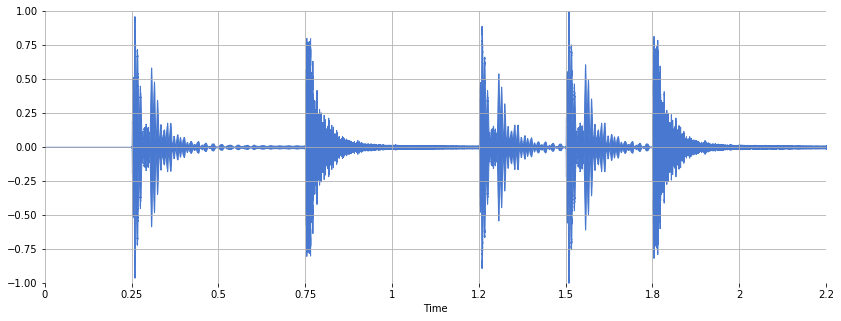

Zoom in, five zero crossings

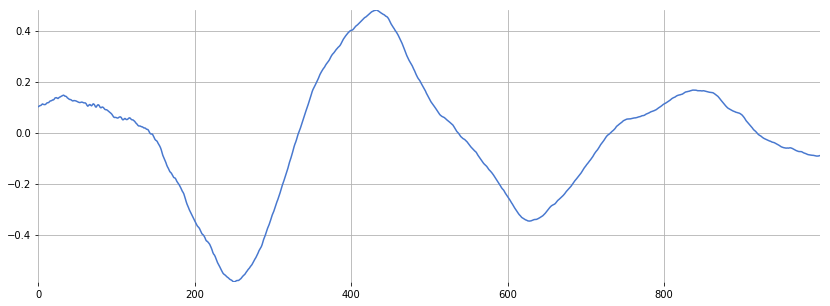

## Mel Frequency Cepstral Coefficients (MFCCs)

## Processing mp3

In [0]:
def extract_info(audio_fpath, audio_fname):
  y, sr = librosa.load(audio_fpath, mono=True, duration=30)
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = librosa.feature.rmse(y=y)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
  to_append = f'{audio_fname} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
  for e in mfcc:
      to_append += f' {np.mean(e)}'
  return to_append

In [0]:
data_file = open('my_train.csv', 'w', newline='')
header = 'id chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 128 + 1):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

with data_file:
  writer = csv.writer(data_file)
  writer.writerow(header)

ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in os.walk('train'):
  for file in sorted(files):
    if file.lower().endswith('.wav'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        info = extract_info(fpath, fname)
        track_id = int(fname)
        genre = train_tracks_data.loc[train_tracks_data['ID'] == track_id]['Class'].values[0]
        info += f' {genre}'
        data_file = open('my_train.csv', 'a', newline='')
        with data_file:
            writer = csv.writer(data_file)
            writer.writerow(info.split())
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      print('OK', file, 'with path:', fpath)
      #ci += 1
      #if ci >= count:
        #reak
    else:
      continue
  #if ci >= count:
    #break

print('Generating data finished! Generated {}/{} successfully'.format(ok_cnt, ok_cnt + fail_cnt))

In [23]:
data_file = open('my_test.csv', 'w', newline='')
header = 'id chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 128 + 1):
    header += f' mfcc{i}'
header = header.split()

with data_file:
  writer = csv.writer(data_file)
  writer.writerow(header)

ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in os.walk('test2'):
  for file in sorted(files):
    if file.lower().endswith('.wav'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        info = extract_info(fpath, fname)
        data_file = open('my_test.csv', 'a', newline='')
        with data_file:
            writer = csv.writer(data_file)
            writer.writerow(info.split())
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      print('OK', file, 'with path:', fpath)
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break

print('Generating data finished! Generated {}/{} successfully'.format(ok_cnt, ok_cnt + fail_cnt))

OK 1002.wav with path: test2/Test/1002.wav
OK 1005.wav with path: test2/Test/1005.wav
OK 1009.wav with path: test2/Test/1009.wav
OK 1010.wav with path: test2/Test/1010.wav
OK 1011.wav with path: test2/Test/1011.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1012.wav with path: test2/Test/1012.wav
OK 1013.wav with path: test2/Test/1013.wav
OK 1016.wav with path: test2/Test/1016.wav
OK 1019.wav with path: test2/Test/1019.wav
OK 102.wav with path: test2/Test/102.wav
OK 1020.wav with path: test2/Test/1020.wav
OK 1023.wav with path: test2/Test/1023.wav
OK 1031.wav with path: test2/Test/1031.wav
OK 1033.wav with path: test2/Test/1033.wav
OK 1035.wav with path: test2/Test/1035.wav
OK 1037.wav with path: test2/Test/1037.wav
OK 1039.wav with path: test2/Test/1039.wav
OK 1041.wav with path: test2/Test/1041.wav
OK 1046.wav with path: test2/Test/1046.wav
OK 1050.wav with path: test2/Test/1050.wav
OK 1053.wav with path: test2/Test/1053.wav
OK 1057.wav with path: test2/Test/1057.wav
OK 106.wav with path: test2/Test/106.wav
OK 1060.wav with path: test2/Test/1060.wav
OK 1064.wav with path: test2/Test/1064.wav
OK 1065.wav with path: test2/Test/1065.wav
OK 1067.wav with path: test2/Test/1067.wav
OK 107.wav with path: test2/Test/107.wav
OK 1073.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1097.wav with path: test2/Test/1097.wav
OK 1099.wav with path: test2/Test/1099.wav
OK 110.wav with path: test2/Test/110.wav
OK 1101.wav with path: test2/Test/1101.wav
OK 1102.wav with path: test2/Test/1102.wav
OK 1103.wav with path: test2/Test/1103.wav
OK 1104.wav with path: test2/Test/1104.wav
OK 1107.wav with path: test2/Test/1107.wav
OK 1108.wav with path: test2/Test/1108.wav
OK 1109.wav with path: test2/Test/1109.wav
OK 111.wav with path: test2/Test/111.wav
OK 1110.wav with path: test2/Test/1110.wav
OK 1111.wav with path: test2/Test/1111.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1114.wav with path: test2/Test/1114.wav
OK 1117.wav with path: test2/Test/1117.wav
OK 112.wav with path: test2/Test/112.wav
OK 1121.wav with path: test2/Test/1121.wav
OK 1122.wav with path: test2/Test/1122.wav
OK 1123.wav with path: test2/Test/1123.wav
OK 1124.wav with path: test2/Test/1124.wav
OK 1125.wav with path: test2/Test/1125.wav
OK 1127.wav with path: test2/Test/1127.wav
OK 1128.wav with path: test2/Test/1128.wav
OK 1130.wav with path: test2/Test/1130.wav
OK 1132.wav with path: test2/Test/1132.wav
OK 1135.wav with path: test2/Test/1135.wav
OK 1136.wav with path: test2/Test/1136.wav
OK 1138.wav with path: test2/Test/1138.wav
OK 1140.wav with path: test2/Test/1140.wav
OK 1141.wav with path: test2/Test/1141.wav
OK 1142.wav with path: test2/Test/1142.wav
OK 1144.wav with path: test2/Test/1144.wav
OK 1146.wav with path: test2/Test/1146.wav
OK 115.wav with path: test2/Test/115.wav
OK 1153.wav with path: test2/Test/1153.wav
OK 1154.wav with path: test2/Test/1154.wav
OK 1155.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1369.wav with path: test2/Test/1369.wav
OK 1372.wav with path: test2/Test/1372.wav
OK 1373.wav with path: test2/Test/1373.wav
OK 1374.wav with path: test2/Test/1374.wav
OK 1375.wav with path: test2/Test/1375.wav
OK 1376.wav with path: test2/Test/1376.wav
OK 1379.wav with path: test2/Test/1379.wav
OK 1382.wav with path: test2/Test/1382.wav
OK 1383.wav with path: test2/Test/1383.wav
OK 1387.wav with path: test2/Test/1387.wav
OK 1389.wav with path: test2/Test/1389.wav
OK 1391.wav with path: test2/Test/1391.wav
OK 1392.wav with path: test2/Test/1392.wav
OK 1395.wav with path: test2/Test/1395.wav
OK 1397.wav with path: test2/Test/1397.wav
OK 14.wav with path: test2/Test/14.wav
OK 1401.wav with path: test2/Test/1401.wav
OK 1402.wav with path: test2/Test/1402.wav
OK 1403.wav with path: test2/Test/1403.wav
OK 1406.wav with path: test2/Test/1406.wav
OK 1407.wav with path: test2/Test/1407.wav
OK 1408.wav with path: test2/Test/1408.wav
OK 141.wav with path: test2/Test/141.wav
OK 1410.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1411.wav with path: test2/Test/1411.wav
OK 1413.wav with path: test2/Test/1413.wav
OK 1416.wav with path: test2/Test/1416.wav
OK 1420.wav with path: test2/Test/1420.wav
OK 1421.wav with path: test2/Test/1421.wav
OK 1422.wav with path: test2/Test/1422.wav
OK 1424.wav with path: test2/Test/1424.wav
OK 1426.wav with path: test2/Test/1426.wav
OK 1427.wav with path: test2/Test/1427.wav
OK 1429.wav with path: test2/Test/1429.wav
OK 143.wav with path: test2/Test/143.wav
OK 1430.wav with path: test2/Test/1430.wav
OK 1433.wav with path: test2/Test/1433.wav
OK 1434.wav with path: test2/Test/1434.wav
OK 1438.wav with path: test2/Test/1438.wav
OK 1439.wav with path: test2/Test/1439.wav
OK 144.wav with path: test2/Test/144.wav
OK 1440.wav with path: test2/Test/1440.wav
OK 1441.wav with path: test2/Test/1441.wav
OK 1442.wav with path: test2/Test/1442.wav
OK 1443.wav with path: test2/Test/1443.wav
OK 1445.wav with path: test2/Test/1445.wav
OK 145.wav with path: test2/Test/145.wav
OK 1451.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1638.wav with path: test2/Test/1638.wav
OK 1641.wav with path: test2/Test/1641.wav
OK 1642.wav with path: test2/Test/1642.wav
OK 1643.wav with path: test2/Test/1643.wav
OK 1644.wav with path: test2/Test/1644.wav
OK 1645.wav with path: test2/Test/1645.wav
OK 1646.wav with path: test2/Test/1646.wav
OK 1650.wav with path: test2/Test/1650.wav
OK 1654.wav with path: test2/Test/1654.wav
OK 1655.wav with path: test2/Test/1655.wav
OK 1657.wav with path: test2/Test/1657.wav
OK 1658.wav with path: test2/Test/1658.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1659.wav with path: test2/Test/1659.wav
OK 166.wav with path: test2/Test/166.wav
OK 1662.wav with path: test2/Test/1662.wav
OK 1665.wav with path: test2/Test/1665.wav
OK 1668.wav with path: test2/Test/1668.wav
OK 1670.wav with path: test2/Test/1670.wav
OK 1671.wav with path: test2/Test/1671.wav
OK 1676.wav with path: test2/Test/1676.wav
OK 1682.wav with path: test2/Test/1682.wav
OK 1683.wav with path: test2/Test/1683.wav
OK 1684.wav with path: test2/Test/1684.wav
OK 1685.wav with path: test2/Test/1685.wav
OK 169.wav with path: test2/Test/169.wav
OK 1691.wav with path: test2/Test/1691.wav
OK 1692.wav with path: test2/Test/1692.wav
OK 1693.wav with path: test2/Test/1693.wav
OK 1694.wav with path: test2/Test/1694.wav
OK 1696.wav with path: test2/Test/1696.wav
OK 1698.wav with path: test2/Test/1698.wav
OK 1700.wav with path: test2/Test/1700.wav
OK 1707.wav with path: test2/Test/1707.wav
OK 1710.wav with path: test2/Test/1710.wav
OK 1712.wav with path: test2/Test/1712.wav
OK 1717.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1742.wav with path: test2/Test/1742.wav
OK 1743.wav with path: test2/Test/1743.wav
OK 1747.wav with path: test2/Test/1747.wav
OK 1752.wav with path: test2/Test/1752.wav
OK 1753.wav with path: test2/Test/1753.wav
OK 1756.wav with path: test2/Test/1756.wav
OK 1757.wav with path: test2/Test/1757.wav
OK 1758.wav with path: test2/Test/1758.wav
OK 1759.wav with path: test2/Test/1759.wav
OK 1762.wav with path: test2/Test/1762.wav
OK 1764.wav with path: test2/Test/1764.wav
OK 177.wav with path: test2/Test/177.wav
OK 1770.wav with path: test2/Test/1770.wav
OK 1772.wav with path: test2/Test/1772.wav
OK 1775.wav with path: test2/Test/1775.wav
OK 1778.wav with path: test2/Test/1778.wav
OK 1781.wav with path: test2/Test/1781.wav
OK 1784.wav with path: test2/Test/1784.wav
OK 1785.wav with path: test2/Test/1785.wav
OK 1788.wav with path: test2/Test/1788.wav
OK 1790.wav with path: test2/Test/1790.wav
OK 1793.wav with path: test2/Test/1793.wav
OK 1797.wav with path: test2/Test/1797.wav
OK 1798.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 207.wav with path: test2/Test/207.wav
OK 2071.wav with path: test2/Test/2071.wav
OK 2074.wav with path: test2/Test/2074.wav
OK 2075.wav with path: test2/Test/2075.wav
OK 2076.wav with path: test2/Test/2076.wav
OK 2079.wav with path: test2/Test/2079.wav
OK 2085.wav with path: test2/Test/2085.wav
OK 2086.wav with path: test2/Test/2086.wav
OK 2088.wav with path: test2/Test/2088.wav
OK 209.wav with path: test2/Test/209.wav
OK 2092.wav with path: test2/Test/2092.wav
OK 2093.wav with path: test2/Test/2093.wav
OK 2097.wav with path: test2/Test/2097.wav
OK 21.wav with path: test2/Test/21.wav
OK 210.wav with path: test2/Test/210.wav
OK 2100.wav with path: test2/Test/2100.wav
OK 2109.wav with path: test2/Test/2109.wav
OK 2110.wav with path: test2/Test/2110.wav
OK 2111.wav with path: test2/Test/2111.wav
OK 2112.wav with path: test2/Test/2112.wav
OK 2114.wav with path: test2/Test/2114.wav
OK 2115.wav with path: test2/Test/2115.wav
OK 2118.wav with path: test2/Test/2118.wav
OK 2119.wav with path

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2208.wav with path: test2/Test/2208.wav
OK 2211.wav with path: test2/Test/2211.wav
OK 2213.wav with path: test2/Test/2213.wav
OK 2214.wav with path: test2/Test/2214.wav
OK 2215.wav with path: test2/Test/2215.wav
OK 2221.wav with path: test2/Test/2221.wav
OK 2222.wav with path: test2/Test/2222.wav
OK 2223.wav with path: test2/Test/2223.wav
OK 2231.wav with path: test2/Test/2231.wav
OK 2232.wav with path: test2/Test/2232.wav
OK 2234.wav with path: test2/Test/2234.wav
OK 2239.wav with path: test2/Test/2239.wav
OK 2242.wav with path: test2/Test/2242.wav
OK 2243.wav with path: test2/Test/2243.wav
OK 2245.wav with path: test2/Test/2245.wav
OK 2248.wav with path: test2/Test/2248.wav
OK 225.wav with path: test2/Test/225.wav
OK 2255.wav with path: test2/Test/2255.wav
OK 2257.wav with path: test2/Test/2257.wav
OK 2261.wav with path: test2/Test/2261.wav
OK 2263.wav with path: test2/Test/2263.wav
OK 2266.wav with path: test2/Test/2266.wav
OK 2267.wav with path: test2/Test/2267.wav
OK 2268.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2311.wav with path: test2/Test/2311.wav
OK 2315.wav with path: test2/Test/2315.wav
OK 2316.wav with path: test2/Test/2316.wav
OK 2317.wav with path: test2/Test/2317.wav
OK 2320.wav with path: test2/Test/2320.wav
OK 2321.wav with path: test2/Test/2321.wav
OK 2322.wav with path: test2/Test/2322.wav
OK 2325.wav with path: test2/Test/2325.wav
OK 2326.wav with path: test2/Test/2326.wav
OK 2328.wav with path: test2/Test/2328.wav
OK 2331.wav with path: test2/Test/2331.wav
OK 2334.wav with path: test2/Test/2334.wav
OK 2336.wav with path: test2/Test/2336.wav
OK 2337.wav with path: test2/Test/2337.wav
OK 234.wav with path: test2/Test/234.wav
OK 2341.wav with path: test2/Test/2341.wav
OK 2342.wav with path: test2/Test/2342.wav
OK 2346.wav with path: test2/Test/2346.wav
OK 2348.wav with path: test2/Test/2348.wav
OK 2350.wav with path: test2/Test/2350.wav
OK 2352.wav with path: test2/Test/2352.wav
OK 2355.wav with path: test2/Test/2355.wav
OK 2356.wav with path: test2/Test/2356.wav
OK 2357.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 241.wav with path: test2/Test/241.wav
OK 2417.wav with path: test2/Test/2417.wav
OK 2422.wav with path: test2/Test/2422.wav
OK 2423.wav with path: test2/Test/2423.wav
OK 2426.wav with path: test2/Test/2426.wav
OK 2429.wav with path: test2/Test/2429.wav
OK 243.wav with path: test2/Test/243.wav
OK 2431.wav with path: test2/Test/2431.wav
OK 2434.wav with path: test2/Test/2434.wav
OK 2435.wav with path: test2/Test/2435.wav
OK 2436.wav with path: test2/Test/2436.wav
OK 2437.wav with path: test2/Test/2437.wav
OK 244.wav with path: test2/Test/244.wav
OK 2440.wav with path: test2/Test/2440.wav
OK 2442.wav with path: test2/Test/2442.wav
OK 2451.wav with path: test2/Test/2451.wav
OK 2457.wav with path: test2/Test/2457.wav
OK 2459.wav with path: test2/Test/2459.wav
OK 2467.wav with path: test2/Test/2467.wav
OK 2469.wav with path: test2/Test/2469.wav
OK 2471.wav with path: test2/Test/2471.wav
OK 2472.wav with path: test2/Test/2472.wav
OK 2475.wav with path: test2/Test/2475.wav
OK 2476.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2737.wav with path: test2/Test/2737.wav
OK 274.wav with path: test2/Test/274.wav
OK 2742.wav with path: test2/Test/2742.wav
OK 2743.wav with path: test2/Test/2743.wav
OK 2745.wav with path: test2/Test/2745.wav
OK 2748.wav with path: test2/Test/2748.wav
OK 2749.wav with path: test2/Test/2749.wav
OK 2753.wav with path: test2/Test/2753.wav
OK 2755.wav with path: test2/Test/2755.wav
OK 2758.wav with path: test2/Test/2758.wav
OK 2759.wav with path: test2/Test/2759.wav
OK 2761.wav with path: test2/Test/2761.wav
OK 2762.wav with path: test2/Test/2762.wav
OK 2767.wav with path: test2/Test/2767.wav
OK 2768.wav with path: test2/Test/2768.wav
OK 2772.wav with path: test2/Test/2772.wav
OK 2777.wav with path: test2/Test/2777.wav
OK 2778.wav with path: test2/Test/2778.wav
OK 2782.wav with path: test2/Test/2782.wav
OK 2786.wav with path: test2/Test/2786.wav
OK 279.wav with path: test2/Test/279.wav
OK 2793.wav with path: test2/Test/2793.wav
OK 2796.wav with path: test2/Test/2796.wav
OK 2798.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 28.wav with path: test2/Test/28.wav
OK 2803.wav with path: test2/Test/2803.wav
OK 2804.wav with path: test2/Test/2804.wav
OK 2806.wav with path: test2/Test/2806.wav
OK 2809.wav with path: test2/Test/2809.wav
OK 281.wav with path: test2/Test/281.wav
OK 2810.wav with path: test2/Test/2810.wav
OK 2812.wav with path: test2/Test/2812.wav
OK 2814.wav with path: test2/Test/2814.wav
OK 2816.wav with path: test2/Test/2816.wav
OK 2817.wav with path: test2/Test/2817.wav
OK 2818.wav with path: test2/Test/2818.wav
OK 2820.wav with path: test2/Test/2820.wav
OK 2822.wav with path: test2/Test/2822.wav
OK 2823.wav with path: test2/Test/2823.wav
OK 2826.wav with path: test2/Test/2826.wav
OK 2827.wav with path: test2/Test/2827.wav
OK 283.wav with path: test2/Test/283.wav
OK 2833.wav with path: test2/Test/2833.wav
OK 2834.wav with path: test2/Test/2834.wav
OK 2838.wav with path: test2/Test/2838.wav
OK 2839.wav with path: test2/Test/2839.wav
OK 284.wav with path: test2/Test/284.wav
OK 2841.wav with path

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2847.wav with path: test2/Test/2847.wav
OK 2848.wav with path: test2/Test/2848.wav
OK 2852.wav with path: test2/Test/2852.wav
OK 2853.wav with path: test2/Test/2853.wav
OK 2856.wav with path: test2/Test/2856.wav
OK 2859.wav with path: test2/Test/2859.wav
OK 2860.wav with path: test2/Test/2860.wav
OK 2861.wav with path: test2/Test/2861.wav
OK 2866.wav with path: test2/Test/2866.wav
OK 2867.wav with path: test2/Test/2867.wav
OK 2868.wav with path: test2/Test/2868.wav
OK 287.wav with path: test2/Test/287.wav
OK 2874.wav with path: test2/Test/2874.wav
OK 2876.wav with path: test2/Test/2876.wav
OK 2877.wav with path: test2/Test/2877.wav
OK 2879.wav with path: test2/Test/2879.wav
OK 2880.wav with path: test2/Test/2880.wav
OK 2882.wav with path: test2/Test/2882.wav
OK 2883.wav with path: test2/Test/2883.wav
OK 2885.wav with path: test2/Test/2885.wav
OK 2886.wav with path: test2/Test/2886.wav
OK 2888.wav with path: test2/Test/2888.wav
OK 289.wav with path: test2/Test/289.wav
OK 2893.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2964.wav with path: test2/Test/2964.wav
OK 2965.wav with path: test2/Test/2965.wav
OK 2967.wav with path: test2/Test/2967.wav
OK 2968.wav with path: test2/Test/2968.wav
OK 297.wav with path: test2/Test/297.wav
OK 2970.wav with path: test2/Test/2970.wav
OK 2973.wav with path: test2/Test/2973.wav
OK 2975.wav with path: test2/Test/2975.wav
OK 2977.wav with path: test2/Test/2977.wav
OK 2978.wav with path: test2/Test/2978.wav
OK 2979.wav with path: test2/Test/2979.wav
OK 298.wav with path: test2/Test/298.wav
OK 2981.wav with path: test2/Test/2981.wav
OK 2985.wav with path: test2/Test/2985.wav
OK 2990.wav with path: test2/Test/2990.wav
OK 2999.wav with path: test2/Test/2999.wav
OK 30.wav with path: test2/Test/30.wav
OK 3000.wav with path: test2/Test/3000.wav
OK 3002.wav with path: test2/Test/3002.wav
OK 3005.wav with path: test2/Test/3005.wav
OK 3007.wav with path: test2/Test/3007.wav
OK 3009.wav with path: test2/Test/3009.wav
OK 3010.wav with path: test2/Test/3010.wav
OK 3015.wav with pa

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3023.wav with path: test2/Test/3023.wav
OK 3025.wav with path: test2/Test/3025.wav
OK 3028.wav with path: test2/Test/3028.wav
OK 3029.wav with path: test2/Test/3029.wav
OK 3031.wav with path: test2/Test/3031.wav
OK 3035.wav with path: test2/Test/3035.wav
OK 3039.wav with path: test2/Test/3039.wav
OK 3040.wav with path: test2/Test/3040.wav
OK 3041.wav with path: test2/Test/3041.wav
OK 3043.wav with path: test2/Test/3043.wav
OK 3044.wav with path: test2/Test/3044.wav
OK 3045.wav with path: test2/Test/3045.wav
OK 3047.wav with path: test2/Test/3047.wav
OK 3048.wav with path: test2/Test/3048.wav
OK 3049.wav with path: test2/Test/3049.wav
OK 3053.wav with path: test2/Test/3053.wav
OK 3057.wav with path: test2/Test/3057.wav
OK 3058.wav with path: test2/Test/3058.wav
OK 3059.wav with path: test2/Test/3059.wav
OK 3064.wav with path: test2/Test/3064.wav
OK 3065.wav with path: test2/Test/3065.wav
OK 3067.wav with path: test2/Test/3067.wav
OK 3072.wav with path: test2/Test/3072.wav
OK 3073.wav

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3100.wav with path: test2/Test/3100.wav
OK 3106.wav with path: test2/Test/3106.wav
OK 3107.wav with path: test2/Test/3107.wav
OK 3109.wav with path: test2/Test/3109.wav
OK 3111.wav with path: test2/Test/3111.wav
OK 3113.wav with path: test2/Test/3113.wav
OK 3114.wav with path: test2/Test/3114.wav
OK 3116.wav with path: test2/Test/3116.wav
OK 3119.wav with path: test2/Test/3119.wav
OK 3122.wav with path: test2/Test/3122.wav
OK 3124.wav with path: test2/Test/3124.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3129.wav with path: test2/Test/3129.wav
OK 3132.wav with path: test2/Test/3132.wav
OK 3134.wav with path: test2/Test/3134.wav
OK 3137.wav with path: test2/Test/3137.wav
OK 3139.wav with path: test2/Test/3139.wav
OK 3141.wav with path: test2/Test/3141.wav
OK 3142.wav with path: test2/Test/3142.wav
OK 3145.wav with path: test2/Test/3145.wav
OK 3149.wav with path: test2/Test/3149.wav
OK 3158.wav with path: test2/Test/3158.wav
OK 3166.wav with path: test2/Test/3166.wav
OK 3173.wav with path: test2/Test/3173.wav
OK 3174.wav with path: test2/Test/3174.wav
OK 3175.wav with path: test2/Test/3175.wav
OK 3181.wav with path: test2/Test/3181.wav
OK 3183.wav with path: test2/Test/3183.wav
OK 3184.wav with path: test2/Test/3184.wav
OK 3193.wav with path: test2/Test/3193.wav
OK 3198.wav with path: test2/Test/3198.wav
OK 320.wav with path: test2/Test/320.wav
OK 3201.wav with path: test2/Test/3201.wav
OK 3203.wav with path: test2/Test/3203.wav
OK 3204.wav with path: test2/Test/3204.wav
OK 3208.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3224.wav with path: test2/Test/3224.wav
OK 3228.wav with path: test2/Test/3228.wav
OK 3234.wav with path: test2/Test/3234.wav
OK 3241.wav with path: test2/Test/3241.wav
OK 3242.wav with path: test2/Test/3242.wav
OK 3243.wav with path: test2/Test/3243.wav
OK 3245.wav with path: test2/Test/3245.wav
OK 3247.wav with path: test2/Test/3247.wav
OK 3249.wav with path: test2/Test/3249.wav
OK 325.wav with path: test2/Test/325.wav
OK 3251.wav with path: test2/Test/3251.wav
OK 3252.wav with path: test2/Test/3252.wav
OK 3253.wav with path: test2/Test/3253.wav
OK 3255.wav with path: test2/Test/3255.wav
OK 3256.wav with path: test2/Test/3256.wav
OK 3260.wav with path: test2/Test/3260.wav
OK 3263.wav with path: test2/Test/3263.wav
OK 3265.wav with path: test2/Test/3265.wav
OK 3269.wav with path: test2/Test/3269.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3274.wav with path: test2/Test/3274.wav
OK 3280.wav with path: test2/Test/3280.wav
OK 3282.wav with path: test2/Test/3282.wav
OK 3284.wav with path: test2/Test/3284.wav
OK 3287.wav with path: test2/Test/3287.wav
OK 3289.wav with path: test2/Test/3289.wav
OK 3290.wav with path: test2/Test/3290.wav
OK 3295.wav with path: test2/Test/3295.wav
OK 3300.wav with path: test2/Test/3300.wav
OK 3303.wav with path: test2/Test/3303.wav
OK 3304.wav with path: test2/Test/3304.wav
OK 3309.wav with path: test2/Test/3309.wav
OK 3311.wav with path: test2/Test/3311.wav
OK 3312.wav with path: test2/Test/3312.wav
OK 3313.wav with path: test2/Test/3313.wav
OK 3314.wav with path: test2/Test/3314.wav
OK 3315.wav with path: test2/Test/3315.wav
OK 3326.wav with path: test2/Test/3326.wav
OK 3327.wav with path: test2/Test/3327.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3329.wav with path: test2/Test/3329.wav
OK 3335.wav with path: test2/Test/3335.wav
OK 3339.wav with path: test2/Test/3339.wav
OK 3340.wav with path: test2/Test/3340.wav
OK 3341.wav with path: test2/Test/3341.wav
OK 3342.wav with path: test2/Test/3342.wav
OK 3346.wav with path: test2/Test/3346.wav
OK 3348.wav with path: test2/Test/3348.wav
OK 3356.wav with path: test2/Test/3356.wav
OK 3359.wav with path: test2/Test/3359.wav
OK 3361.wav with path: test2/Test/3361.wav
OK 3366.wav with path: test2/Test/3366.wav
OK 3368.wav with path: test2/Test/3368.wav
OK 3372.wav with path: test2/Test/3372.wav
OK 3374.wav with path: test2/Test/3374.wav
OK 3377.wav with path: test2/Test/3377.wav
OK 3378.wav with path: test2/Test/3378.wav
OK 3380.wav with path: test2/Test/3380.wav
OK 3382.wav with path: test2/Test/3382.wav
OK 3384.wav with path: test2/Test/3384.wav
OK 3385.wav with path: test2/Test/3385.wav
OK 3386.wav with path: test2/Test/3386.wav
OK 3391.wav with path: test2/Test/3391.wav
OK 3393.wav

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3468.wav with path: test2/Test/3468.wav
OK 3472.wav with path: test2/Test/3472.wav
OK 3476.wav with path: test2/Test/3476.wav
OK 3479.wav with path: test2/Test/3479.wav
OK 3484.wav with path: test2/Test/3484.wav
OK 3485.wav with path: test2/Test/3485.wav
OK 3487.wav with path: test2/Test/3487.wav
OK 3488.wav with path: test2/Test/3488.wav
OK 3490.wav with path: test2/Test/3490.wav
OK 3494.wav with path: test2/Test/3494.wav
OK 3497.wav with path: test2/Test/3497.wav
OK 3498.wav with path: test2/Test/3498.wav
OK 3500.wav with path: test2/Test/3500.wav
OK 3502.wav with path: test2/Test/3502.wav
OK 3505.wav with path: test2/Test/3505.wav
OK 3506.wav with path: test2/Test/3506.wav
OK 3511.wav with path: test2/Test/3511.wav
OK 3512.wav with path: test2/Test/3512.wav
OK 3513.wav with path: test2/Test/3513.wav
OK 3521.wav with path: test2/Test/3521.wav
OK 3524.wav with path: test2/Test/3524.wav
OK 3527.wav with path: test2/Test/3527.wav
OK 3530.wav with path: test2/Test/3530.wav
OK 3532.wav

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3552.wav with path: test2/Test/3552.wav
OK 3553.wav with path: test2/Test/3553.wav
OK 3557.wav with path: test2/Test/3557.wav
OK 3558.wav with path: test2/Test/3558.wav
OK 3559.wav with path: test2/Test/3559.wav
OK 3562.wav with path: test2/Test/3562.wav
OK 3563.wav with path: test2/Test/3563.wav
OK 3564.wav with path: test2/Test/3564.wav
OK 3565.wav with path: test2/Test/3565.wav
OK 3570.wav with path: test2/Test/3570.wav
OK 3571.wav with path: test2/Test/3571.wav
OK 3572.wav with path: test2/Test/3572.wav
OK 3573.wav with path: test2/Test/3573.wav
OK 3575.wav with path: test2/Test/3575.wav
OK 3576.wav with path: test2/Test/3576.wav
OK 3578.wav with path: test2/Test/3578.wav
OK 3581.wav with path: test2/Test/3581.wav
OK 3586.wav with path: test2/Test/3586.wav
OK 3589.wav with path: test2/Test/3589.wav
OK 3592.wav with path: test2/Test/3592.wav
OK 3593.wav with path: test2/Test/3593.wav
OK 3594.wav with path: test2/Test/3594.wav
OK 3600.wav with path: test2/Test/3600.wav
OK 3601.wav

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3615.wav with path: test2/Test/3615.wav
OK 3616.wav with path: test2/Test/3616.wav
OK 3617.wav with path: test2/Test/3617.wav
OK 3618.wav with path: test2/Test/3618.wav
OK 362.wav with path: test2/Test/362.wav
OK 3620.wav with path: test2/Test/3620.wav
OK 3623.wav with path: test2/Test/3623.wav
OK 3625.wav with path: test2/Test/3625.wav
OK 3631.wav with path: test2/Test/3631.wav
OK 3633.wav with path: test2/Test/3633.wav
OK 3635.wav with path: test2/Test/3635.wav
OK 3636.wav with path: test2/Test/3636.wav
OK 3638.wav with path: test2/Test/3638.wav
OK 3641.wav with path: test2/Test/3641.wav
OK 3643.wav with path: test2/Test/3643.wav
OK 3650.wav with path: test2/Test/3650.wav
OK 3651.wav with path: test2/Test/3651.wav
OK 3655.wav with path: test2/Test/3655.wav
OK 3665.wav with path: test2/Test/3665.wav
OK 3667.wav with path: test2/Test/3667.wav
OK 3673.wav with path: test2/Test/3673.wav
OK 3677.wav with path: test2/Test/3677.wav
OK 3684.wav with path: test2/Test/3684.wav
OK 3690.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3789.wav with path: test2/Test/3789.wav
OK 379.wav with path: test2/Test/379.wav
OK 3793.wav with path: test2/Test/3793.wav
OK 3794.wav with path: test2/Test/3794.wav
OK 3795.wav with path: test2/Test/3795.wav
OK 3796.wav with path: test2/Test/3796.wav
OK 3797.wav with path: test2/Test/3797.wav
OK 3801.wav with path: test2/Test/3801.wav
OK 3802.wav with path: test2/Test/3802.wav
OK 3804.wav with path: test2/Test/3804.wav
OK 3807.wav with path: test2/Test/3807.wav
OK 3809.wav with path: test2/Test/3809.wav
OK 3810.wav with path: test2/Test/3810.wav
OK 3812.wav with path: test2/Test/3812.wav
OK 3814.wav with path: test2/Test/3814.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3815.wav with path: test2/Test/3815.wav
OK 3817.wav with path: test2/Test/3817.wav
OK 3818.wav with path: test2/Test/3818.wav
OK 3824.wav with path: test2/Test/3824.wav
OK 3825.wav with path: test2/Test/3825.wav
OK 3826.wav with path: test2/Test/3826.wav
OK 3829.wav with path: test2/Test/3829.wav
OK 3831.wav with path: test2/Test/3831.wav
OK 3832.wav with path: test2/Test/3832.wav
OK 3835.wav with path: test2/Test/3835.wav
OK 3837.wav with path: test2/Test/3837.wav
OK 384.wav with path: test2/Test/384.wav
OK 3841.wav with path: test2/Test/3841.wav
OK 3845.wav with path: test2/Test/3845.wav
OK 3849.wav with path: test2/Test/3849.wav
OK 3852.wav with path: test2/Test/3852.wav
OK 3856.wav with path: test2/Test/3856.wav
OK 3857.wav with path: test2/Test/3857.wav
OK 3858.wav with path: test2/Test/3858.wav
OK 3862.wav with path: test2/Test/3862.wav
OK 3865.wav with path: test2/Test/3865.wav
OK 3867.wav with path: test2/Test/3867.wav
OK 387.wav with path: test2/Test/387.wav
OK 3872.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3954.wav with path: test2/Test/3954.wav
OK 3957.wav with path: test2/Test/3957.wav
OK 3958.wav with path: test2/Test/3958.wav
OK 3961.wav with path: test2/Test/3961.wav
OK 3963.wav with path: test2/Test/3963.wav
OK 3964.wav with path: test2/Test/3964.wav
OK 3971.wav with path: test2/Test/3971.wav
OK 3974.wav with path: test2/Test/3974.wav
OK 3976.wav with path: test2/Test/3976.wav
OK 3977.wav with path: test2/Test/3977.wav
OK 3979.wav with path: test2/Test/3979.wav
OK 398.wav with path: test2/Test/398.wav
OK 3980.wav with path: test2/Test/3980.wav
OK 3989.wav with path: test2/Test/3989.wav
OK 399.wav with path: test2/Test/399.wav
OK 3990.wav with path: test2/Test/3990.wav
OK 3991.wav with path: test2/Test/3991.wav
OK 3995.wav with path: test2/Test/3995.wav
OK 3996.wav with path: test2/Test/3996.wav
OK 4005.wav with path: test2/Test/4005.wav
OK 4007.wav with path: test2/Test/4007.wav
OK 4008.wav with path: test2/Test/4008.wav
OK 4013.wav with path: test2/Test/4013.wav
OK 4016.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4185.wav with path: test2/Test/4185.wav
OK 4186.wav with path: test2/Test/4186.wav
OK 4187.wav with path: test2/Test/4187.wav
OK 4188.wav with path: test2/Test/4188.wav
OK 4192.wav with path: test2/Test/4192.wav
OK 4194.wav with path: test2/Test/4194.wav
OK 4195.wav with path: test2/Test/4195.wav
OK 4196.wav with path: test2/Test/4196.wav
OK 420.wav with path: test2/Test/420.wav
OK 4202.wav with path: test2/Test/4202.wav
OK 4208.wav with path: test2/Test/4208.wav
OK 4209.wav with path: test2/Test/4209.wav
OK 421.wav with path: test2/Test/421.wav
OK 4211.wav with path: test2/Test/4211.wav
OK 4212.wav with path: test2/Test/4212.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4213.wav with path: test2/Test/4213.wav
OK 4214.wav with path: test2/Test/4214.wav
OK 4215.wav with path: test2/Test/4215.wav
OK 4219.wav with path: test2/Test/4219.wav
OK 422.wav with path: test2/Test/422.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4221.wav with path: test2/Test/4221.wav
OK 4223.wav with path: test2/Test/4223.wav
OK 4225.wav with path: test2/Test/4225.wav
OK 4229.wav with path: test2/Test/4229.wav
OK 4230.wav with path: test2/Test/4230.wav
OK 4233.wav with path: test2/Test/4233.wav
OK 4237.wav with path: test2/Test/4237.wav
OK 4238.wav with path: test2/Test/4238.wav
OK 424.wav with path: test2/Test/424.wav
OK 4240.wav with path: test2/Test/4240.wav
OK 4243.wav with path: test2/Test/4243.wav
OK 4245.wav with path: test2/Test/4245.wav
OK 4250.wav with path: test2/Test/4250.wav
OK 4251.wav with path: test2/Test/4251.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4258.wav with path: test2/Test/4258.wav
OK 4259.wav with path: test2/Test/4259.wav
OK 4261.wav with path: test2/Test/4261.wav
OK 4264.wav with path: test2/Test/4264.wav
OK 4266.wav with path: test2/Test/4266.wav
OK 4268.wav with path: test2/Test/4268.wav
OK 4269.wav with path: test2/Test/4269.wav
OK 4270.wav with path: test2/Test/4270.wav
OK 4271.wav with path: test2/Test/4271.wav
OK 4275.wav with path: test2/Test/4275.wav
OK 4276.wav with path: test2/Test/4276.wav
OK 4280.wav with path: test2/Test/4280.wav
OK 4282.wav with path: test2/Test/4282.wav
OK 4283.wav with path: test2/Test/4283.wav
OK 4284.wav with path: test2/Test/4284.wav
OK 4292.wav with path: test2/Test/4292.wav
OK 4294.wav with path: test2/Test/4294.wav
OK 4295.wav with path: test2/Test/4295.wav
OK 4296.wav with path: test2/Test/4296.wav
OK 4298.wav with path: test2/Test/4298.wav
OK 4300.wav with path: test2/Test/4300.wav
OK 4302.wav with path: test2/Test/4302.wav
OK 4304.wav with path: test2/Test/4304.wav
OK 4305.wav

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4310.wav with path: test2/Test/4310.wav
OK 4312.wav with path: test2/Test/4312.wav
OK 4315.wav with path: test2/Test/4315.wav
OK 4318.wav with path: test2/Test/4318.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 432.wav with path: test2/Test/432.wav
OK 4321.wav with path: test2/Test/4321.wav
OK 4322.wav with path: test2/Test/4322.wav
OK 4325.wav with path: test2/Test/4325.wav
OK 4329.wav with path: test2/Test/4329.wav
OK 433.wav with path: test2/Test/433.wav
OK 4330.wav with path: test2/Test/4330.wav
OK 4332.wav with path: test2/Test/4332.wav
OK 4334.wav with path: test2/Test/4334.wav
OK 4336.wav with path: test2/Test/4336.wav
OK 4339.wav with path: test2/Test/4339.wav
OK 434.wav with path: test2/Test/434.wav
OK 4340.wav with path: test2/Test/4340.wav
OK 4342.wav with path: test2/Test/4342.wav
OK 4343.wav with path: test2/Test/4343.wav
OK 4344.wav with path: test2/Test/4344.wav
OK 4345.wav with path: test2/Test/4345.wav
OK 4347.wav with path: test2/Test/4347.wav
OK 4348.wav with path: test2/Test/4348.wav
OK 4354.wav with path: test2/Test/4354.wav
OK 4355.wav with path: test2/Test/4355.wav
OK 4357.wav with path: test2/Test/4357.wav
OK 4360.wav with path: test2/Test/4360.wav
OK 4368.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4388.wav with path: test2/Test/4388.wav
OK 439.wav with path: test2/Test/439.wav
OK 4391.wav with path: test2/Test/4391.wav
OK 4395.wav with path: test2/Test/4395.wav
OK 4398.wav with path: test2/Test/4398.wav
OK 4399.wav with path: test2/Test/4399.wav
OK 4402.wav with path: test2/Test/4402.wav
OK 4403.wav with path: test2/Test/4403.wav
OK 4404.wav with path: test2/Test/4404.wav
OK 4405.wav with path: test2/Test/4405.wav
OK 4407.wav with path: test2/Test/4407.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4409.wav with path: test2/Test/4409.wav
OK 441.wav with path: test2/Test/441.wav
OK 4410.wav with path: test2/Test/4410.wav
OK 4414.wav with path: test2/Test/4414.wav
OK 4419.wav with path: test2/Test/4419.wav
OK 4421.wav with path: test2/Test/4421.wav
OK 4423.wav with path: test2/Test/4423.wav
OK 443.wav with path: test2/Test/443.wav
OK 4434.wav with path: test2/Test/4434.wav
OK 4435.wav with path: test2/Test/4435.wav
OK 4441.wav with path: test2/Test/4441.wav
OK 4445.wav with path: test2/Test/4445.wav
OK 4447.wav with path: test2/Test/4447.wav
OK 4448.wav with path: test2/Test/4448.wav
OK 4452.wav with path: test2/Test/4452.wav
OK 4455.wav with path: test2/Test/4455.wav
OK 4457.wav with path: test2/Test/4457.wav
OK 4460.wav with path: test2/Test/4460.wav
OK 4465.wav with path: test2/Test/4465.wav
OK 4466.wav with path: test2/Test/4466.wav
OK 4468.wav with path: test2/Test/4468.wav
OK 4469.wav with path: test2/Test/4469.wav
OK 4470.wav with path: test2/Test/4470.wav
OK 4471.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4496.wav with path: test2/Test/4496.wav
OK 4497.wav with path: test2/Test/4497.wav
OK 4501.wav with path: test2/Test/4501.wav
OK 4505.wav with path: test2/Test/4505.wav
OK 4507.wav with path: test2/Test/4507.wav
OK 4508.wav with path: test2/Test/4508.wav
OK 451.wav with path: test2/Test/451.wav
OK 4512.wav with path: test2/Test/4512.wav
OK 4516.wav with path: test2/Test/4516.wav
OK 4517.wav with path: test2/Test/4517.wav
OK 4518.wav with path: test2/Test/4518.wav
OK 4519.wav with path: test2/Test/4519.wav
OK 4520.wav with path: test2/Test/4520.wav
OK 4524.wav with path: test2/Test/4524.wav
OK 4533.wav with path: test2/Test/4533.wav
OK 4537.wav with path: test2/Test/4537.wav
OK 4538.wav with path: test2/Test/4538.wav
OK 4543.wav with path: test2/Test/4543.wav
OK 4544.wav with path: test2/Test/4544.wav
OK 4546.wav with path: test2/Test/4546.wav
OK 4548.wav with path: test2/Test/4548.wav
OK 4550.wav with path: test2/Test/4550.wav
OK 4551.wav with path: test2/Test/4551.wav
OK 4552.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4656.wav with path: test2/Test/4656.wav
OK 466.wav with path: test2/Test/466.wav
OK 4660.wav with path: test2/Test/4660.wav
OK 4664.wav with path: test2/Test/4664.wav
OK 4670.wav with path: test2/Test/4670.wav
OK 4671.wav with path: test2/Test/4671.wav
OK 4673.wav with path: test2/Test/4673.wav
OK 4675.wav with path: test2/Test/4675.wav
OK 4678.wav with path: test2/Test/4678.wav
OK 4681.wav with path: test2/Test/4681.wav
OK 4687.wav with path: test2/Test/4687.wav
OK 4689.wav with path: test2/Test/4689.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 469.wav with path: test2/Test/469.wav
OK 4691.wav with path: test2/Test/4691.wav
OK 4694.wav with path: test2/Test/4694.wav
OK 4696.wav with path: test2/Test/4696.wav
OK 4699.wav with path: test2/Test/4699.wav
OK 4700.wav with path: test2/Test/4700.wav
OK 4701.wav with path: test2/Test/4701.wav
OK 4706.wav with path: test2/Test/4706.wav
OK 4709.wav with path: test2/Test/4709.wav
OK 4710.wav with path: test2/Test/4710.wav
OK 4711.wav with path: test2/Test/4711.wav
OK 4712.wav with path: test2/Test/4712.wav
OK 4713.wav with path: test2/Test/4713.wav
OK 4717.wav with path: test2/Test/4717.wav
OK 4719.wav with path: test2/Test/4719.wav
OK 4720.wav with path: test2/Test/4720.wav
OK 4727.wav with path: test2/Test/4727.wav
OK 4731.wav with path: test2/Test/4731.wav
OK 4734.wav with path: test2/Test/4734.wav
OK 4738.wav with path: test2/Test/4738.wav
OK 4744.wav with path: test2/Test/4744.wav
OK 4751.wav with path: test2/Test/4751.wav
OK 4757.wav with path: test2/Test/4757.wav
OK 476.wav wi

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5083.wav with path: test2/Test/5083.wav
OK 5086.wav with path: test2/Test/5086.wav
OK 5087.wav with path: test2/Test/5087.wav
OK 5090.wav with path: test2/Test/5090.wav
OK 5091.wav with path: test2/Test/5091.wav
OK 5093.wav with path: test2/Test/5093.wav
OK 5097.wav with path: test2/Test/5097.wav
OK 5098.wav with path: test2/Test/5098.wav
OK 51.wav with path: test2/Test/51.wav
OK 510.wav with path: test2/Test/510.wav
OK 5101.wav with path: test2/Test/5101.wav
OK 5102.wav with path: test2/Test/5102.wav
OK 5104.wav with path: test2/Test/5104.wav
OK 5105.wav with path: test2/Test/5105.wav
OK 5108.wav with path: test2/Test/5108.wav
OK 5111.wav with path: test2/Test/5111.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5113.wav with path: test2/Test/5113.wav
OK 5115.wav with path: test2/Test/5115.wav
OK 5116.wav with path: test2/Test/5116.wav
OK 5120.wav with path: test2/Test/5120.wav
OK 5123.wav with path: test2/Test/5123.wav
OK 5124.wav with path: test2/Test/5124.wav
OK 5126.wav with path: test2/Test/5126.wav
OK 5131.wav with path: test2/Test/5131.wav
OK 5136.wav with path: test2/Test/5136.wav
OK 5137.wav with path: test2/Test/5137.wav
OK 5139.wav with path: test2/Test/5139.wav
OK 514.wav with path: test2/Test/514.wav
OK 5143.wav with path: test2/Test/5143.wav
OK 5144.wav with path: test2/Test/5144.wav
OK 5145.wav with path: test2/Test/5145.wav
OK 5150.wav with path: test2/Test/5150.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5152.wav with path: test2/Test/5152.wav
OK 5153.wav with path: test2/Test/5153.wav
OK 5155.wav with path: test2/Test/5155.wav
OK 5156.wav with path: test2/Test/5156.wav
OK 5160.wav with path: test2/Test/5160.wav
OK 5161.wav with path: test2/Test/5161.wav
OK 5162.wav with path: test2/Test/5162.wav
OK 5163.wav with path: test2/Test/5163.wav
OK 5164.wav with path: test2/Test/5164.wav
OK 5166.wav with path: test2/Test/5166.wav
OK 5167.wav with path: test2/Test/5167.wav
OK 5168.wav with path: test2/Test/5168.wav
OK 517.wav with path: test2/Test/517.wav
OK 5170.wav with path: test2/Test/5170.wav
OK 5179.wav with path: test2/Test/5179.wav
OK 518.wav with path: test2/Test/518.wav
OK 5182.wav with path: test2/Test/5182.wav
OK 5184.wav with path: test2/Test/5184.wav
OK 5185.wav with path: test2/Test/5185.wav
OK 5187.wav with path: test2/Test/5187.wav
OK 5192.wav with path: test2/Test/5192.wav
OK 5193.wav with path: test2/Test/5193.wav
OK 5194.wav with path: test2/Test/5194.wav
OK 5197.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5367.wav with path: test2/Test/5367.wav
OK 5368.wav with path: test2/Test/5368.wav
OK 5372.wav with path: test2/Test/5372.wav
OK 5375.wav with path: test2/Test/5375.wav
OK 5377.wav with path: test2/Test/5377.wav
OK 5379.wav with path: test2/Test/5379.wav
OK 5381.wav with path: test2/Test/5381.wav
OK 5383.wav with path: test2/Test/5383.wav
OK 5386.wav with path: test2/Test/5386.wav
OK 5387.wav with path: test2/Test/5387.wav
OK 5388.wav with path: test2/Test/5388.wav
OK 539.wav with path: test2/Test/539.wav
OK 5392.wav with path: test2/Test/5392.wav
OK 5393.wav with path: test2/Test/5393.wav
OK 5396.wav with path: test2/Test/5396.wav
OK 5399.wav with path: test2/Test/5399.wav
OK 5401.wav with path: test2/Test/5401.wav
OK 5402.wav with path: test2/Test/5402.wav
OK 5404.wav with path: test2/Test/5404.wav
OK 5408.wav with path: test2/Test/5408.wav
OK 541.wav with path: test2/Test/541.wav
OK 5410.wav with path: test2/Test/5410.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5413.wav with path: test2/Test/5413.wav
OK 5419.wav with path: test2/Test/5419.wav
OK 5420.wav with path: test2/Test/5420.wav
OK 5421.wav with path: test2/Test/5421.wav
OK 5422.wav with path: test2/Test/5422.wav
OK 5424.wav with path: test2/Test/5424.wav
OK 5425.wav with path: test2/Test/5425.wav
OK 5428.wav with path: test2/Test/5428.wav
OK 5430.wav with path: test2/Test/5430.wav
OK 5431.wav with path: test2/Test/5431.wav
OK 5434.wav with path: test2/Test/5434.wav
OK 5439.wav with path: test2/Test/5439.wav
OK 5440.wav with path: test2/Test/5440.wav
OK 5442.wav with path: test2/Test/5442.wav
OK 5443.wav with path: test2/Test/5443.wav
OK 5446.wav with path: test2/Test/5446.wav
OK 5449.wav with path: test2/Test/5449.wav
OK 545.wav with path: test2/Test/545.wav
OK 5450.wav with path: test2/Test/5450.wav
OK 5451.wav with path: test2/Test/5451.wav
OK 5453.wav with path: test2/Test/5453.wav
OK 5454.wav with path: test2/Test/5454.wav
OK 5455.wav with path: test2/Test/5455.wav
OK 5457.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5955.wav with path: test2/Test/5955.wav
OK 5956.wav with path: test2/Test/5956.wav
OK 5958.wav with path: test2/Test/5958.wav
OK 5959.wav with path: test2/Test/5959.wav
OK 596.wav with path: test2/Test/596.wav
OK 5961.wav with path: test2/Test/5961.wav
OK 5965.wav with path: test2/Test/5965.wav
OK 5967.wav with path: test2/Test/5967.wav
OK 5969.wav with path: test2/Test/5969.wav
OK 5970.wav with path: test2/Test/5970.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5971.wav with path: test2/Test/5971.wav
OK 5972.wav with path: test2/Test/5972.wav
OK 5973.wav with path: test2/Test/5973.wav
OK 5974.wav with path: test2/Test/5974.wav
OK 5975.wav with path: test2/Test/5975.wav
OK 5978.wav with path: test2/Test/5978.wav
OK 5979.wav with path: test2/Test/5979.wav
OK 5981.wav with path: test2/Test/5981.wav
OK 5986.wav with path: test2/Test/5986.wav
OK 5987.wav with path: test2/Test/5987.wav
OK 5991.wav with path: test2/Test/5991.wav
OK 5993.wav with path: test2/Test/5993.wav
OK 5998.wav with path: test2/Test/5998.wav
OK 6000.wav with path: test2/Test/6000.wav
OK 6006.wav with path: test2/Test/6006.wav
OK 6008.wav with path: test2/Test/6008.wav
OK 601.wav with path: test2/Test/601.wav
OK 6011.wav with path: test2/Test/6011.wav
OK 6018.wav with path: test2/Test/6018.wav
OK 602.wav with path: test2/Test/602.wav
OK 6024.wav with path: test2/Test/6024.wav
OK 6028.wav with path: test2/Test/6028.wav
OK 6032.wav with path: test2/Test/6032.wav
OK 6036.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 6242.wav with path: test2/Test/6242.wav
OK 6246.wav with path: test2/Test/6246.wav
OK 625.wav with path: test2/Test/625.wav
OK 6250.wav with path: test2/Test/6250.wav
OK 6251.wav with path: test2/Test/6251.wav
OK 6252.wav with path: test2/Test/6252.wav
OK 6253.wav with path: test2/Test/6253.wav
OK 6254.wav with path: test2/Test/6254.wav
OK 6257.wav with path: test2/Test/6257.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 626.wav with path: test2/Test/626.wav
OK 6261.wav with path: test2/Test/6261.wav
OK 6264.wav with path: test2/Test/6264.wav
OK 6267.wav with path: test2/Test/6267.wav
OK 6269.wav with path: test2/Test/6269.wav
OK 627.wav with path: test2/Test/627.wav
OK 6273.wav with path: test2/Test/6273.wav
OK 6275.wav with path: test2/Test/6275.wav
OK 6276.wav with path: test2/Test/6276.wav
OK 6277.wav with path: test2/Test/6277.wav
OK 628.wav with path: test2/Test/628.wav
OK 6280.wav with path: test2/Test/6280.wav
OK 6281.wav with path: test2/Test/6281.wav
OK 6285.wav with path: test2/Test/6285.wav
OK 6289.wav with path: test2/Test/6289.wav
OK 6299.wav with path: test2/Test/6299.wav
OK 6301.wav with path: test2/Test/6301.wav
OK 6302.wav with path: test2/Test/6302.wav
OK 6303.wav with path: test2/Test/6303.wav
OK 6306.wav with path: test2/Test/6306.wav
OK 6307.wav with path: test2/Test/6307.wav
OK 6312.wav with path: test2/Test/6312.wav
OK 6313.wav with path: test2/Test/6313.wav
OK 6315.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 6356.wav with path: test2/Test/6356.wav
OK 6360.wav with path: test2/Test/6360.wav
OK 6361.wav with path: test2/Test/6361.wav
OK 6362.wav with path: test2/Test/6362.wav
OK 6363.wav with path: test2/Test/6363.wav
OK 6365.wav with path: test2/Test/6365.wav
OK 6368.wav with path: test2/Test/6368.wav
OK 6369.wav with path: test2/Test/6369.wav
OK 637.wav with path: test2/Test/637.wav
OK 6373.wav with path: test2/Test/6373.wav
OK 638.wav with path: test2/Test/638.wav
OK 6383.wav with path: test2/Test/6383.wav
OK 6384.wav with path: test2/Test/6384.wav
OK 6385.wav with path: test2/Test/6385.wav
OK 6386.wav with path: test2/Test/6386.wav
OK 6388.wav with path: test2/Test/6388.wav
OK 6390.wav with path: test2/Test/6390.wav
OK 6391.wav with path: test2/Test/6391.wav
OK 6396.wav with path: test2/Test/6396.wav
OK 6397.wav with path: test2/Test/6397.wav
OK 6398.wav with path: test2/Test/6398.wav
OK 6399.wav with path: test2/Test/6399.wav
OK 64.wav with path: test2/Test/64.wav
OK 640.wav with pat

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 6481.wav with path: test2/Test/6481.wav
OK 6482.wav with path: test2/Test/6482.wav
OK 6485.wav with path: test2/Test/6485.wav
OK 6488.wav with path: test2/Test/6488.wav
OK 6489.wav with path: test2/Test/6489.wav
OK 649.wav with path: test2/Test/649.wav
OK 6491.wav with path: test2/Test/6491.wav
OK 6492.wav with path: test2/Test/6492.wav
OK 6494.wav with path: test2/Test/6494.wav
OK 6495.wav with path: test2/Test/6495.wav
OK 6499.wav with path: test2/Test/6499.wav
OK 650.wav with path: test2/Test/650.wav
OK 6501.wav with path: test2/Test/6501.wav
OK 6503.wav with path: test2/Test/6503.wav
OK 6504.wav with path: test2/Test/6504.wav
OK 6513.wav with path: test2/Test/6513.wav
OK 6514.wav with path: test2/Test/6514.wav
OK 6519.wav with path: test2/Test/6519.wav
OK 6525.wav with path: test2/Test/6525.wav
OK 6526.wav with path: test2/Test/6526.wav
OK 653.wav with path: test2/Test/653.wav
OK 6532.wav with path: test2/Test/6532.wav
OK 6533.wav with path: test2/Test/6533.wav
OK 6538.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 6582.wav with path: test2/Test/6582.wav
OK 6584.wav with path: test2/Test/6584.wav
OK 6585.wav with path: test2/Test/6585.wav
OK 6586.wav with path: test2/Test/6586.wav
OK 6587.wav with path: test2/Test/6587.wav
OK 6588.wav with path: test2/Test/6588.wav
OK 6590.wav with path: test2/Test/6590.wav
OK 6591.wav with path: test2/Test/6591.wav
OK 6593.wav with path: test2/Test/6593.wav
OK 6594.wav with path: test2/Test/6594.wav
OK 6597.wav with path: test2/Test/6597.wav
OK 6598.wav with path: test2/Test/6598.wav
OK 6601.wav with path: test2/Test/6601.wav
OK 6605.wav with path: test2/Test/6605.wav
OK 6611.wav with path: test2/Test/6611.wav
OK 6612.wav with path: test2/Test/6612.wav
OK 6613.wav with path: test2/Test/6613.wav
OK 6615.wav with path: test2/Test/6615.wav
OK 6617.wav with path: test2/Test/6617.wav
OK 6622.wav with path: test2/Test/6622.wav
OK 6624.wav with path: test2/Test/6624.wav
OK 6625.wav with path: test2/Test/6625.wav
OK 6627.wav with path: test2/Test/6627.wav
OK 6632.wav

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 6727.wav with path: test2/Test/6727.wav
OK 6733.wav with path: test2/Test/6733.wav
OK 674.wav with path: test2/Test/674.wav
OK 6743.wav with path: test2/Test/6743.wav
OK 6744.wav with path: test2/Test/6744.wav
OK 6745.wav with path: test2/Test/6745.wav
OK 675.wav with path: test2/Test/675.wav
OK 6751.wav with path: test2/Test/6751.wav
OK 6756.wav with path: test2/Test/6756.wav
OK 6758.wav with path: test2/Test/6758.wav
OK 6761.wav with path: test2/Test/6761.wav
OK 6762.wav with path: test2/Test/6762.wav
OK 6766.wav with path: test2/Test/6766.wav
OK 6776.wav with path: test2/Test/6776.wav
OK 678.wav with path: test2/Test/678.wav
OK 6780.wav with path: test2/Test/6780.wav
OK 6784.wav with path: test2/Test/6784.wav
OK 6785.wav with path: test2/Test/6785.wav
OK 6787.wav with path: test2/Test/6787.wav
OK 6788.wav with path: test2/Test/6788.wav
OK 6789.wav with path: test2/Test/6789.wav
OK 6794.wav with path: test2/Test/6794.wav
OK 6795.wav with path: test2/Test/6795.wav
OK 6796.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



test2/Test/6968.wav
OK 6972.wav with path: test2/Test/6972.wav
OK 6978.wav with path: test2/Test/6978.wav
OK 6980.wav with path: test2/Test/6980.wav
OK 6983.wav with path: test2/Test/6983.wav
OK 6987.wav with path: test2/Test/6987.wav
OK 6988.wav with path: test2/Test/6988.wav
OK 6989.wav with path: test2/Test/6989.wav
OK 6994.wav with path: test2/Test/6994.wav
OK 6995.wav with path: test2/Test/6995.wav
OK 6996.wav with path: test2/Test/6996.wav
OK 6997.wav with path: test2/Test/6997.wav
OK 7.wav with path: test2/Test/7.wav
OK 70.wav with path: test2/Test/70.wav
OK 700.wav with path: test2/Test/700.wav
OK 701.wav with path: test2/Test/701.wav
OK 7011.wav with path: test2/Test/7011.wav
OK 7021.wav with path: test2/Test/7021.wav
OK 7023.wav with path: test2/Test/7023.wav
OK 7024.wav with path: test2/Test/7024.wav
OK 7033.wav with path: test2/Test/7033.wav
OK 7034.wav with path: test2/Test/7034.wav
OK 7037.wav with path: test2/Test/7037.wav
OK 7038.wav with path: test2/Test/7038.wav
OK 70

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7102.wav with path: test2/Test/7102.wav
OK 7103.wav with path: test2/Test/7103.wav
OK 7104.wav with path: test2/Test/7104.wav
OK 7106.wav with path: test2/Test/7106.wav
OK 711.wav with path: test2/Test/711.wav
OK 7117.wav with path: test2/Test/7117.wav
OK 7119.wav with path: test2/Test/7119.wav
OK 7120.wav with path: test2/Test/7120.wav
OK 7122.wav with path: test2/Test/7122.wav
OK 7123.wav with path: test2/Test/7123.wav
OK 7125.wav with path: test2/Test/7125.wav
OK 7127.wav with path: test2/Test/7127.wav
OK 7128.wav with path: test2/Test/7128.wav
OK 7130.wav with path: test2/Test/7130.wav
OK 7132.wav with path: test2/Test/7132.wav
OK 7134.wav with path: test2/Test/7134.wav
OK 7135.wav with path: test2/Test/7135.wav
OK 7139.wav with path: test2/Test/7139.wav
OK 7146.wav with path: test2/Test/7146.wav
OK 7147.wav with path: test2/Test/7147.wav
OK 715.wav with path: test2/Test/715.wav
OK 7152.wav with path: test2/Test/7152.wav
OK 7158.wav with path: test2/Test/7158.wav
OK 7160.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7165.wav with path: test2/Test/7165.wav
OK 7166.wav with path: test2/Test/7166.wav
OK 7167.wav with path: test2/Test/7167.wav
OK 7168.wav with path: test2/Test/7168.wav
OK 7173.wav with path: test2/Test/7173.wav
OK 718.wav with path: test2/Test/718.wav
OK 7181.wav with path: test2/Test/7181.wav
OK 7182.wav with path: test2/Test/7182.wav
OK 7183.wav with path: test2/Test/7183.wav
OK 7184.wav with path: test2/Test/7184.wav
OK 7186.wav with path: test2/Test/7186.wav
OK 7188.wav with path: test2/Test/7188.wav
OK 7189.wav with path: test2/Test/7189.wav
OK 7192.wav with path: test2/Test/7192.wav
OK 7193.wav with path: test2/Test/7193.wav
OK 7199.wav with path: test2/Test/7199.wav
OK 7208.wav with path: test2/Test/7208.wav
OK 7209.wav with path: test2/Test/7209.wav
OK 7210.wav with path: test2/Test/7210.wav
OK 7214.wav with path: test2/Test/7214.wav
OK 7219.wav with path: test2/Test/7219.wav
OK 7220.wav with path: test2/Test/7220.wav
OK 7225.wav with path: test2/Test/7225.wav
OK 7229.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7290.wav with path: test2/Test/7290.wav
OK 7291.wav with path: test2/Test/7291.wav
OK 7293.wav with path: test2/Test/7293.wav
OK 7295.wav with path: test2/Test/7295.wav
OK 7296.wav with path: test2/Test/7296.wav
OK 7299.wav with path: test2/Test/7299.wav
OK 73.wav with path: test2/Test/73.wav
OK 7300.wav with path: test2/Test/7300.wav
OK 7301.wav with path: test2/Test/7301.wav
OK 7303.wav with path: test2/Test/7303.wav
OK 7304.wav with path: test2/Test/7304.wav
OK 7306.wav with path: test2/Test/7306.wav
OK 7308.wav with path: test2/Test/7308.wav
OK 731.wav with path: test2/Test/731.wav
OK 7310.wav with path: test2/Test/7310.wav
OK 7312.wav with path: test2/Test/7312.wav
OK 7314.wav with path: test2/Test/7314.wav
OK 7317.wav with path: test2/Test/7317.wav
OK 7318.wav with path: test2/Test/7318.wav
OK 7324.wav with path: test2/Test/7324.wav
OK 7325.wav with path: test2/Test/7325.wav
OK 7327.wav with path: test2/Test/7327.wav
OK 7334.wav with path: test2/Test/7334.wav
OK 7335.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7339.wav with path: test2/Test/7339.wav
OK 7341.wav with path: test2/Test/7341.wav
OK 7342.wav with path: test2/Test/7342.wav
OK 7348.wav with path: test2/Test/7348.wav
OK 7350.wav with path: test2/Test/7350.wav
OK 7351.wav with path: test2/Test/7351.wav
OK 7353.wav with path: test2/Test/7353.wav
OK 7355.wav with path: test2/Test/7355.wav
OK 7356.wav with path: test2/Test/7356.wav
OK 7357.wav with path: test2/Test/7357.wav
OK 736.wav with path: test2/Test/736.wav
OK 7363.wav with path: test2/Test/7363.wav
OK 7365.wav with path: test2/Test/7365.wav
OK 7368.wav with path: test2/Test/7368.wav
OK 7371.wav with path: test2/Test/7371.wav
OK 7373.wav with path: test2/Test/7373.wav
OK 7390.wav with path: test2/Test/7390.wav
OK 7391.wav with path: test2/Test/7391.wav
OK 7393.wav with path: test2/Test/7393.wav
OK 7394.wav with path: test2/Test/7394.wav
OK 7395.wav with path: test2/Test/7395.wav
OK 7396.wav with path: test2/Test/7396.wav
OK 7397.wav with path: test2/Test/7397.wav
OK 7402.wav w

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7587.wav with path: test2/Test/7587.wav
OK 7588.wav with path: test2/Test/7588.wav
OK 759.wav with path: test2/Test/759.wav
OK 7590.wav with path: test2/Test/7590.wav
OK 7591.wav with path: test2/Test/7591.wav
OK 7594.wav with path: test2/Test/7594.wav
OK 7603.wav with path: test2/Test/7603.wav
OK 7605.wav with path: test2/Test/7605.wav
OK 7606.wav with path: test2/Test/7606.wav
OK 7608.wav with path: test2/Test/7608.wav
OK 7615.wav with path: test2/Test/7615.wav
OK 7616.wav with path: test2/Test/7616.wav
OK 762.wav with path: test2/Test/762.wav
OK 7621.wav with path: test2/Test/7621.wav
OK 7624.wav with path: test2/Test/7624.wav
OK 7627.wav with path: test2/Test/7627.wav
OK 7628.wav with path: test2/Test/7628.wav
OK 763.wav with path: test2/Test/763.wav
OK 7630.wav with path: test2/Test/7630.wav
OK 7632.wav with path: test2/Test/7632.wav
OK 7635.wav with path: test2/Test/7635.wav
OK 7637.wav with path: test2/Test/7637.wav
OK 7640.wav with path: test2/Test/7640.wav
OK 7643.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7676.wav with path: test2/Test/7676.wav
OK 7678.wav with path: test2/Test/7678.wav
OK 768.wav with path: test2/Test/768.wav
OK 7684.wav with path: test2/Test/7684.wav
OK 769.wav with path: test2/Test/769.wav
OK 7691.wav with path: test2/Test/7691.wav
OK 7692.wav with path: test2/Test/7692.wav
OK 7693.wav with path: test2/Test/7693.wav
OK 7695.wav with path: test2/Test/7695.wav
OK 7698.wav with path: test2/Test/7698.wav
OK 7701.wav with path: test2/Test/7701.wav
OK 7703.wav with path: test2/Test/7703.wav
OK 7704.wav with path: test2/Test/7704.wav
OK 7708.wav with path: test2/Test/7708.wav
OK 7709.wav with path: test2/Test/7709.wav
OK 7714.wav with path: test2/Test/7714.wav
OK 7716.wav with path: test2/Test/7716.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7717.wav with path: test2/Test/7717.wav
OK 7719.wav with path: test2/Test/7719.wav
OK 7722.wav with path: test2/Test/7722.wav
OK 7728.wav with path: test2/Test/7728.wav
OK 7731.wav with path: test2/Test/7731.wav
OK 7732.wav with path: test2/Test/7732.wav
OK 7737.wav with path: test2/Test/7737.wav
OK 774.wav with path: test2/Test/774.wav
OK 7741.wav with path: test2/Test/7741.wav
OK 7746.wav with path: test2/Test/7746.wav
OK 7749.wav with path: test2/Test/7749.wav
OK 775.wav with path: test2/Test/775.wav
OK 7752.wav with path: test2/Test/7752.wav
OK 7753.wav with path: test2/Test/7753.wav
OK 7755.wav with path: test2/Test/7755.wav
OK 7757.wav with path: test2/Test/7757.wav
OK 7758.wav with path: test2/Test/7758.wav
OK 7760.wav with path: test2/Test/7760.wav
OK 7763.wav with path: test2/Test/7763.wav
OK 7764.wav with path: test2/Test/7764.wav
OK 7767.wav with path: test2/Test/7767.wav
OK 777.wav with path: test2/Test/777.wav
OK 7771.wav with path: test2/Test/7771.wav
OK 7772.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 788.wav with path: test2/Test/788.wav
OK 7884.wav with path: test2/Test/7884.wav
OK 7885.wav with path: test2/Test/7885.wav
OK 7886.wav with path: test2/Test/7886.wav
OK 7887.wav with path: test2/Test/7887.wav
OK 7888.wav with path: test2/Test/7888.wav
OK 7889.wav with path: test2/Test/7889.wav
OK 789.wav with path: test2/Test/789.wav
OK 7894.wav with path: test2/Test/7894.wav
OK 7895.wav with path: test2/Test/7895.wav
OK 7902.wav with path: test2/Test/7902.wav
OK 7903.wav with path: test2/Test/7903.wav
OK 7905.wav with path: test2/Test/7905.wav
OK 7906.wav with path: test2/Test/7906.wav
OK 7907.wav with path: test2/Test/7907.wav
OK 7912.wav with path: test2/Test/7912.wav
OK 7913.wav with path: test2/Test/7913.wav
OK 7915.wav with path: test2/Test/7915.wav
OK 7921.wav with path: test2/Test/7921.wav
OK 7923.wav with path: test2/Test/7923.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7924.wav with path: test2/Test/7924.wav
OK 7925.wav with path: test2/Test/7925.wav
OK 7926.wav with path: test2/Test/7926.wav
OK 793.wav with path: test2/Test/793.wav
OK 7934.wav with path: test2/Test/7934.wav
OK 7937.wav with path: test2/Test/7937.wav
OK 7940.wav with path: test2/Test/7940.wav
OK 7945.wav with path: test2/Test/7945.wav
OK 7947.wav with path: test2/Test/7947.wav
OK 7948.wav with path: test2/Test/7948.wav
OK 795.wav with path: test2/Test/795.wav
OK 7950.wav with path: test2/Test/7950.wav
OK 7953.wav with path: test2/Test/7953.wav
OK 7957.wav with path: test2/Test/7957.wav
OK 7958.wav with path: test2/Test/7958.wav
OK 7960.wav with path: test2/Test/7960.wav
OK 7962.wav with path: test2/Test/7962.wav
OK 7967.wav with path: test2/Test/7967.wav
OK 7968.wav with path: test2/Test/7968.wav
OK 797.wav with path: test2/Test/797.wav
OK 7971.wav with path: test2/Test/7971.wav
OK 7972.wav with path: test2/Test/7972.wav
OK 7973.wav with path: test2/Test/7973.wav
OK 7974.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 8018.wav with path: test2/Test/8018.wav
OK 8019.wav with path: test2/Test/8019.wav
OK 8023.wav with path: test2/Test/8023.wav
OK 8026.wav with path: test2/Test/8026.wav
OK 8030.wav with path: test2/Test/8030.wav
OK 8031.wav with path: test2/Test/8031.wav
OK 8038.wav with path: test2/Test/8038.wav
OK 8039.wav with path: test2/Test/8039.wav
OK 8040.wav with path: test2/Test/8040.wav
OK 8041.wav with path: test2/Test/8041.wav
OK 8044.wav with path: test2/Test/8044.wav
OK 8045.wav with path: test2/Test/8045.wav
OK 805.wav with path: test2/Test/805.wav
OK 8051.wav with path: test2/Test/8051.wav
OK 8054.wav with path: test2/Test/8054.wav
OK 8056.wav with path: test2/Test/8056.wav
OK 8059.wav with path: test2/Test/8059.wav
OK 806.wav with path: test2/Test/806.wav
OK 8063.wav with path: test2/Test/8063.wav
OK 8065.wav with path: test2/Test/8065.wav
OK 8066.wav with path: test2/Test/8066.wav
OK 8070.wav with path: test2/Test/8070.wav
OK 808.wav with path: test2/Test/808.wav
OK 8082.wav with 

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 8112.wav with path: test2/Test/8112.wav
OK 8113.wav with path: test2/Test/8113.wav
OK 8115.wav with path: test2/Test/8115.wav
OK 8116.wav with path: test2/Test/8116.wav
OK 8117.wav with path: test2/Test/8117.wav
OK 8120.wav with path: test2/Test/8120.wav
OK 8121.wav with path: test2/Test/8121.wav
OK 8123.wav with path: test2/Test/8123.wav
OK 8124.wav with path: test2/Test/8124.wav
OK 8126.wav with path: test2/Test/8126.wav
OK 8129.wav with path: test2/Test/8129.wav
OK 8132.wav with path: test2/Test/8132.wav
OK 8134.wav with path: test2/Test/8134.wav
OK 8136.wav with path: test2/Test/8136.wav
OK 8138.wav with path: test2/Test/8138.wav
OK 8139.wav with path: test2/Test/8139.wav
OK 814.wav with path: test2/Test/814.wav
OK 8141.wav with path: test2/Test/8141.wav
OK 8147.wav with path: test2/Test/8147.wav
OK 8149.wav with path: test2/Test/8149.wav
OK 815.wav with path: test2/Test/815.wav
OK 8153.wav with path: test2/Test/8153.wav
OK 8157.wav with path: test2/Test/8157.wav
OK 8158.wav wit

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 8212.wav with path: test2/Test/8212.wav
OK 8214.wav with path: test2/Test/8214.wav
OK 8218.wav with path: test2/Test/8218.wav
OK 822.wav with path: test2/Test/822.wav
OK 8222.wav with path: test2/Test/8222.wav
OK 8223.wav with path: test2/Test/8223.wav
OK 8224.wav with path: test2/Test/8224.wav
OK 8225.wav with path: test2/Test/8225.wav
OK 8226.wav with path: test2/Test/8226.wav
OK 823.wav with path: test2/Test/823.wav
OK 8230.wav with path: test2/Test/8230.wav
OK 8235.wav with path: test2/Test/8235.wav
OK 8237.wav with path: test2/Test/8237.wav
OK 8240.wav with path: test2/Test/8240.wav
OK 8242.wav with path: test2/Test/8242.wav
OK 8245.wav with path: test2/Test/8245.wav
OK 8248.wav with path: test2/Test/8248.wav
OK 8250.wav with path: test2/Test/8250.wav
OK 8254.wav with path: test2/Test/8254.wav
OK 8255.wav with path: test2/Test/8255.wav
OK 8256.wav with path: test2/Test/8256.wav
OK 8267.wav with path: test2/Test/8267.wav
OK 8269.wav with path: test2/Test/8269.wav
OK 827.wav with

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 958.wav with path: test2/Test/958.wav
OK 96.wav with path: test2/Test/96.wav
OK 960.wav with path: test2/Test/960.wav
OK 961.wav with path: test2/Test/961.wav
OK 962.wav with path: test2/Test/962.wav
OK 966.wav with path: test2/Test/966.wav
OK 967.wav with path: test2/Test/967.wav
OK 968.wav with path: test2/Test/968.wav
OK 969.wav with path: test2/Test/969.wav
OK 970.wav with path: test2/Test/970.wav
OK 974.wav with path: test2/Test/974.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 976.wav with path: test2/Test/976.wav
OK 98.wav with path: test2/Test/98.wav
OK 981.wav with path: test2/Test/981.wav
OK 982.wav with path: test2/Test/982.wav
OK 983.wav with path: test2/Test/983.wav
OK 984.wav with path: test2/Test/984.wav
OK 988.wav with path: test2/Test/988.wav
OK 989.wav with path: test2/Test/989.wav
OK 992.wav with path: test2/Test/992.wav
OK 993.wav with path: test2/Test/993.wav
OK 994.wav with path: test2/Test/994.wav
OK 997.wav with path: test2/Test/997.wav
OK 998.wav with path: test2/Test/998.wav
OK 999.wav with path: test2/Test/999.wav
Generating data finished! Generated 3297/3297 successfully



https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

In [0]:
from google.colab import files
#files.download('my_train.csv')
files.download('my_test.csv')

In [36]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# '/content/drive/My Drive/Colab Notebooks/my_data.csv'

Mounted at /content/drive


# Neural networks using custom

In [0]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/my_train.csv')
data.head()

,id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc120,mfcc121,mfcc122,mfcc123,mfcc124,mfcc125,mfcc126,mfcc127,mfcc128,label
0,0,0.626637,0.107988,1748.212594,1960.840273,3301.239190,0.085689,-75.095719,129.611846,-32.669898,...,-0.010823,-0.136419,-0.507838,-0.497608,0.446230,0.119575,0.192689,-0.421485,-0.463261,siren
1,1,0.370855,0.227435,1976.408248,2124.078096,4178.935039,0.092059,-8.350567,113.704109,-19.147512,...,-0.509415,-0.455217,-0.374902,-0.416135,0.192311,0.110819,-0.018380,0.091284,-0.553987,street_music
2,10,0.372822,0.041683,2565.956441,2097.926883,4446.979853,0.181226,-197.052198,74.212602,-57.119892,...,-0.239431,-0.745296,1.386992,-0.338301,0.274487,-0.044175,-0.833355,0.688234,-0.814394,street_music
3,100,0.594349,0.059180,1859.945453,2308.293774,4117.322695,0.057394,-221.092725,88.853002,-11.445974,...,0.464164,0.253487,0.101312,0.202341,0.368382,-0.030707,0.246560,0.100828,0.098812,air_conditioner
4,1000,0.428347,0.044038,1967.096463,2042.226892,3872.553654,0.109081,-161.832490,117.374678,-36.599020,...,-0.627504,0.447804,0.135789,0.063041,0.643370,0.060547,0.078396,0.038504,-0.045930,street_music


In [0]:
data.shape

(5435, 136)

In [0]:
ids = data['id']

In [0]:
data = data.drop(['id'], axis=1)

In [0]:
data = skl.utils.shuffle(data)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
np.unique(y)

array([0., 1.], dtype=float32)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4348, 134), (1087, 134), (4348, 10), (1087, 10))

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(x_shape,)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model


In [14]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=4000,
                    batch_size=2000,
                    verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

1087/1087 [==============================] - 0s 111us/step
Accuracy: 94.76%


In [42]:
train_data = skl.utils.shuffle(pd.read_csv('drive/My Drive/Colab Notebooks/my_train.csv'))
train_data.head(5)

,id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc120,mfcc121,mfcc122,mfcc123,mfcc124,mfcc125,mfcc126,mfcc127,mfcc128,label
4451,7450,0.534871,0.101216,3272.634577,2470.634380,6103.978504,0.218166,-66.997662,30.684136,-58.948440,...,-0.322247,-0.561236,-0.261820,0.207279,-0.121257,0.281395,0.036579,-0.063533,0.170294,dog_bark
1892,3747,0.524073,0.040036,1701.086041,2107.417821,3260.786641,0.082172,-179.975571,133.172154,-14.217998,...,0.560840,-0.489654,-0.456350,-0.204207,-0.173314,-0.579225,-0.149164,0.223122,0.237571,engine_idling
1494,3202,0.420876,0.010971,1327.781218,1320.303914,2444.889840,0.083891,-368.119642,185.178067,-61.672694,...,-0.934658,0.503215,0.284947,0.187590,-0.002817,0.053148,0.252322,-0.189628,0.508070,street_music
467,1718,0.128580,0.084372,2192.230359,2012.691730,3721.510059,0.132592,-308.966165,66.760204,-18.143969,...,-1.434885,-0.508063,0.210136,-0.146542,0.467775,-0.986208,0.902160,0.270495,-0.736117,street_music
3475,6074,0.471005,0.039622,3908.304263,2961.716776,7641.611018,0.257748,-158.684954,35.081183,-28.659481,...,0.866573,1.111422,0.957662,0.349530,0.158872,-0.139120,-0.623762,-1.405598,-0.173814,drilling


In [43]:
test_data = pd.read_csv('drive/My Drive/Colab Notebooks/my_test (1).csv')
test_data.head(5)

,id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc119,mfcc120,mfcc121,mfcc122,mfcc123,mfcc124,mfcc125,mfcc126,mfcc127,mfcc128
0,1002,0.433493,0.097756,1843.958649,1886.054465,3452.041626,0.106262,-103.628500,122.333960,-40.967666,...,2.317316,-1.124332,0.582571,0.752188,-0.133792,-1.289419,1.135100,-0.124614,1.100785,0.033196
1,1005,0.495001,0.001438,1390.000377,1565.652969,2558.779325,0.073920,-554.262332,155.114833,-44.627390,...,-0.074382,0.135127,-0.107028,0.063433,-0.005879,-0.018493,-0.387063,-0.045594,0.017506,-0.192079
2,1009,0.449379,0.019236,2396.609839,1718.705722,4038.346872,0.180526,-251.504526,93.581303,-79.182578,...,0.064811,0.860874,-0.657621,-0.686763,0.159988,0.038962,-0.370479,0.190450,0.458239,0.069009
3,1010,0.394489,0.030221,1450.365498,1759.859509,2577.325263,0.070290,-421.708963,120.998197,-3.984168,...,-0.275550,-0.192445,-0.089057,-0.118499,-0.058788,-0.267067,-0.079121,-0.508275,-0.193924,-0.088072
4,1011,0.226957,0.074632,1065.498637,1443.128055,1699.777222,0.047974,-253.167123,157.888761,-14.844550,...,-0.111005,-0.995478,-0.990456,-0.967456,-0.834525,-0.223728,0.206804,0.252968,-0.350632,-0.388041


In [0]:
ids = test_data['id']

In [0]:
train_data = train_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

In [0]:
# Encoding the Labels
genre_list = train_data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
X_data = np.append(np.array(train_data.iloc[:, :-1], dtype=float), np.array(test_data, dtype=float), axis=0)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(X_data)
X_train = X[:len(train_data)]
X_test = X[len(train_data):]

In [0]:
model = get_model(X_train.shape[1], y.shape[1])
history = model.fit(X_train,
                    y,
                    epochs=4000,
                    batch_size=2000,
                    verbose=0)

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = encoder.inverse_transform(np.argmax(y_pred, axis=1))

In [70]:
np.array(ids).shape, y_pred_classes.shape

((3297,), (3297,))

In [73]:
res = pd.DataFrame({'ID': ids, 'Class': y_pred_classes})
res.to_csv('out.csv', index=False)
res.head(10)

,Class,ID
0,car_horn,1002
1,dog_bark,1005
2,children_playing,1009
3,dog_bark,1010
4,siren,1011
5,drilling,1012
6,drilling,1013
7,engine_idling,1016
8,children_playing,1019
9,jackhammer,102


In [0]:
from google.colab import files
#files.download('my_train.csv')
files.download('out.csv')